# Important imports


In [1]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob as glb


Current_fit_Left = []
Current_fit_Right = []

# Camera Calibration and undistortion function

In [2]:

def Camera_Calibration(img, nx, ny, objp, img_points, obj_points):
    # Read the undistorted image 
    dist_image = mpimg.imread(img)
    # Covert the undistorted image into grayscale
    gray = cv2.cvtColor(dist_image, cv2.COLOR_RGB2GRAY)
    # find the corners in the chessboard if found
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        img_points.append(corners)
        obj_points.append(objp)
        # draw chessboad corners over the original image
        cv2.drawChessboardCorners(dist_image, (nx,ny), corners, ret)
        # calibrate the camera that takes these chessboard images
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
        # undistort the input image
        undist_image = cv2.undistort(dist_image, mtx, dist, None, mtx)
    
    if ret == False:
        # return the same imput of obj_points and img_points 
        return None,None,obj_points, img_points,None,None
    
    return dist_image, undist_image, obj_points, img_points, mtx, dist 

# Prespective transform

In [3]:


def corners_unwrap(img, nx, ny, mtx, dist, Src_points, Dest_points, read=True):
    # Corners are the region of intrest whicg is the trapozoidal points
    # mtx, dist are calculated from the calibration process donr over the chessboard
    
    if read == True:
        # read the img by cv2.imraed
        dist_img = mpimg.imread(img)
        # undistort the input image
        undist_image = cv2.undistort(dist_img, mtx, dist, None, mtx)
        # convert to grascale
        gray = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)
        
    elif read == False:
        # undistort the input image
        #undist_image = cv2.undistort(img, mtx, dist, None, mtx)
        gray = img
    
    # define the image size from the grayscale converted image
    image_size = (gray.shape[1], gray.shape[0])
    # Calculate src, dst points to calculate the prespective transform matrix
    M = cv2.getPerspectiveTransform(Src_points, Dest_points)
    # wrap the image
    #warped = cv2.warpPerspective(undist_image, M, image_size, flags=cv2.INTER_LINEAR)
    warped = cv2.warpPerspective(gray, M, image_size, flags=cv2.INTER_LINEAR)
        
    return warped, M

# Camera Calibration using pickle to save both mtx, and dist out of the camera calibration

In [4]:

dict_pickle = {}

# Read from the Chessboard images we have
n_rows = 9 # rows corners in the chessboard
n_cols = 6 # columns corners in the chessboard

# Define initialization for 2D and 3D points
obj_points = [] # 3D points in real world space 
img_points = [] # 2D points in image plane

# Define Initialization for Images Read
Distorted_images = []   # to save the original images after imread()
Undistorted_images = [] # to save the undistorted images out from cv2

# prepare object points, like (0,0,0), (1,0,0), ....... (8,5,0)
objp = np.zeros((n_rows*n_cols,3), np.float32)
objp[:,:2] = np.mgrid[0:n_rows, 0:n_cols].T.reshape(-1,2)

# Read images from camera_cal folder 
fname = glb.glob("camera_cal/calibration*.jpg")


for im_idx, image in enumerate(fname):
    distorted_image, undistorted_image, obj_points, img_points, C_matrix, dist_factor = Camera_Calibration(image, n_rows, n_cols, objp, img_points, obj_points)
    if not undistorted_image == None:
        plt.imsave("output_images/dist/" + str(im_idx) + ".jpg", distorted_image)
        plt.imsave("output_images/undist/" + str(im_idx) + ".jpg", undistorted_image)
    Distorted_images.append(distorted_image)
    Undistorted_images.append(undistorted_image)
                    
dict_pickle["mtx"]  = C_matrix
dict_pickle["dist"] = dist_factor

pickle.dump(dict_pickle, open("camera_calibrate.p", 'wb'))



C:\Anaconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [5]:
# Check saving parameters in pickle
pickle_load = pickle.load(open("camera_calibrate.p", 'rb'))

print(pickle_load["mtx"])
print(pickle_load["dist"])

# Now we can use these parameters for any images needed to be calibrated

[[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


In [6]:
# Test the prespective trabsformation using image (calibration12.jpg)
test_image = "camera_cal/calibration12.jpg"
test_image_read = cv2.imread(test_image)
test_gray = cv2.cvtColor(test_image_read, cv2.COLOR_BGR2GRAY)
test_ret, test_corners = cv2.findChessboardCorners(test_gray, (n_rows,n_cols), None)


# image size
image_size = (test_gray.shape[1], test_gray.shape[0])
# offset for dst points
offset = 100 
# source needed for the presepective transform
src = np.float32([test_corners[0], test_corners[n_rows-1], test_corners[-1], test_corners[-n_rows]])
# destination needed for the prespective transform
dest = np.float32([[offset, offset], [image_size[0]-offset, offset], 
                  [image_size[0]-offset, image_size[1]-offset],
                  [offset, image_size[1]-offset]])

test_top_down, test_prespective_M = corners_unwrap(test_image, n_rows, n_cols, dict_pickle["mtx"], dict_pickle["dist"], src, dest)

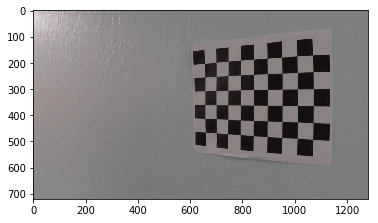

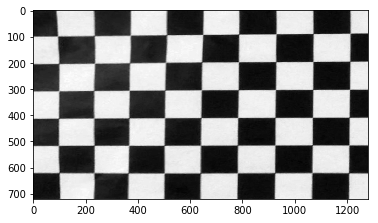

In [7]:
plt.imshow(test_image_read)
plt.show()
plt.imshow(test_top_down, cmap="gray")
plt.show()


# Combination between Gradient and Color thresholging methods

In [8]:


# In this part, we will test using (test images) folder for the road in order to
# have a good way of comparison with the output generated in the lectures

#Gradient thresold functions

# Absolute sobel threshold
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Notes: 
    # 1) sobel_kernel must be odd
    # 2) thresh is a tuble (thresh_min = , thresh_max = )
    
    # This image must be read by cv2
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == "x":
        # calculate sobelx
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == "y":
        # calculate sobely
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take the absolute value of the derivative
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0-255) then cast to be np.uint8
    Scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    # is greater than threshold min and less than the threshold max
    binary_output = np.zeros_like(Scaled_sobel)
    binary_output[(Scaled_sobel >= thresh[0]) & (Scaled_sobel < thresh[1])] = 1
    
    return binary_output





# Magnitude threshold
def mag_thresh(img, sobel_kernel, mag_thresh):
    # It will be implemented as the previous, but calculating sobel from the magnitude of both x and y
    # Notes: 
    # 1) sobel_kernel must be odd
    # 2) mag_thresh is a tuble (mag_thresh_min = , mag_thresh_max = )
    
    # This image must be read by cv2
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate sobel x and y then calculate their magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0-255) and cast to be uint8 
    Scaled_sobel = (255*mag_sobel/np.max(mag_sobel)).astype('uint8')
    # Create the mask using the boundary thresolds
    binary_output = np.zeros_like(Scaled_sobel)
    binary_output[(Scaled_sobel >= mag_thresh[0]) & (Scaled_sobel < mag_thresh[1])] = 1
    
    return binary_output







# Direction of the gradient threshold
def dir_thresh(img, sobel_kernel, dir_thresh):
    # It will be implemented as the previous, but calculating sobel angle (gradient) using arctan2 
    # Notes:
    # 1) sobel_kernel must be odd
    # 2) dir_thresh is a tuble (dir_thresh_min = , dir_thresh_max = )
    
    # This image must be read by cv2
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate sobel x and y then calculate their magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # calculate the absolute value of both of sobelx, and sobely
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # calculate the gradient using the arctan2 to put threshold
    dir_grad = np.arctan2(abs_sobely,abs_sobelx)
    # Create the mask using the boundary thresolds
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= dir_thresh[0]) & (dir_grad < dir_thresh[1])] = 1
    
    return binary_output



In [9]:
# Color thresold functions

def hls_select(img, hls_thresh):
    # Notes:
    # 1) hls_thresh is a tuble (hls_thresh_min = , hls_thresh_max = )
    
    # This image must be read by cv2
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # apply thresholding to have the S-channel only from the HLS components
    S_Channel = hls[:,:,2] 
    # Create the mask using the boundaries
    binary_output = np.zeros_like(S_Channel)
    binary_output[(S_Channel >= hls_thresh[0]) & (S_Channel <= hls_thresh[1])] = 1
    
    return binary_output


# Binary thresold in order to make the shadow unseen
def LAB_select(img, LAB_thresh):
    LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    B_Channel = LAB[:,:,2]
    # Create the mask using the boundaries
    binary_output = np.zeros_like(B_Channel)
    binary_output[(B_Channel >= LAB_thresh[0]) & (B_Channel <= LAB_thresh[1])] = 1
    
    return binary_output


# hsv thresholding in order to put threshold for yellow and white colors
def hsv_select(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow_mask = cv2.inRange(hsv, np.array((0,100,100)), np.array((80,255,255)))
    white_mask = cv2.inRange(img, np.array((200,200,200)), np.array((255,255,255)))
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    binary_output = np.zeros_like(mask)
    binary_output[(mask == 255)] = 1

    return binary_output




# Define the Pipeline of thresolding based on both Gradient and color thresholding

In [10]:
def Pipline_threshold(image):
    Absolute_thresholding_x         = abs_sobel_thresh(image, orient = "x", sobel_kernel = 9, thresh = (40,100) )
    Absolute_thresholding_y         = abs_sobel_thresh(image, orient = "y", sobel_kernel = 9, thresh = (80,180) )
    Magnitude_thresholding          = mag_thresh(image, sobel_kernel = 9, mag_thresh = (50,150) )
    Gradient_Direction_thresholding = dir_thresh(image, sobel_kernel = 9, dir_thresh = (0,np.pi/2) )
    HLS_thresholding                = hls_select(image, hls_thresh = (255,255))
    LAB_thresholding                = LAB_select(image, LAB_thresh=(40,100))
    HSV_thresholding                = hsv_select(image)
    
    Combined_binary = np.zeros_like(Absolute_thresholding_x)
    '''
    (Absolute_thresholding_x == 1) |
    (LAB_thresholding == 1) |
    ((HLS_thresholding == 1) & (Gradient_Direction_thresholding == 1))
    '''
    Combined_binary[(HSV_thresholding == 1) |
                   (Absolute_thresholding_x == 1)
                   ] = 1
    
    color_binary = np.dstack((np.zeros_like(Absolute_thresholding_x), Absolute_thresholding_x, HLS_thresholding)) * 255
    
    return Combined_binary, color_binary

In [11]:
# Testing for the previous thresholding 
test_image_pipeline = "test_images/test1.jpg"
Read_test_image_pipeline = mpimg.imread(test_image_pipeline)

output_combined_binaries, coloring_binary = Pipline_threshold(Read_test_image_pipeline)

plt.imshow(Read_test_image_pipeline)
#plt.show()
plt.imshow(output_combined_binaries, cmap="gray")
#plt.show()
plt.imshow(coloring_binary, cmap="gray")
#plt.show()


In [12]:
## Prespective Transform Check on these images in order to have Bird's view for the street
Source_road_points = np.float32([[575,460], [150,720], [1150,720], [700,460]])
Destination_road_points = np.float32([[250,0], [250,720], [1050,720], [1050,0]])

Source_road_points = np.float32([[575,460], [150,720], [1150,720], [700,460]])
Destination_road_points = np.float32([[250,0], [250,720], [1050,720], [1050,0]])


test_top_down_road, test_road_prespective_M = corners_unwrap(test_image_pipeline, 
                                                             n_rows, n_cols, dict_pickle["mtx"],dict_pickle["dist"], 
                                                             Source_road_points, Destination_road_points, True)

#plt.imshow(test_top_down_road, cmap="gray")
#plt.show()

test_top_down_road, test_road_prespective_M = corners_unwrap(output_combined_binaries, 
                                                             n_rows, n_cols, dict_pickle["mtx"],dict_pickle["dist"], 
                                                             Source_road_points, Destination_road_points, False)

plt.imshow(test_top_down_road, cmap="gray")
#plt.show()


In [13]:
'''
Now we have done the following steps:
    1- Camera Calibration
    2- Image Distortion Correction
    3- Gradient and Color thresholding
    4- Prespective transform to have a Bird's eye images
    
Now we want to do the following steps:
    1- Locate the Lanes lines using the code in the lectures (Using the Histogram method of the two peaks)
    2- Using the sliding window in order to know the full Lane Lines in the image
    3- Fitting a polynomial for the Lane using the codes in the lectures
    4- Measuring the Curvature (Remember: within approx. 1k.m)
    
For the Full Pipeline:
    1- Work on the video to extract the images frame by frame (Not Yet)
    2- Image Distortion and Correction (Done)
    3- Gradient and Color thresholding (DOne)
    4- Prespective transform to have the Bird's eye images that facilitate 
    extracting the Lanes Lines and fit a polynomial (Done)
    5- Extract Lanes Lines using the Histogram method (Not Yet)
    6- Apply Sliding window to locate the whole lines (Not Yet)
    7- Fitting a polynomial for the whole lane lines (Not Yet)
    8- Measure the Lanes Curvature (Not Yet)
    9- Save the video (Not Yet)
'''

"\nNow we have done the following steps:\n    1- Camera Calibration\n    2- Image Distortion Correction\n    3- Gradient and Color thresholding\n    4- Prespective transform to have a Bird's eye images\n    \nNow we want to do the following steps:\n    1- Locate the Lanes lines using the code in the lectures (Using the Histogram method of the two peaks)\n    2- Using the sliding window in order to know the full Lane Lines in the image\n    3- Fitting a polynomial for the Lane using the codes in the lectures\n    4- Measuring the Curvature (Remember: within approx. 1k.m)\n    \nFor the Full Pipeline:\n    1- Work on the video to extract the images frame by frame (Not Yet)\n    2- Image Distortion and Correction (Done)\n    3- Gradient and Color thresholding (DOne)\n    4- Prespective transform to have the Bird's eye images that facilitate \n    extracting the Lanes Lines and fit a polynomial (Done)\n    5- Extract Lanes Lines using the Histogram method (Not Yet)\n    6- Apply Sliding wi

In [14]:
# Plot the histogram of the output image

def Calculate_histogram(image, plotting=False):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    if plotting == True:
        plt.plot(histogram,"b")
        plt.show()
    
    return histogram

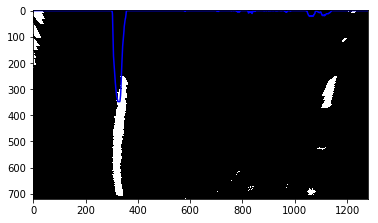

array([1, 0, 0, ..., 0, 0, 0], dtype=uint32)

In [15]:
# test the Histogram function
Calculate_histogram(test_top_down_road, plotting=True)

# Thios means that the two lanes lines are located at the two peaks

# Finding the Lanes Lines and Fit a polynomial

In [16]:
def PolynomialFit_LanesLines(image):
    # The input image should be the Bird's eye image
    
    # Choose the number of sliding windows
    nwindows = 13
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50
        
    # Take a histogram of the bottom half of the image
    histogram = Calculate_histogram(image, plotting=False)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((image, image, image))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    print(leftx)
    print(lefty)
    print(rightx)
    print(righty)
    
    global Current_fit_Left
    global Current_fit_Right
    
    print(Current_fit_Left, Current_fit_Right)
    
    
    # Sanity Check if the lanes are detected or not
    if (len(leftx) == 0):
        print("Lanes are not detected")
        # Call the function that draws lines without using sliding window
        left_fit, right_fit, out_img, leftx, lefty, rightx, righty = Skip_SlidingWindow_Visualization(out_img, Current_fit_Left, Current_fit_Right)
        
    else:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
    Current_fit_Left = left_fit
    Current_fit_Right = right_fit
    
    print(Current_fit_Left, Current_fit_Right)
    
    return left_fit, right_fit, out_img, leftx, lefty, rightx, righty

In [17]:
def PolynomialFit_Visulaization(image):
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    
    left_fit, right_fit, output_image, L_x, L_y, R_x, R_y = PolynomialFit_LanesLines(image)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    output_image[L_y, L_x] = [255, 0, 0]
    output_image[R_y, R_x] = [0, 0, 255]
    
    plt.imshow(output_image)
    #global i
    #plt.imsave("output_images/warped_imgs/" + str(i) + ".jpg", output_image)
    #i += 1
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.show()
    
    return output_image, left_fitx, right_fitx, left_fit, right_fit, L_x, L_y, R_x, R_y

[312 313 314 ..., 360 361 362]
[665 665 665 ..., 279 279 279]
[1071 1072 1056 ..., 1225 1226 1227]
[666 666 680 ...,  11  11  11]
[] []
[  2.95385271e-04  -3.41749069e-01   4.20456330e+02] [  1.70505250e-04  -3.45889105e-01   1.22295366e+03]


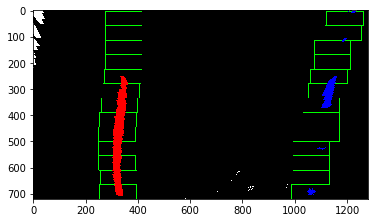

In [18]:
out_image, LeftFitX, RightFitX, LeftFit, RightFit, Left_X, Left_Y, Right_X, Right_Y = PolynomialFit_Visulaization(test_top_down_road)
plt.imshow(out_image)
plt.show()

# Skipping Function for the sliding window technique.

In [19]:
 
# This Function could be used when we know the positions of the Lanes Lines

def Skip_SlidingWindow(image, left_fit, right_fit):
    # Set the width of the windows +/- margin
    margin = 70
    
    # Create an image to draw on 
    #output_image = np.dstack((image, image, image))*255
    
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    print("Here: ", left_fit)
    print("Here: ", right_fit)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit_poly = np.polyfit(lefty, leftx, 2)
    right_fit_poly = np.polyfit(righty, rightx, 2)
    
    return left_fit_poly, right_fit_poly, image, leftx, lefty, rightx, righty

In [20]:
# Visualize fitting without Sliding window

def Skip_SlidingWindow_Visualization(image, left_fit, right_fit):
    # Set the width of the windows +/- margin
    margin = 70
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    LFit, RFit, output_image, Lx, Ly, Rx, Ry = Skip_SlidingWindow(image, left_fit, right_fit) 
    
    left_fitx = LFit[0]*ploty**2 + LFit[1]*ploty + LFit[2]
    right_fitx = RFit[0]*ploty**2 + RFit[1]*ploty + RFit[2]
    
    # Create an image to show the selection window
    #window_img = np.zeros_like(output_image)
    
    # Color in left and right line pixels
    #output_image[Ly, Lx] = [255, 0, 0]
    #output_image[Ry, Rx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    #left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    #left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    #left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    #right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    #right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(output_image, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.show()
    
    return LFit, RFit, output_image, Lx, Ly, Rx, Ry
    

In [21]:
# Visualization for Skipping Window technique
Skip_SlidingWindow_Visualization(test_top_down_road, LeftFit, RightFit)

# Here I have used the same output of the same image in order to check the functionality of Skipping Sliding window 

Here:  [  2.95385271e-04  -3.41749069e-01   4.20456330e+02]
Here:  [  1.70505250e-04  -3.45889105e-01   1.22295366e+03]


(array([  2.95385271e-04,  -3.41749069e-01,   4.20456330e+02]),
 array([  1.72437224e-04,  -3.47768951e-01,   1.22334982e+03]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([334, 335, 336, ..., 341, 342, 343], dtype=int64),
 array([253, 253, 253, ..., 707, 707, 707], dtype=int64),
 array([1207, 1208, 1209, ..., 1043, 1044, 1045], dtype=int64),
 array([  0,   0,   0, ..., 703, 703, 703], dtype=int64))

# Measuring the Curvature Function in pixels

In [22]:
def Curvature_Measurement_pix(image, left_fit, right_fit, leftx, lefty, rightx, righty):
    left_curverad = ((1 + (2*left_fit[0]*np.max(lefty) + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*np.max(righty) + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, "in pixels", right_curverad, "in pixels")
    
    
# Test the Radius of Curvature
Curvature_Measurement_pix(test_top_down_road, LeftFit, RightFit, Left_X, Left_Y, Right_X, Right_Y)

# Measuring the Curvature Function in meters

In [23]:
def Curvature_Measurement_m(image, left_fit, right_fit, leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad  = ((1 + (2*left_fit_cr[0]*np.max(lefty*ym_per_pix) + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(righty*ym_per_pix) + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad
    
# Test the Radius of Curvature
Curvature_Measurement_m(test_top_down_road, LeftFit, RightFit, Left_X, Left_Y, Right_X, Right_Y)

(556.05203198042477, 963.43898558984085)

# Reverse Projection for the image and fill between the two polylines for the lanes

In [24]:
def Reverse_Fill_DrawLanes(image, warped_image, left_fitx, right_fitx, Minv):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.fillPoly(color_warp, np.int_([pts_left]), (255,0, 0))
    cv2.fillPoly(color_warp, np.int_([pts_right]), (0,0, 255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    #plt.show()
    
    return result
    
Reverse_Fill_DrawLanes(Read_test_image_pipeline, test_top_down_road, LeftFitX, RightFitX, np.linalg.inv(test_road_prespective_M))

array([[[254, 233, 216],
        [245, 238, 232],
        [196, 205, 212],
        ..., 
        [ 16,  35,  52],
        [ 20,  37,  53],
        [ 32,  48,  63]],

       [[245, 238, 232],
        [188, 193, 197],
        [137, 158, 175],
        ..., 
        [ 74, 108, 135],
        [ 47,  77, 103],
        [  4,  34,  60]],

       [[193, 202, 209],
        [134, 157, 173],
        [115, 154, 183],
        ..., 
        [ 95, 144, 184],
        [ 89, 137, 177],
        [ 52,  97, 136]],

       ..., 
       [[141, 131, 129],
        [132, 121, 119],
        [114, 100,  97],
        ..., 
        [ 99,  80,  74],
        [ 99,  80,  74],
        [113,  94,  88]],

       [[164, 154, 152],
        [133, 122, 120],
        [120, 106, 103],
        ..., 
        [107,  88,  82],
        [109,  90,  84],
        [111,  92,  86]],

       [[189, 179, 177],
        [135, 125, 123],
        [128, 117, 113],
        ..., 
        [ 97,  78,  72],
        [ 95,  76,  70],
        [ 73,  54,

# Write on Every Image in the video during creation

In [25]:
# This Function writes on the image some measurements

def Write_Measurements(image, Radius_curve, leftfitx, rightfitx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    Veh_position = image.shape[1]//2
    middle = (leftfitx[-1] + rightfitx[-1])//2
    dx = (Veh_position - middle) * xm_per_pix # Positive if on right, Negative on left
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,'Left radius of curvature  = %.2f m'%(Radius_curve[0]),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image,'Right radius of curvature = %.2f m'%(Radius_curve[1]),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image,'Vehicle position : %.2f m %s of center'%(abs(dx), 'left' if dx < 0 else 'right'),(50,110), font, 1,(255,255,255),2,cv2.LINE_AA)

    return image

In [26]:
# Coloring the Lanes Lines
# def Color_Lanes_Lines(image, LFitX, RFitX, LX, LY, RX, RY):
#     margin = 70
#     window_img = np.zeros_like(image)
#     ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    
#     left_line_window1 = np.array([np.transpose(np.vstack([LFitX-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([LFitX + margin, ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
#     right_line_window1 = np.array([np.transpose(np.vstack([RFitX - margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([RFitX + margin, ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
#     result = cv2.addWeighted(image, 1, window_img, 0.5, 0)

# #     image[LY, LX] = [255, 0, 0]
# #     image[RY, RX] = [0, 0, 255]
    
#     plt.imshow(result)
#     plt.show()

#     return result

# Full Pipeline

In [27]:
'''
Now we want to apply all of the previous steps over the images extracted from the project video frame by frame.
But first we need to construct the Full Pipeline in One function in order facilitate tracing the code

We will follow the following steps:
    1- We have calibrated the camera, so we will use its parameters (Done)
    2- Image Distortion correction (Done)
    3- Apply Gradient and Color thresholding (Done)
    4- Apply prespective transform till have the Bird's eye view (Done)
    5- Polynomial Fitting (Done)
    6- Calculate both (Radius of Curvature and the Car's Position away from the 2 lane lines) (Not Yet Totally)
    7- Reverse and Fill between the two Line Lanes (Done)
    8- Write Left and Right Radius on the image in addition to the Car's position
    
Important Note: The image is already read, so every read using mpimg or cv2 will be commented
'''

for_testing = [0,1,2,3,4,5,6,7]
i = 0

def Advanced_Lane_Finding(image):
    # Read from the Chessboard images we have
    n_rows = 9 # rows corners in the chessboard
    n_cols = 6 # columns corners in the chessboard
    
    Src_road_pts = np.float32([[575,460], [150,720], [1150,720], [700,460]])
    Dest_road_pts = np.float32([[250,0], [250,720], [1050,720], [1050,0]])
    
    plt.imshow(image)
    #plt.show()
    
    
    #Destination_road_points = np.float32([[250,0], [250,720], [1050,720], [1050,0]])
    
    # 1- Load the saved pickle that contains the Camera Calibration parameters
    Cal_Params = pickle.load(open("camera_calibrate.p", 'rb'))
    
    ##################################################################################################
    
    # 2- Use the Calibration parameters to undistort the input image
    undist_image = cv2.undistort(image, Cal_Params["mtx"], Cal_Params["dist"], None, Cal_Params["mtx"])
    
    #plt.imshow(undist_image)
    #plt.show()
    
    ##################################################################################################
    
    # 3- Apply Gradient and Color thresholding
    image_binaries, image_color_binary = Pipline_threshold(undist_image)
    
    #plt.imshow(image_binaries, cmap="gray")
    #plt.show()
    
    ##################################################################################################
    
    # 4- Apply prespective transform
    image_warped, image_M = corners_unwrap(image_binaries, n_rows, n_cols, 
                                                  Cal_Params["mtx"],Cal_Params["dist"], 
                                                  Src_road_pts, Dest_road_pts, False)
    #plt.imshow(image_warped, cmap="gray")
    #plt.show()
    
    ##################################################################################################
    
    # 5- Polynomial Fitting and draw rectangles in green with the pplynomial lines in yellow with Visualization
    poly_image, LFitX, RFitX, LFit, RFit, LX, LY, RX, RY = PolynomialFit_Visulaization(image_warped)
    
    ##################################################################################################
    
    # 6- Calculate Radius Curvature
    R_curve_pix = Curvature_Measurement_pix(poly_image, LFit, RFit, LX, LY, RX, RY)
    R_curve_met = Curvature_Measurement_m(poly_image, LFit, RFit, LX, LY, RX, RY)
    
    ##################################################################################################
    
    
    # 7- Reverse and Fill between the two lines
    image_output = Reverse_Fill_DrawLanes(undist_image, image_warped, LFitX, RFitX, np.linalg.inv(image_M))
    
    ##################################################################################################
    
#     # 7- Draw Lanes Lines with different colors
#     image_output_with_coloring = Color_Lanes_Lines(image_output, LFitX, RFitX, LX, LY, RX, RY)
#     plt.imshow(image_output_with_coloring)
#     plt.show()
    
    ##################################################################################################
    
    # 9- Write Measurements on the video's image
    image_output_with_measurements = Write_Measurements(image_output, R_curve_met, LFitX, RFitX)
    #plt.imshow(image_output_with_measurements)
    #plt.show()
    
    ##################################################################################################

    return image_output_with_measurements

In [28]:
Test_images_Folder = "test_images/*.jpg"
All_File = glb.glob(Test_images_Folder)

print(All_File)

for im in All_File:
    print(im[12:])
    Im_Read = mpimg.imread(im)
    Advanced_Lane_Finding(Im_Read)
    print("###########################################################")


['test_images\\straight_lines1.jpg', 'test_images\\straight_lines2.jpg', 'test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']
straight_lines1.jpg
[283 284 285 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1022 1026 1019 ..., 1092 1093 1094]
[688 688 689 ...,  59  59  59]
[  2.95385271e-04  -3.41749069e-01   4.20456330e+02] [  1.70505250e-04  -3.45889105e-01   1.22295366e+03]
[ -2.54551891e-05   2.34172731e-02   2.93890097e+02] [  6.61857582e-05  -1.06563175e-01   1.06039849e+03]
###########################################################
straight_lines2.jpg
[289 290 294 ..., 329 330 331]
[665 665 665 ...,  11  11  11]
[1003 1004 1005 ..., 1116 1117 1118]
[665 665 665 ...,  59  59  59]
[ -2.54551891e-05   2.34172731e-02   2.93890097e+02] [  6.61857582e-05  -1.06563175e-01   1.06039849e+03]
[  4.60294187e-05  -1.07933406e-02   2.89491504e+02] [ -3.15152577e-06  -9.26526224e-02   1.0

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()


In [30]:
project_output_video = "project_output_video.mp4"
clip = VideoFileClip("project_video.mp4")
output_video = clip.fl_image(Advanced_Lane_Finding) #  .subclip(0,35)   NOTE: this function expects color images!!
%time output_video.write_videofile(project_output_video, audio=False)

[341 342 343 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1091 1088 1080 ..., 1021 1022 1023]
[682 683 701 ...,  59  59  59]
[  1.34617900e-04  -3.51537687e-01   5.14891522e+02] [  2.34961082e-04  -4.38893604e-01   1.27894983e+03]
[ -2.64660497e-04   3.70164182e-01   2.26990890e+02] [ -1.54853607e-04   2.23464703e-01   1.01293485e+03]
[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


  0%|                                                                                                                 | 0/1261 [00:00<?, ?it/s]

[341 342 343 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1091 1088 1080 ..., 1021 1022 1023]
[682 683 701 ...,  59  59  59]
[ -2.64660497e-04   3.70164182e-01   2.26990890e+02] [ -1.54853607e-04   2.23464703e-01   1.01293485e+03]
[ -2.64660497e-04   3.70164182e-01   2.26990890e+02] [ -1.54853607e-04   2.23464703e-01   1.01293485e+03]


  0%|                                                                                                         | 1/1261 [00:00<08:15,  2.54it/s]

[341 342 343 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ..., 1044 1045 1046]
[610 610 610 ...,  59  59  59]
[ -2.64660497e-04   3.70164182e-01   2.26990890e+02] [ -1.54853607e-04   2.23464703e-01   1.01293485e+03]
[ -2.69517239e-04   3.75645450e-01   2.27065728e+02] [ -1.55311060e-04   2.32311788e-01   1.00516862e+03]


  0%|▏                                                                                                        | 2/1261 [00:00<08:11,  2.56it/s]

[341 342 343 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1068 1069 1075 ...,  976  977  978]
[665 665 665 ...,  32  32  32]
[ -2.69517239e-04   3.75645450e-01   2.27065728e+02] [ -1.55311060e-04   2.32311788e-01   1.00516862e+03]
[ -2.97879145e-04   3.99535890e-01   2.23636099e+02] [ -2.70813128e-04   3.39952148e-01   9.81043008e+02]


  0%|▏                                                                                                        | 3/1261 [00:01<07:56,  2.64it/s]

[342 343 344 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1068 1069 1070 ...,  980  981  982]
[665 665 665 ...,  59  59  59]
[ -2.97879145e-04   3.99535890e-01   2.23636099e+02] [ -2.70813128e-04   3.39952148e-01   9.81043008e+02]
[ -2.95702451e-04   4.01424172e-01   2.23042031e+02] [ -2.93747969e-04   3.77020681e-01   9.67053456e+02]


  0%|▎                                                                                                        | 4/1261 [00:01<07:45,  2.70it/s]

[344 345 346 ..., 272 273 274]
[665 665 665 ...,  59  59  59]
[1067 1068 1069 ..., 1003 1004 1005]
[665 665 665 ...,  59  59  59]
[ -2.95702451e-04   4.01424172e-01   2.23042031e+02] [ -2.93747969e-04   3.77020681e-01   9.67053456e+02]
[ -3.14106421e-04   4.18181350e-01   2.20094288e+02] [ -2.95504678e-04   3.82726740e-01   9.64341482e+02]


  0%|▍                                                                                                        | 5/1261 [00:01<07:57,  2.63it/s]

[345 346 347 ..., 272 273 274]
[665 665 665 ...,  59  59  59]
[1069 1070 1074 ..., 1026 1027 1028]
[665 665 665 ...,  59  59  59]
[ -3.14106421e-04   4.18181350e-01   2.20094288e+02] [ -2.95504678e-04   3.82726740e-01   9.64341482e+02]
[ -3.12664473e-04   4.23002440e-01   2.18059862e+02] [ -2.07946543e-04   3.21703679e-01   9.67269147e+02]


  0%|▍                                                                                                        | 6/1261 [00:02<07:48,  2.68it/s]

[347 348 349 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1080 1081 1082 ..., 1038 1039 1040]
[682 682 682 ...,  59  59  59]
[ -3.12664473e-04   4.23002440e-01   2.18059862e+02] [ -2.07946543e-04   3.21703679e-01   9.67269147e+02]
[ -2.99835321e-04   4.21229718e-01   2.14760807e+02] [ -1.70912225e-04   2.90436545e-01   9.75024006e+02]


  1%|▌                                                                                                        | 7/1261 [00:02<07:38,  2.73it/s]

[348 349 350 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1095 1099 1100 ..., 1032 1033 1034]
[693 693 693 ...,  59  59  59]
[ -2.99835321e-04   4.21229718e-01   2.14760807e+02] [ -1.70912225e-04   2.90436545e-01   9.75024006e+02]
[ -2.92561335e-04   4.21135658e-01   2.14311665e+02] [  1.52090753e-04   1.21445830e-01   9.82545683e+02]


  1%|▋                                                                                                        | 8/1261 [00:02<07:32,  2.77it/s]

[348 349 350 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1081 1087 1088 ..., 1038 1039 1040]
[610 610 610 ...,  59  59  59]
[ -2.92561335e-04   4.21135658e-01   2.14311665e+02] [  1.52090753e-04   1.21445830e-01   9.82545683e+02]
[ -2.82013008e-04   4.18230594e-01   2.10887620e+02] [  1.72791058e-04   8.91401218e-02   9.92871890e+02]


  1%|▋                                                                                                        | 9/1261 [00:03<07:38,  2.73it/s]

[347 348 349 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1089 1090 1090 ..., 1032 1033 1034]
[693 693 634 ...,  59  59  59]
[ -2.82013008e-04   4.18230594e-01   2.10887620e+02] [  1.72791058e-04   8.91401218e-02   9.92871890e+02]
[ -2.76363301e-04   4.20135876e-01   2.06886800e+02] [  1.45614337e-04   9.12803007e-02   9.94359448e+02]


  1%|▊                                                                                                       | 10/1261 [00:03<07:38,  2.73it/s]

[348 349 350 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1071 1072 1073 ...,  973  974  975]
[665 665 665 ...,  11  11  11]
[ -2.76363301e-04   4.20135876e-01   2.06886800e+02] [  1.45614337e-04   9.12803007e-02   9.94359448e+02]
[ -2.61148209e-04   4.12565653e-01   2.06448811e+02] [  5.19359898e-05   1.46625102e-01   9.84850607e+02]


  1%|▉                                                                                                       | 11/1261 [00:04<07:36,  2.74it/s]

[345 346 347 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1095 1096 1115 ...,  992  993  994]
[688 688 688 ...,  11  11  11]
[ -2.61148209e-04   4.12565653e-01   2.06448811e+02] [  5.19359898e-05   1.46625102e-01   9.84850607e+02]
[ -2.47849155e-04   4.13269371e-01   1.97048758e+02] [  9.24875671e-05   8.04950838e-02   1.01299338e+03]


  1%|▉                                                                                                       | 12/1261 [00:04<07:31,  2.77it/s]

[345 346 347 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ...,  992  993  994]
[610 610 610 ...,  52  52  52]
[ -2.47849155e-04   4.13269371e-01   1.97048758e+02] [  9.24875671e-05   8.04950838e-02   1.01299338e+03]
[ -2.22561165e-04   3.95386328e-01   1.98665030e+02] [ -5.86609510e-05   2.00313958e-01   9.89376548e+02]


  1%|█                                                                                                       | 13/1261 [00:04<07:30,  2.77it/s]

[344 345 346 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ..., 1009 1010 1011]
[610 610 610 ...,  59  59  59]
[ -2.22561165e-04   3.95386328e-01   1.98665030e+02] [ -5.86609510e-05   2.00313958e-01   9.89376548e+02]
[ -2.05948305e-04   3.84115036e-01   1.99075419e+02] [ -5.88668321e-05   1.95371306e-01   9.89218425e+02]


  1%|█▏                                                                                                      | 14/1261 [00:05<07:26,  2.79it/s]

[345 346 347 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ...,  939  940  941]
[610 610 610 ...,  32  32  32]
[ -2.05948305e-04   3.84115036e-01   1.99075419e+02] [ -5.88668321e-05   1.95371306e-01   9.89218425e+02]
[ -2.06691189e-04   3.80574674e-01   2.02651730e+02] [ -1.58073571e-04   2.95311916e-01   9.58697442e+02]


  1%|█▏                                                                                                      | 15/1261 [00:05<07:23,  2.81it/s]

[347 348 349 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1063 1064 1065 ...,  950  951  952]
[665 665 665 ...,  59  59  59]
[ -2.06691189e-04   3.80574674e-01   2.02651730e+02] [ -1.58073571e-04   2.95311916e-01   9.58697442e+02]
[ -2.11218250e-04   3.80085896e-01   2.04655242e+02] [ -2.97819060e-04   4.37437866e-01   9.18818539e+02]


  1%|█▎                                                                                                      | 16/1261 [00:05<07:18,  2.84it/s]

[346 347 348 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ...,  974  975  976]
[665 665 665 ...,  59  59  59]
[ -2.11218250e-04   3.80085896e-01   2.04655242e+02] [ -2.97819060e-04   4.37437866e-01   9.18818539e+02]
[ -1.93178843e-04   3.65363696e-01   2.05597634e+02] [ -2.28294955e-04   3.80930222e-01   9.25454826e+02]


  1%|█▍                                                                                                      | 17/1261 [00:06<07:19,  2.83it/s]

[345 346 347 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1060 1061 1067 ...,  991  992  993]
[665 665 665 ...,  59  59  59]
[ -1.93178843e-04   3.65363696e-01   2.05597634e+02] [ -2.28294955e-04   3.80930222e-01   9.25454826e+02]
[ -1.88637542e-04   3.60164091e-01   2.06780014e+02] [ -1.73661595e-04   3.42129943e-01   9.26163705e+02]


  1%|█▍                                                                                                      | 18/1261 [00:06<07:21,  2.82it/s]

[344 345 346 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ..., 1003 1004 1005]
[669 669 669 ...,  59  59  59]
[ -1.88637542e-04   3.60164091e-01   2.06780014e+02] [ -1.73661595e-04   3.42129943e-01   9.26163705e+02]
[ -1.93705282e-04   3.67793721e-01   2.01769717e+02] [ -1.51366581e-04   3.07551448e-01   9.40394461e+02]


  2%|█▌                                                                                                      | 19/1261 [00:06<07:18,  2.83it/s]

[344 345 346 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1094 1095 1067 ..., 1009 1010 1011]
[684 684 695 ...,  59  59  59]
[ -1.93705282e-04   3.67793721e-01   2.01769717e+02] [ -1.51366581e-04   3.07551448e-01   9.40394461e+02]
[ -1.79100235e-04   3.58681311e-01   1.99904472e+02] [ -1.16027048e-04   2.71207729e-01   9.51892215e+02]


  2%|█▋                                                                                                      | 20/1261 [00:07<07:22,  2.80it/s]

[342 343 344 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1026 1027 1028]
[595 595 595 ...,  59  59  59]
[ -1.79100235e-04   3.58681311e-01   1.99904472e+02] [ -1.16027048e-04   2.71207729e-01   9.51892215e+02]
[ -1.56648270e-04   3.41885929e-01   1.99536550e+02] [ -2.44169771e-06   1.95968516e-01   9.67741592e+02]


  2%|█▋                                                                                                      | 21/1261 [00:07<07:24,  2.79it/s]

[340 341 342 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1073 1074 1075 ..., 1026 1027 1028]
[619 619 619 ...,  59  59  59]
[ -1.56648270e-04   3.41885929e-01   1.99536550e+02] [ -2.44169771e-06   1.95968516e-01   9.67741592e+02]
[ -1.63700508e-04   3.49753978e-01   1.94317040e+02] [  5.49514233e-05   1.38368088e-01   9.84870198e+02]


  2%|█▊                                                                                                      | 22/1261 [00:07<07:40,  2.69it/s]

[337 338 339 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1077 1075 1076 ..., 1044 1045 1046]
[644 645 645 ...,  59  59  59]
[ -1.63700508e-04   3.49753978e-01   1.94317040e+02] [  5.49514233e-05   1.38368088e-01   9.84870198e+02]
[ -1.59471822e-04   3.46652230e-01   1.91302620e+02] [  1.05551393e-04   8.33314740e-02   1.00041422e+03]


  2%|█▉                                                                                                      | 23/1261 [00:08<07:32,  2.73it/s]

[335 336 337 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1074 1075 1068 ...,  966  967  968]
[672 672 673 ...,  11  11  11]
[ -1.59471822e-04   3.46652230e-01   1.91302620e+02] [  1.05551393e-04   8.33314740e-02   1.00041422e+03]
[ -1.71821605e-04   3.46908395e-01   1.95289324e+02] [  6.24229527e-06   1.46375151e-01   9.90097890e+02]


  2%|█▉                                                                                                      | 24/1261 [00:08<07:49,  2.64it/s]

[335 336 337 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ...,  968  969  970]
[701 701 701 ...,  52  52  52]
[ -1.71821605e-04   3.46908395e-01   1.95289324e+02] [  6.24229527e-06   1.46375151e-01   9.90097890e+02]
[ -1.85852293e-04   3.51937708e-01   1.96545983e+02] [ -1.73388183e-04   2.79722558e-01   9.68000475e+02]


  2%|██                                                                                                      | 25/1261 [00:09<07:40,  2.69it/s]

[331 332 333 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ...,  992  993  994]
[610 610 610 ...,  52  52  52]
[ -1.85852293e-04   3.51937708e-01   1.96545983e+02] [ -1.73388183e-04   2.79722558e-01   9.68000475e+02]
[ -1.77250248e-04   3.45843790e-01   1.94224758e+02] [ -1.46941438e-04   2.37918529e-01   9.86791327e+02]


  2%|██▏                                                                                                     | 26/1261 [00:09<07:33,  2.72it/s]

[330 331 332 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1058 1059 1060 ..., 1015 1016 1017]
[610 610 610 ...,  59  59  59]
[ -1.77250248e-04   3.45843790e-01   1.94224758e+02] [ -1.46941438e-04   2.37918529e-01   9.86791327e+02]
[ -1.88764400e-04   3.50790159e-01   1.93979024e+02] [ -1.13945195e-04   2.06539196e-01   9.94986585e+02]


  2%|██▏                                                                                                     | 27/1261 [00:09<07:27,  2.76it/s]

[252 253 254 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1064 1065 1066 ..., 1039 1040 1041]
[665 665 665 ...,  59  59  59]
[ -1.88764400e-04   3.50790159e-01   1.93979024e+02] [ -1.13945195e-04   2.06539196e-01   9.94986585e+02]
[ -2.02743471e-04   3.59432996e-01   1.89924986e+02] [ -9.57688720e-05   1.72997934e-01   1.01222869e+03]


  2%|██▎                                                                                                     | 28/1261 [00:10<07:21,  2.79it/s]

[325 326 327 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1064 1065 1066 ...,  973  974  975]
[665 665 665 ...,  11  11  11]
[ -2.02743471e-04   3.59432996e-01   1.89924986e+02] [ -9.57688720e-05   1.72997934e-01   1.01222869e+03]
[ -2.12770894e-04   3.59862605e-01   1.94257305e+02] [ -1.85865943e-04   2.57620576e-01   9.92881833e+02]


  2%|██▍                                                                                                     | 29/1261 [00:10<07:18,  2.81it/s]

[325 326 327 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1063 1064 1069 ...,  974  975  976]
[665 665 665 ...,  52  52  52]
[ -2.12770894e-04   3.59862605e-01   1.94257305e+02] [ -1.85865943e-04   2.57620576e-01   9.92881833e+02]
[ -2.40161266e-04   3.75475523e-01   1.96130260e+02] [ -2.54791058e-04   3.32966639e-01   9.70577191e+02]


  2%|██▍                                                                                                     | 30/1261 [00:10<07:15,  2.83it/s]

[325 326 327 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1062 1063 1069 ...,  997  998  999]
[665 665 665 ...,  59  59  59]
[ -2.40161266e-04   3.75475523e-01   1.96130260e+02] [ -2.54791058e-04   3.32966639e-01   9.70577191e+02]
[ -2.57331890e-04   3.85093949e-01   1.98645179e+02] [ -2.96154019e-04   3.88718692e-01   9.51553236e+02]


  2%|██▌                                                                                                     | 31/1261 [00:11<07:12,  2.84it/s]

[326 327 328 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ..., 1015 1016 1017]
[677 677 677 ...,  59  59  59]
[ -2.57331890e-04   3.85093949e-01   1.98645179e+02] [ -2.96154019e-04   3.88718692e-01   9.51553236e+02]
[ -2.88424212e-04   4.04762106e-01   2.00788630e+02] [ -2.24558619e-04   3.52545339e-01   9.43722828e+02]


  3%|██▋                                                                                                     | 32/1261 [00:11<07:23,  2.77it/s]

[326 327 328 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1073 1074 1070 ..., 1021 1022 1023]
[696 696 703 ...,  59  59  59]
[ -2.88424212e-04   4.04762106e-01   2.00788630e+02] [ -2.24558619e-04   3.52545339e-01   9.43722828e+02]
[ -2.84854916e-04   4.02150023e-01   1.99953869e+02] [ -1.51082343e-04   2.90542052e-01   9.61790215e+02]


  3%|██▋                                                                                                     | 33/1261 [00:11<07:18,  2.80it/s]

[328 329 330 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1077 1078 1058 ..., 1015 1016 1017]
[702 702 610 ...,  59  59  59]
[ -2.84854916e-04   4.02150023e-01   1.99953869e+02] [ -1.51082343e-04   2.90542052e-01   9.61790215e+02]
[ -3.05852219e-04   4.19871819e-01   1.98953383e+02] [  5.16996559e-05   1.80960231e-01   9.67611837e+02]


  3%|██▊                                                                                                     | 34/1261 [00:12<07:43,  2.65it/s]

[330 331 332 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ..., 1015 1016 1017]
[632 632 632 ...,  59  59  59]
[ -3.05852219e-04   4.19871819e-01   1.98953383e+02] [  5.16996559e-05   1.80960231e-01   9.67611837e+02]
[ -3.25339482e-04   4.35738676e-01   1.97875994e+02] [  3.64007404e-05   1.82241441e-01   9.67803339e+02]


  3%|██▉                                                                                                     | 35/1261 [00:12<07:26,  2.75it/s]

[333 334 335 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1065 1070 1072 ...,  936  937  936]
[665 665 665 ...,  30  30  31]
[ -3.25339482e-04   4.35738676e-01   1.97875994e+02] [  3.64007404e-05   1.82241441e-01   9.67803339e+02]
[ -3.33761028e-04   4.47094083e-01   1.97001951e+02] [ -2.19504005e-05   2.18010539e-01   9.58810054e+02]


  3%|██▉                                                                                                     | 36/1261 [00:13<07:26,  2.74it/s]

[333 334 335 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1067 1068 1072 ...,  950  951  952]
[686 686 686 ...,  52  52  52]
[ -3.33761028e-04   4.47094083e-01   1.97001951e+02] [ -2.19504005e-05   2.18010539e-01   9.58810054e+02]
[ -3.41726975e-04   4.55130379e-01   1.96236858e+02] [ -1.26801626e-04   2.86451894e-01   9.48827474e+02]


  3%|███                                                                                                     | 37/1261 [00:13<07:23,  2.76it/s]

[335 336 337 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ...,  973  974  975]
[555 555 555 ...,  59  59  59]
[ -3.41726975e-04   4.55130379e-01   1.96236858e+02] [ -1.26801626e-04   2.86451894e-01   9.48827474e+02]
[ -3.55206484e-04   4.69532476e-01   1.94538223e+02] [ -1.45966370e-04   3.05267051e-01   9.42303083e+02]


  3%|███▏                                                                                                    | 38/1261 [00:13<07:18,  2.79it/s]

[336 337 338 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ...,  961  962  963]
[610 610 610 ...,  59  59  59]
[ -3.55206484e-04   4.69532476e-01   1.94538223e+02] [ -1.45966370e-04   3.05267051e-01   9.42303083e+02]
[ -3.75367157e-04   4.86641310e-01   1.92912181e+02] [ -2.82053878e-04   4.23123857e-01   9.15246145e+02]


  3%|███▏                                                                                                    | 39/1261 [00:14<07:08,  2.85it/s]

[336 337 338 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ...,  914  915  916]
[610 610 610 ...,  52  52  52]
[ -3.75367157e-04   4.86641310e-01   1.92912181e+02] [ -2.82053878e-04   4.23123857e-01   9.15246145e+02]
[ -3.81022896e-04   4.98163166e-01   1.87939688e+02] [ -2.80810614e-04   4.21057532e-01   9.17268298e+02]


  3%|███▎                                                                                                    | 40/1261 [00:14<07:07,  2.86it/s]

[336 337 338 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1057 1058 1064 ...,  932  933  934]
[665 665 665 ...,  59  59  59]
[ -3.81022896e-04   4.98163166e-01   1.87939688e+02] [ -2.80810614e-04   4.21057532e-01   9.17268298e+02]
[ -3.74594163e-04   4.97928262e-01   1.86590837e+02] [ -3.37139637e-04   4.75889516e-01   9.04717287e+02]


  3%|███▍                                                                                                    | 41/1261 [00:14<07:08,  2.85it/s]

[337 338 339 ..., 237 238 239]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ...,  956  957  958]
[665 665 665 ...,  59  59  59]
[ -3.74594163e-04   4.97928262e-01   1.86590837e+02] [ -3.37139637e-04   4.75889516e-01   9.04717287e+02]
[ -3.71235981e-04   5.02031998e-01   1.84075848e+02] [ -3.32394592e-04   4.70823973e-01   9.07685906e+02]


  3%|███▍                                                                                                    | 42/1261 [00:15<07:17,  2.79it/s]

[339 340 341 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ...,  974  975  976]
[665 665 665 ...,  59  59  59]
[ -3.71235981e-04   5.02031998e-01   1.84075848e+02] [ -3.32394592e-04   4.70823973e-01   9.07685906e+02]
[ -3.70211730e-04   5.06866889e-01   1.80457661e+02] [ -2.89113200e-04   4.24285556e-01   9.21747029e+02]


  3%|███▌                                                                                                    | 43/1261 [00:15<07:20,  2.77it/s]

[337 338 339 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ...,  991  992  993]
[665 665 665 ...,  59  59  59]
[ -3.70211730e-04   5.06866889e-01   1.80457661e+02] [ -2.89113200e-04   4.24285556e-01   9.21747029e+02]
[ -3.59631458e-04   5.04189378e-01   1.77076300e+02] [ -2.83858451e-04   4.13233037e-01   9.29092888e+02]


  3%|███▋                                                                                                    | 44/1261 [00:15<07:16,  2.79it/s]

[337 338 339 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1073 1074 1075 ..., 1009 1010 1011]
[687 687 687 ...,  59  59  59]
[ -3.59631458e-04   5.04189378e-01   1.77076300e+02] [ -2.83858451e-04   4.13233037e-01   9.29092888e+02]
[ -3.36263327e-04   4.91324016e-01   1.76274551e+02] [ -2.52917936e-04   3.83762536e-01   9.38501518e+02]


  4%|███▋                                                                                                    | 45/1261 [00:16<07:16,  2.79it/s]

[337 338 339 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1086 1087 1084 ..., 1009 1010 1011]
[702 702 703 ...,  59  59  59]
[ -3.36263327e-04   4.91324016e-01   1.76274551e+02] [ -2.52917936e-04   3.83762536e-01   9.38501518e+02]
[ -3.31291028e-04   4.90542504e-01   1.74514335e+02] [ -8.08748748e-05   2.80669802e-01   9.51385509e+02]


  4%|███▊                                                                                                    | 46/1261 [00:16<07:18,  2.77it/s]

[337 338 339 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1055 1066 1067 ..., 1009 1010 1011]
[708 618 618 ...,  59  59  59]
[ -3.31291028e-04   4.90542504e-01   1.74514335e+02] [ -8.08748748e-05   2.80669802e-01   9.51385509e+02]
[ -3.17692779e-04   4.85092984e-01   1.72183765e+02] [ -2.22376990e-05   2.36616637e-01   9.58732151e+02]


  4%|███▉                                                                                                    | 47/1261 [00:17<07:20,  2.76it/s]

[339 340 341 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1067 1068 1069 ..., 1003 1004 1005]
[645 645 645 ...,  59  59  59]
[ -3.17692779e-04   4.85092984e-01   1.72183765e+02] [ -2.22376990e-05   2.36616637e-01   9.58732151e+02]
[ -3.03409468e-04   4.77132913e-01   1.72192358e+02] [  1.75266627e-05   2.02638981e-01   9.60452891e+02]


  4%|███▉                                                                                                    | 48/1261 [00:17<07:26,  2.72it/s]

[336 337 338 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1071 1076 1077 ...,  997  998  999]
[671 671 671 ...,  59  59  59]
[ -3.03409468e-04   4.77132913e-01   1.72192358e+02] [  1.75266627e-05   2.02638981e-01   9.60452891e+02]
[ -2.73955603e-04   4.59254097e-01   1.70607751e+02] [  4.61593421e-05   1.62757346e-01   9.73998004e+02]


  4%|████                                                                                                    | 49/1261 [00:17<07:20,  2.75it/s]

[337 338 339 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1071 1072 1076 ...,  952  953  954]
[698 698 698 ...,  32  32  32]
[ -2.73955603e-04   4.59254097e-01   1.70607751e+02] [  4.61593421e-05   1.62757346e-01   9.73998004e+02]
[ -2.56184091e-04   4.48091992e-01   1.70956073e+02] [ -1.12807422e-04   2.71376903e-01   9.58186412e+02]


  4%|████                                                                                                    | 50/1261 [00:18<07:20,  2.75it/s]

[337 338 339 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1057 1058 1066 ...,  962  963  964]
[610 610 610 ...,  52  52  52]
[ -2.56184091e-04   4.48091992e-01   1.70956073e+02] [ -1.12807422e-04   2.71376903e-01   9.58186412e+02]
[ -2.40330772e-04   4.37398050e-01   1.71095972e+02] [ -9.91660417e-05   2.59449949e-01   9.59458321e+02]


  4%|████▏                                                                                                   | 51/1261 [00:18<07:17,  2.76it/s]

[339 340 341 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1041 1055 1056 ...,  985  986  987]
[698 610 610 ...,  59  59  59]
[ -2.40330772e-04   4.37398050e-01   1.71095972e+02] [ -9.91660417e-05   2.59449949e-01   9.59458321e+02]
[ -2.13310142e-04   4.13632629e-01   1.76181191e+02] [ -1.45797599e-04   3.03104997e-01   9.44743588e+02]


  4%|████▎                                                                                                   | 52/1261 [00:18<07:20,  2.74it/s]

[339 340 341 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1058 1059 1065 ...,  915  916  917]
[665 665 665 ...,  32  32  32]
[ -2.13310142e-04   4.13632629e-01   1.76181191e+02] [ -1.45797599e-04   3.03104997e-01   9.44743588e+02]
[ -2.16852778e-04   4.15749160e-01   1.75838879e+02] [ -2.42549624e-04   3.84284066e-01   9.27448597e+02]


  4%|████▎                                                                                                   | 53/1261 [00:19<07:23,  2.72it/s]

[337 338 339 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1057 1058 1064 ...,  926  927  928]
[665 665 665 ...,  59  59  59]
[ -2.16852778e-04   4.15749160e-01   1.75838879e+02] [ -2.42549624e-04   3.84284066e-01   9.27448597e+02]
[ -2.07212659e-04   4.07391764e-01   1.76657396e+02] [ -2.98048314e-04   4.40613050e-01   9.12593629e+02]


  4%|████▍                                                                                                   | 54/1261 [00:19<07:17,  2.76it/s]

[337 338 339 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1058 1059 1065 ...,  950  951  952]
[665 665 665 ...,  59  59  59]
[ -2.07212659e-04   4.07391764e-01   1.76657396e+02] [ -2.98048314e-04   4.40613050e-01   9.12593629e+02]
[ -1.84580582e-04   3.88514616e-01   1.78116513e+02] [ -3.41881038e-04   4.79440711e-01   9.06851114e+02]


  4%|████▌                                                                                                   | 55/1261 [00:19<07:16,  2.76it/s]

[336 337 338 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1058 1059 1060 ...,  973  974  975]
[665 665 665 ...,  59  59  59]
[ -1.84580582e-04   3.88514616e-01   1.78116513e+02] [ -3.41881038e-04   4.79440711e-01   9.06851114e+02]
[ -1.71484326e-04   3.76615566e-01   1.79079585e+02] [ -2.87287254e-04   4.22365673e-01   9.21106661e+02]


  4%|████▌                                                                                                   | 56/1261 [00:20<07:17,  2.76it/s]

[335 336 337 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1088 1080 1081 ...,  991  992  993]
[668 669 669 ...,  59  59  59]
[ -1.71484326e-04   3.76615566e-01   1.79079585e+02] [ -2.87287254e-04   4.22365673e-01   9.21106661e+02]
[ -1.67361071e-04   3.70552540e-01   1.80449891e+02] [ -2.31392511e-04   3.92668850e-01   9.19795466e+02]


  5%|████▋                                                                                                   | 57/1261 [00:20<07:17,  2.75it/s]

[335 336 337 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1081 1082 1083 ...,  991  992  993]
[696 696 696 ...,  59  59  59]
[ -1.67361071e-04   3.70552540e-01   1.80449891e+02] [ -2.31392511e-04   3.92668850e-01   9.19795466e+02]
[ -1.69189261e-04   3.69748624e-01   1.80243441e+02] [ -1.39755444e-04   3.25474491e-01   9.31905834e+02]


  5%|████▊                                                                                                   | 58/1261 [00:21<07:25,  2.70it/s]

[336 337 338 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ...,  973  974  975]
[610 610 610 ...,  59  59  59]
[ -1.69189261e-04   3.69748624e-01   1.80243441e+02] [ -1.39755444e-04   3.25474491e-01   9.31905834e+02]
[ -1.90375789e-04   3.74640483e-01   1.85549937e+02] [ -2.06967569e-05   2.76955154e-01   9.21346149e+02]


  5%|████▊                                                                                                   | 59/1261 [00:21<08:00,  2.50it/s]

[336 337 338 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1058 1059 1065 ...,  909  910  911]
[634 634 634 ...,  32  32  32]
[ -1.90375789e-04   3.74640483e-01   1.85549937e+02] [ -2.06967569e-05   2.76955154e-01   9.21346149e+02]
[ -2.02480327e-04   3.76102423e-01   1.89425665e+02] [ -8.07339116e-05   3.19483585e-01   9.05463584e+02]


  5%|████▉                                                                                                   | 60/1261 [00:21<08:36,  2.33it/s]

[335 336 337 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ...,  920  921  922]
[665 665 665 ...,  59  59  59]
[ -2.02480327e-04   3.76102423e-01   1.89425665e+02] [ -8.07339116e-05   3.19483585e-01   9.05463584e+02]
[ -2.18466243e-04   3.84072286e-01   1.89824009e+02] [ -1.14505678e-04   3.33686453e-01   9.03946826e+02]


  5%|█████                                                                                                   | 61/1261 [00:22<08:33,  2.34it/s]

[334 335 336 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ...,  937  938  939]
[689 689 689 ...,  59  59  59]
[ -2.18466243e-04   3.84072286e-01   1.89824009e+02] [ -1.14505678e-04   3.33686453e-01   9.03946826e+02]
[ -2.33698780e-04   3.89364689e-01   1.92385731e+02] [ -1.19700122e-04   3.43717462e-01   8.94909271e+02]


  5%|█████                                                                                                   | 62/1261 [00:22<08:05,  2.47it/s]

[333 334 335 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1037 1038 1040 ...,  961  962  963]
[610 610 610 ...,  59  59  59]
[ -2.33698780e-04   3.89364689e-01   1.92385731e+02] [ -1.19700122e-04   3.43717462e-01   8.94909271e+02]
[ -2.36632600e-04   3.89617276e-01   1.91440451e+02] [ -1.54687169e-04   3.49195009e-01   9.03643941e+02]


  5%|█████▏                                                                                                  | 63/1261 [00:23<07:52,  2.53it/s]

[331 332 333 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1037 1038 1045 ...,  890  891  892]
[610 610 610 ...,  52  52  52]
[ -2.36632600e-04   3.89617276e-01   1.91440451e+02] [ -1.54687169e-04   3.49195009e-01   9.03643941e+02]
[ -2.52389111e-04   3.96009547e-01   1.92953612e+02] [ -2.11345418e-04   3.95042250e-01   8.93418012e+02]


  5%|█████▎                                                                                                  | 64/1261 [00:23<07:39,  2.61it/s]

[328 329 330 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1037 1038 1047 ...,  914  915  916]
[610 610 610 ...,  52  52  52]
[ -2.52389111e-04   3.96009547e-01   1.92953612e+02] [ -2.11345418e-04   3.95042250e-01   8.93418012e+02]
[ -2.61793481e-04   4.01447931e-01   1.91147968e+02] [ -1.69921946e-04   3.42719077e-01   9.10010198e+02]


  5%|█████▎                                                                                                  | 65/1261 [00:23<07:32,  2.64it/s]

[328 329 330 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1043 1044 1051 ...,  932  933  934]
[665 665 665 ...,  59  59  59]
[ -2.61793481e-04   4.01447931e-01   1.91147968e+02] [ -1.69921946e-04   3.42719077e-01   9.10010198e+02]
[ -2.62744246e-04   3.96001125e-01   1.94652420e+02] [ -2.62463181e-04   4.34343025e-01   8.86926708e+02]


  5%|█████▍                                                                                                  | 66/1261 [00:24<07:52,  2.53it/s]

[326 327 328 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1042 1043 1049 ...,  950  951  952]
[665 665 665 ...,  59  59  59]
[ -2.62744246e-04   3.96001125e-01   1.94652420e+02] [ -2.62463181e-04   4.34343025e-01   8.86926708e+02]
[ -2.66486800e-04   3.97170471e-01   1.94000063e+02] [ -2.02750641e-04   3.70829253e-01   9.01910601e+02]


  5%|█████▌                                                                                                  | 67/1261 [00:24<08:04,  2.46it/s]

[324 325 326 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1042 1043 1048 ...,  967  968  969]
[665 665 665 ...,  59  59  59]
[ -2.66486800e-04   3.97170471e-01   1.94000063e+02] [ -2.02750641e-04   3.70829253e-01   9.01910601e+02]
[ -2.58203907e-04   3.89861725e-01   1.93878009e+02] [ -1.75356898e-04   3.44267951e-01   9.08101118e+02]


  5%|█████▌                                                                                                  | 68/1261 [00:25<07:49,  2.54it/s]

[322 323 324 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ...,  967  968  969]
[669 669 669 ...,  59  59  59]
[ -2.58203907e-04   3.89861725e-01   1.93878009e+02] [ -1.75356898e-04   3.44267951e-01   9.08101118e+02]
[ -2.48973023e-04   3.79100241e-01   1.97835141e+02] [ -1.47287666e-04   3.23717607e-01   9.07495243e+02]


  5%|█████▋                                                                                                  | 69/1261 [00:25<07:48,  2.55it/s]

[320 321 322 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1071 1048 1049 ...,  979  980  981]
[688 695 695 ...,  59  59  59]
[ -2.48973023e-04   3.79100241e-01   1.97835141e+02] [ -1.47287666e-04   3.23717607e-01   9.07495243e+02]
[ -2.39809736e-04   3.75110674e-01   1.94759327e+02] [ -1.09391645e-04   2.84812597e-01   9.20814234e+02]


  6%|█████▊                                                                                                  | 70/1261 [00:25<07:44,  2.57it/s]

[320 321 322 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1075 1076 1077 ...,  973  974  975]
[595 595 595 ...,  59  59  59]
[ -2.39809736e-04   3.75110674e-01   1.94759327e+02] [ -1.09391645e-04   2.84812597e-01   9.20814234e+02]
[ -2.29070569e-04   3.66275413e-01   1.96422447e+02] [  2.40713064e-05   2.12066442e-01   9.25517453e+02]


  6%|█████▊                                                                                                  | 71/1261 [00:26<07:56,  2.50it/s]

[320 321 322 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ...,  985  986  987]
[622 622 622 ...,  59  59  59]
[ -2.29070569e-04   3.66275413e-01   1.96422447e+02] [  2.40713064e-05   2.12066442e-01   9.25517453e+02]
[ -2.08290916e-04   3.52869539e-01   1.95701885e+02] [  6.11548226e-05   1.63601250e-01   9.39787931e+02]


  6%|█████▉                                                                                                  | 72/1261 [00:26<08:14,  2.40it/s]

[319 320 321 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ...,  921  922  923]
[648 648 648 ...,  32  32  32]
[ -2.08290916e-04   3.52869539e-01   1.95701885e+02] [  6.11548226e-05   1.63601250e-01   9.39787931e+02]
[ -1.87569007e-04   3.41462637e-01   1.94179221e+02] [ -1.55672803e-04   2.99436957e-01   9.25219501e+02]


  6%|██████                                                                                                  | 73/1261 [00:27<08:08,  2.43it/s]

[319 320 321 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1048 1049 1044 ...,  932  933  934]
[675 675 676 ...,  52  52  52]
[ -1.87569007e-04   3.41462637e-01   1.94179221e+02] [ -1.55672803e-04   2.99436957e-01   9.25219501e+02]
[ -1.64867000e-04   3.24170348e-01   1.95947101e+02] [ -1.65051437e-04   2.94587658e-01   9.29155455e+02]


  6%|██████                                                                                                  | 74/1261 [00:27<08:20,  2.37it/s]

[317 318 319 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ...,  944  945  946]
[702 702 702 ...,  59  59  59]
[ -1.64867000e-04   3.24170348e-01   1.95947101e+02] [ -1.65051437e-04   2.94587658e-01   9.29155455e+02]
[ -1.44173575e-04   3.09864151e-01   1.94516449e+02] [ -1.08506431e-04   2.43085984e-01   9.41860096e+02]


  6%|██████▏                                                                                                 | 75/1261 [00:28<08:35,  2.30it/s]

[317 318 319 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1025 1026 1027 ...,  967  968  969]
[610 610 610 ...,  59  59  59]
[ -1.44173575e-04   3.09864151e-01   1.94516449e+02] [ -1.08506431e-04   2.43085984e-01   9.41860096e+02]
[ -1.30760121e-04   2.98700859e-01   1.96584673e+02] [ -1.86752976e-04   3.05034436e-01   9.30091659e+02]


  6%|██████▎                                                                                                 | 76/1261 [00:28<08:04,  2.45it/s]

[317 318 319 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1030 1031 1032 ...,  991  992  993]
[610 610 610 ...,  59  59  59]
[ -1.30760121e-04   2.98700859e-01   1.96584673e+02] [ -1.86752976e-04   3.05034436e-01   9.30091659e+02]
[ -1.16510662e-04   2.92845855e-01   1.90788020e+02] [ -1.23418675e-04   2.28770549e-01   9.57415838e+02]


  6%|██████▎                                                                                                 | 77/1261 [00:28<07:50,  2.51it/s]

[315 316 317 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1036 1037 1041 ...,  935  936  937]
[665 665 665 ...,  11  11  11]
[ -1.16510662e-04   2.92845855e-01   1.90788020e+02] [ -1.23418675e-04   2.28770549e-01   9.57415838e+02]
[ -9.30027233e-05   2.71425555e-01   1.93015064e+02] [ -1.75394172e-04   2.62275337e-01   9.56847256e+02]


  6%|██████▍                                                                                                 | 78/1261 [00:29<07:36,  2.59it/s]

[314 315 316 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1036 1037 1038 ...,  945  946  947]
[665 665 665 ...,  32  32  32]
[ -9.30027233e-05   2.71425555e-01   1.93015064e+02] [ -1.75394172e-04   2.62275337e-01   9.56847256e+02]
[ -9.60148421e-05   2.71368401e-01   1.90992551e+02] [ -2.42991403e-04   3.14701974e-01   9.51301081e+02]


  6%|██████▌                                                                                                 | 79/1261 [00:29<08:02,  2.45it/s]

[312 313 314 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ...,  956  957  958]
[665 665 665 ...,  59  59  59]
[ -9.60148421e-05   2.71368401e-01   1.90992551e+02] [ -2.42991403e-04   3.14701974e-01   9.51301081e+02]
[ -9.60044089e-05   2.64672078e-01   1.92563109e+02] [ -3.09052698e-04   3.78136624e-01   9.37236995e+02]


  6%|██████▌                                                                                                 | 80/1261 [00:29<07:41,  2.56it/s]

[310 311 312 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1035 1036 1037 ...,  979  980  981]
[665 665 665 ...,  59  59  59]
[ -9.60044089e-05   2.64672078e-01   1.92563109e+02] [ -3.09052698e-04   3.78136624e-01   9.37236995e+02]
[ -8.40005255e-05   2.48154242e-01   1.97892583e+02] [ -2.76005260e-04   3.57834524e-01   9.35069060e+02]


  6%|██████▋                                                                                                 | 81/1261 [00:30<07:32,  2.61it/s]

[308 309 310 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1059 1043 1044 ...,  997  998  999]
[675 676 676 ...,  59  59  59]
[ -8.40005255e-05   2.48154242e-01   1.97892583e+02] [ -2.76005260e-04   3.57834524e-01   9.35069060e+02]
[ -1.01270155e-04   2.58643349e-01   1.95247441e+02] [ -2.46388990e-04   3.34795221e-01   9.39575542e+02]


  7%|██████▊                                                                                                 | 82/1261 [00:30<07:27,  2.63it/s]

[306 307 308 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1009 1010 1011]
[703 703 703 ...,  59  59  59]
[ -1.01270155e-04   2.58643349e-01   1.95247441e+02] [ -2.46388990e-04   3.34795221e-01   9.39575542e+02]
[ -1.17905887e-04   2.68344822e-01   1.93726516e+02] [ -1.62689785e-04   2.77654854e-01   9.48129342e+02]


  7%|██████▊                                                                                                 | 83/1261 [00:31<07:21,  2.67it/s]

[302 303 304 ..., 237 238 239]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1026 1027 1028]
[610 610 610 ...,  59  59  59]
[ -1.17905887e-04   2.68344822e-01   1.93726516e+02] [ -1.62689785e-04   2.77654854e-01   9.48129342e+02]
[ -1.05292210e-04   2.60159323e-01   1.89628111e+02] [ -1.14939443e-04   2.27239918e-01   9.69948197e+02]


  7%|██████▉                                                                                                 | 84/1261 [00:31<07:21,  2.66it/s]

[301 302 303 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1021 1022 1023]
[627 627 627 ...,  59  59  59]
[ -1.05292210e-04   2.60159323e-01   1.89628111e+02] [ -1.14939443e-04   2.27239918e-01   9.69948197e+02]
[ -1.22540099e-04   2.69001444e-01   1.89869386e+02] [  3.82123046e-05   1.41586783e-01   9.75349343e+02]


  7%|███████                                                                                                 | 85/1261 [00:31<07:21,  2.67it/s]

[299 300 301 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1041 1042 1045 ..., 1026 1027 1028]
[665 665 692 ...,  59  59  59]
[ -1.22540099e-04   2.69001444e-01   1.89869386e+02] [  3.82123046e-05   1.41586783e-01   9.75349343e+02]
[ -1.41775920e-04   2.78933879e-01   1.90823808e+02] [  7.24000021e-05   9.96092821e-02   9.83976448e+02]


  7%|███████                                                                                                 | 86/1261 [00:32<07:19,  2.68it/s]

[301 302 303 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1053 1054 1051 ...,  952  953  954]
[682 682 683 ...,  32  32  32]
[ -1.41775920e-04   2.78933879e-01   1.90823808e+02] [  7.24000021e-05   9.96092821e-02   9.83976448e+02]
[ -1.82713613e-04   2.97024280e-01   1.98453876e+02] [ -1.17287818e-04   2.40634021e-01   9.53223332e+02]


  7%|███████▏                                                                                                | 87/1261 [00:32<07:14,  2.70it/s]

[302 303 304 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1024 1025 1026 ...,  962  963  964]
[555 555 555 ...,  59  59  59]
[ -1.82713613e-04   2.97024280e-01   1.98453876e+02] [ -1.17287818e-04   2.40634021e-01   9.53223332e+02]
[ -2.07080873e-04   3.07581149e-01   2.03557770e+02] [ -7.26239810e-05   2.21914230e-01   9.45563068e+02]


  7%|███████▎                                                                                                | 88/1261 [00:32<07:08,  2.74it/s]

[302 303 304 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1027 1028 1029 ...,  985  986  987]
[610 610 610 ...,  59  59  59]
[ -2.07080873e-04   3.07581149e-01   2.03557770e+02] [ -7.26239810e-05   2.21914230e-01   9.45563068e+02]
[ -2.33509851e-04   3.23606359e-01   2.05605159e+02] [ -1.78270308e-04   3.02374438e-01   9.29663546e+02]


  7%|███████▎                                                                                                | 89/1261 [00:33<07:08,  2.74it/s]

[304 305 306 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1049 1025 1026 ...,  914  915  916]
[700 610 610 ...,  59  59  59]
[ -2.33509851e-04   3.23606359e-01   2.05605159e+02] [ -1.78270308e-04   3.02374438e-01   9.29663546e+02]
[ -2.55588165e-04   3.33004534e-01   2.12142544e+02] [ -2.56928881e-04   3.90239102e-01   9.01334722e+02]


  7%|███████▍                                                                                                | 90/1261 [00:33<07:10,  2.72it/s]

[305 306 307 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1031 1032 1033 ...,  932  933  934]
[665 665 665 ...,  59  59  59]
[ -2.55588165e-04   3.33004534e-01   2.12142544e+02] [ -2.56928881e-04   3.90239102e-01   9.01334722e+02]
[ -2.47832171e-04   3.30148385e-01   2.10571457e+02] [ -2.92341085e-04   4.04712170e-01   9.07700566e+02]


  7%|███████▌                                                                                                | 91/1261 [00:34<07:14,  2.69it/s]

[307 308 309 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1032 1033 1034 ...,  956  957  958]
[665 665 665 ...,  59  59  59]
[ -2.47832171e-04   3.30148385e-01   2.10571457e+02] [ -2.92341085e-04   4.04712170e-01   9.07700566e+02]
[ -2.51259025e-04   3.35393235e-01   2.09385680e+02] [ -2.62725371e-04   3.75518889e-01   9.15316962e+02]


  7%|███████▌                                                                                                | 92/1261 [00:34<07:08,  2.73it/s]

[308 309 310 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1031 1032 1038 ...,  973  974  975]
[665 665 665 ...,  59  59  59]
[ -2.51259025e-04   3.35393235e-01   2.09385680e+02] [ -2.62725371e-04   3.75518889e-01   9.15316962e+02]
[ -2.70742624e-04   3.46377236e-01   2.11699640e+02] [ -2.24703470e-04   3.51139429e-01   9.14455891e+02]


  7%|███████▋                                                                                                | 93/1261 [00:34<07:04,  2.75it/s]

[309 310 311 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1030 1031 1032 ...,  979  980  981]
[665 665 665 ...,  59  59  59]
[ -2.70742624e-04   3.46377236e-01   2.11699640e+02] [ -2.24703470e-04   3.51139429e-01   9.14455891e+02]
[ -2.71326666e-04   3.48634987e-01   2.12595618e+02] [ -1.89199184e-04   3.21896481e-01   9.18153270e+02]


  7%|███████▊                                                                                                | 94/1261 [00:35<06:59,  2.78it/s]

[308 309 310 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1043 1044 1050 ...,  985  986  987]
[685 685 685 ...,  59  59  59]
[ -2.71326666e-04   3.48634987e-01   2.12595618e+02] [ -1.89199184e-04   3.21896481e-01   9.18153270e+02]
[ -2.68849976e-04   3.49712937e-01   2.10261122e+02] [ -1.51569170e-04   2.77412511e-01   9.32101426e+02]


  8%|███████▊                                                                                                | 95/1261 [00:35<07:03,  2.75it/s]

[309 310 311 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1068 1069 1045 ...,  985  986  987]
[588 588 589 ...,  59  59  59]
[ -2.68849976e-04   3.49712937e-01   2.10261122e+02] [ -1.51569170e-04   2.77412511e-01   9.32101426e+02]
[ -2.70797665e-04   3.53772348e-01   2.08890934e+02] [ -2.54103838e-06   1.98835892e-01   9.39064796e+02]


  8%|███████▉                                                                                                | 96/1261 [00:35<06:56,  2.80it/s]

[310 311 312 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1035 1036 1041 ...,  985  986  987]
[616 616 616 ...,  59  59  59]
[ -2.70797665e-04   3.53772348e-01   2.08890934e+02] [ -2.54103838e-06   1.98835892e-01   9.39064796e+02]
[ -2.55837932e-04   3.46082408e-01   2.09613486e+02] [ -5.51050773e-06   1.83470622e-01   9.44500561e+02]


  8%|████████                                                                                                | 97/1261 [00:36<06:58,  2.78it/s]

[309 310 311 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1036 1037 1038 ...,  973  974  975]
[642 642 642 ...,  59  59  59]
[ -2.55837932e-04   3.46082408e-01   2.09613486e+02] [ -5.51050773e-06   1.83470622e-01   9.44500561e+02]
[ -2.49461758e-04   3.44833965e-01   2.07282139e+02] [ -1.77331215e-05   1.73175485e-01   9.54393675e+02]


  8%|████████                                                                                                | 98/1261 [00:36<07:00,  2.77it/s]

[312 313 314 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1035 1036 1037 ...,  945  946  947]
[669 669 669 ...,  32  32  32]
[ -2.49461758e-04   3.44833965e-01   2.07282139e+02] [ -1.77331215e-05   1.73175485e-01   9.54393675e+02]
[ -2.45283429e-04   3.43717708e-01   2.08768115e+02] [ -1.27883183e-04   2.48419932e-01   9.41066138e+02]


  8%|████████▏                                                                                               | 99/1261 [00:36<06:58,  2.78it/s]

[312 313 314 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1034 1035 1036 ...,  927  928  952]
[696 696 696 ...,  52  52  52]
[ -2.45283429e-04   3.43717708e-01   2.08768115e+02] [ -1.27883183e-04   2.48419932e-01   9.41066138e+02]
[ -2.30591020e-04   3.34530870e-01   2.08664675e+02] [ -1.52564530e-04   2.50317999e-01   9.48936057e+02]


  8%|████████▏                                                                                              | 100/1261 [00:37<06:58,  2.77it/s]

[314 315 316 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1023 1024 1025 ...,  974  975  976]
[610 610 610 ...,  59  59  59]
[ -2.30591020e-04   3.34530870e-01   2.08664675e+02] [ -1.52564530e-04   2.50317999e-01   9.48936057e+02]
[ -2.32065099e-04   3.37687089e-01   2.08922718e+02] [ -1.80772275e-04   2.74787164e-01   9.43790828e+02]


  8%|████████▏                                                                                              | 101/1261 [00:37<06:58,  2.77it/s]

[314 315 316 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1022 1023 1024 ...,  961  962  963]
[610 610 610 ...,  59  59  59]
[ -2.32065099e-04   3.37687089e-01   2.08922718e+02] [ -1.80772275e-04   2.74787164e-01   9.43790828e+02]
[ -2.35300956e-04   3.35807692e-01   2.12574625e+02] [ -2.26117472e-04   3.14644955e-01   9.34333870e+02]


  8%|████████▎                                                                                              | 102/1261 [00:37<06:54,  2.80it/s]

[315 316 317 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1027 1028 1029 ...,  933  934  935]
[665 665 665 ...,  32  32  32]
[ -2.35300956e-04   3.35807692e-01   2.12574625e+02] [ -2.26117472e-04   3.14644955e-01   9.34333870e+02]
[ -2.37951944e-04   3.38993645e-01   2.12046302e+02] [ -2.75015267e-04   3.54954762e-01   9.29625151e+02]


  8%|████████▍                                                                                              | 103/1261 [00:38<06:54,  2.79it/s]

[317 318 319 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1029 1035 1036 ...,  950  951  952]
[665 665 665 ...,  52  52  52]
[ -2.37951944e-04   3.38993645e-01   2.12046302e+02] [ -2.75015267e-04   3.54954762e-01   9.29625151e+02]
[ -2.45385129e-04   3.44742145e-01   2.12529503e+02] [ -2.22227818e-04   3.04395906e-01   9.41870979e+02]


  8%|████████▍                                                                                              | 104/1261 [00:38<06:58,  2.77it/s]

[315 316 317 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ...,  962  963  964]
[665 665 665 ...,  59  59  59]
[ -2.45385129e-04   3.44742145e-01   2.12529503e+02] [ -2.22227818e-04   3.04395906e-01   9.41870979e+02]
[ -2.29515671e-04   3.36564978e-01   2.10090584e+02] [ -3.30290471e-04   3.89564114e-01   9.36017400e+02]


  8%|████████▌                                                                                              | 105/1261 [00:39<07:03,  2.73it/s]

[315 316 317 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1036 1037 1038 ...,  985  986  987]
[665 665 665 ...,  59  59  59]
[ -2.29515671e-04   3.36564978e-01   2.10090584e+02] [ -3.30290471e-04   3.89564114e-01   9.36017400e+02]
[ -2.22704698e-04   3.31556891e-01   2.09967146e+02] [ -2.88351025e-04   3.45459279e-01   9.50032178e+02]


  8%|████████▋                                                                                              | 106/1261 [00:39<07:04,  2.72it/s]

[315 316 317 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ..., 1009 1010 1011]
[668 668 668 ...,  59  59  59]
[ -2.22704698e-04   3.31556891e-01   2.09967146e+02] [ -2.88351025e-04   3.45459279e-01   9.50032178e+02]
[ -2.30482174e-04   3.39581000e-01   2.07652319e+02] [ -2.81123502e-04   3.20656376e-01   9.66411807e+02]


  8%|████████▋                                                                                              | 107/1261 [00:39<07:00,  2.74it/s]

[318 319 320 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ..., 1026 1027 1028]
[696 696 696 ...,  59  59  59]
[ -2.30482174e-04   3.39581000e-01   2.07652319e+02] [ -2.81123502e-04   3.20656376e-01   9.66411807e+02]
[ -2.52077779e-04   3.53129305e-01   2.10641627e+02] [ -1.92497636e-04   2.76771910e-01   9.62366421e+02]


  9%|████████▊                                                                                              | 108/1261 [00:40<06:59,  2.75it/s]

[320 321 322 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ..., 1026 1027 1028]
[593 593 593 ...,  59  59  59]
[ -2.52077779e-04   3.53129305e-01   2.10641627e+02] [ -1.92497636e-04   2.76771910e-01   9.62366421e+02]
[ -2.49760687e-04   3.51708202e-01   2.11315948e+02] [ -3.83496516e-05   1.86949235e-01   9.73025648e+02]


  9%|████████▉                                                                                              | 109/1261 [00:40<07:04,  2.71it/s]

[320 321 322 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1026 1027 1028]
[620 620 620 ...,  59  59  59]
[ -2.49760687e-04   3.51708202e-01   2.11315948e+02] [ -3.83496516e-05   1.86949235e-01   9.73025648e+02]
[ -2.53203915e-04   3.54552311e-01   2.11336323e+02] [  3.13830062e-05   1.33214496e-01   9.82798224e+02]


  9%|████████▉                                                                                              | 110/1261 [00:40<07:03,  2.72it/s]

[321 322 323 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1051 1052 1047 ..., 1026 1027 1028]
[647 647 648 ...,  59  59  59]
[ -2.53203915e-04   3.54552311e-01   2.11336323e+02] [  3.13830062e-05   1.33214496e-01   9.82798224e+02]
[ -2.70651280e-04   3.67065333e-01   2.11702605e+02] [  5.32124555e-05   1.05926319e-01   9.87615252e+02]


  9%|█████████                                                                                              | 111/1261 [00:41<07:13,  2.65it/s]

[320 321 322 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1015 1016 1017]
[674 674 674 ...,  59  59  59]
[ -2.70651280e-04   3.67065333e-01   2.11702605e+02] [  5.32124555e-05   1.05926319e-01   9.87615252e+02]
[ -2.52459629e-04   3.58425680e-01   2.08438614e+02] [ -3.33885449e-05   1.38079368e-01   9.98846886e+02]


  9%|█████████▏                                                                                             | 112/1261 [00:41<07:15,  2.64it/s]

[323 324 325 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1051 1052 1049 ...,  976  977  978]
[701 701 702 ...,  32  32  32]
[ -2.52459629e-04   3.58425680e-01   2.08438614e+02] [ -3.33885449e-05   1.38079368e-01   9.98846886e+02]
[ -2.57764464e-04   3.59586274e-01   2.12580140e+02] [ -2.06007502e-04   2.79429347e-01   9.69369719e+02]


  9%|█████████▏                                                                                             | 113/1261 [00:42<07:17,  2.62it/s]

[322 323 324 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ...,  991  992  993]
[610 610 610 ...,  59  59  59]
[ -2.57764464e-04   3.59586274e-01   2.12580140e+02] [ -2.06007502e-04   2.79429347e-01   9.69369719e+02]
[ -2.68844345e-04   3.67653100e-01   2.12939093e+02] [ -1.76772445e-04   2.52974254e-01   9.75117049e+02]


  9%|█████████▎                                                                                             | 114/1261 [00:42<07:18,  2.61it/s]

[325 326 327 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1009 1010 1011]
[610 610 610 ...,  59  59  59]
[ -2.68844345e-04   3.67653100e-01   2.12939093e+02] [ -1.76772445e-04   2.52974254e-01   9.75117049e+02]
[ -2.95517062e-04   3.87293961e-01   2.13457638e+02] [ -1.95358670e-04   2.81617485e-01   9.62829434e+02]


  9%|█████████▍                                                                                             | 115/1261 [00:42<07:22,  2.59it/s]

[326 327 328 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1047 1048 1053 ...,  938  939  940]
[665 665 665 ...,  52  52  52]
[ -2.95517062e-04   3.87293961e-01   2.13457638e+02] [ -1.95358670e-04   2.81617485e-01   9.62829434e+02]
[ -2.86916434e-04   3.81626327e-01   2.15050541e+02] [ -3.05379382e-04   3.79792950e-01   9.42246705e+02]


  9%|█████████▍                                                                                             | 116/1261 [00:43<07:19,  2.60it/s]

[326 327 328 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ...,  962  963  964]
[665 665 665 ...,  59  59  59]
[ -2.86916434e-04   3.81626327e-01   2.15050541e+02] [ -3.05379382e-04   3.79792950e-01   9.42246705e+02]
[ -2.95107659e-04   3.90009538e-01   2.12979901e+02] [ -3.87856029e-04   4.55965495e-01   9.28959989e+02]


  9%|█████████▌                                                                                             | 117/1261 [00:43<07:20,  2.59it/s]

[327 328 329 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1046 1047 1052 ...,  979  980  981]
[665 665 665 ...,  59  59  59]
[ -2.95107659e-04   3.90009538e-01   2.12979901e+02] [ -3.87856029e-04   4.55965495e-01   9.28959989e+02]
[ -3.03081365e-04   3.97573919e-01   2.12084308e+02] [ -3.38465090e-04   4.21481727e-01   9.31941856e+02]


  9%|█████████▋                                                                                             | 118/1261 [00:43<07:14,  2.63it/s]

[327 328 329 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ...,  997  998  999]
[665 665 665 ...,  59  59  59]
[ -3.03081365e-04   3.97573919e-01   2.12084308e+02] [ -3.38465090e-04   4.21481727e-01   9.31941856e+02]
[ -3.12383321e-04   4.08327452e-01   2.10039260e+02] [ -3.12315921e-04   4.07094174e-01   9.32121361e+02]


  9%|█████████▋                                                                                             | 119/1261 [00:44<07:04,  2.69it/s]

[331 332 333 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ...,  991  992  993]
[679 679 679 ...,  59  59  59]
[ -3.12383321e-04   4.08327452e-01   2.10039260e+02] [ -3.12315921e-04   4.07094174e-01   9.32121361e+02]
[ -3.19776682e-04   4.15049640e-01   2.11464500e+02] [ -2.75152804e-04   3.87362196e-01   9.29363346e+02]


 10%|█████████▊                                                                                             | 120/1261 [00:44<07:07,  2.67it/s]

[333 334 335 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1070 1061 1062 ...,  991  992  993]
[686 687 687 ...,  59  59  59]
[ -3.19776682e-04   4.15049640e-01   2.11464500e+02] [ -2.75152804e-04   3.87362196e-01   9.29363346e+02]
[ -3.17867545e-04   4.18020773e-01   2.09537782e+02] [ -2.02243735e-04   3.48590603e-01   9.35479098e+02]


 10%|█████████▉                                                                                             | 121/1261 [00:45<07:08,  2.66it/s]

[334 335 336 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ...,  991  992  993]
[610 610 610 ...,  59  59  59]
[ -3.17867545e-04   4.18020773e-01   2.09537782e+02] [ -2.02243735e-04   3.48590603e-01   9.35479098e+02]
[ -3.15448501e-04   4.19981998e-01   2.09224829e+02] [ -1.51027706e-04   3.20232225e-01   9.37375662e+02]


 10%|█████████▉                                                                                             | 122/1261 [00:45<07:04,  2.69it/s]

[336 337 338 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ...,  927  928  929]
[634 634 634 ...,  32  32  32]
[ -3.15448501e-04   4.19981998e-01   2.09224829e+02] [ -1.51027706e-04   3.20232225e-01   9.37375662e+02]
[ -3.31374915e-04   4.33458511e-01   2.09307057e+02] [ -2.18897831e-04   3.71208891e-01   9.22929820e+02]


 10%|██████████                                                                                             | 123/1261 [00:45<06:59,  2.71it/s]

[336 337 338 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ...,  938  939  940]
[665 665 665 ...,  52  52  52]
[ -3.31374915e-04   4.33458511e-01   2.09307057e+02] [ -2.18897831e-04   3.71208891e-01   9.22929820e+02]
[ -3.20380508e-04   4.26943903e-01   2.10227555e+02] [ -2.01678491e-04   3.55208487e-01   9.26078051e+02]


 10%|██████████▏                                                                                            | 124/1261 [00:46<06:59,  2.71it/s]

[337 338 339 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1060 1065 1056 ...,  962  963  964]
[687 687 688 ...,  59  59  59]
[ -3.20380508e-04   4.26943903e-01   2.10227555e+02] [ -2.01678491e-04   3.55208487e-01   9.26078051e+02]
[ -3.22983630e-04   4.31452356e-01   2.09738171e+02] [ -2.11603712e-04   3.62785416e-01   9.23539051e+02]


 10%|██████████▏                                                                                            | 125/1261 [00:46<06:56,  2.73it/s]

[336 337 338 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1071 1072 1043 ...,  979  980  981]
[651 651 555 ...,  59  59  59]
[ -3.22983630e-04   4.31452356e-01   2.09738171e+02] [ -2.11603712e-04   3.62785416e-01   9.23539051e+02]
[ -2.99604282e-04   4.19805018e-01   2.07030368e+02] [ -1.68409596e-04   3.13101287e-01   9.42726634e+02]


 10%|██████████▎                                                                                            | 126/1261 [00:46<06:50,  2.77it/s]

[338 339 340 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1065 1070 1048 ...,  909  910  911]
[678 678 610 ...,  32  32  32]
[ -2.99604282e-04   4.19805018e-01   2.07030368e+02] [ -1.68409596e-04   3.13101287e-01   9.42726634e+02]
[ -2.99933645e-04   4.21713685e-01   2.06991926e+02] [ -2.93947666e-04   4.20078804e-01   9.20954673e+02]


 10%|██████████▎                                                                                            | 127/1261 [00:47<06:45,  2.80it/s]

[338 339 340 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1067 1068 1069 ...,  922  923  922]
[704 704 704 ...,  50  50  52]
[ -2.99933645e-04   4.21713685e-01   2.06991926e+02] [ -2.93947666e-04   4.20078804e-01   9.20954673e+02]
[ -2.94544101e-04   4.22586288e-01   2.04693855e+02] [ -2.66248074e-04   3.87627845e-01   9.32295389e+02]


 10%|██████████▍                                                                                            | 128/1261 [00:47<06:53,  2.74it/s]

[342 343 344 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ...,  944  945  946]
[665 665 665 ...,  59  59  59]
[ -2.94544101e-04   4.22586288e-01   2.04693855e+02] [ -2.66248074e-04   3.87627845e-01   9.32295389e+02]
[ -3.01547368e-04   4.28768803e-01   2.06662406e+02] [ -3.51533942e-04   4.88537564e-01   8.99262806e+02]


 10%|██████████▌                                                                                            | 129/1261 [00:48<06:59,  2.70it/s]

[341 342 343 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ...,  962  963  964]
[665 665 665 ...,  59  59  59]
[ -3.01547368e-04   4.28768803e-01   2.06662406e+02] [ -3.51533942e-04   4.88537564e-01   8.99262806e+02]
[ -2.85979497e-04   4.15896757e-01   2.07775082e+02] [ -3.01317451e-04   4.37334635e-01   9.11893514e+02]


 10%|██████████▌                                                                                            | 130/1261 [00:48<06:54,  2.73it/s]

[338 339 340 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ...,  979  980  981]
[665 665 665 ...,  59  59  59]
[ -2.85979497e-04   4.15896757e-01   2.07775082e+02] [ -3.01317451e-04   4.37334635e-01   9.11893514e+02]
[ -2.77483895e-04   4.11054314e-01   2.08133297e+02] [ -2.75540324e-04   4.23294333e-01   9.11227550e+02]


 10%|██████████▋                                                                                            | 131/1261 [00:48<06:54,  2.72it/s]

[342 343 344 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ...,  973  974  975]
[665 665 665 ...,  59  59  59]
[ -2.77483895e-04   4.11054314e-01   2.08133297e+02] [ -2.75540324e-04   4.23294333e-01   9.11227550e+02]
[ -2.85148589e-04   4.16055630e-01   2.09777101e+02] [ -2.40742592e-04   3.99527161e-01   9.11797483e+02]


 10%|██████████▊                                                                                            | 132/1261 [00:49<06:47,  2.77it/s]

[344 345 346 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1068 1069 1073 ...,  973  974  975]
[686 686 686 ...,  59  59  59]
[ -2.85148589e-04   4.16055630e-01   2.09777101e+02] [ -2.40742592e-04   3.99527161e-01   9.11797483e+02]
[ -2.68866477e-04   4.02923981e-01   2.11721320e+02] [ -2.25665319e-04   3.82121078e-01   9.20101044e+02]


 11%|██████████▊                                                                                            | 133/1261 [00:49<06:55,  2.72it/s]

[345 346 347 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1068 1069 1070 ...,  949  950  951]
[593 593 593 ...,  59  59  59]
[ -2.68866477e-04   4.02923981e-01   2.11721320e+02] [ -2.25665319e-04   3.82121078e-01   9.20101044e+02]
[ -2.75370695e-04   4.07889580e-01   2.12204811e+02] [ -1.42898628e-04   3.47582997e-01   9.19413013e+02]


 11%|██████████▉                                                                                            | 134/1261 [00:49<06:56,  2.70it/s]

[346 347 348 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1048 1052 1053 ...,  903  904  905]
[692 701 701 ...,  11  11  11]
[ -2.75370695e-04   4.07889580e-01   2.12204811e+02] [ -1.42898628e-04   3.47582997e-01   9.19413013e+02]
[ -2.67133258e-04   4.02116329e-01   2.13122423e+02] [ -1.41401118e-04   3.25863971e-01   9.30251761e+02]


 11%|███████████                                                                                            | 135/1261 [00:50<06:53,  2.73it/s]

[346 347 348 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1065 1066 1098 ...,  939  940  941]
[644 644 644 ...,  32  32  32]
[ -2.67133258e-04   4.02116329e-01   2.13122423e+02] [ -1.41401118e-04   3.25863971e-01   9.30251761e+02]
[ -2.49023901e-04   3.88821120e-01   2.14602772e+02] [ -1.54448885e-04   3.26947949e-01   9.35538338e+02]


 11%|███████████                                                                                            | 136/1261 [00:50<06:48,  2.75it/s]

[346 347 348 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ...,  927  928  952]
[671 671 671 ...,  52  52  52]
[ -2.49023901e-04   3.88821120e-01   2.14602772e+02] [ -1.54448885e-04   3.26947949e-01   9.35538338e+02]
[ -2.33334614e-04   3.77039301e-01   2.14967248e+02] [ -1.93802248e-04   3.40124773e-01   9.41412949e+02]


 11%|███████████▏                                                                                           | 137/1261 [00:50<06:50,  2.73it/s]

[345 346 347 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1069 1070 1074 ...,  974  975  976]
[697 697 697 ...,  52  52  52]
[ -2.33334614e-04   3.77039301e-01   2.14967248e+02] [ -1.93802248e-04   3.40124773e-01   9.41412949e+02]
[ -2.29558604e-04   3.73487763e-01   2.13985478e+02] [ -1.32554330e-04   2.75108842e-01   9.61630078e+02]


 11%|███████████▎                                                                                           | 138/1261 [00:51<06:50,  2.74it/s]

[345 346 347 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ...,  997  998  999]
[610 610 610 ...,  59  59  59]
[ -2.29558604e-04   3.73487763e-01   2.13985478e+02] [ -1.32554330e-04   2.75108842e-01   9.61630078e+02]
[ -2.27472428e-04   3.71882904e-01   2.12949743e+02] [ -1.19919088e-04   2.61359013e-01   9.65981158e+02]


 11%|███████████▎                                                                                           | 139/1261 [00:51<06:52,  2.72it/s]

[342 343 344 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ..., 1015 1016 1017]
[610 610 610 ...,  59  59  59]
[ -2.27472428e-04   3.71882904e-01   2.12949743e+02] [ -1.19919088e-04   2.61359013e-01   9.65981158e+02]
[ -2.18881371e-04   3.66793824e-01   2.10449954e+02] [ -1.41264349e-04   2.56802838e-01   9.77512193e+02]


 11%|███████████▍                                                                                           | 140/1261 [00:52<06:48,  2.74it/s]

[342 343 344 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1065 1066 1072 ...,  954  955  954]
[665 665 665 ...,  30  30  32]
[ -2.18881371e-04   3.66793824e-01   2.10449954e+02] [ -1.41264349e-04   2.56802838e-01   9.77512193e+02]
[ -2.16934456e-04   3.60735397e-01   2.12571212e+02] [ -1.47502335e-04   2.62048377e-01   9.74929959e+02]


 11%|███████████▌                                                                                           | 141/1261 [00:52<06:48,  2.74it/s]

[342 343 344 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ...,  968  969  970]
[665 665 665 ...,  52  52  52]
[ -2.16934456e-04   3.60735397e-01   2.12571212e+02] [ -1.47502335e-04   2.62048377e-01   9.74929959e+02]
[ -2.06371273e-04   3.48261184e-01   2.15603910e+02] [ -1.92007575e-04   3.00048388e-01   9.67311698e+02]


 11%|███████████▌                                                                                           | 142/1261 [00:52<06:42,  2.78it/s]

[342 343 344 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ...,  991  992  993]
[665 665 665 ...,  59  59  59]
[ -2.06371273e-04   3.48261184e-01   2.15603910e+02] [ -1.92007575e-04   3.00048388e-01   9.67311698e+02]
[ -2.18351260e-04   3.52840144e-01   2.18261839e+02] [ -2.11410730e-04   3.37339259e-01   9.48313293e+02]


 11%|███████████▋                                                                                           | 143/1261 [00:53<06:45,  2.76it/s]

[340 341 342 ..., 272 273 274]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1009 1010 1011]
[665 665 665 ...,  59  59  59]
[ -2.18351260e-04   3.52840144e-01   2.18261839e+02] [ -2.11410730e-04   3.37339259e-01   9.48313293e+02]
[ -2.06540488e-04   3.41824677e-01   2.19773573e+02] [ -1.97870981e-04   3.24415869e-01   9.49267673e+02]


 11%|███████████▊                                                                                           | 144/1261 [00:53<06:42,  2.78it/s]

[340 341 342 ..., 273 274 275]
[665 665 665 ...,  59  59  59]
[1069 1070 1076 ..., 1021 1022 1023]
[675 675 675 ...,  59  59  59]
[ -2.06540488e-04   3.41824677e-01   2.19773573e+02] [ -1.97870981e-04   3.24415869e-01   9.49267673e+02]
[ -1.97003526e-04   3.33603825e-01   2.20811853e+02] [ -1.71940573e-04   3.00104861e-01   9.55501042e+02]


 11%|███████████▊                                                                                           | 145/1261 [00:53<06:41,  2.78it/s]

[338 339 340 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1087 1091 1066 ..., 1009 1010 1011]
[686 686 703 ...,  59  59  59]
[ -1.97003526e-04   3.33603825e-01   2.20811853e+02] [ -1.71940573e-04   3.00104861e-01   9.55501042e+02]
[ -1.89833425e-04   3.22745163e-01   2.25641102e+02] [ -1.36515112e-04   2.84473715e-01   9.53093971e+02]


 12%|███████████▉                                                                                           | 146/1261 [00:54<06:34,  2.82it/s]

[338 339 340 ..., 272 273 274]
[665 665 665 ...,  59  59  59]
[1064 1065 1070 ..., 1015 1016 1017]
[610 610 610 ...,  59  59  59]
[ -1.89833425e-04   3.22745163e-01   2.25641102e+02] [ -1.36515112e-04   2.84473715e-01   9.53093971e+02]
[ -1.96533240e-04   3.28499114e-01   2.24322447e+02] [ -4.45085406e-05   2.18028064e-01   9.67224976e+02]


 12%|████████████                                                                                           | 147/1261 [00:54<06:40,  2.78it/s]

[342 343 344 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1066 1076 1077 ...,  945  946  947]
[633 633 633 ...,  32  32  32]
[ -1.96533240e-04   3.28499114e-01   2.24322447e+02] [ -4.45085406e-05   2.18028064e-01   9.67224976e+02]
[ -2.07395678e-04   3.29507323e-01   2.31621062e+02] [ -1.28753592e-04   2.97054677e-01   9.40276250e+02]


 12%|████████████                                                                                           | 148/1261 [00:54<06:38,  2.79it/s]

[344 345 346 ..., 284 285 286]
[665 665 665 ...,  59  59  59]
[1064 1069 1070 ...,  933  934  958]
[665 665 665 ...,  52  52  52]
[ -2.07395678e-04   3.29507323e-01   2.31621062e+02] [ -1.28753592e-04   2.97054677e-01   9.40276250e+02]
[ -2.05434919e-04   3.24708243e-01   2.33612551e+02] [ -1.94834657e-04   3.37341882e-01   9.36852727e+02]


 12%|████████████▏                                                                                          | 149/1261 [00:55<06:45,  2.74it/s]

[343 344 345 ..., 279 280 281]
[665 665 665 ...,  59  59  59]
[1067 1068 1069 ...,  974  975  976]
[686 686 686 ...,  59  59  59]
[ -2.05434919e-04   3.24708243e-01   2.33612551e+02] [ -1.94834657e-04   3.37341882e-01   9.36852727e+02]
[ -1.83905796e-04   3.12095050e-01   2.32599632e+02] [ -1.94517829e-04   3.18985095e-01   9.49220840e+02]


 12%|████████████▎                                                                                          | 150/1261 [00:55<06:41,  2.77it/s]

[340 341 342 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1051 1045 1046 ...,  997  998  999]
[704 555 555 ...,  59  59  59]
[ -1.83905796e-04   3.12095050e-01   2.32599632e+02] [ -1.94517829e-04   3.18985095e-01   9.49220840e+02]
[ -2.02630598e-04   3.28891494e-01   2.27716802e+02] [ -2.14635785e-04   3.22865380e-01   9.53344837e+02]


 12%|████████████▎                                                                                          | 151/1261 [00:55<06:43,  2.75it/s]

[337 338 339 ..., 273 274 275]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ...,  947  948  949]
[610 610 610 ...,  11  11  11]
[ -2.02630598e-04   3.28891494e-01   2.27716802e+02] [ -2.14635785e-04   3.22865380e-01   9.53344837e+02]
[ -1.88540137e-04   3.19122179e-01   2.26129722e+02] [ -2.25626151e-04   3.23563888e-01   9.57395150e+02]


 12%|████████████▍                                                                                          | 152/1261 [00:56<06:37,  2.79it/s]

[338 339 340 ..., 273 274 275]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ...,  944  945  946]
[610 610 610 ...,  52  52  52]
[ -1.88540137e-04   3.19122179e-01   2.26129722e+02] [ -2.25626151e-04   3.23563888e-01   9.57395150e+02]
[ -1.92735030e-04   3.18838205e-01   2.28498768e+02] [ -2.76180181e-04   3.84724179e-01   9.36782955e+02]


 12%|████████████▍                                                                                          | 153/1261 [00:56<06:42,  2.75it/s]

[338 339 340 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ...,  968  969  970]
[665 665 665 ...,  52  52  52]
[ -1.92735030e-04   3.18838205e-01   2.28498768e+02] [ -2.76180181e-04   3.84724179e-01   9.36782955e+02]
[ -1.80258911e-04   3.14860790e-01   2.23350102e+02] [ -2.78522285e-04   3.72893886e-01   9.48651302e+02]


 12%|████████████▌                                                                                          | 154/1261 [00:57<06:50,  2.70it/s]

[337 338 339 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1058 1059 1060 ...,  980  981  982]
[665 665 665 ...,  59  59  59]
[ -1.80258911e-04   3.14860790e-01   2.23350102e+02] [ -2.78522285e-04   3.72893886e-01   9.48651302e+02]
[ -1.81435190e-04   3.18678839e-01   2.19061053e+02] [ -2.92546086e-04   3.83772343e-01   9.49503402e+02]


 12%|████████████▋                                                                                          | 155/1261 [00:57<06:59,  2.64it/s]

[336 337 338 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1003 1004 1005]
[665 665 665 ...,  59  59  59]
[ -1.81435190e-04   3.18678839e-01   2.19061053e+02] [ -2.92546086e-04   3.83772343e-01   9.49503402e+02]
[ -1.98249040e-04   3.32485235e-01   2.15730410e+02] [ -2.57075996e-04   3.59287847e-01   9.50110675e+02]


 12%|████████████▋                                                                                          | 156/1261 [00:57<06:53,  2.67it/s]

[333 334 335 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ..., 1015 1016 1017]
[665 665 665 ...,  59  59  59]
[ -1.98249040e-04   3.32485235e-01   2.15730410e+02] [ -2.57075996e-04   3.59287847e-01   9.50110675e+02]
[ -1.84094924e-04   3.23770895e-01   2.14554522e+02] [ -2.25768174e-04   3.35638392e-01   9.52174347e+02]


 12%|████████████▊                                                                                          | 157/1261 [00:58<06:52,  2.68it/s]

[333 334 335 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ...,  997  998  999]
[688 688 688 ...,  59  59  59]
[ -1.84094924e-04   3.23770895e-01   2.14554522e+02] [ -2.25768174e-04   3.35638392e-01   9.52174347e+02]
[ -2.19143120e-04   3.44984075e-01   2.14840232e+02] [ -1.64420293e-04   3.07709510e-01   9.43578576e+02]


 13%|████████████▉                                                                                          | 158/1261 [00:58<06:49,  2.69it/s]

[330 331 332 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1055 1056 1068 ..., 1003 1004 1005]
[593 593 593 ...,  59  59  59]
[ -2.19143120e-04   3.44984075e-01   2.14840232e+02] [ -1.64420293e-04   3.07709510e-01   9.43578576e+02]
[ -2.23574729e-04   3.52179992e-01   2.09763716e+02] [  7.17360844e-05   1.75863807e-01   9.58562023e+02]


 13%|████████████▉                                                                                          | 159/1261 [00:58<06:48,  2.70it/s]

[329 330 331 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1062 1063 1069 ..., 1004 1005 1006]
[620 620 620 ..., 114 114 114]
[ -2.23574729e-04   3.52179992e-01   2.09763716e+02] [  7.17360844e-05   1.75863807e-01   9.58562023e+02]
[ -2.48447740e-04   3.71684895e-01   2.06539703e+02] [  4.35609864e-05   1.86535470e-01   9.53276614e+02]


 13%|█████████████                                                                                          | 160/1261 [00:59<06:39,  2.75it/s]

[326 327 328 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1065 1066 1063 ...,  928  929  930]
[645 645 646 ...,  11  11  11]
[ -2.48447740e-04   3.71684895e-01   2.06539703e+02] [  4.35609864e-05   1.86535470e-01   9.53276614e+02]
[ -2.40292614e-04   3.72036618e-01   2.01141585e+02] [ -5.89143466e-06   1.99016387e-01   9.60570688e+02]


 13%|█████████████▏                                                                                         | 161/1261 [00:59<06:50,  2.68it/s]

[323 324 325 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ...,  933  934  935]
[672 672 672 ...,  32  32  32]
[ -2.40292614e-04   3.72036618e-01   2.01141585e+02] [ -5.89143466e-06   1.99016387e-01   9.60570688e+02]
[ -2.35531068e-04   3.72370194e-01   1.97848332e+02] [ -5.83335426e-05   2.26369806e-01   9.58945814e+02]


 13%|█████████████▏                                                                                         | 162/1261 [01:00<06:53,  2.66it/s]

[324 325 326 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1068 1069 1061 ...,  946  947  946]
[698 698 699 ...,  50  50  52]
[ -2.35531068e-04   3.72370194e-01   1.97848332e+02] [ -5.83335426e-05   2.26369806e-01   9.58945814e+02]
[ -2.35304078e-04   3.77696363e-01   1.92868084e+02] [ -7.18307815e-05   2.17563327e-01   9.68583166e+02]


 13%|█████████████▎                                                                                         | 163/1261 [01:00<06:49,  2.68it/s]

[325 326 327 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ...,  991  992  993]
[610 610 610 ...,  59  59  59]
[ -2.35304078e-04   3.77696363e-01   1.92868084e+02] [ -7.18307815e-05   2.17563327e-01   9.68583166e+02]
[ -2.45022133e-04   3.84710191e-01   1.93218176e+02] [ -6.32662615e-05   2.25084542e-01   9.57686720e+02]


 13%|█████████████▍                                                                                         | 164/1261 [01:00<06:49,  2.68it/s]

[260 261 262 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ...,  922  923  922]
[694 610 610 ...,  50  50  52]
[ -2.45022133e-04   3.84710191e-01   1.93218176e+02] [ -6.32662615e-05   2.25084542e-01   9.57686720e+02]
[ -2.39468219e-04   3.75706392e-01   1.97766165e+02] [ -1.85163025e-04   3.33680031e-01   9.29312832e+02]


 13%|█████████████▍                                                                                         | 165/1261 [01:01<07:03,  2.59it/s]

[324 325 326 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ...,  938  939  940]
[665 665 665 ...,  59  59  59]
[ -2.39468219e-04   3.75706392e-01   1.97766165e+02] [ -1.85163025e-04   3.33680031e-01   9.29312832e+02]
[ -2.51159337e-04   3.87834511e-01   1.93005371e+02] [ -2.33534912e-04   3.72246515e-01   9.23221162e+02]


 13%|█████████████▌                                                                                         | 166/1261 [01:01<06:58,  2.62it/s]

[326 327 328 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1052 1053 1058 ...,  962  963  964]
[665 665 665 ...,  59  59  59]
[ -2.51159337e-04   3.87834511e-01   1.93005371e+02] [ -2.33534912e-04   3.72246515e-01   9.23221162e+02]
[ -2.54397461e-04   3.87853661e-01   1.94983089e+02] [ -2.27156276e-04   3.84485118e-01   9.10874561e+02]


 13%|█████████████▋                                                                                         | 167/1261 [01:01<06:59,  2.61it/s]

[325 326 327 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ...,  979  980  981]
[665 665 665 ...,  59  59  59]
[ -2.54397461e-04   3.87853661e-01   1.94983089e+02] [ -2.27156276e-04   3.84485118e-01   9.10874561e+02]
[ -2.21657342e-04   3.71774043e-01   1.90459501e+02] [ -2.12507867e-04   3.45818310e-01   9.31775950e+02]


 13%|█████████████▋                                                                                         | 168/1261 [01:02<06:59,  2.61it/s]

[323 324 325 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ...,  997  998  999]
[665 665 665 ...,  59  59  59]
[ -2.21657342e-04   3.71774043e-01   1.90459501e+02] [ -2.12507867e-04   3.45818310e-01   9.31775950e+02]
[ -2.18355388e-04   3.73259112e-01   1.86800062e+02] [ -1.93550430e-04   3.21933627e-01   9.39795343e+02]


 13%|█████████████▊                                                                                         | 169/1261 [01:02<06:59,  2.60it/s]

[319 320 321 ..., 237 238 239]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ..., 1015 1016 1017]
[679 679 679 ...,  59  59  59]
[ -2.18355388e-04   3.73259112e-01   1.86800062e+02] [ -1.93550430e-04   3.21933627e-01   9.39795343e+02]
[ -2.02404256e-04   3.65535598e-01   1.82681217e+02] [ -2.04895820e-04   3.17883346e-01   9.48152066e+02]


 13%|█████████████▉                                                                                         | 170/1261 [01:03<06:44,  2.70it/s]

[319 320 321 ..., 237 238 239]
[665 665 665 ...,  59  59  59]
[1076 1080 1075 ..., 1009 1010 1011]
[693 693 705 ...,  59  59  59]
[ -2.02404256e-04   3.65535598e-01   1.82681217e+02] [ -2.04895820e-04   3.17883346e-01   9.48152066e+02]
[ -1.87296298e-04   3.55451788e-01   1.81965606e+02] [ -2.06589759e-04   3.06756496e-01   9.53027038e+02]


 14%|█████████████▉                                                                                         | 171/1261 [01:03<06:38,  2.74it/s]

[318 319 320 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1003 1004 1005]
[610 610 610 ...,  59  59  59]
[ -1.87296298e-04   3.55451788e-01   1.81965606e+02] [ -2.06589759e-04   3.06756496e-01   9.53027038e+02]
[ -1.79227217e-04   3.48525676e-01   1.82318896e+02] [ -1.57288244e-04   2.88377458e-01   9.49610665e+02]


 14%|██████████████                                                                                         | 172/1261 [01:03<06:39,  2.73it/s]

[318 319 320 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ...,  925  926  925]
[637 637 637 ...,   9   9  10]
[ -1.79227217e-04   3.48525676e-01   1.82318896e+02] [ -1.57288244e-04   2.88377458e-01   9.49610665e+02]
[ -1.94800803e-04   3.59405579e-01   1.81128609e+02] [ -1.93213282e-04   3.16442774e-01   9.40061168e+02]


 14%|██████████████▏                                                                                        | 173/1261 [01:04<06:43,  2.70it/s]

[319 320 321 ..., 237 238 239]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ...,  922  923  922]
[665 665 665 ...,  50  50  52]
[ -1.94800803e-04   3.59405579e-01   1.81128609e+02] [ -1.93213282e-04   3.16442774e-01   9.40061168e+02]
[ -2.05066318e-04   3.60597685e-01   1.84697143e+02] [ -3.32173449e-04   4.37709437e-01   9.08483215e+02]


 14%|██████████████▏                                                                                        | 174/1261 [01:04<06:38,  2.73it/s]

[318 319 320 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1050 1054 1055 ...,  943  944  945]
[692 692 692 ...,  59  59  59]
[ -2.05066318e-04   3.60597685e-01   1.84697143e+02] [ -3.32173449e-04   4.37709437e-01   9.08483215e+02]
[ -2.25998818e-04   3.75753403e-01   1.83510850e+02] [ -3.73603960e-04   4.80048237e-01   8.96551534e+02]


 14%|██████████████▎                                                                                        | 175/1261 [01:04<06:35,  2.74it/s]

[315 317 318 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ...,  884  885  886]
[610 610 610 ...,  32  32  32]
[ -2.25998818e-04   3.75753403e-01   1.83510850e+02] [ -3.73603960e-04   4.80048237e-01   8.96551534e+02]
[ -2.34203094e-04   3.79968790e-01   1.82964824e+02] [ -4.46889171e-04   5.49992997e-01   8.80797143e+02]


 14%|██████████████▍                                                                                        | 176/1261 [01:05<06:31,  2.77it/s]

[315 316 317 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1035 1036 1037 ...,  902  903  904]
[610 610 610 ...,  32  32  32]
[ -2.34203094e-04   3.79968790e-01   1.82964824e+02] [ -4.46889171e-04   5.49992997e-01   8.80797143e+02]
[ -2.03267410e-04   3.61836117e-01   1.79867159e+02] [ -4.23521823e-04   5.13114831e-01   8.99174601e+02]


 14%|██████████████▍                                                                                        | 177/1261 [01:05<06:30,  2.78it/s]

[315 316 317 ..., 225 226 227]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ...,  914  915  916]
[610 610 610 ...,  52  52  52]
[ -2.03267410e-04   3.61836117e-01   1.79867159e+02] [ -4.23521823e-04   5.13114831e-01   8.99174601e+02]
[ -2.20152938e-04   3.72502631e-01   1.78317723e+02] [ -4.11512890e-04   5.03799485e-01   9.04732635e+02]


 14%|██████████████▌                                                                                        | 178/1261 [01:05<06:23,  2.82it/s]

[315 316 317 ..., 225 226 227]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ...,  932  933  934]
[665 665 665 ...,  59  59  59]
[ -2.20152938e-04   3.72502631e-01   1.78317723e+02] [ -4.11512890e-04   5.03799485e-01   9.04732635e+02]
[ -2.27534732e-04   3.75126916e-01   1.78752657e+02] [ -4.31544661e-04   5.27773337e-01   9.01369046e+02]


 14%|██████████████▌                                                                                        | 179/1261 [01:06<06:37,  2.72it/s]

[314 315 316 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ...,  956  957  958]
[665 665 665 ...,  59  59  59]
[ -2.27534732e-04   3.75126916e-01   1.78752657e+02] [ -4.31544661e-04   5.27773337e-01   9.01369046e+02]
[ -2.40513472e-04   3.83341614e-01   1.77044486e+02] [ -4.45309985e-04   5.35532506e-01   9.06674483e+02]


 14%|██████████████▋                                                                                        | 180/1261 [01:06<06:32,  2.75it/s]

[313 314 315 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ...,  973  974  975]
[665 665 665 ...,  59  59  59]
[ -2.40513472e-04   3.83341614e-01   1.77044486e+02] [ -4.45309985e-04   5.35532506e-01   9.06674483e+02]
[ -2.62491138e-04   3.91899690e-01   1.81211045e+02] [ -4.12726067e-04   5.30680688e-01   8.97375998e+02]


 14%|██████████████▊                                                                                        | 181/1261 [01:07<06:28,  2.78it/s]

[312 313 314 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ...,  973  974  975]
[669 669 669 ...,  59  59  59]
[ -2.62491138e-04   3.91899690e-01   1.81211045e+02] [ -4.12726067e-04   5.30680688e-01   8.97375998e+02]
[ -2.73133168e-04   3.97471452e-01   1.79768228e+02] [ -3.95755808e-04   5.06654989e-01   9.09229181e+02]


 14%|██████████████▊                                                                                        | 182/1261 [01:07<06:26,  2.79it/s]

[313 314 315 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1061 1062 1057 ...,  967  968  969]
[698 698 699 ...,  59  59  59]
[ -2.73133168e-04   3.97471452e-01   1.79768228e+02] [ -3.95755808e-04   5.06654989e-01   9.09229181e+02]
[ -3.05801790e-04   4.15773562e-01   1.82439533e+02] [ -3.39555745e-04   4.86262753e-01   9.02198681e+02]


 15%|██████████████▉                                                                                        | 183/1261 [01:07<06:28,  2.78it/s]

[313 314 315 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1053 1073 1074 ...,  977  978  979]
[610 610 610 ..., 114 114 114]
[ -3.05801790e-04   4.15773562e-01   1.82439533e+02] [ -3.39555745e-04   4.86262753e-01   9.02198681e+02]
[ -3.30264767e-04   4.30390322e-01   1.84088387e+02] [ -2.18122122e-04   4.35475222e-01   8.96434734e+02]


 15%|███████████████                                                                                        | 184/1261 [01:08<06:26,  2.79it/s]

[313 314 315 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ...,  878  879  880]
[628 628 628 ...,  32  32  32]
[ -3.30264767e-04   4.30390322e-01   1.84088387e+02] [ -2.18122122e-04   4.35475222e-01   8.96434734e+02]
[ -3.46193902e-04   4.39663429e-01   1.85997920e+02] [ -2.15242558e-04   4.44407303e-01   8.86753386e+02]


 15%|███████████████                                                                                        | 185/1261 [01:08<06:26,  2.78it/s]

[315 316 317 ..., 237 238 239]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ...,  884  885  886]
[665 665 665 ...,  59  59  59]
[ -3.46193902e-04   4.39663429e-01   1.85997920e+02] [ -2.15242558e-04   4.44407303e-01   8.86753386e+02]
[ -3.89359810e-04   4.71023495e-01   1.87776839e+02] [ -4.15890461e-04   6.14596086e-01   8.43001929e+02]


 15%|███████████████▏                                                                                       | 186/1261 [01:08<06:21,  2.82it/s]

[315 316 317 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1055 1056 1057 ...,  859  860  861]
[684 684 684 ...,  32  32  32]
[ -3.89359810e-04   4.71023495e-01   1.87776839e+02] [ -4.15890461e-04   6.14596086e-01   8.43001929e+02]
[ -3.92717829e-04   4.74437622e-01   1.88345290e+02] [ -2.96579945e-04   5.24641684e-01   8.55867500e+02]


 15%|███████████████▎                                                                                       | 187/1261 [01:09<06:27,  2.77it/s]

[317 318 319 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1034 1035 1036 ...,  873  874  875]
[555 555 555 ...,  59  59  59]
[ -3.92717829e-04   4.74437622e-01   1.88345290e+02] [ -2.96579945e-04   5.24641684e-01   8.55867500e+02]
[ -4.04644931e-04   4.85450751e-01   1.89053056e+02] [ -3.70471321e-04   5.98492886e-01   8.34730947e+02]


 15%|███████████████▎                                                                                       | 188/1261 [01:09<06:26,  2.78it/s]

[318 319 320 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ...,  890  891  892]
[610 610 610 ...,  59  59  59]
[ -4.04644931e-04   4.85450751e-01   1.89053056e+02] [ -3.70471321e-04   5.98492886e-01   8.34730947e+02]
[ -3.89821246e-04   4.79069523e-01   1.89130336e+02] [ -3.75126044e-04   5.94139695e-01   8.38209664e+02]


 15%|███████████████▍                                                                                       | 189/1261 [01:09<06:32,  2.73it/s]

[320 321 322 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ...,  908  909  910]
[610 610 610 ...,  59  59  59]
[ -3.89821246e-04   4.79069523e-01   1.89130336e+02] [ -3.75126044e-04   5.94139695e-01   8.38209664e+02]
[ -3.84854600e-04   4.79420188e-01   1.89304881e+02] [ -3.32671268e-04   5.57795715e-01   8.44121377e+02]


 15%|███████████████▌                                                                                       | 190/1261 [01:10<06:28,  2.76it/s]

[325 326 327 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ...,  914  915  916]
[665 665 665 ...,  59  59  59]
[ -3.84854600e-04   4.79420188e-01   1.89304881e+02] [ -3.32671268e-04   5.57795715e-01   8.44121377e+02]
[ -3.72637245e-04   4.72439365e-01   1.92137078e+02] [ -3.18722972e-04   5.56765578e-01   8.37280663e+02]


 15%|███████████████▌                                                                                       | 191/1261 [01:10<06:29,  2.74it/s]

[328 329 330 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ...,  914  915  916]
[665 665 665 ...,  59  59  59]
[ -3.72637245e-04   4.72439365e-01   1.92137078e+02] [ -3.18722972e-04   5.56765578e-01   8.37280663e+02]
[ -3.56465486e-04   4.64425251e-01   1.91620189e+02] [ -3.26200012e-04   5.48116401e-01   8.46645629e+02]


 15%|███████████████▋                                                                                       | 192/1261 [01:11<06:30,  2.74it/s]

[333 334 335 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ...,  908  909  910]
[665 665 665 ...,  59  59  59]
[ -3.56465486e-04   4.64425251e-01   1.91620189e+02] [ -3.26200012e-04   5.48116401e-01   8.46645629e+02]
[ -3.56931907e-04   4.67742783e-01   1.92827511e+02] [ -3.10766586e-04   5.41942743e-01   8.43435625e+02]


 15%|███████████████▊                                                                                       | 193/1261 [01:11<06:27,  2.76it/s]

[335 336 337 ..., 249 250 251]
[665 665 665 ...,  59  59  59]
[1055 1056 1057 ...,  896  897  898]
[667 667 667 ...,  59  59  59]
[ -3.56931907e-04   4.67742783e-01   1.92827511e+02] [ -3.10766586e-04   5.41942743e-01   8.43435625e+02]
[ -3.32470605e-04   4.52396866e-01   1.94542672e+02] [ -3.11438201e-04   5.28392753e-01   8.50541648e+02]


 15%|███████████████▊                                                                                       | 194/1261 [01:11<06:25,  2.77it/s]

[335 336 337 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1058 1059 1062 ...,  862  863  862]
[693 693 693 ...,  30  30  31]
[ -3.32470605e-04   4.52396866e-01   1.94542672e+02] [ -3.11438201e-04   5.28392753e-01   8.50541648e+02]
[ -3.38598672e-04   4.60150909e-01   1.92317786e+02] [ -2.78143549e-04   4.96786341e-01   8.59044650e+02]


 15%|███████████████▉                                                                                       | 195/1261 [01:12<06:29,  2.74it/s]

[331 332 333 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1086 1087 1088 ...,  931  932  933]
[596 596 596 ...,  59  59  59]
[ -3.38598672e-04   4.60150909e-01   1.92317786e+02] [ -2.78143549e-04   4.96786341e-01   8.59044650e+02]
[ -2.97923582e-04   4.35840941e-01   1.87251719e+02] [ -1.70976199e-04   3.83318770e-01   9.00783189e+02]


 16%|████████████████                                                                                       | 196/1261 [01:12<06:28,  2.74it/s]

[328 329 330 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ...,  991  992  993]
[622 622 622 ...,  59  59  59]
[ -2.97923582e-04   4.35840941e-01   1.87251719e+02] [ -1.70976199e-04   3.83318770e-01   9.00783189e+02]
[ -2.66756594e-04   4.20972818e-01   1.80336709e+02] [ -1.24429648e-04   3.06004810e-01   9.36465022e+02]


 16%|████████████████                                                                                       | 197/1261 [01:12<06:28,  2.74it/s]

[323 324 325 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ..., 1015 1016 1017]
[647 647 647 ...,  59  59  59]
[ -2.66756594e-04   4.20972818e-01   1.80336709e+02] [ -1.24429648e-04   3.06004810e-01   9.36465022e+02]
[ -2.57575028e-04   4.24526786e-01   1.69512806e+02] [ -9.62497750e-05   2.50469512e-01   9.65142303e+02]


 16%|████████████████▏                                                                                      | 198/1261 [01:13<06:25,  2.76it/s]

[319 320 321 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1071 1072 1077 ..., 1044 1045 1046]
[673 673 673 ...,  59  59  59]
[ -2.57575028e-04   4.24526786e-01   1.69512806e+02] [ -9.62497750e-05   2.50469512e-01   9.65142303e+02]
[ -2.41085238e-04   4.20204187e-01   1.61353029e+02] [ -6.04109665e-05   1.88996198e-01   9.92961859e+02]


 16%|████████████████▎                                                                                      | 199/1261 [01:13<06:27,  2.74it/s]

[319 320 321 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1067 1068 1069 ..., 1043 1044 1045]
[702 702 702 ..., 114 114 114]
[ -2.41085238e-04   4.20204187e-01   1.61353029e+02] [ -6.04109665e-05   1.88996198e-01   9.92961859e+02]
[ -2.22325609e-04   4.04729095e-01   1.63607321e+02] [ -8.48252320e-05   2.12163627e-01   9.84170206e+02]


 16%|████████████████▎                                                                                      | 200/1261 [01:13<06:19,  2.80it/s]

[315 316 317 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ...,  979  980  981]
[610 610 610 ...,  11  11  11]
[ -2.22325609e-04   4.04729095e-01   1.63607321e+02] [ -8.48252320e-05   2.12163627e-01   9.84170206e+02]
[ -2.04344801e-04   3.92471021e-01   1.61908122e+02] [ -4.03406930e-05   1.64364456e-01   9.96688166e+02]


 16%|████████████████▍                                                                                      | 201/1261 [01:14<06:17,  2.81it/s]

[251 252 314 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1055 1056 1057 ...,  980  981  982]
[610 610 610 ...,  59  59  59]
[ -2.04344801e-04   3.92471021e-01   1.61908122e+02] [ -4.03406930e-05   1.64364456e-01   9.96688166e+02]
[ -2.07312382e-04   3.87588054e-01   1.65966208e+02] [ -1.29999483e-04   2.50574966e-01   9.70745473e+02]


 16%|████████████████▍                                                                                      | 202/1261 [01:14<06:20,  2.78it/s]

[314 315 316 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ...,  925  926  925]
[665 665 665 ...,   9   9  10]
[ -2.07312382e-04   3.87588054e-01   1.65966208e+02] [ -1.29999483e-04   2.50574966e-01   9.70745473e+02]
[ -2.00725805e-04   3.73227361e-01   1.71633142e+02] [ -2.20759887e-04   3.37166529e-01   9.47881420e+02]


 16%|████████████████▌                                                                                      | 203/1261 [01:15<06:21,  2.77it/s]

[313 314 315 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ...,  939  940  941]
[665 665 665 ...,  32  32  32]
[ -2.00725805e-04   3.73227361e-01   1.71633142e+02] [ -2.20759887e-04   3.37166529e-01   9.47881420e+02]
[ -2.23332113e-04   3.89108429e-01   1.68394207e+02] [ -2.56268491e-04   3.70539759e-01   9.40290233e+02]


 16%|████████████████▋                                                                                      | 204/1261 [01:15<06:20,  2.78it/s]

[314 315 316 ..., 225 226 227]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ...,  950  951  952]
[665 665 665 ...,  59  59  59]
[ -2.23332113e-04   3.89108429e-01   1.68394207e+02] [ -2.56268491e-04   3.70539759e-01   9.40290233e+02]
[ -2.18800493e-04   3.80551211e-01   1.74231863e+02] [ -3.05612195e-04   4.37447748e-01   9.14561862e+02]


 16%|████████████████▋                                                                                      | 205/1261 [01:15<06:20,  2.77it/s]

[315 316 317 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1053 1054 1059 ...,  973  974  975]
[665 665 665 ...,  59  59  59]
[ -2.18800493e-04   3.80551211e-01   1.74231863e+02] [ -3.05612195e-04   4.37447748e-01   9.14561862e+02]
[ -2.31358799e-04   3.86878874e-01   1.75793623e+02] [ -2.89746417e-04   4.27333759e-01   9.13566079e+02]


 16%|████████████████▊                                                                                      | 206/1261 [01:16<06:18,  2.79it/s]

[319 320 321 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ...,  955  956  957]
[685 685 685 ...,  59  59  59]
[ -2.31358799e-04   3.86878874e-01   1.75793623e+02] [ -2.89746417e-04   4.27333759e-01   9.13566079e+02]
[ -2.58739595e-04   4.02492939e-01   1.80174860e+02] [ -2.73404737e-04   4.48896064e-01   8.90396367e+02]


 16%|████████████████▉                                                                                      | 207/1261 [01:16<06:25,  2.73it/s]

[320 321 322 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1044 1045 1046 ...,  920  921  922]
[588 588 588 ...,  59  59  59]
[ -2.58739595e-04   4.02492939e-01   1.80174860e+02] [ -2.73404737e-04   4.48896064e-01   8.90396367e+02]
[ -2.81752259e-04   4.15739388e-01   1.82172790e+02] [ -1.88042964e-04   4.13548724e-01   8.85677628e+02]


 16%|████████████████▉                                                                                      | 208/1261 [01:16<06:23,  2.74it/s]

[320 321 322 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1054 1051 1052 ...,  937  938  939]
[612 613 613 ...,  59  59  59]
[ -2.81752259e-04   4.15739388e-01   1.82172790e+02] [ -1.88042964e-04   4.13548724e-01   8.85677628e+02]
[ -2.65251439e-04   4.08493666e-01   1.79966140e+02] [ -1.58166122e-04   3.72607719e-01   9.02370443e+02]


 17%|█████████████████                                                                                      | 209/1261 [01:17<06:23,  2.74it/s]

[319 320 321 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1055 1056 1057 ...,  906  907  906]
[639 639 639 ...,   9   9  10]
[ -2.65251439e-04   4.08493666e-01   1.79966140e+02] [ -1.58166122e-04   3.72607719e-01   9.02370443e+02]
[ -2.54165267e-04   4.04818051e-01   1.76864271e+02] [ -1.70116801e-04   3.62966083e-01   9.12116539e+02]


 17%|█████████████████▏                                                                                     | 210/1261 [01:17<06:24,  2.73it/s]

[318 319 320 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1061 1062 1066 ..., 1005 1006  903]
[665 665 665 ..., 114 114   5]
[ -2.54165267e-04   4.04818051e-01   1.76864271e+02] [ -1.70116801e-04   3.62966083e-01   9.12116539e+02]
[ -2.49340445e-04   4.05815986e-01   1.71606894e+02] [ -1.15764152e-04   2.97785494e-01   9.36677039e+02]


 17%|█████████████████▏                                                                                     | 211/1261 [01:17<06:27,  2.71it/s]

[318 319 320 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ...,  908  907  907]
[693 693 693 ...,  46  47  48]
[ -2.49340445e-04   4.05815986e-01   1.71606894e+02] [ -1.15764152e-04   2.97785494e-01   9.36677039e+02]
[ -2.62985051e-04   4.16083487e-01   1.71178172e+02] [ -2.01180257e-04   3.60435932e-01   9.24200648e+02]


 17%|█████████████████▎                                                                                     | 212/1261 [01:18<06:24,  2.73it/s]

[317 318 319 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1032 1028 1029 ...,  944  945  946]
[695 696 696 ...,  59  59  59]
[ -2.62985051e-04   4.16083487e-01   1.71178172e+02] [ -2.01180257e-04   3.60435932e-01   9.24200648e+02]
[ -2.70657117e-04   4.21483763e-01   1.69780688e+02] [ -1.43015862e-04   3.13020697e-01   9.31833619e+02]


 17%|█████████████████▍                                                                                     | 213/1261 [01:18<06:23,  2.73it/s]

[317 318 319 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1032 1033 1034 ...,  967  968  969]
[701 701 701 ...,  59  59  59]
[ -2.70657117e-04   4.21483763e-01   1.69780688e+02] [ -1.43015862e-04   3.13020697e-01   9.31833619e+02]
[ -2.79390454e-04   4.27846447e-01   1.69235163e+02] [ -1.67264983e-04   3.34412367e-01   9.23779069e+02]


 17%|█████████████████▍                                                                                     | 214/1261 [01:19<06:29,  2.69it/s]

[315 316 317 ..., 224 225 226]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ...,  902  903  904]
[610 610 610 ...,  32  32  32]
[ -2.79390454e-04   4.27846447e-01   1.69235163e+02] [ -1.67264983e-04   3.34412367e-01   9.23779069e+02]
[ -2.86555490e-04   4.33276478e-01   1.67385648e+02] [ -2.47094123e-04   4.04207170e-01   9.06733274e+02]


 17%|█████████████████▌                                                                                     | 215/1261 [01:19<06:31,  2.67it/s]

[314 315 316 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ...,  914  915  916]
[665 665 665 ...,  52  52  52]
[ -2.86555490e-04   4.33276478e-01   1.67385648e+02] [ -2.47094123e-04   4.04207170e-01   9.06733274e+02]
[ -2.91760563e-04   4.40489216e-01   1.63951092e+02] [ -2.26810870e-04   3.88903597e-01   9.05971917e+02]


 17%|█████████████████▋                                                                                     | 216/1261 [01:19<06:27,  2.70it/s]

[312 313 314 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ...,  932  933  934]
[665 665 665 ...,  59  59  59]
[ -2.91760563e-04   4.40489216e-01   1.63951092e+02] [ -2.26810870e-04   3.88903597e-01   9.05971917e+02]
[ -2.95565265e-04   4.45439683e-01   1.62076128e+02] [ -2.55814447e-04   4.23262001e-01   8.93227450e+02]


 17%|█████████████████▋                                                                                     | 217/1261 [01:20<06:17,  2.76it/s]

[310 311 312 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ...,  956  957  958]
[665 665 665 ...,  59  59  59]
[ -2.95565265e-04   4.45439683e-01   1.62076128e+02] [ -2.55814447e-04   4.23262001e-01   8.93227450e+02]
[ -2.75290730e-04   4.35232772e-01   1.58683921e+02] [ -2.22016570e-04   3.76581185e-01   9.09051817e+02]


 17%|█████████████████▊                                                                                     | 218/1261 [01:20<06:11,  2.81it/s]

[312 313 314 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ...,  961  962  963]
[673 673 673 ...,  59  59  59]
[ -2.75290730e-04   4.35232772e-01   1.58683921e+02] [ -2.22016570e-04   3.76581185e-01   9.09051817e+02]
[ -3.01405977e-04   4.54876102e-01   1.57949995e+02] [ -1.84152345e-04   3.66261896e-01   8.97663815e+02]


 17%|█████████████████▉                                                                                     | 219/1261 [01:20<06:15,  2.77it/s]

[309 310 311 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1064 1065 1066 ...,  973  974  975]
[700 700 700 ...,  59  59  59]
[ -3.01405977e-04   4.54876102e-01   1.57949995e+02] [ -1.84152345e-04   3.66261896e-01   8.97663815e+02]
[ -2.68638227e-04   4.37355582e-01   1.54193761e+02] [ -1.06487407e-04   3.02471773e-01   9.14742821e+02]


 17%|█████████████████▉                                                                                     | 220/1261 [01:21<06:14,  2.78it/s]

[310 311 312 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1039 1040 1041 ...,  973  974  975]
[610 610 610 ...,  59  59  59]
[ -2.68638227e-04   4.37355582e-01   1.54193761e+02] [ -1.06487407e-04   3.02471773e-01   9.14742821e+02]
[ -2.54647523e-04   4.30113590e-01   1.53295526e+02] [  1.19499430e-04   1.76559277e-01   9.25259537e+02]


 18%|██████████████████                                                                                     | 221/1261 [01:21<06:18,  2.74it/s]

[312 313 314 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1022 1019 1020 ...,  973  974  975]
[666 667 667 ...,  59  59  59]
[ -2.54647523e-04   4.30113590e-01   1.53295526e+02] [  1.19499430e-04   1.76559277e-01   9.25259537e+02]
[ -2.53037267e-04   4.30506635e-01   1.52756820e+02] [  2.99414817e-05   2.10125174e-01   9.25693698e+02]


 18%|██████████████████▏                                                                                    | 222/1261 [01:21<06:09,  2.81it/s]

[312 313 314 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1043 1044 1048 ...,  988  989  990]
[665 665 665 ..., 114 114 114]
[ -2.53037267e-04   4.30506635e-01   1.52756820e+02] [  2.99414817e-05   2.10125174e-01   9.25693698e+02]
[ -2.38196809e-04   4.20539018e-01   1.52644851e+02] [ -1.87202600e-05   2.28097455e-01   9.27917269e+02]


 18%|██████████████████▏                                                                                    | 223/1261 [01:22<06:09,  2.81it/s]

[313 314 315 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ...,  920  921  922]
[687 687 687 ...,  52  52  52]
[ -2.38196809e-04   4.20539018e-01   1.52644851e+02] [ -1.87202600e-05   2.28097455e-01   9.27917269e+02]
[ -2.41750543e-04   4.18393174e-01   1.57625238e+02] [ -8.71024194e-05   2.86486501e-01   9.08060491e+02]


 18%|██████████████████▎                                                                                    | 224/1261 [01:22<06:16,  2.75it/s]

[312 313 314 ..., 208 209 210]
[665 665 665 ...,  59  59  59]
[1029 1030 1020 ...,  938  939  940]
[681 681 555 ...,  59  59  59]
[ -2.41750543e-04   4.18393174e-01   1.57625238e+02] [ -8.71024194e-05   2.86486501e-01   9.08060491e+02]
[ -2.31253240e-04   4.11080620e-01   1.56803096e+02] [ -1.24393755e-04   3.01706046e-01   9.11258472e+02]


 18%|██████████████████▍                                                                                    | 225/1261 [01:23<06:13,  2.78it/s]

[312 313 314 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1027 1027 1028 ...,  882  880  881]
[706 610 610 ...,  29  30  30]
[ -2.31253240e-04   4.11080620e-01   1.56803096e+02] [ -1.24393755e-04   3.01706046e-01   9.11258472e+02]
[ -2.36845302e-04   4.11605313e-01   1.58991145e+02] [ -1.43797700e-04   3.22768035e-01   9.00546386e+02]


 18%|██████████████████▍                                                                                    | 226/1261 [01:23<06:15,  2.75it/s]

[310 311 312 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1023 1024 1025 ...,  902  903  904]
[610 610 610 ...,  32  32  32]
[ -2.36845302e-04   4.11605313e-01   1.58991145e+02] [ -1.43797700e-04   3.22768035e-01   9.00546386e+02]
[ -2.24937034e-04   4.04052944e-01   1.57683132e+02] [ -1.76861254e-04   3.38643310e-01   9.01916056e+02]


 18%|██████████████████▌                                                                                    | 227/1261 [01:23<06:14,  2.76it/s]

[307 308 309 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ...,  908  909  910]
[665 665 665 ...,  52  52  52]
[ -2.24937034e-04   4.04052944e-01   1.57683132e+02] [ -1.76861254e-04   3.38643310e-01   9.01916056e+02]
[ -2.12180033e-04   3.95365491e-01   1.55778333e+02] [ -1.97795082e-04   3.49730108e-01   9.02937199e+02]


 18%|██████████████████▌                                                                                    | 228/1261 [01:24<06:13,  2.77it/s]

[308 309 310 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1030 1031 1032 ...,  932  933  934]
[665 665 665 ...,  59  59  59]
[ -2.12180033e-04   3.95365491e-01   1.55778333e+02] [ -1.97795082e-04   3.49730108e-01   9.02937199e+02]
[ -2.13385393e-04   3.92782780e-01   1.56040566e+02] [ -2.38537873e-04   3.85942188e-01   8.94492560e+02]


 18%|██████████████████▋                                                                                    | 229/1261 [01:24<06:12,  2.77it/s]

[306 307 308 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1029 1030 1031 ...,  950  951  952]
[665 665 665 ...,  59  59  59]
[ -2.13385393e-04   3.92782780e-01   1.56040566e+02] [ -2.38537873e-04   3.85942188e-01   8.94492560e+02]
[ -2.00097696e-04   3.86438042e-01   1.51424206e+02] [ -2.29728390e-04   3.61402939e-01   9.06583595e+02]


 18%|██████████████████▊                                                                                    | 230/1261 [01:24<06:14,  2.76it/s]

[304 305 306 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1034 1035 1036 ...,  967  968  969]
[669 669 669 ...,  59  59  59]
[ -2.00097696e-04   3.86438042e-01   1.51424206e+02] [ -2.29728390e-04   3.61402939e-01   9.06583595e+02]
[ -1.96368606e-04   3.79820491e-01   1.53525255e+02] [ -2.06246811e-04   3.47715636e-01   9.03544487e+02]


 18%|██████████████████▊                                                                                    | 231/1261 [01:25<06:16,  2.73it/s]

[302 303 304 ..., 202 203 204]
[665 665 665 ...,  59  59  59]
[1050 1033 1034 ...,  973  974  975]
[696 697 697 ...,  59  59  59]
[ -1.96368606e-04   3.79820491e-01   1.53525255e+02] [ -2.06246811e-04   3.47715636e-01   9.03544487e+02]
[ -1.80072111e-04   3.73395346e-01   1.48189305e+02] [ -1.89150783e-04   3.21176727e-01   9.14146561e+02]


 18%|██████████████████▉                                                                                    | 232/1261 [01:25<06:18,  2.72it/s]

[301 302 303 ..., 202 203 204]
[665 665 665 ...,  59  59  59]
[1013 1014 1015 ...,  967  968  969]
[702 702 702 ...,  59  59  59]
[ -1.80072111e-04   3.73395346e-01   1.48189305e+02] [ -1.89150783e-04   3.21176727e-01   9.14146561e+02]
[ -1.69740596e-04   3.64635391e-01   1.48172869e+02] [ -1.62767384e-04   3.06236570e-01   9.14045202e+02]


 18%|███████████████████                                                                                    | 233/1261 [01:25<06:18,  2.72it/s]

[298 299 300 ..., 201 202 203]
[665 665 665 ...,  59  59  59]
[1025 1026 1027 ...,  955  956  957]
[629 629 629 ...,  59  59  59]
[ -1.69740596e-04   3.64635391e-01   1.48172869e+02] [ -1.62767384e-04   3.06236570e-01   9.14045202e+02]
[ -1.76581452e-04   3.69819396e-01   1.46236101e+02] [ -1.83085514e-04   3.20702252e-01   9.09859759e+02]


 19%|███████████████████                                                                                    | 234/1261 [01:26<06:17,  2.72it/s]

[296 297 298 ..., 201 202 203]
[665 665 665 ...,  59  59  59]
[1027 1028 1029 ...,  878  879  880]
[656 656 656 ...,  11  11  11]
[ -1.76581452e-04   3.69819396e-01   1.46236101e+02] [ -1.83085514e-04   3.20702252e-01   9.09859759e+02]
[ -1.73764500e-04   3.62403558e-01   1.47715559e+02] [ -2.02591029e-04   3.36153759e-01   9.06748303e+02]


 19%|███████████████████▏                                                                                   | 235/1261 [01:26<06:40,  2.56it/s]

[296 297 298 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1025 1026 1027 ...,  884  885  886]
[684 684 684 ...,  59  59  59]
[ -1.73764500e-04   3.62403558e-01   1.47715559e+02] [ -2.02591029e-04   3.36153759e-01   9.06748303e+02]
[ -1.84772085e-04   3.64552443e-01   1.51925156e+02] [ -2.76118011e-04   4.16304190e-01   8.78973992e+02]


 19%|███████████████████▎                                                                                   | 236/1261 [01:27<06:35,  2.59it/s]

[296 297 298 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1003 1004 1005 ...,  925  926  927]
[555 555 555 ...,  59  59  59]
[ -1.84772085e-04   3.64552443e-01   1.51925156e+02] [ -2.76118011e-04   4.16304190e-01   8.78973992e+02]
[ -1.88435295e-04   3.66623322e-01   1.50614242e+02] [ -2.49701142e-04   3.96139541e-01   8.82498887e+02]


 19%|███████████████████▎                                                                                   | 237/1261 [01:27<06:31,  2.61it/s]

[294 295 296 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1010 1011 1012 ...,  866  867  868]
[610 610 610 ...,  32  32  32]
[ -1.88435295e-04   3.66623322e-01   1.50614242e+02] [ -2.49701142e-04   3.96139541e-01   8.82498887e+02]
[ -1.95653371e-04   3.67660075e-01   1.52247277e+02] [ -2.94638878e-04   4.44366847e-01   8.68056651e+02]


 19%|███████████████████▍                                                                                   | 238/1261 [01:27<06:37,  2.57it/s]

[294 295 296 ..., 202 203 204]
[665 665 665 ...,  59  59  59]
[1010 1011 1012 ...,  878  879  880]
[610 610 610 ...,  52  52  52]
[ -1.95653371e-04   3.67660075e-01   1.52247277e+02] [ -2.94638878e-04   4.44366847e-01   8.68056651e+02]
[ -2.09364654e-04   3.70071925e-01   1.54999681e+02] [ -2.53933642e-04   4.12962821e-01   8.70766068e+02]


 19%|███████████████████▌                                                                                   | 239/1261 [01:28<06:31,  2.61it/s]

[292 293 294 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1016 1017 1018 ...,  896  897  898]
[665 665 665 ...,  59  59  59]
[ -2.09364654e-04   3.70071925e-01   1.54999681e+02] [ -2.53933642e-04   4.12962821e-01   8.70766068e+02]
[ -2.16885061e-04   3.72839414e-01   1.53977097e+02] [ -3.78285829e-04   5.21749439e-01   8.52449565e+02]


 19%|███████████████████▌                                                                                   | 240/1261 [01:28<06:26,  2.64it/s]

[292 293 294 ..., 201 202 203]
[665 665 665 ...,  59  59  59]
[1016 1017 1018 ...,  914  915  916]
[665 665 665 ...,  59  59  59]
[ -2.16885061e-04   3.72839414e-01   1.53977097e+02] [ -3.78285829e-04   5.21749439e-01   8.52449565e+02]
[ -2.35290608e-04   3.89466152e-01   1.50476273e+02] [ -3.43714706e-04   4.90693371e-01   8.57844947e+02]


 19%|███████████████████▋                                                                                   | 241/1261 [01:29<06:21,  2.68it/s]

[290 291 292 ..., 195 196 197]
[665 665 665 ...,  59  59  59]
[1019 1020 1021 ...,  931  932  933]
[665 665 665 ...,  59  59  59]
[ -2.35290608e-04   3.89466152e-01   1.50476273e+02] [ -3.43714706e-04   4.90693371e-01   8.57844947e+02]
[ -2.31957463e-04   3.88271501e-01   1.46581448e+02] [ -3.12804459e-04   4.48292225e-01   8.75602136e+02]


 19%|███████████████████▊                                                                                   | 242/1261 [01:29<06:21,  2.67it/s]

[290 291 292 ..., 201 202 203]
[665 665 665 ...,  59  59  59]
[1022 1023 1024 ...,  925  926  927]
[665 665 665 ...,  59  59  59]
[ -2.31957463e-04   3.88271501e-01   1.46581448e+02] [ -3.12804459e-04   4.48292225e-01   8.75602136e+02]
[ -2.52822439e-04   3.98713179e-01   1.49803772e+02] [ -3.24650718e-04   4.78252764e-01   8.59473255e+02]


 19%|███████████████████▊                                                                                   | 243/1261 [01:29<06:20,  2.68it/s]

[288 289 290 ..., 202 203 204]
[665 665 665 ...,  59  59  59]
[1025 1026 1027 ...,  931  932  933]
[690 690 690 ...,  59  59  59]
[ -2.52822439e-04   3.98713179e-01   1.49803772e+02] [ -3.24650718e-04   4.78252764e-01   8.59473255e+02]
[ -2.47731471e-04   3.94296302e-01   1.49044202e+02] [ -3.13068737e-04   4.55969046e-01   8.68180263e+02]


 19%|███████████████████▉                                                                                   | 244/1261 [01:30<06:12,  2.73it/s]

[288 289 290 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1017 1027 1028 ...,  890  891  892]
[598 598 598 ...,  59  59  59]
[ -2.47731471e-04   3.94296302e-01   1.49044202e+02] [ -3.13068737e-04   4.55969046e-01   8.68180263e+02]
[ -2.51801466e-04   3.91179772e-01   1.52993026e+02] [ -3.13530745e-04   4.77549150e-01   8.54032175e+02]


 19%|████████████████████                                                                                   | 245/1261 [01:30<06:12,  2.73it/s]

[287 288 289 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1023 1024 1049 ...,  933  934  935]
[626 626 626 ..., 114 114 114]
[ -2.51801466e-04   3.91179772e-01   1.52993026e+02] [ -3.13530745e-04   4.77549150e-01   8.54032175e+02]
[ -2.64676046e-04   3.98152239e-01   1.53599550e+02] [ -3.34057853e-04   4.90117558e-01   8.50255244e+02]


 20%|████████████████████                                                                                   | 246/1261 [01:30<06:11,  2.73it/s]

[286 287 288 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1018 1019 1025 ...,  910  911  912]
[653 653 653 ..., 114 114 114]
[ -2.64676046e-04   3.98152239e-01   1.53599550e+02] [ -3.34057853e-04   4.90117558e-01   8.50255244e+02]
[ -2.68155725e-04   4.00488481e-01   1.51864942e+02] [ -2.85722418e-04   4.55294498e-01   8.56353768e+02]


 20%|████████████████████▏                                                                                  | 247/1261 [01:31<06:18,  2.68it/s]

[287 288 289 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1017 1018 1019 ...,  840  841  842]
[681 681 681 ...,  11  11  11]
[ -2.68155725e-04   4.00488481e-01   1.51864942e+02] [ -2.85722418e-04   4.55294498e-01   8.56353768e+02]
[ -2.80510685e-04   4.06753480e-01   1.55251421e+02] [ -3.56775079e-04   5.23450423e-01   8.36047336e+02]


 20%|████████████████████▎                                                                                  | 248/1261 [01:31<06:17,  2.68it/s]

[285 286 287 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1020 1021 1025 ...,  856  855  855]
[708 708 708 ...,   9  10  11]
[ -2.80510685e-04   4.06753480e-01   1.55251421e+02] [ -3.56775079e-04   5.23450423e-01   8.36047336e+02]
[ -2.60710269e-04   3.92325820e-01   1.55045230e+02] [ -2.58479685e-04   4.34174096e-01   8.58581607e+02]


 20%|████████████████████▎                                                                                  | 249/1261 [01:31<06:20,  2.66it/s]

[286 287 288 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1005 1006 1007 ...,  866  867  868]
[610 610 610 ...,  32  32  32]
[ -2.60710269e-04   3.92325820e-01   1.55045230e+02] [ -2.58479685e-04   4.34174096e-01   8.58581607e+02]
[ -2.61392049e-04   3.92354280e-01   1.56017180e+02] [ -2.91159357e-04   4.60193188e-01   8.53095596e+02]


 20%|████████████████████▍                                                                                  | 250/1261 [01:32<06:22,  2.65it/s]

[285 286 287 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[992 989 990 ..., 884 885 886]
[675 676 676 ...,  52  52  52]
[ -2.61392049e-04   3.92354280e-01   1.56017180e+02] [ -2.91159357e-04   4.60193188e-01   8.53095596e+02]
[ -2.52603864e-04   3.85272467e-01   1.55667211e+02] [ -2.47082678e-04   4.10161042e-01   8.68354750e+02]


 20%|████████████████████▌                                                                                  | 251/1261 [01:32<06:15,  2.69it/s]

[285 286 287 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1014 1015 1016 ...,  897  898  899]
[665 665 665 ...,  59  59  59]
[ -2.52603864e-04   3.85272467e-01   1.55667211e+02] [ -2.47082678e-04   4.10161042e-01   8.68354750e+02]
[ -2.40692604e-04   3.76185332e-01   1.56525356e+02] [ -3.08076563e-04   4.57349966e-01   8.62994180e+02]


 20%|████████████████████▌                                                                                  | 252/1261 [01:33<06:09,  2.73it/s]

[286 287 288 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1013 1014 1015 ...,  920  921  922]
[665 665 665 ...,  59  59  59]
[ -2.40692604e-04   3.76185332e-01   1.56525356e+02] [ -3.08076563e-04   4.57349966e-01   8.62994180e+02]
[ -2.40724613e-04   3.71917364e-01   1.59143716e+02] [ -2.87809396e-04   4.38522081e-01   8.66034840e+02]


 20%|████████████████████▋                                                                                  | 253/1261 [01:33<06:07,  2.74it/s]

[285 286 287 ..., 207 208 209]
[665 665 665 ...,  59  59  59]
[1015 1016 1017 ...,  937  938  939]
[665 665 665 ...,  59  59  59]
[ -2.40724613e-04   3.71917364e-01   1.59143716e+02] [ -2.87809396e-04   4.38522081e-01   8.66034840e+02]
[ -2.40806585e-04   3.75877292e-01   1.55773789e+02] [ -2.80894810e-04   4.14897367e-01   8.79925063e+02]


 20%|████████████████████▋                                                                                  | 254/1261 [01:33<06:05,  2.75it/s]

[287 288 289 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1014 1015 1020 ...,  937  938  939]
[665 665 665 ...,  59  59  59]
[ -2.40806585e-04   3.75877292e-01   1.55773789e+02] [ -2.80894810e-04   4.14897367e-01   8.79925063e+02]
[ -2.41227304e-04   3.70005987e-01   1.62174438e+02] [ -2.34283491e-04   3.83836650e-01   8.80137230e+02]


 20%|████████████████████▊                                                                                  | 255/1261 [01:34<06:06,  2.75it/s]

[286 287 288 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1037 1024 1027 ...,  943  944  945]
[677 685 685 ...,  59  59  59]
[ -2.41227304e-04   3.70005987e-01   1.62174438e+02] [ -2.34283491e-04   3.83836650e-01   8.80137230e+02]
[ -2.47798502e-04   3.72581633e-01   1.62602221e+02] [ -2.31217371e-04   3.74663398e-01   8.85275597e+02]


 20%|████████████████████▉                                                                                  | 256/1261 [01:34<06:02,  2.77it/s]

[287 288 289 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[ 990  988 1039 ...,  914  915  916]
[696 697 704 ...,  59  59  59]
[ -2.47798502e-04   3.72581633e-01   1.62602221e+02] [ -2.31217371e-04   3.74663398e-01   8.85275597e+02]
[ -2.61290756e-04   3.75189698e-01   1.67493319e+02] [ -1.29590756e-04   3.26374084e-01   8.86041810e+02]


 20%|████████████████████▉                                                                                  | 257/1261 [01:34<06:08,  2.73it/s]

[286 287 288 ..., 225 226 227]
[665 665 665 ...,  59  59  59]
[988 989 986 ..., 862 863 862]
[690 690 691 ...,  30  30  31]
[ -2.61290756e-04   3.75189698e-01   1.67493319e+02] [ -1.29590756e-04   3.26374084e-01   8.86041810e+02]
[ -2.51528236e-04   3.62048149e-01   1.73433222e+02] [ -2.12218258e-04   3.69641173e-01   8.82167271e+02]


 20%|█████████████████████                                                                                  | 258/1261 [01:35<06:05,  2.74it/s]

[287 288 289 ..., 219 220 221]
[665 665 665 ...,  59  59  59]
[1021 1022 1023 ...,  879  880  904]
[651 651 651 ...,  52  52  52]
[ -2.51528236e-04   3.62048149e-01   1.73433222e+02] [ -2.12218258e-04   3.69641173e-01   8.82167271e+02]
[ -2.49926699e-04   3.60106854e-01   1.74129915e+02] [ -2.59497058e-04   3.91510965e-01   8.85937730e+02]


 21%|█████████████████████▏                                                                                 | 259/1261 [01:35<06:07,  2.73it/s]

[290 291 292 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1030 1031  981 ...,  925  926  927]
[678 678 679 ...,  59  59  59]
[ -2.49926699e-04   3.60106854e-01   1.74129915e+02] [ -2.59497058e-04   3.91510965e-01   8.85937730e+02]
[ -2.43971584e-04   3.49523699e-01   1.81017454e+02] [ -2.37966451e-04   3.79187751e-01   8.85593198e+02]


 21%|█████████████████████▏                                                                                 | 260/1261 [01:36<06:09,  2.71it/s]

[290 291 292 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[982 983 984 ..., 943 944 945]
[706 706 706 ...,  59  59  59]
[ -2.43971584e-04   3.49523699e-01   1.81017454e+02] [ -2.37966451e-04   3.79187751e-01   8.85593198e+02]
[ -2.28648394e-04   3.38777252e-01   1.80724641e+02] [ -2.45369423e-04   3.56426066e-01   9.04852373e+02]


 21%|█████████████████████▎                                                                                 | 261/1261 [01:36<06:08,  2.72it/s]

[292 293 294 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[ 985 1019 1020 ...,  896  897  898]
[694 610 610 ...,  32  32  32]
[ -2.28648394e-04   3.38777252e-01   1.80724641e+02] [ -2.45369423e-04   3.56426066e-01   9.04852373e+02]
[ -2.22042468e-04   3.28061106e-01   1.86381532e+02] [ -3.22454148e-04   4.19512548e-01   8.95095347e+02]


 21%|█████████████████████▍                                                                                 | 262/1261 [01:36<06:02,  2.75it/s]

[293 294 295 ..., 237 238 239]
[665 665 665 ...,  59  59  59]
[1014 1015 1016 ...,  908  909  910]
[610 610 610 ...,  52  52  52]
[ -2.22042468e-04   3.28061106e-01   1.86381532e+02] [ -3.22454148e-04   4.19512548e-01   8.95095347e+02]
[ -2.08798647e-04   3.17389393e-01   1.88233516e+02] [ -3.35915919e-04   4.25389588e-01   8.98112192e+02]


 21%|█████████████████████▍                                                                                 | 263/1261 [01:37<06:02,  2.75it/s]

[292 293 294 ..., 237 238 239]
[665 665 665 ...,  59  59  59]
[1021 1022 1023 ...,  926  927  928]
[665 665 665 ...,  59  59  59]
[ -2.08798647e-04   3.17389393e-01   1.88233516e+02] [ -3.35915919e-04   4.25389588e-01   8.98112192e+02]
[ -2.03668320e-04   3.09442110e-01   1.90433619e+02] [ -3.35656767e-04   4.21105565e-01   9.02924911e+02]


 21%|█████████████████████▌                                                                                 | 264/1261 [01:37<06:05,  2.73it/s]

[291 292 293 ..., 237 238 239]
[665 665 665 ...,  59  59  59]
[1020 1021 1022 ...,  950  951  952]
[665 665 665 ...,  59  59  59]
[ -2.03668320e-04   3.09442110e-01   1.90433619e+02] [ -3.35656767e-04   4.21105565e-01   9.02924911e+02]
[ -2.11291077e-04   3.11947696e-01   1.91258368e+02] [ -2.98905021e-04   3.86131246e-01   9.12088012e+02]


 21%|█████████████████████▋                                                                                 | 265/1261 [01:37<06:03,  2.74it/s]

[290 291 292 ..., 231 232 233]
[665 665 665 ...,  59  59  59]
[1024 1025 1026 ...,  968  969  970]
[665 665 665 ...,  59  59  59]
[ -2.11291077e-04   3.11947696e-01   1.91258368e+02] [ -2.98905021e-04   3.86131246e-01   9.12088012e+02]
[ -2.02401702e-04   3.08731462e-01   1.87601676e+02] [ -2.80918189e-04   3.57778008e-01   9.26970549e+02]


 21%|█████████████████████▋                                                                                 | 266/1261 [01:38<06:04,  2.73it/s]

[290 291 292 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1024 1025 1026 ...,  985  986  987]
[665 665 665 ...,  59  59  59]
[ -2.02401702e-04   3.08731462e-01   1.87601676e+02] [ -2.80918189e-04   3.57778008e-01   9.26970549e+02]
[ -1.95364834e-04   2.95925218e-01   1.94629106e+02] [ -2.49500424e-04   3.40188744e-01   9.25938198e+02]


 21%|█████████████████████▊                                                                                 | 267/1261 [01:38<05:57,  2.78it/s]

[288 289 290 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1029 1033 1034 ...,  991  992  993]
[665 665 665 ...,  59  59  59]
[ -1.95364834e-04   2.95925218e-01   1.94629106e+02] [ -2.49500424e-04   3.40188744e-01   9.25938198e+02]
[ -2.00687147e-04   2.98972424e-01   1.93738423e+02] [ -2.27580760e-04   3.13594612e-01   9.35522405e+02]


 21%|█████████████████████▉                                                                                 | 268/1261 [01:38<06:01,  2.75it/s]

[287 288 289 ..., 237 238 239]
[665 665 665 ...,  59  59  59]
[1035 1036 1037 ..., 1003 1004 1005]
[691 691 691 ...,  59  59  59]
[ -2.00687147e-04   2.98972424e-01   1.93738423e+02] [ -2.27580760e-04   3.13594612e-01   9.35522405e+02]
[ -2.10477839e-04   3.10009400e-01   1.88956270e+02] [ -1.77399319e-04   2.67638558e-01   9.50930628e+02]


 21%|█████████████████████▉                                                                                 | 269/1261 [01:39<05:59,  2.76it/s]

[287 288 289 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1032 1033 1034 ..., 1003 1004 1005]
[618 618 618 ...,  59  59  59]
[ -2.10477839e-04   3.10009400e-01   1.88956270e+02] [ -1.77399319e-04   2.67638558e-01   9.50930628e+02]
[ -1.87819958e-04   2.86810590e-01   1.95175696e+02] [ -3.80822822e-05   1.93171551e-01   9.56091852e+02]


 21%|██████████████████████                                                                                 | 270/1261 [01:39<06:07,  2.70it/s]

[288 289 290 ..., 243 244 245]
[665 665 665 ...,  59  59  59]
[1036 1033 1034 ...,  922  923  924]
[645 646 646 ...,  11  11  11]
[ -1.87819958e-04   2.86810590e-01   1.95175696e+02] [ -3.80822822e-05   1.93171551e-01   9.56091852e+02]
[ -2.13765309e-04   3.02279216e-01   1.97029229e+02] [ -7.75404711e-05   2.13918882e-01   9.51295808e+02]


 21%|██████████████████████▏                                                                                | 271/1261 [01:40<06:04,  2.72it/s]

[291 292 293 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ...,  920  921  922]
[674 674 674 ...,  59  59  59]
[ -2.13765309e-04   3.02279216e-01   1.97029229e+02] [ -7.75404711e-05   2.13918882e-01   9.51295808e+02]
[ -2.08407635e-04   2.87827962e-01   2.08016081e+02] [ -1.34548555e-04   2.71934837e-01   9.30546353e+02]


 22%|██████████████████████▏                                                                                | 272/1261 [01:40<06:16,  2.62it/s]

[293 294 295 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1031 1032 1033 ...,  967  968  969]
[703 703 703 ...,  59  59  59]
[ -2.08407635e-04   2.87827962e-01   2.08016081e+02] [ -1.34548555e-04   2.71934837e-01   9.30546353e+02]
[ -2.20331795e-04   2.96003464e-01   2.08691668e+02] [ -1.77554846e-04   2.96485454e-01   9.28821541e+02]


 22%|██████████████████████▎                                                                                | 273/1261 [01:40<06:08,  2.68it/s]

[296 297 298 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1008 1001 1022 ...,  914  915  916]
[704 705 610 ...,  52  52  52]
[ -2.20331795e-04   2.96003464e-01   2.08691668e+02] [ -1.77554846e-04   2.96485454e-01   9.28821541e+02]
[ -2.37386044e-04   3.04060925e-01   2.13462264e+02] [ -2.90926109e-04   4.02185742e-01   9.02588334e+02]


 22%|██████████████████████▍                                                                                | 274/1261 [01:41<06:09,  2.67it/s]

[297 298 299 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1022 1023 1024 ...,  932  933  934]
[610 610 610 ...,  59  59  59]
[ -2.37386044e-04   3.04060925e-01   2.13462264e+02] [ -2.90926109e-04   4.02185742e-01   9.02588334e+02]
[ -2.29527571e-04   2.96807278e-01   2.14909712e+02] [ -2.70790885e-04   3.76514521e-01   9.12986060e+02]


 22%|██████████████████████▍                                                                                | 275/1261 [01:41<06:06,  2.69it/s]

[296 297 298 ..., 255 256 257]
[665 665 665 ...,  59  59  59]
[1029 1030 1031 ...,  950  951  952]
[665 665 665 ...,  59  59  59]
[ -2.29527571e-04   2.96807278e-01   2.14909712e+02] [ -2.70790885e-04   3.76514521e-01   9.12986060e+02]
[ -2.02294244e-04   2.80276013e-01   2.14752035e+02] [ -2.67845298e-04   3.62676492e-01   9.24256412e+02]


 22%|██████████████████████▌                                                                                | 276/1261 [01:41<06:20,  2.59it/s]

[296 297 298 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1029 1030 1031 ...,  979  980  981]
[665 665 665 ...,  59  59  59]
[ -2.02294244e-04   2.80276013e-01   2.14752035e+02] [ -2.67845298e-04   3.62676492e-01   9.24256412e+02]
[ -1.97967595e-04   2.75300572e-01   2.16155214e+02] [ -2.30917073e-04   3.24404782e-01   9.34193205e+02]


 22%|██████████████████████▋                                                                                | 277/1261 [01:42<06:12,  2.64it/s]

[294 297 298 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1031 1032 1033 ...,  997  998  999]
[665 665 665 ...,  59  59  59]
[ -1.97967595e-04   2.75300572e-01   2.16155214e+02] [ -2.30917073e-04   3.24404782e-01   9.34193205e+02]
[ -1.88033563e-04   2.70713979e-01   2.14993209e+02] [ -2.16471264e-04   2.97764566e-01   9.47271344e+02]


 22%|██████████████████████▋                                                                                | 278/1261 [01:42<06:06,  2.68it/s]

[298 299 300 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1030 1031 1032 ..., 1003 1004 1005]
[665 665 665 ...,  59  59  59]
[ -1.88033563e-04   2.70713979e-01   2.14993209e+02] [ -2.16471264e-04   2.97764566e-01   9.47271344e+02]
[ -1.91971032e-04   2.67577162e-01   2.21590404e+02] [ -1.69306582e-04   2.66052788e-01   9.47242239e+02]


 22%|██████████████████████▊                                                                                | 279/1261 [01:43<06:01,  2.71it/s]

[299 300 301 ..., 267 268 269]
[665 665 665 ...,  59  59  59]
[1049 1038 1039 ..., 1003 1004 1005]
[682 683 683 ...,  59  59  59]
[ -1.91971032e-04   2.67577162e-01   2.21590404e+02] [ -1.69306582e-04   2.66052788e-01   9.47242239e+02]
[ -2.00760121e-04   2.72695575e-01   2.22609821e+02] [ -1.53241395e-04   2.50882328e-01   9.51330266e+02]


 22%|██████████████████████▊                                                                                | 280/1261 [01:43<06:03,  2.70it/s]

[301 302 303 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1003 1004 1005]
[591 591 591 ...,  59  59  59]
[ -2.00760121e-04   2.72695575e-01   2.22609821e+02] [ -1.53241395e-04   2.50882328e-01   9.51330266e+02]
[ -1.72576826e-04   2.46109794e-01   2.29921973e+02] [ -2.33372592e-05   1.78549965e-01   9.61157163e+02]


 22%|██████████████████████▉                                                                                | 281/1261 [01:43<05:59,  2.73it/s]

[303 304 305 ..., 285 286 287]
[665 665 665 ...,  59  59  59]
[1010 1011 1015 ...,  935  936  937]
[702 702 702 ...,  11  11  11]
[ -1.72576826e-04   2.46109794e-01   2.29921973e+02] [ -2.33372592e-05   1.78549965e-01   9.61157163e+02]
[ -1.81970769e-04   2.47284426e-01   2.35001088e+02] [ -5.94373233e-05   1.92637803e-01   9.59002939e+02]


 22%|███████████████████████                                                                                | 282/1261 [01:44<05:56,  2.75it/s]

[301 302 303 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1072 1073 1037 ...,  942  943  942]
[646 646 647 ...,  30  30  31]
[ -1.81970769e-04   2.47284426e-01   2.35001088e+02] [ -5.94373233e-05   1.92637803e-01   9.59002939e+02]
[ -1.74415087e-04   2.42191379e-01   2.35272154e+02] [ -1.24866966e-04   2.22931179e-01   9.64501767e+02]


 22%|███████████████████████                                                                                | 283/1261 [01:44<05:57,  2.73it/s]

[303 304 305 ..., 290 291 292]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ...,  957  958  982]
[675 675 675 ...,  52  52  52]
[ -1.74415087e-04   2.42191379e-01   2.35272154e+02] [ -1.24866966e-04   2.22931179e-01   9.64501767e+02]
[ -1.62044526e-04   2.29420493e-01   2.41059754e+02] [ -1.14402960e-04   2.10473015e-01   9.68287684e+02]


 23%|███████████████████████▏                                                                               | 284/1261 [01:44<06:00,  2.71it/s]

[307 308 309 ..., 290 291 292]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ...,  974  975  976]
[702 702 702 ...,  59  59  59]
[ -1.62044526e-04   2.29420493e-01   2.41059754e+02] [ -1.14402960e-04   2.10473015e-01   9.68287684e+02]
[ -1.49216053e-04   2.21769699e-01   2.41731850e+02] [ -1.04162587e-04   1.80860502e-01   9.84112192e+02]


 23%|███████████████████████▎                                                                               | 285/1261 [01:45<05:57,  2.73it/s]

[304 305 306 ..., 290 291 292]
[665 665 665 ...,  59  59  59]
[1014 1015 1018 ..., 1021 1022 1023]
[708 708 708 ...,  59  59  59]
[ -1.49216053e-04   2.21769699e-01   2.41731850e+02] [ -1.04162587e-04   1.80860502e-01   9.84112192e+02]
[ -1.44092924e-04   2.16904275e-01   2.41850718e+02] [ -1.10744767e-04   1.73600288e-01   9.95357238e+02]


 23%|███████████████████████▎                                                                               | 286/1261 [01:45<06:04,  2.67it/s]

[307 308 309 ..., 291 292 293]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ...,  992  993  994]
[610 610 610 ...,  11  11  11]
[ -1.44092924e-04   2.16904275e-01   2.41850718e+02] [ -1.10744767e-04   1.73600288e-01   9.95357238e+02]
[ -1.50194600e-04   2.18191234e-01   2.44361175e+02] [ -1.92728805e-04   2.30657840e-01   9.89505453e+02]


 23%|███████████████████████▍                                                                               | 287/1261 [01:46<06:08,  2.64it/s]

[307 308 309 ..., 290 291 292]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1001 1002 1003]
[665 665 665 ...,  32  32  32]
[ -1.50194600e-04   2.18191234e-01   2.44361175e+02] [ -1.92728805e-04   2.30657840e-01   9.89505453e+02]
[ -1.42507352e-04   2.12526361e-01   2.44751626e+02] [ -2.31917986e-04   2.57306691e-01   9.92095449e+02]


 23%|███████████████████████▌                                                                               | 288/1261 [01:46<06:17,  2.58it/s]

[310 311 312 ..., 302 303 304]
[665 665 665 ...,  59  59  59]
[1044 1045 1046 ..., 1010 1011 1012]
[665 665 665 ...,  59  59  59]
[ -1.42507352e-04   2.12526361e-01   2.44751626e+02] [ -2.31917986e-04   2.57306691e-01   9.92095449e+02]
[ -1.35659982e-04   1.95620545e-01   2.56526642e+02] [ -2.07343220e-04   2.51143128e-01   9.84458244e+02]


 23%|███████████████████████▌                                                                               | 289/1261 [01:46<06:19,  2.56it/s]

[310 311 312 ..., 303 304 305]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ..., 1033 1034 1035]
[665 665 665 ...,  59  59  59]
[ -1.35659982e-04   1.95620545e-01   2.56526642e+02] [ -2.07343220e-04   2.51143128e-01   9.84458244e+02]
[ -1.26181833e-04   1.85699509e-01   2.58858392e+02] [ -1.75674006e-04   2.15457096e-01   9.96436576e+02]


 23%|███████████████████████▋                                                                               | 290/1261 [01:47<06:27,  2.51it/s]

[313 314 315 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1045 1046 1049 ..., 1044 1045 1046]
[665 665 665 ...,  59  59  59]
[ -1.26181833e-04   1.85699509e-01   2.58858392e+02] [ -1.75674006e-04   2.15457096e-01   9.96436576e+02]
[ -1.37075125e-04   1.81405519e-01   2.68563884e+02] [ -1.50394985e-04   2.07892134e-01   9.90377918e+02]


 23%|███████████████████████▊                                                                               | 291/1261 [01:47<06:19,  2.56it/s]

[315 316 317 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1066 1055 1056 ..., 1038 1039 1040]
[672 685 685 ...,  59  59  59]
[ -1.37075125e-04   1.81405519e-01   2.68563884e+02] [ -1.50394985e-04   2.07892134e-01   9.90377918e+02]
[ -1.42979577e-04   1.83669698e-01   2.70998650e+02] [ -1.23088942e-04   1.90136745e-01   9.90994437e+02]


 23%|███████████████████████▊                                                                               | 292/1261 [01:47<06:17,  2.57it/s]

[315 316 317 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1045 1046 1038 ..., 1038 1039 1040]
[697 697 698 ...,  59  59  59]
[ -1.42979577e-04   1.83669698e-01   2.70998650e+02] [ -1.23088942e-04   1.90136745e-01   9.90994437e+02]
[ -1.39879298e-04   1.83138193e-01   2.70502768e+02] [  2.31878572e-06   1.17495907e-01   1.00185008e+03]


 23%|███████████████████████▉                                                                               | 293/1261 [01:48<06:15,  2.58it/s]

[318 319 320 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1106 1048 1049 ...,  969  970  969]
[709 618 618 ...,   9   9  10]
[ -1.39879298e-04   1.83138193e-01   2.70502768e+02] [  2.31878572e-06   1.17495907e-01   1.00185008e+03]
[ -1.35311117e-04   1.73662458e-01   2.76089001e+02] [ -6.30147163e-05   1.55898977e-01   9.95261295e+02]


 23%|████████████████████████                                                                               | 294/1261 [01:48<06:21,  2.54it/s]

[318 319 320 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1106 1052 1053 ...,  973  974  973]
[709 644 644 ...,  30  30  31]
[ -1.35311117e-04   1.73662458e-01   2.76089001e+02] [ -6.30147163e-05   1.55898977e-01   9.95261295e+02]
[ -1.45366746e-04   1.89357527e-01   2.70596028e+02] [ -9.05273898e-05   1.63455589e-01   9.99193716e+02]


 23%|████████████████████████                                                                               | 295/1261 [01:49<06:17,  2.56it/s]

[318 319 320 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ...,  979  980  981]
[672 672 672 ...,  59  59  59]
[ -1.45366746e-04   1.89357527e-01   2.70596028e+02] [ -9.05273898e-05   1.63455589e-01   9.99193716e+02]
[ -1.16031114e-04   1.60388517e-01   2.78660179e+02] [ -1.53175019e-04   2.12733415e-01   9.88817670e+02]


 23%|████████████████████████▏                                                                              | 296/1261 [01:49<06:11,  2.60it/s]

[318 319 320 ..., 320 321 322]
[665 665 665 ...,  59  59  59]
[1057 1058 1049 ..., 1021 1022 1023]
[699 699 700 ...,  59  59  59]
[ -1.16031114e-04   1.60388517e-01   2.78660179e+02] [ -1.53175019e-04   2.12733415e-01   9.88817670e+02]
[ -1.00582898e-04   1.51457642e-01   2.77595472e+02] [ -1.73282287e-04   2.18316317e-01   9.92433916e+02]


 24%|████████████████████████▎                                                                              | 297/1261 [01:49<06:12,  2.58it/s]

[318 319 320 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1105 1040 1041 ..., 1009 1010 1011]
[709 610 610 ...,  59  59  59]
[ -1.00582898e-04   1.51457642e-01   2.77595472e+02] [ -1.73282287e-04   2.18316317e-01   9.92433916e+02]
[ -1.06944961e-04   1.61643225e-01   2.72979252e+02] [ -2.08477694e-04   2.48281886e-01   9.88143948e+02]


 24%|████████████████████████▎                                                                              | 298/1261 [01:50<06:08,  2.61it/s]

[317 318 319 ..., 320 321 322]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ...,  995  996  997]
[610 610 610 ...,  32  32  32]
[ -1.06944961e-04   1.61643225e-01   2.72979252e+02] [ -2.08477694e-04   2.48281886e-01   9.88143948e+02]
[ -9.85582094e-05   1.55933746e-01   2.72882249e+02] [ -2.57805750e-04   2.89368282e-01   9.81451805e+02]


 24%|████████████████████████▍                                                                              | 299/1261 [01:50<06:09,  2.60it/s]

[315 316 317 ..., 320 321 322]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1004 1005 1006]
[665 665 665 ...,  52  52  52]
[ -9.85582094e-05   1.55933746e-01   2.72882249e+02] [ -2.57805750e-04   2.89368282e-01   9.81451805e+02]
[ -8.98283459e-05   1.52925348e-01   2.69830907e+02] [ -2.50102294e-04   2.78447672e-01   9.88369460e+02]


 24%|████████████████████████▌                                                                              | 300/1261 [01:51<06:12,  2.58it/s]

[315 317 318 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1021 1022 1023]
[665 665 665 ...,  59  59  59]
[ -8.98283459e-05   1.52925348e-01   2.69830907e+02] [ -2.50102294e-04   2.78447672e-01   9.88369460e+02]
[ -1.10807896e-04   1.66653862e-01   2.68630433e+02] [ -1.99088555e-04   2.43445825e-01   9.90300890e+02]


 24%|████████████████████████▌                                                                              | 301/1261 [01:51<06:06,  2.62it/s]

[314 315 316 ..., 303 304 305]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1033 1034 1035]
[665 665 665 ...,  59  59  59]
[ -1.10807896e-04   1.66653862e-01   2.68630433e+02] [ -1.99088555e-04   2.43445825e-01   9.90300890e+02]
[ -1.10128138e-04   1.76484154e-01   2.60216541e+02] [ -1.85777390e-04   2.17519152e-01   1.00426051e+03]


 24%|████████████████████████▋                                                                              | 302/1261 [01:51<06:03,  2.63it/s]

[313 314 315 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1050 1051 1052]
[665 665 665 ...,  59  59  59]
[ -1.10128138e-04   1.76484154e-01   2.60216541e+02] [ -1.85777390e-04   2.17519152e-01   1.00426051e+03]
[ -7.62876679e-05   1.46810512e-01   2.65683522e+02] [ -1.30938891e-04   1.78837907e-01   1.00672607e+03]


 24%|████████████████████████▋                                                                              | 303/1261 [01:52<05:54,  2.70it/s]

[312 313 314 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1056 1057 1058]
[684 684 684 ...,  59  59  59]
[ -7.62876679e-05   1.46810512e-01   2.65683522e+02] [ -1.30938891e-04   1.78837907e-01   1.00672607e+03]
[ -7.78450951e-05   1.46334128e-01   2.66505842e+02] [ -8.02280153e-05   1.41370697e-01   1.01127893e+03]


 24%|████████████████████████▊                                                                              | 304/1261 [01:52<05:56,  2.69it/s]

[312 313 314 ..., 303 304 305]
[665 665 665 ...,  59  59  59]
[1090 1091 1092 ..., 1062 1063 1064]
[584 584 584 ...,  59  59  59]
[ -7.78450951e-05   1.46334128e-01   2.66505842e+02] [ -8.02280153e-05   1.41370697e-01   1.01127893e+03]
[ -6.28418996e-05   1.38093068e-01   2.64563148e+02] [  1.18334593e-04   2.99171656e-02   1.02688774e+03]


 24%|████████████████████████▉                                                                              | 305/1261 [01:52<06:06,  2.61it/s]

[314 315 316 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1056 1067 1068 ..., 1026 1027 1028]
[615 615 615 ...,  59  59  59]
[ -6.28418996e-05   1.38093068e-01   2.64563148e+02] [  1.18334593e-04   2.99171656e-02   1.02688774e+03]
[ -6.93384643e-05   1.29874849e-01   2.74750166e+02] [  1.06432584e-04   4.13903267e-02   1.01504792e+03]


 24%|████████████████████████▉                                                                              | 306/1261 [01:53<06:02,  2.64it/s]

[313 314 315 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ..., 1044 1045 1046]
[641 641 641 ...,  59  59  59]
[ -6.93384643e-05   1.29874849e-01   2.74750166e+02] [  1.06432584e-04   4.13903267e-02   1.01504792e+03]
[ -7.87764782e-05   1.44971041e-01   2.67889011e+02] [  2.02615993e-04  -4.99075860e-02   1.03997430e+03]


 24%|█████████████████████████                                                                              | 307/1261 [01:53<05:59,  2.66it/s]

[317 318 319 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1022 1023 1024]
[670 670 670 ...,  52  52  52]
[ -7.87764782e-05   1.44971041e-01   2.67889011e+02] [  2.02615993e-04  -4.99075860e-02   1.03997430e+03]
[ -8.49766398e-05   1.30372136e-01   2.83861782e+02] [  1.17479031e-04   1.34863166e-02   1.02136252e+03]


 24%|█████████████████████████▏                                                                             | 308/1261 [01:54<06:02,  2.63it/s]

[316 317 318 ..., 332 333 334]
[665 665 665 ...,  59  59  59]
[1057 1058 1061 ..., 1039 1040 1041]
[698 698 698 ...,  59  59  59]
[ -8.49766398e-05   1.30372136e-01   2.83861782e+02] [  1.17479031e-04   1.34863166e-02   1.02136252e+03]
[ -6.03573789e-05   1.06863605e-01   2.89666410e+02] [  7.27766639e-05   2.77169518e-02   1.02658557e+03]


 25%|█████████████████████████▏                                                                             | 309/1261 [01:54<06:01,  2.63it/s]

[317 318 319 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1017 1018 1019]
[610 610 610 ...,  11  11  11]
[ -6.03573789e-05   1.06863605e-01   2.89666410e+02] [  7.27766639e-05   2.77169518e-02   1.02658557e+03]
[ -7.23887774e-05   1.09713199e-01   2.93772584e+02] [  1.62831694e-06   7.92127410e-02   1.01860204e+03]


 25%|█████████████████████████▎                                                                             | 310/1261 [01:54<06:01,  2.63it/s]

[319 320 321 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1016 1017 1018]
[610 610 610 ...,  52  52  52]
[ -7.23887774e-05   1.09713199e-01   2.93772584e+02] [  1.62831694e-06   7.92127410e-02   1.01860204e+03]
[ -5.00396219e-05   8.27480061e-02   3.04562120e+02] [ -8.16282820e-05   1.51883447e-01   1.00047431e+03]


 25%|█████████████████████████▍                                                                             | 311/1261 [01:55<05:56,  2.67it/s]

[321 322 323 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1048 1049 1054 ..., 1033 1034 1035]
[665 665 665 ...,  59  59  59]
[ -5.00396219e-05   8.27480061e-02   3.04562120e+02] [ -8.16282820e-05   1.51883447e-01   1.00047431e+03]
[ -3.93703425e-05   7.11915113e-02   3.08192725e+02] [ -5.37201634e-05   1.21781163e-01   1.00836295e+03]


 25%|█████████████████████████▍                                                                             | 312/1261 [01:55<05:59,  2.64it/s]

[325 326 327 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1046 1047 1052 ..., 1044 1045 1046]
[665 665 665 ...,  59  59  59]
[ -3.93703425e-05   7.11915113e-02   3.08192725e+02] [ -5.37201634e-05   1.21781163e-01   1.00836295e+03]
[ -5.39689162e-05   6.59312226e-02   3.20306819e+02] [ -6.68212093e-06   9.20858320e-02   1.00420158e+03]


 25%|█████████████████████████▌                                                                             | 313/1261 [01:55<05:49,  2.71it/s]

[324 325 326 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1046 1047 1052 ..., 1056 1057 1058]
[665 665 665 ...,  59  59  59]
[ -5.39689162e-05   6.59312226e-02   3.20306819e+02] [ -6.68212093e-06   9.20858320e-02   1.00420158e+03]
[ -2.75493357e-05   4.53714540e-02   3.22842037e+02] [  5.85449563e-06   6.44353736e-02   1.01717971e+03]


 25%|█████████████████████████▋                                                                             | 314/1261 [01:56<05:45,  2.74it/s]

[324 325 326 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1046 1047 1052 ..., 1062 1063 1064]
[665 665 665 ...,  59  59  59]
[ -2.75493357e-05   4.53714540e-02   3.22842037e+02] [  5.85449563e-06   6.44353736e-02   1.01717971e+03]
[ -1.96933828e-05   3.63326014e-02   3.25846378e+02] [  1.21763512e-05   4.96896373e-02   1.02411467e+03]


 25%|█████████████████████████▋                                                                             | 315/1261 [01:56<05:49,  2.70it/s]

[323 324 325 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1068 1069 1070]
[684 684 684 ...,  59  59  59]
[ -1.96933828e-05   3.63326014e-02   3.25846378e+02] [  1.21763512e-05   4.96896373e-02   1.02411467e+03]
[ -9.27833926e-06   3.02866013e-02   3.25325585e+02] [  1.16697735e-05   3.65429477e-02   1.03402590e+03]


 25%|█████████████████████████▊                                                                             | 316/1261 [01:57<05:51,  2.69it/s]

[324 325 326 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1064 1065 1066 ..., 1080 1081 1082]
[588 588 588 ...,  59  59  59]
[ -9.27833926e-06   3.02866013e-02   3.25325585e+02] [  1.16697735e-05   3.65429477e-02   1.03402590e+03]
[ -1.43100539e-06   2.45796326e-02   3.25643409e+02] [  1.16783028e-04  -3.98758426e-02   1.05245427e+03]


 25%|█████████████████████████▉                                                                             | 317/1261 [01:57<05:55,  2.66it/s]

[327 328 329 ..., 373 374 375]
[665 665 665 ...,  59  59  59]
[1119 1047 1048 ..., 1006 1007 1006]
[709 618 618 ...,  50  50  52]
[ -1.43100539e-06   2.45796326e-02   3.25643409e+02] [  1.16783028e-04  -3.98758426e-02   1.05245427e+03]
[ -1.86442688e-05   2.25400270e-02   3.36209578e+02] [  3.34369378e-05   2.09462685e-02   1.03617157e+03]


 25%|█████████████████████████▉                                                                             | 318/1261 [01:57<06:03,  2.60it/s]

[327 328 329 ..., 373 374 375]
[665 665 665 ...,  59  59  59]
[1032 1033 1024 ..., 1022 1023 1024]
[704 704 705 ...,  52  52  52]
[ -1.86442688e-05   2.25400270e-02   3.36209578e+02] [  3.34369378e-05   2.09462685e-02   1.03617157e+03]
[ -1.32279630e-05   1.91745033e-02   3.36344031e+02] [ -3.41390659e-06   3.03255332e-02   1.04300170e+03]


 25%|██████████████████████████                                                                             | 319/1261 [01:58<06:03,  2.59it/s]

[328 329 330 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1010 1011 1010]
[672 672 672 ...,  30  30  31]
[ -1.32279630e-05   1.91745033e-02   3.36344031e+02] [ -3.41390659e-06   3.03255332e-02   1.04300170e+03]
[  8.18710480e-06  -6.01665969e-03   3.46125791e+02] [ -1.48566233e-04   1.46281829e-01   1.02021417e+03]


 25%|██████████████████████████▏                                                                            | 320/1261 [01:58<05:58,  2.62it/s]

[328 329 330 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1056 1059 1060 ..., 1025 1026 1027]
[694 694 694 ...,  32  32  32]
[  8.18710480e-06  -6.01665969e-03   3.46125791e+02] [ -1.48566233e-04   1.46281829e-01   1.02021417e+03]
[  1.11168505e-05  -6.46816417e-03   3.44762476e+02] [ -1.54597022e-04   1.40537720e-01   1.02878074e+03]


 25%|██████████████████████████▏                                                                            | 321/1261 [01:59<05:58,  2.62it/s]

[328 329 330 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1028 1029 1030]
[610 610 610 ...,  52  52  52]
[  1.11168505e-05  -6.46816417e-03   3.44762476e+02] [ -1.54597022e-04   1.40537720e-01   1.02878074e+03]
[  1.50747785e-05  -1.05379273e-02   3.45861343e+02] [ -1.91794743e-04   1.71657379e-01   1.02465852e+03]


 26%|██████████████████████████▎                                                                            | 322/1261 [01:59<05:55,  2.64it/s]

[329 330 331 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1026 1042 1043 ..., 1045 1046 1047]
[673 610 610 ...,  59  59  59]
[  1.50747785e-05  -1.05379273e-02   3.45861343e+02] [ -1.91794743e-04   1.71657379e-01   1.02465852e+03]
[  2.77215043e-05  -2.35743473e-02   3.49507732e+02] [ -1.68549939e-04   1.54321136e-01   1.02767998e+03]


 26%|██████████████████████████▍                                                                            | 323/1261 [01:59<05:50,  2.67it/s]

[326 327 328 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ..., 1063 1064 1065]
[665 665 665 ...,  59  59  59]
[  2.77215043e-05  -2.35743473e-02   3.49507732e+02] [ -1.68549939e-04   1.54321136e-01   1.02767998e+03]
[  6.55923390e-05  -4.68437020e-02   3.47083778e+02] [ -1.61825884e-04   1.28584209e-01   1.04568974e+03]


 26%|██████████████████████████▍                                                                            | 324/1261 [02:00<05:47,  2.70it/s]

[328 329 330 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1046 1047 1052 ..., 1080 1081 1082]
[665 665 665 ...,  59  59  59]
[  6.55923390e-05  -4.68437020e-02   3.47083778e+02] [ -1.61825884e-04   1.28584209e-01   1.04568974e+03]
[  3.56725425e-05  -3.24638495e-02   3.49684537e+02] [ -1.14890866e-04   9.97250806e-02   1.04576350e+03]


 26%|██████████████████████████▌                                                                            | 325/1261 [02:00<05:45,  2.71it/s]

[328 329 330 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1046 1047 1052 ..., 1092 1093 1094]
[665 665 665 ...,  59  59  59]
[  3.56725425e-05  -3.24638495e-02   3.49684537e+02] [ -1.14890866e-04   9.97250806e-02   1.04576350e+03]
[  2.57100180e-05  -2.82222396e-02   3.49895390e+02] [ -8.94266496e-05   7.85941933e-02   1.04977803e+03]


 26%|██████████████████████████▋                                                                            | 326/1261 [02:00<05:49,  2.67it/s]

[324 325 326 ..., 380 381 382]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1104 1105 1106]
[665 665 665 ...,  59  59  59]
[  2.57100180e-05  -2.82222396e-02   3.49895390e+02] [ -8.94266496e-05   7.85941933e-02   1.04977803e+03]
[  1.64061557e-05  -1.75661341e-02   3.44649187e+02] [ -7.11648043e-05   5.41707905e-02   1.06047774e+03]


 26%|██████████████████████████▋                                                                            | 327/1261 [02:01<05:53,  2.64it/s]

[322 323 324 ..., 380 381 382]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1104 1105 1106]
[683 683 683 ...,  59  59  59]
[  1.64061557e-05  -1.75661341e-02   3.44649187e+02] [ -7.11648043e-05   5.41707905e-02   1.06047774e+03]
[  2.40576181e-05  -2.74476777e-02   3.46835134e+02] [ -2.89609675e-05   2.08910950e-02   1.06664202e+03]


 26%|██████████████████████████▊                                                                            | 328/1261 [02:01<05:56,  2.62it/s]

[320 321 322 ..., 368 369 370]
[665 665 665 ...,  59  59  59]
[1098 1099 1100 ..., 1116 1117 1118]
[582 582 582 ...,  59  59  59]
[  2.40576181e-05  -2.74476777e-02   3.46835134e+02] [ -2.89609675e-05   2.08910950e-02   1.06664202e+03]
[  1.56252727e-05  -8.78522561e-03   3.35200859e+02] [  1.41892757e-04  -8.28444473e-02   1.08939272e+03]


 26%|██████████████████████████▊                                                                            | 329/1261 [02:02<05:53,  2.64it/s]

[322 323 324 ..., 373 374 375]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1080 1081 1082]
[612 612 612 ...,  59  59  59]
[  1.56252727e-05  -8.78522561e-03   3.35200859e+02] [  1.41892757e-04  -8.28444473e-02   1.08939272e+03]
[  2.02041944e-05  -2.06777753e-02   3.42946350e+02] [  7.31788438e-05  -4.00236754e-02   1.07850696e+03]


 26%|██████████████████████████▉                                                                            | 330/1261 [02:02<05:53,  2.63it/s]

[323 324 325 ..., 374 375 376]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1103 1104 1105]
[641 641 641 ..., 114 114 114]
[  2.02041944e-05  -2.06777753e-02   3.42946350e+02] [  7.31788438e-05  -4.00236754e-02   1.07850696e+03]
[ -7.64356969e-06  -5.77827063e-03   3.45163207e+02] [  8.56662215e-05  -4.70163140e-02   1.07518804e+03]


 26%|███████████████████████████                                                                            | 331/1261 [02:02<05:45,  2.69it/s]

[324 325 326 ..., 392 393 394]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1074 1075 1076]
[670 670 670 ...,  59  59  59]
[ -7.64356969e-06  -5.77827063e-03   3.45163207e+02] [  8.56662215e-05  -4.70163140e-02   1.07518804e+03]
[ -7.66184394e-06  -2.29866177e-02   3.59273963e+02] [ -6.00613998e-05   7.70414583e-02   1.04185274e+03]


 26%|███████████████████████████                                                                            | 332/1261 [02:03<06:07,  2.53it/s]

[325 326 327 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1048 1049 1056 ..., 1028 1029 1030]
[698 698 698 ...,  52  52  52]
[ -7.66184394e-06  -2.29866177e-02   3.59273963e+02] [ -6.00613998e-05   7.70414583e-02   1.04185274e+03]
[ -2.61191248e-05  -1.44585332e-02   3.61805602e+02] [ -1.21634951e-04   1.29155012e-01   1.02867821e+03]


 26%|███████████████████████████▏                                                                           | 333/1261 [02:03<05:57,  2.60it/s]

[326 327 328 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1046 1047 1048]
[610 610 610 ...,  52  52  52]
[ -2.61191248e-05  -1.44585332e-02   3.61805602e+02] [ -1.21634951e-04   1.29155012e-01   1.02867821e+03]
[ -1.28524934e-05  -2.17390163e-02   3.61461428e+02] [ -1.19865079e-04   1.26284197e-01   1.03079371e+03]


 26%|███████████████████████████▎                                                                           | 334/1261 [02:03<05:49,  2.65it/s]

[326 327 328 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1057 1058 1059]
[610 610 610 ...,  59  59  59]
[ -1.28524934e-05  -2.17390163e-02   3.61461428e+02] [ -1.19865079e-04   1.26284197e-01   1.03079371e+03]
[ -4.94276412e-06  -2.66130311e-02   3.62313946e+02] [ -7.82577178e-05   9.26632448e-02   1.03723253e+03]


 27%|███████████████████████████▎                                                                           | 335/1261 [02:04<05:44,  2.69it/s]

[324 325 326 ..., 386 387 388]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1069 1070 1071]
[665 665 665 ...,  59  59  59]
[ -4.94276412e-06  -2.66130311e-02   3.62313946e+02] [ -7.82577178e-05   9.26632448e-02   1.03723253e+03]
[  1.55296306e-05  -2.57284136e-02   3.51239633e+02] [ -9.24614965e-05   7.59888687e-02   1.05849012e+03]


 27%|███████████████████████████▍                                                                           | 336/1261 [02:04<05:43,  2.69it/s]

[324 325 326 ..., 386 387 388]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1086 1087 1088]
[665 665 665 ...,  59  59  59]
[  1.55296306e-05  -2.57284136e-02   3.51239633e+02] [ -9.24614965e-05   7.59888687e-02   1.05849012e+03]
[  1.75269219e-05  -3.05245601e-02   3.53199954e+02] [ -6.03115042e-05   4.68896787e-02   1.06509573e+03]


 27%|███████████████████████████▌                                                                           | 337/1261 [02:05<05:42,  2.70it/s]

[324 325 326 ..., 386 387 388]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1104 1105 1106]
[665 665 665 ...,  59  59  59]
[  1.75269219e-05  -3.05245601e-02   3.53199954e+02] [ -6.03115042e-05   4.68896787e-02   1.06509573e+03]
[  1.86304073e-05  -2.93948388e-02   3.52215020e+02] [ -3.18944881e-05   1.97066362e-02   1.07132852e+03]


 27%|███████████████████████████▌                                                                           | 338/1261 [02:05<05:35,  2.75it/s]

[326 327 328 ..., 386 387 388]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1116 1117 1118]
[665 665 665 ...,  59  59  59]
[  1.86304073e-05  -2.93948388e-02   3.52215020e+02] [ -3.18944881e-05   1.97066362e-02   1.07132852e+03]
[  1.12988421e-05  -2.52081075e-02   3.52800883e+02] [  6.27633014e-07  -1.01743932e-02   1.07681917e+03]


 27%|███████████████████████████▋                                                                           | 339/1261 [02:05<05:33,  2.76it/s]

[326 327 328 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ..., 1104 1105 1106]
[680 680 680 ...,  59  59  59]
[  1.12988421e-05  -2.52081075e-02   3.52800883e+02] [  6.27633014e-07  -1.01743932e-02   1.07681917e+03]
[  1.70505162e-05  -3.93586590e-02   3.61590511e+02] [  4.06807320e-05  -2.82789527e-02   1.07132150e+03]


 27%|███████████████████████████▊                                                                           | 340/1261 [02:06<05:36,  2.74it/s]

[326 327 328 ..., 398 399 400]
[665 665 665 ...,  59  59  59]
[1073 1074 1075 ..., 1110 1111 1112]
[707 707 707 ...,  59  59  59]
[  1.70505162e-05  -3.93586590e-02   3.61590511e+02] [  4.06807320e-05  -2.82789527e-02   1.07132150e+03]
[  2.88704771e-05  -4.90606109e-02   3.64144009e+02] [  1.77410065e-04  -1.07753421e-01   1.08105145e+03]


 27%|███████████████████████████▊                                                                           | 341/1261 [02:06<05:39,  2.71it/s]

[328 329 330 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1092 1093 1094]
[618 618 618 ..., 114 114 114]
[  2.88704771e-05  -4.90606109e-02   3.64144009e+02] [  1.77410065e-04  -1.07753421e-01   1.08105145e+03]
[  1.52974688e-05  -5.41685858e-02   3.75415602e+02] [  2.47008186e-04  -1.49957355e-01   1.07850271e+03]


 27%|███████████████████████████▉                                                                           | 342/1261 [02:06<05:39,  2.70it/s]

[328 329 330 ..., 398 399 400]
[665 665 665 ...,  59  59  59]
[1060 1066 1056 ..., 1098 1099 1100]
[643 643 644 ..., 114 114 114]
[  1.52974688e-05  -5.41685858e-02   3.75415602e+02] [  2.47008186e-04  -1.49957355e-01   1.07850271e+03]
[  2.97611763e-05  -5.47048282e-02   3.69262876e+02] [  2.47040969e-04  -1.71463641e-01   1.08975375e+03]


 27%|████████████████████████████                                                                           | 343/1261 [02:07<05:42,  2.68it/s]

[328 329 330 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1059 1060 1065 ..., 1055 1056 1054]
[670 670 670 ...,  50  50  52]
[  2.97611763e-05  -5.47048282e-02   3.69262876e+02] [  2.47040969e-04  -1.71463641e-01   1.08975375e+03]
[  4.00967938e-05  -5.59730597e-02   3.64987489e+02] [  1.50443347e-04  -1.18416231e-01   1.08911140e+03]


 27%|████████████████████████████                                                                           | 344/1261 [02:07<05:41,  2.68it/s]

[328 329 330 ..., 386 387 388]
[665 665 665 ...,  59  59  59]
[1059 1060 1055 ..., 1092 1093 1094]
[697 697 698 ...,  59  59  59]
[  4.00967938e-05  -5.59730597e-02   3.64987489e+02] [  1.50443347e-04  -1.18416231e-01   1.08911140e+03]
[  2.50915670e-05  -3.77427991e-02   3.59162878e+02] [  1.03803363e-04  -9.91037036e-02   1.09196358e+03]


 27%|████████████████████████████▏                                                                          | 345/1261 [02:07<05:38,  2.71it/s]

[328 329 330 ..., 386 387 388]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1110 1111 1112]
[610 610 610 ...,  59  59  59]
[  2.50915670e-05  -3.77427991e-02   3.59162878e+02] [  1.03803363e-04  -9.91037036e-02   1.09196358e+03]
[  2.89484284e-05  -3.41076694e-02   3.53745602e+02] [  1.70881945e-05  -4.33516946e-02   1.09002108e+03]


 27%|████████████████████████████▎                                                                          | 346/1261 [02:08<05:36,  2.72it/s]

[330 331 332 ..., 386 387 388]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1061 1062 1060]
[610 610 610 ...,  50  50  52]
[  2.89484284e-05  -3.41076694e-02   3.53745602e+02] [  1.70881945e-05  -4.33516946e-02   1.09002108e+03]
[  3.16600371e-05  -4.15946662e-02   3.59016768e+02] [ -1.14497867e-04   7.60641090e-02   1.06323328e+03]


 28%|████████████████████████████▎                                                                          | 347/1261 [02:08<05:38,  2.70it/s]

[328 329 330 ..., 386 387 388]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1076 1077 1078]
[610 610 610 ...,  52  52  52]
[  3.16600371e-05  -4.15946662e-02   3.59016768e+02] [ -1.14497867e-04   7.60641090e-02   1.06323328e+03]
[  2.78815557e-05  -3.06042730e-02   3.52145399e+02] [ -1.09645699e-04   5.96126011e-02   1.07519886e+03]


 28%|████████████████████████████▍                                                                          | 348/1261 [02:09<05:36,  2.72it/s]

[330 331 332 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1052 1053 1058 ..., 1092 1093 1094]
[665 665 665 ...,  59  59  59]
[  2.78815557e-05  -3.06042730e-02   3.52145399e+02] [ -1.09645699e-04   5.96126011e-02   1.07519886e+03]
[ -2.33255850e-06  -1.33248085e-02   3.53380240e+02] [ -7.93327771e-05   4.65177618e-02   1.07147228e+03]


 28%|████████████████████████████▌                                                                          | 349/1261 [02:09<05:37,  2.70it/s]

[328 329 330 ..., 379 380 381]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1110 1111 1112]
[665 665 665 ...,  59  59  59]
[ -2.33255850e-06  -1.33248085e-02   3.53380240e+02] [ -7.93327771e-05   4.65177618e-02   1.07147228e+03]
[  7.05707076e-07  -1.09207646e-02   3.49071978e+02] [ -7.16343823e-05   2.84707006e-02   1.08183480e+03]


 28%|████████████████████████████▌                                                                          | 350/1261 [02:09<05:39,  2.69it/s]

[328 329 330 ..., 380 381 382]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ..., 1122 1123 1124]
[665 665 665 ...,  59  59  59]
[  7.05707076e-07  -1.09207646e-02   3.49071978e+02] [ -7.16343823e-05   2.84707006e-02   1.08183480e+03]
[ -1.25215576e-05  -3.52252337e-03   3.49304416e+02] [ -2.18330680e-05  -9.96582965e-03   1.08639672e+03]


 28%|████████████████████████████▋                                                                          | 351/1261 [02:10<05:37,  2.70it/s]

[326 327 328 ..., 374 375 376]
[665 665 665 ...,  59  59  59]
[1066 1079 1061 ..., 1133 1134 1135]
[675 675 676 ...,  59  59  59]
[ -1.25215576e-05  -3.52252337e-03   3.49304416e+02] [ -2.18330680e-05  -9.96582965e-03   1.08639672e+03]
[ -4.87877821e-05   2.70929041e-02   3.43377280e+02] [  1.49768262e-05  -4.10737223e-02   1.09226973e+03]


 28%|████████████████████████████▊                                                                          | 352/1261 [02:10<05:29,  2.76it/s]

[326 327 328 ..., 373 374 375]
[665 665 665 ...,  59  59  59]
[1064 1065 1071 ..., 1139 1140 1141]
[703 703 703 ...,  59  59  59]
[ -4.87877821e-05   2.70929041e-02   3.43377280e+02] [  1.49768262e-05  -4.10737223e-02   1.09226973e+03]
[ -4.34480722e-05   2.82239962e-02   3.38793762e+02] [  8.37105519e-05  -9.33616923e-02   1.10732948e+03]


 28%|████████████████████████████▊                                                                          | 353/1261 [02:10<05:33,  2.72it/s]

[325 326 327 ..., 373 374 375]
[665 665 665 ...,  59  59  59]
[1053 1057 1072 ..., 1133 1134 1135]
[689 689 611 ...,  59  59  59]
[ -4.34480722e-05   2.82239962e-02   3.38793762e+02] [  8.37105519e-05  -9.33616923e-02   1.10732948e+03]
[ -7.16672682e-05   4.77621645e-02   3.37961758e+02] [  2.14709230e-04  -1.65820445e-01   1.11042704e+03]


 28%|████████████████████████████▉                                                                          | 354/1261 [02:11<05:35,  2.70it/s]

[323 324 325 ..., 373 374 375]
[665 665 665 ...,  59  59  59]
[1063 1064 1065 ..., 1110 1111 1112]
[639 639 639 ...,  59  59  59]
[ -7.16672682e-05   4.77621645e-02   3.37961758e+02] [  2.14709230e-04  -1.65820445e-01   1.11042704e+03]
[ -8.36512662e-05   6.03127729e-02   3.34199030e+02] [  1.66417038e-04  -1.51404418e-01   1.11420966e+03]


 28%|████████████████████████████▉                                                                          | 355/1261 [02:11<05:38,  2.68it/s]

[324 325 326 ..., 373 374 375]
[665 665 665 ...,  59  59  59]
[1062 1063 1067 ..., 1102 1103 1102]
[667 667 667 ...,  30  30  31]
[ -8.36512662e-05   6.03127729e-02   3.34199030e+02] [  1.66417038e-04  -1.51404418e-01   1.11420966e+03]
[ -8.72017339e-05   6.40042308e-02   3.34130041e+02] [  1.88796002e-04  -1.77630157e-01   1.11951234e+03]


 28%|█████████████████████████████                                                                          | 356/1261 [02:12<05:38,  2.67it/s]

[325 326 327 ..., 374 375 376]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1098 1099 1100]
[696 696 696 ...,  59  59  59]
[ -8.72017339e-05   6.40042308e-02   3.34130041e+02] [  1.88796002e-04  -1.77630157e-01   1.11951234e+03]
[ -6.70126006e-05   4.08589869e-02   3.43618512e+02] [  1.71574711e-04  -1.68674234e-01   1.11377705e+03]


 28%|█████████████████████████████▏                                                                         | 357/1261 [02:12<05:32,  2.72it/s]

[325 326 327 ..., 373 374 375]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1116 1117 1118]
[610 610 610 ...,  59  59  59]
[ -6.70126006e-05   4.08589869e-02   3.43618512e+02] [  1.71574711e-04  -1.68674234e-01   1.11377705e+03]
[ -7.19169081e-05   5.37814554e-02   3.37618788e+02] [ -2.38485214e-05  -2.43786520e-02   1.09513653e+03]


 28%|█████████████████████████████▏                                                                         | 358/1261 [02:12<05:33,  2.71it/s]

[328 329 330 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1070 1071 1072]
[610 610 610 ...,  52  52  52]
[ -7.19169081e-05   5.37814554e-02   3.37618788e+02] [ -2.38485214e-05  -2.43786520e-02   1.09513653e+03]
[ -2.79197905e-05   1.29134258e-02   3.49693896e+02] [ -1.74208325e-04   1.13560768e-01   1.06396965e+03]


 28%|█████████████████████████████▎                                                                         | 359/1261 [02:13<05:31,  2.72it/s]

[328 329 330 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1051 1052 1057 ..., 1081 1082 1083]
[665 665 665 ...,  59  59  59]
[ -2.79197905e-05   1.29134258e-02   3.49693896e+02] [ -1.74208325e-04   1.13560768e-01   1.06396965e+03]
[ -3.90844076e-07  -4.49030430e-03   3.49520631e+02] [ -1.46652925e-04   8.69365973e-02   1.07265647e+03]


 29%|█████████████████████████████▍                                                                         | 360/1261 [02:13<05:36,  2.68it/s]

[329 330 331 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1098 1099 1100]
[665 665 665 ...,  59  59  59]
[ -3.90844076e-07  -4.49030430e-03   3.49520631e+02] [ -1.46652925e-04   8.69365973e-02   1.07265647e+03]
[ -7.15629834e-07  -1.56387553e-03   3.48285786e+02] [ -1.10696307e-04   6.03252664e-02   1.07681048e+03]


 29%|█████████████████████████████▍                                                                         | 361/1261 [02:13<05:34,  2.69it/s]

[330 331 332 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1116 1117 1118]
[665 665 665 ...,  59  59  59]
[ -7.15629834e-07  -1.56387553e-03   3.48285786e+02] [ -1.10696307e-04   6.03252664e-02   1.07681048e+03]
[  4.15194511e-05  -4.27330282e-02   3.59436814e+02] [ -4.83049393e-05   1.38245702e-02   1.07920987e+03]


 29%|█████████████████████████████▌                                                                         | 362/1261 [02:14<05:32,  2.71it/s]

[333 334 335 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1122 1123 1124]
[665 665 665 ...,  59  59  59]
[  4.15194511e-05  -4.27330282e-02   3.59436814e+02] [ -4.83049393e-05   1.38245702e-02   1.07920987e+03]
[  5.87244211e-05  -5.09259299e-02   3.59174214e+02] [ -1.51372992e-05  -1.72097230e-02   1.08744359e+03]


 29%|█████████████████████████████▋                                                                         | 363/1261 [02:14<05:35,  2.68it/s]

[335 336 337 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ..., 1110 1111 1112]
[681 681 681 ...,  59  59  59]
[  5.87244211e-05  -5.09259299e-02   3.59174214e+02] [ -1.51372992e-05  -1.72097230e-02   1.08744359e+03]
[  8.61086020e-05  -9.02380464e-02   3.76134891e+02] [ -2.27501312e-06  -8.91780082e-03   1.07437665e+03]


 29%|█████████████████████████████▋                                                                         | 364/1261 [02:14<05:34,  2.68it/s]

[335 336 337 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1070 1071 1072 ..., 1116 1117 1118]
[693 693 693 ...,  59  59  59]
[  8.61086020e-05  -9.02380464e-02   3.76134891e+02] [ -2.27501312e-06  -8.91780082e-03   1.07437665e+03]
[  9.26314841e-05  -9.07734124e-02   3.72877668e+02] [  1.59892825e-04  -1.11626003e-01   1.09178547e+03]


 29%|█████████████████████████████▊                                                                         | 365/1261 [02:15<05:30,  2.71it/s]

[336 337 338 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1059 1060 1072 ..., 1079 1053 1077]
[613 613 613 ...,  30  31  32]
[  9.26314841e-05  -9.07734124e-02   3.72877668e+02] [  1.59892825e-04  -1.11626003e-01   1.09178547e+03]
[  1.45138914e-04  -1.37992201e-01   3.82769269e+02] [  9.31846865e-05  -6.75414232e-02   1.08456085e+03]


 29%|█████████████████████████████▉                                                                         | 366/1261 [02:15<05:25,  2.75it/s]

[336 337 338 ..., 403 404 405]
[665 665 665 ...,  59  59  59]
[1055 1056 1057 ..., 1082 1083 1084]
[641 641 641 ...,  52  52  52]
[  1.45138914e-04  -1.37992201e-01   3.82769269e+02] [  9.31846865e-05  -6.75414232e-02   1.08456085e+03]
[  1.25579840e-04  -1.16949784e-01   3.75678898e+02] [  3.81744853e-05  -4.68884924e-02   1.08859032e+03]


 29%|█████████████████████████████▉                                                                         | 367/1261 [02:16<05:25,  2.75it/s]

[335 336 337 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1058 1063 1064 ..., 1100 1101 1102]
[667 667 667 ...,  52  52  52]
[  1.25579840e-04  -1.16949784e-01   3.75678898e+02] [  3.81744853e-05  -4.68884924e-02   1.08859032e+03]
[  1.46313072e-04  -1.32138284e-01   3.75109158e+02] [  1.17099998e-04  -1.15296006e-01   1.10414983e+03]


 29%|██████████████████████████████                                                                         | 368/1261 [02:16<05:27,  2.72it/s]

[335 336 337 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1051 1052 1054 ..., 1104 1105 1106]
[696 696 696 ...,  59  59  59]
[  1.46313072e-04  -1.32138284e-01   3.75109158e+02] [  1.17099998e-04  -1.15296006e-01   1.10414983e+03]
[  1.59738335e-04  -1.56403732e-01   3.85804390e+02] [ -5.81996710e-05   2.56142040e-02   1.07441340e+03]


 29%|██████████████████████████████▏                                                                        | 369/1261 [02:16<05:27,  2.72it/s]

[333 334 335 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1075 1076 1077]
[610 610 610 ...,  32  32  32]
[  1.59738335e-04  -1.56403732e-01   3.85804390e+02] [ -5.81996710e-05   2.56142040e-02   1.07441340e+03]
[  1.48655981e-04  -1.44863790e-01   3.79971916e+02] [ -8.44499915e-05   4.06272277e-02   1.07643671e+03]


 29%|██████████████████████████████▏                                                                        | 370/1261 [02:17<05:25,  2.73it/s]

[331 332 333 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1076 1077 1078]
[610 610 610 ...,  52  52  52]
[  1.48655981e-04  -1.44863790e-01   3.79971916e+02] [ -8.44499915e-05   4.06272277e-02   1.07643671e+03]
[  1.32495036e-04  -1.41466234e-01   3.82175688e+02] [ -9.91152599e-05   5.99651268e-02   1.07080326e+03]


 29%|██████████████████████████████▎                                                                        | 371/1261 [02:17<05:26,  2.73it/s]

[328 329 330 ..., 403 404 405]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1092 1093 1094]
[665 665 665 ...,  59  59  59]
[  1.32495036e-04  -1.41466234e-01   3.82175688e+02] [ -9.91152599e-05   5.99651268e-02   1.07080326e+03]
[  1.24884945e-04  -1.28664354e-01   3.74139899e+02] [ -1.07438368e-04   5.73939253e-02   1.07660692e+03]


 30%|██████████████████████████████▍                                                                        | 372/1261 [02:17<05:26,  2.72it/s]

[326 327 328 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1104 1105 1106]
[665 665 665 ...,  59  59  59]
[  1.24884945e-04  -1.28664354e-01   3.74139899e+02] [ -1.07438368e-04   5.73939253e-02   1.07660692e+03]
[  9.94110530e-05  -1.10722730e-01   3.70100980e+02] [ -7.05895423e-05   2.64507147e-02   1.08238435e+03]


 30%|██████████████████████████████▍                                                                        | 373/1261 [02:18<05:24,  2.74it/s]

[324 325 326 ..., 398 399 400]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1116 1117 1118]
[665 665 665 ...,  59  59  59]
[  9.94110530e-05  -1.10722730e-01   3.70100980e+02] [ -7.05895423e-05   2.64507147e-02   1.08238435e+03]
[  9.09076498e-05  -1.20143035e-01   3.77565701e+02] [ -4.82592298e-06  -2.14627899e-02   1.08374616e+03]


 30%|██████████████████████████████▌                                                                        | 374/1261 [02:18<05:24,  2.73it/s]

[324 325 326 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1122 1123 1124]
[665 665 665 ...,  59  59  59]
[  9.09076498e-05  -1.20143035e-01   3.77565701e+02] [ -4.82592298e-06  -2.14627899e-02   1.08374616e+03]
[  6.51987310e-05  -1.07042046e-01   3.78505185e+02] [  3.89806370e-05  -5.36957590e-02   1.08600392e+03]


 30%|██████████████████████████████▋                                                                        | 375/1261 [02:19<05:25,  2.73it/s]

[324 325 326 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1104 1105 1106]
[683 683 683 ...,  59  59  59]
[  6.51987310e-05  -1.07042046e-01   3.78505185e+02] [  3.89806370e-05  -5.36957590e-02   1.08600392e+03]
[  1.16586401e-06  -7.23795698e-02   3.82892696e+02] [  6.59549689e-05  -5.77490041e-02   1.07462870e+03]


 30%|██████████████████████████████▋                                                                        | 376/1261 [02:19<05:21,  2.75it/s]

[321 322 323 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1071 1072 1090 ..., 1103 1104 1105]
[701 701 589 ..., 114 114 114]
[  1.16586401e-06  -7.23795698e-02   3.82892696e+02] [  6.59549689e-05  -5.77490041e-02   1.07462870e+03]
[ -1.15567501e-05  -6.18985933e-02   3.80456458e+02] [  2.47462945e-04  -1.62305857e-01   1.08774040e+03]


 30%|██████████████████████████████▊                                                                        | 377/1261 [02:19<05:22,  2.74it/s]

[321 322 323 ..., 415 416 417]
[665 665 665 ...,  59  59  59]
[1054 1062 1051 ..., 1051 1052 1077]
[616 616 617 ...,  32  32  32]
[ -1.15567501e-05  -6.18985933e-02   3.80456458e+02] [  2.47462945e-04  -1.62305857e-01   1.08774040e+03]
[ -2.37575186e-05  -5.50089998e-02   3.81699784e+02] [  9.07275569e-05  -6.96147795e-02   1.07594150e+03]


 30%|██████████████████████████████▉                                                                        | 378/1261 [02:20<05:22,  2.74it/s]

[320 321 322 ..., 404 405 406]
[665 665 665 ...,  59  59  59]
[1055 1061 1062 ..., 1082 1083 1084]
[642 642 642 ...,  52  52  52]
[ -2.37575186e-05  -5.50089998e-02   3.81699784e+02] [  9.07275569e-05  -6.96147795e-02   1.07594150e+03]
[ -5.63855830e-05  -2.21206959e-02   3.72685966e+02] [  1.29829898e-04  -1.10234318e-01   1.08931687e+03]


 30%|██████████████████████████████▉                                                                        | 379/1261 [02:20<05:25,  2.71it/s]

[320 321 322 ..., 404 405 406]
[665 665 665 ...,  59  59  59]
[1062 1063 1053 ..., 1087 1088 1089]
[668 668 669 ...,  59  59  59]
[ -5.63855830e-05  -2.21206959e-02   3.72685966e+02] [  1.29829898e-04  -1.10234318e-01   1.08931687e+03]
[ -4.98553508e-05  -2.31529128e-02   3.70473116e+02] [  1.08662149e-04  -1.08277705e-01   1.09624111e+03]


 30%|███████████████████████████████                                                                        | 380/1261 [02:20<05:31,  2.66it/s]

[320 321 322 ..., 398 399 400]
[665 665 665 ...,  59  59  59]
[1062 1053 1054 ..., 1104 1105 1106]
[695 696 696 ...,  59  59  59]
[ -4.98553508e-05  -2.31529128e-02   3.70473116e+02] [  1.08662149e-04  -1.08277705e-01   1.09624111e+03]
[ -5.01715983e-05  -1.30159998e-02   3.64792791e+02] [  1.35132989e-04  -1.38975666e-01   1.10623210e+03]


 30%|███████████████████████████████                                                                        | 381/1261 [02:21<05:29,  2.67it/s]

[319 320 321 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1122 1123 1124]
[610 610 610 ...,  59  59  59]
[ -5.01715983e-05  -1.30159998e-02   3.64792791e+02] [  1.35132989e-04  -1.38975666e-01   1.10623210e+03]
[ -6.11553219e-05  -4.68935121e-04   3.60824409e+02] [  3.15730421e-05  -6.65985632e-02   1.09699337e+03]


 30%|███████████████████████████████▏                                                                       | 382/1261 [02:21<05:28,  2.68it/s]

[320 321 322 ..., 398 399 400]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1068 1042 1066]
[610 610 610 ...,  50  52  52]
[ -6.11553219e-05  -4.68935121e-04   3.60824409e+02] [  3.15730421e-05  -6.65985632e-02   1.09699337e+03]
[ -6.60213576e-05   1.05047050e-03   3.63606404e+02] [ -8.97932270e-05   3.76210905e-02   1.07576867e+03]


 30%|███████████████████████████████▎                                                                       | 383/1261 [02:21<05:30,  2.66it/s]

[321 322 323 ..., 404 405 406]
[665 665 665 ...,  59  59  59]
[1047 1069 1070 ..., 1081 1082 1083]
[665 665 665 ...,  59  59  59]
[ -6.60213576e-05   1.05047050e-03   3.63606404e+02] [ -8.97932270e-05   3.76210905e-02   1.07576867e+03]
[ -4.24380765e-05  -1.84593911e-02   3.67607712e+02] [ -9.66524793e-05   4.75416089e-02   1.07281569e+03]


 30%|███████████████████████████████▎                                                                       | 384/1261 [02:22<05:27,  2.68it/s]

[321 322 323 ..., 398 399 400]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1098 1099 1100]
[665 665 665 ...,  59  59  59]
[ -4.24380765e-05  -1.84593911e-02   3.67607712e+02] [ -9.66524793e-05   4.75416089e-02   1.07281569e+03]
[ -3.25143791e-05  -2.07520583e-02   3.65536189e+02] [ -5.94977775e-05   2.11112978e-02   1.07661398e+03]


 31%|███████████████████████████████▍                                                                       | 385/1261 [02:22<05:27,  2.67it/s]

[321 322 323 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1116 1117 1118]
[665 665 665 ...,  59  59  59]
[ -3.25143791e-05  -2.07520583e-02   3.65536189e+02] [ -5.94977775e-05   2.11112978e-02   1.07661398e+03]
[ -2.50105023e-05  -1.83166326e-02   3.60748194e+02] [ -3.67390027e-05  -1.98991518e-03   1.08315845e+03]


 31%|███████████████████████████████▌                                                                       | 386/1261 [02:23<05:31,  2.64it/s]

[320 321 322 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1127 1128 1129]
[665 665 665 ...,  59  59  59]
[ -2.50105023e-05  -1.83166326e-02   3.60748194e+02] [ -3.67390027e-05  -1.98991518e-03   1.08315845e+03]
[ -3.19307479e-05   2.00449519e-03   3.49617720e+02] [ -3.13819049e-05  -1.91278556e-02   1.09426008e+03]


 31%|███████████████████████████████▌                                                                       | 387/1261 [02:23<05:54,  2.46it/s]

[323 324 325 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1059 1060 1062 ..., 1127 1128 1129]
[675 675 675 ...,  59  59  59]
[ -3.19307479e-05   2.00449519e-03   3.49617720e+02] [ -3.13819049e-05  -1.91278556e-02   1.09426008e+03]
[ -2.75497552e-05  -7.73816837e-04   3.51512458e+02] [  3.07725756e-05  -6.15715002e-02   1.09590852e+03]


 31%|███████████████████████████████▋                                                                       | 388/1261 [02:23<05:41,  2.56it/s]

[321 322 323 ..., 385 386 387]
[665 665 665 ...,  59  59  59]
[1071 1072 1073 ..., 1133 1134 1135]
[701 701 701 ...,  59  59  59]
[ -2.75497552e-05  -7.73816837e-04   3.51512458e+02] [  3.07725756e-05  -6.15715002e-02   1.09590852e+03]
[ -1.53077750e-05  -2.32880977e-03   3.46685015e+02] [  1.14223291e-04  -1.17505540e-01   1.10635447e+03]


 31%|███████████████████████████████▊                                                                       | 389/1261 [02:24<05:30,  2.64it/s]

[321 322 323 ..., 374 375 376]
[665 665 665 ...,  59  59  59]
[1051 1056 1049 ..., 1139 1140 1141]
[694 694 695 ...,  59  59  59]
[ -1.53077750e-05  -2.32880977e-03   3.46685015e+02] [  1.14223291e-04  -1.17505540e-01   1.10635447e+03]
[ -2.51681580e-06  -1.12082338e-03   3.40177148e+02] [  2.35021251e-04  -1.89339452e-01   1.11505785e+03]


 31%|███████████████████████████████▊                                                                       | 390/1261 [02:24<05:28,  2.65it/s]

[321 322 323 ..., 368 369 370]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1133 1134 1135]
[639 639 639 ...,  59  59  59]
[ -2.51681580e-06  -1.12082338e-03   3.40177148e+02] [  2.35021251e-04  -1.89339452e-01   1.11505785e+03]
[ -2.61272656e-05   2.08843007e-02   3.34744104e+02] [  2.32428821e-04  -1.98432354e-01   1.11637851e+03]


 31%|███████████████████████████████▉                                                                       | 391/1261 [02:25<05:22,  2.69it/s]

[320 321 322 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1131 1132 1133]
[666 666 666 ..., 114 114 114]
[ -2.61272656e-05   2.08843007e-02   3.34744104e+02] [  2.32428821e-04  -1.98432354e-01   1.11637851e+03]
[ -2.60002521e-05   2.95209627e-02   3.28011426e+02] [  2.07603262e-04  -1.94430891e-01   1.11882255e+03]


 31%|████████████████████████████████                                                                       | 392/1261 [02:25<05:27,  2.65it/s]

[323 324 325 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1059 1060 1050 ..., 1085 1086 1084]
[694 694 695 ...,  50  50  52]
[ -2.60002521e-05   2.95209627e-02   3.28011426e+02] [  2.07603262e-04  -1.94430891e-01   1.11882255e+03]
[ -2.74666727e-05   2.60689871e-02   3.32507588e+02] [  9.19429029e-05  -1.04759041e-01   1.09813141e+03]


 31%|████████████████████████████████                                                                       | 393/1261 [02:25<05:25,  2.67it/s]

[323 324 325 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1100 1101 1102]
[610 610 610 ...,  52  52  52]
[ -2.74666727e-05   2.60689871e-02   3.32507588e+02] [  9.19429029e-05  -1.04759041e-01   1.09813141e+03]
[ -3.94229165e-05   4.12610108e-02   3.25417200e+02] [  8.94225853e-05  -1.13451420e-01   1.10380320e+03]


 31%|████████████████████████████████▏                                                                      | 394/1261 [02:26<05:25,  2.66it/s]

[321 322 323 ..., 356 357 358]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1110 1111 1112]
[610 610 610 ...,  59  59  59]
[ -3.94229165e-05   4.12610108e-02   3.25417200e+02] [  8.94225853e-05  -1.13451420e-01   1.10380320e+03]
[ -4.57379134e-05   4.70154553e-02   3.24190287e+02] [  5.35510659e-05  -8.45881650e-02   1.09640172e+03]


 31%|████████████████████████████████▎                                                                      | 395/1261 [02:26<05:22,  2.69it/s]

[320 321 322 ..., 356 357 358]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1080 1081 1082]
[610 610 610 ...,  11  11  11]
[ -4.57379134e-05   4.70154553e-02   3.24190287e+02] [  5.35510659e-05  -8.45881650e-02   1.09640172e+03]
[ -5.06410229e-05   5.40173913e-02   3.20266074e+02] [  1.42765347e-05  -5.16191882e-02   1.08910023e+03]


 31%|████████████████████████████████▎                                                                      | 396/1261 [02:26<05:19,  2.71it/s]

[320 321 322 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1081 1082 1083]
[665 665 665 ...,  32  32  32]
[ -5.06410229e-05   5.40173913e-02   3.20266074e+02] [  1.42765347e-05  -5.16191882e-02   1.08910023e+03]
[ -6.49688099e-05   7.18547026e-02   3.13084914e+02] [ -6.10983866e-05   1.12606122e-02   1.08064303e+03]


 31%|████████████████████████████████▍                                                                      | 397/1261 [02:27<05:27,  2.64it/s]

[318 319 320 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1088 1089 1090]
[665 665 665 ...,  52  52  52]
[ -6.49688099e-05   7.18547026e-02   3.13084914e+02] [ -6.10983866e-05   1.12606122e-02   1.08064303e+03]
[ -6.72686725e-05   7.54401300e-02   3.11002135e+02] [ -4.42635561e-05   3.82485336e-04   1.08060166e+03]


 32%|████████████████████████████████▌                                                                      | 398/1261 [02:27<05:32,  2.60it/s]

[315 316 317 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1104 1105 1106]
[665 665 665 ...,  59  59  59]
[ -6.72686725e-05   7.54401300e-02   3.11002135e+02] [ -4.42635561e-05   3.82485336e-04   1.08060166e+03]
[ -5.81865559e-05   7.02892384e-02   3.09565023e+02] [ -5.74504896e-05   6.17375425e-03   1.08278389e+03]


 32%|████████████████████████████████▌                                                                      | 399/1261 [02:28<05:32,  2.60it/s]

[315 316 317 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ..., 1122 1123 1124]
[674 674 674 ...,  59  59  59]
[ -5.81865559e-05   7.02892384e-02   3.09565023e+02] [ -5.74504896e-05   6.17375425e-03   1.08278389e+03]
[ -6.43741295e-05   7.40252837e-02   3.09692383e+02] [ -1.57169743e-06  -3.60030737e-02   1.08690512e+03]


 32%|████████████████████████████████▋                                                                      | 400/1261 [02:28<05:27,  2.63it/s]

[314 315 316 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1133 1134 1135]
[702 702 702 ...,  59  59  59]
[ -6.43741295e-05   7.40252837e-02   3.09692383e+02] [ -1.57169743e-06  -3.60030737e-02   1.08690512e+03]
[ -4.44007361e-05   6.28740026e-02   3.08132056e+02] [  1.15369942e-04  -1.23300203e-01   1.10211066e+03]


 32%|████████████████████████████████▊                                                                      | 401/1261 [02:28<05:27,  2.63it/s]

[313 314 315 ..., 344 345 346]
[665 665 665 ...,  59  59  59]
[1053 1054 1058 ..., 1133 1134 1135]
[688 688 688 ...,  59  59  59]
[ -4.44007361e-05   6.28740026e-02   3.08132056e+02] [  1.15369942e-04  -1.23300203e-01   1.10211066e+03]
[ -4.83867371e-05   6.85407037e-02   3.05880414e+02] [  2.16981652e-04  -1.80830796e-01   1.10802577e+03]


 32%|████████████████████████████████▊                                                                      | 402/1261 [02:29<05:29,  2.60it/s]

[314 315 316 ..., 344 345 346]
[665 665 665 ...,  59  59  59]
[1057 1046 1047 ..., 1127 1128 1129]
[687 637 637 ...,  59  59  59]
[ -4.83867371e-05   6.85407037e-02   3.05880414e+02] [  2.16981652e-04  -1.80830796e-01   1.10802577e+03]
[ -3.68815166e-05   5.85297184e-02   3.08730183e+02] [  2.38246457e-04  -2.02272182e-01   1.10729346e+03]


 32%|████████████████████████████████▉                                                                      | 403/1261 [02:29<05:28,  2.61it/s]

[312 313 314 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1044 1045 1046 ..., 1133 1134 1135]
[665 665 665 ...,  59  59  59]
[ -3.68815166e-05   5.85297184e-02   3.08730183e+02] [  2.38246457e-04  -2.02272182e-01   1.10729346e+03]
[ -2.52061033e-05   5.59933162e-02   3.04018995e+02] [  2.48565492e-04  -2.27541835e-01   1.11702854e+03]


 32%|████████████████████████████████▉                                                                      | 404/1261 [02:29<05:27,  2.62it/s]

[313 314 315 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1062 1063 1095]
[693 693 693 ...,  11  11  11]
[ -2.52061033e-05   5.59933162e-02   3.04018995e+02] [  2.48565492e-04  -2.27541835e-01   1.11702854e+03]
[ -1.23215809e-05   3.87730759e-02   3.10344565e+02] [  1.68205712e-04  -1.76365463e-01   1.10740308e+03]


 32%|█████████████████████████████████                                                                      | 405/1261 [02:30<05:20,  2.67it/s]

[312 313 314 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1040 1045 1046 ..., 1099 1100 1101]
[610 610 610 ...,  32  32  32]
[ -1.23215809e-05   3.87730759e-02   3.10344565e+02] [  1.68205712e-04  -1.76365463e-01   1.10740308e+03]
[  6.50931966e-06   3.01265059e-02   3.06503067e+02] [  3.32976943e-05  -8.87656974e-02   1.10077130e+03]


 32%|█████████████████████████████████▏                                                                     | 406/1261 [02:30<05:15,  2.71it/s]

[310 311 312 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1098 1099 1100]
[610 610 610 ...,  59  59  59]
[  6.50931966e-06   3.01265059e-02   3.06503067e+02] [  3.32976943e-05  -8.87656974e-02   1.10077130e+03]
[  1.80221216e-05   2.31820528e-02   3.04913614e+02] [  4.67578348e-05  -9.82701760e-02   1.10158040e+03]


 32%|█████████████████████████████████▏                                                                     | 407/1261 [02:31<05:12,  2.73it/s]

[310 311 312 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ..., 1116 1117 1118]
[665 665 665 ...,  59  59  59]
[  1.80221216e-05   2.31820528e-02   3.04913614e+02] [  4.67578348e-05  -9.82701760e-02   1.10158040e+03]
[  2.72159395e-05   1.14462291e-02   3.07544059e+02] [  5.60246561e-05  -1.10027304e-01   1.10335169e+03]


 32%|█████████████████████████████████▎                                                                     | 408/1261 [02:31<05:16,  2.69it/s]

[309 310 311 ..., 344 345 346]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ..., 1086 1087 1088]
[665 665 665 ...,  11  11  11]
[  2.72159395e-05   1.14462291e-02   3.07544059e+02] [  5.60246561e-05  -1.10027304e-01   1.10335169e+03]
[  3.12919975e-05   6.44009378e-03   3.07751116e+02] [ -1.05077002e-05  -5.27796673e-02   1.09300660e+03]


 32%|█████████████████████████████████▍                                                                     | 409/1261 [02:31<05:20,  2.66it/s]

[310 311 312 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1036 1037 1041 ..., 1076 1077 1078]
[665 665 665 ...,  52  52  52]
[  3.12919975e-05   6.44009378e-03   3.07751116e+02] [ -1.05077002e-05  -5.27796673e-02   1.09300660e+03]
[  1.43543597e-05   1.16330887e-02   3.10475333e+02] [ -8.60305694e-05   2.87768908e-02   1.07031441e+03]


 33%|█████████████████████████████████▍                                                                     | 410/1261 [02:32<05:22,  2.64it/s]

[308 309 310 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1035 1036 1041 ..., 1092 1093 1094]
[665 665 665 ...,  59  59  59]
[  1.43543597e-05   1.16330887e-02   3.10475333e+02] [ -8.60305694e-05   2.87768908e-02   1.07031441e+03]
[  1.76980927e-05   9.62671026e-03   3.08683554e+02] [ -7.33539751e-05   1.69633559e-02   1.07236573e+03]


 33%|█████████████████████████████████▌                                                                     | 411/1261 [02:32<05:22,  2.63it/s]

[309 310 311 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ..., 1110 1111 1112]
[679 679 679 ...,  59  59  59]
[  1.76980927e-05   9.62671026e-03   3.08683554e+02] [ -7.33539751e-05   1.69633559e-02   1.07236573e+03]
[  5.70161930e-06   1.65065252e-02   3.08225360e+02] [ -3.12945242e-05  -1.61388141e-02   1.07610616e+03]


 33%|█████████████████████████████████▋                                                                     | 412/1261 [02:32<05:15,  2.69it/s]

[309 310 311 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1057 1052 1048 ..., 1122 1123 1124]
[702 705 706 ...,  59  59  59]
[  5.70161930e-06   1.65065252e-02   3.08225360e+02] [ -3.12945242e-05  -1.61388141e-02   1.07610616e+03]
[  3.04343884e-06   1.66907206e-02   3.08050999e+02] [  4.23829731e-05  -6.63791682e-02   1.08255600e+03]


 33%|█████████████████████████████████▋                                                                     | 413/1261 [02:33<05:33,  2.54it/s]

[304 305 306 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1056 1073 1074 ..., 1122 1123 1124]
[689 610 610 ...,  59  59  59]
[  3.04343884e-06   1.66907206e-02   3.08050999e+02] [  4.23829731e-05  -6.63791682e-02   1.08255600e+03]
[  2.60154666e-06   1.53879333e-02   3.08580545e+02] [  2.00743944e-04  -1.59947267e-01   1.09026701e+03]


 33%|█████████████████████████████████▊                                                                     | 414/1261 [02:33<05:21,  2.64it/s]

[306 307 308 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ..., 1110 1111 1112]
[639 639 639 ...,  59  59  59]
[  2.60154666e-06   1.53879333e-02   3.08580545e+02] [  2.00743944e-04  -1.59947267e-01   1.09026701e+03]
[ -3.90184062e-05   3.59711148e-02   3.12218891e+02] [  2.29138774e-04  -1.82552184e-01   1.08729246e+03]


 33%|█████████████████████████████████▉                                                                     | 415/1261 [02:34<05:25,  2.60it/s]

[303 304 305 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1034 1035 1036 ..., 1122 1123 1124]
[666 666 666 ...,  59  59  59]
[ -3.90184062e-05   3.59711148e-02   3.12218891e+02] [  2.29138774e-04  -1.82552184e-01   1.08729246e+03]
[ -4.52235794e-05   5.17239477e-02   3.01901477e+02] [  2.39699571e-04  -2.13662712e-01   1.10177202e+03]


 33%|█████████████████████████████████▉                                                                     | 416/1261 [02:34<05:19,  2.65it/s]

[302 303 304 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1032 1033 1034 ..., 1080 1081 1082]
[694 694 694 ...,  11  11  11]
[ -4.52235794e-05   5.17239477e-02   3.01901477e+02] [  2.39699571e-04  -2.13662712e-01   1.10177202e+03]
[ -5.30712571e-05   5.22971998e-02   3.05076164e+02] [  1.03424853e-04  -1.15325892e-01   1.08389921e+03]


 33%|██████████████████████████████████                                                                     | 417/1261 [02:34<05:15,  2.68it/s]

[301 302 303 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1028 1029 1030 ..., 1087 1088 1089]
[610 610 610 ...,  32  32  32]
[ -5.30712571e-05   5.22971998e-02   3.05076164e+02] [  1.03424853e-04  -1.15325892e-01   1.08389921e+03]
[ -8.58128250e-05   8.32756348e-02   2.97022479e+02] [  1.12808625e-04  -1.29488765e-01   1.08892893e+03]


 33%|██████████████████████████████████▏                                                                    | 418/1261 [02:35<05:15,  2.68it/s]

[301 302 303 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1086 1087 1088]
[689 689 689 ...,  59  59  59]
[ -8.58128250e-05   8.32756348e-02   2.97022479e+02] [  1.12808625e-04  -1.29488765e-01   1.08892893e+03]
[ -8.77675057e-05   8.93786379e-02   2.93506378e+02] [  6.31531229e-05  -1.01653807e-01   1.08904575e+03]


 33%|██████████████████████████████████▏                                                                    | 419/1261 [02:35<05:20,  2.63it/s]

[302 303 304 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1027 1028 1029 ..., 1098 1099 1100]
[665 665 665 ...,  59  59  59]
[ -8.77675057e-05   8.93786379e-02   2.93506378e+02] [  6.31531229e-05  -1.01653807e-01   1.08904575e+03]
[ -9.65880160e-05   9.39790055e-02   2.96030040e+02] [  2.19134268e-05  -5.94246156e-02   1.07566767e+03]


 33%|██████████████████████████████████▎                                                                    | 420/1261 [02:36<05:18,  2.64it/s]

[302 303 304 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1027 1028 1029 ..., 1069 1070 1071]
[665 665 665 ...,  32  32  32]
[ -9.65880160e-05   9.39790055e-02   2.96030040e+02] [  2.19134268e-05  -5.94246156e-02   1.07566767e+03]
[ -7.01153483e-05   6.97629761e-02   3.00125902e+02] [ -6.29694170e-05   1.60428298e-02   1.06136000e+03]


 33%|██████████████████████████████████▍                                                                    | 421/1261 [02:36<05:16,  2.65it/s]

[303 304 305 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1026 1027 1028 ..., 1069 1070 1071]
[665 665 665 ...,  59  59  59]
[ -7.01153483e-05   6.97629761e-02   3.00125902e+02] [ -6.29694170e-05   1.60428298e-02   1.06136000e+03]
[ -7.99468905e-05   6.92582550e-02   3.05862172e+02] [ -4.53733524e-05   1.76416006e-02   1.05083979e+03]


 33%|██████████████████████████████████▍                                                                    | 422/1261 [02:36<05:09,  2.71it/s]

[301 302 303 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1026 1027 1028 ..., 1086 1087 1088]
[665 665 665 ...,  59  59  59]
[ -7.99468905e-05   6.92582550e-02   3.05862172e+02] [ -4.53733524e-05   1.76416006e-02   1.05083979e+03]
[ -8.03196710e-05   7.64036597e-02   2.99728390e+02] [ -2.23598657e-05  -1.46177928e-02   1.06227817e+03]


 34%|██████████████████████████████████▌                                                                    | 423/1261 [02:37<05:06,  2.73it/s]

[299 300 301 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1036 1037 1032 ..., 1098 1099 1100]
[678 678 679 ...,  59  59  59]
[ -8.03196710e-05   7.64036597e-02   2.99728390e+02] [ -2.23598657e-05  -1.46177928e-02   1.06227817e+03]
[ -6.98406326e-05   7.28711461e-02   2.96817259e+02] [  3.34697361e-05  -6.01699392e-02   1.06907047e+03]


 34%|██████████████████████████████████▋                                                                    | 424/1261 [02:37<05:07,  2.72it/s]

[298 299 300 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1030 1031 1032 ..., 1104 1105 1106]
[707 707 707 ...,  59  59  59]
[ -6.98406326e-05   7.28711461e-02   2.96817259e+02] [  3.34697361e-05  -6.01699392e-02   1.06907047e+03]
[ -5.92998493e-05   6.74345785e-02   2.96026059e+02] [  1.32465585e-04  -1.22236751e-01   1.07605029e+03]


 34%|██████████████████████████████████▋                                                                    | 425/1261 [02:37<05:09,  2.70it/s]

[296 297 298 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1031 1032 1033 ..., 1116 1117 1118]
[610 610 610 ...,  59  59  59]
[ -5.92998493e-05   6.74345785e-02   2.96026059e+02] [  1.32465585e-04  -1.22236751e-01   1.07605029e+03]
[ -6.39765367e-05   8.41068130e-02   2.84397548e+02] [  1.76750418e-04  -1.64101547e-01   1.09020287e+03]


 34%|██████████████████████████████████▊                                                                    | 426/1261 [02:38<05:11,  2.68it/s]

[296 297 298 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1033 1038 1030 ..., 1110 1111 1112]
[675 675 638 ...,  59  59  59]
[ -6.39765367e-05   8.41068130e-02   2.84397548e+02] [  1.76750418e-04  -1.64101547e-01   1.09020287e+03]
[ -5.51406188e-05   7.54155357e-02   2.86983242e+02] [  1.89536016e-04  -1.73689668e-01   1.08788906e+03]


 34%|██████████████████████████████████▉                                                                    | 427/1261 [02:38<05:08,  2.70it/s]

[297 298 299 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1029 1026 1027 ..., 1080 1081 1082]
[666 667 667 ...,  59  59  59]
[ -5.51406188e-05   7.54155357e-02   2.86983242e+02] [  1.89536016e-04  -1.73689668e-01   1.08788906e+03]
[ -3.04032339e-05   5.81801361e-02   2.87660293e+02] [  1.89398318e-04  -1.83705673e-01   1.08936101e+03]


 34%|██████████████████████████████████▉                                                                    | 428/1261 [02:38<05:12,  2.66it/s]

[296 297 298 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1025 1026 1027 ..., 1069 1070 1071]
[695 695 695 ...,  32  32  32]
[ -3.04032339e-05   5.81801361e-02   2.87660293e+02] [  1.89398318e-04  -1.83705673e-01   1.08936101e+03]
[ -2.96153198e-05   5.47096530e-02   2.89872633e+02] [  4.02396412e-05  -7.77968480e-02   1.07156726e+03]


 34%|███████████████████████████████████                                                                    | 429/1261 [02:39<05:08,  2.70it/s]

[294 295 296 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1017 1018 1019 ..., 1069 1070 1071]
[610 610 610 ...,  59  59  59]
[ -2.96153198e-05   5.47096530e-02   2.89872633e+02] [  4.02396412e-05  -7.77968480e-02   1.07156726e+03]
[ -2.58966721e-05   5.10192898e-02   2.89609244e+02] [  9.87637521e-05  -1.27477426e-01   1.07989959e+03]


 34%|███████████████████████████████████                                                                    | 430/1261 [02:39<05:25,  2.55it/s]

[293 294 295 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1018 1019 1020 ..., 1086 1087 1088]
[610 610 610 ...,  59  59  59]
[ -2.58966721e-05   5.10192898e-02   2.89609244e+02] [  9.87637521e-05  -1.27477426e-01   1.07989959e+03]
[ -3.41333271e-05   6.99614779e-02   2.77938161e+02] [  6.75609785e-05  -1.17123977e-01   1.08587638e+03]


 34%|███████████████████████████████████▏                                                                   | 431/1261 [02:40<05:15,  2.63it/s]

[292 293 294 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1018 1024 1025 ..., 1104 1105 1106]
[665 665 665 ...,  59  59  59]
[ -3.41333271e-05   6.99614779e-02   2.77938161e+02] [  6.75609785e-05  -1.17123977e-01   1.08587638e+03]
[ -3.82570112e-05   7.04785886e-02   2.78434314e+02] [  4.86602891e-05  -1.00492541e-01   1.08161963e+03]


 34%|███████████████████████████████████▎                                                                   | 432/1261 [02:40<05:10,  2.67it/s]

[290 291 292 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1019 1020 1021 ..., 1074 1075 1076]
[665 665 665 ...,  11  11  11]
[ -3.82570112e-05   7.04785886e-02   2.78434314e+02] [  4.86602891e-05  -1.00492541e-01   1.08161963e+03]
[ -2.23507869e-05   6.95810673e-02   2.69904311e+02] [  2.90364073e-05  -9.73256462e-02   1.08948649e+03]


 34%|███████████████████████████████████▎                                                                   | 433/1261 [02:40<05:07,  2.69it/s]

[290 291 292 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1019 1020 1021 ..., 1064 1065 1066]
[665 665 665 ...,  52  52  52]
[ -2.23507869e-05   6.95810673e-02   2.69904311e+02] [  2.90364073e-05  -9.73256462e-02   1.08948649e+03]
[ -2.31338843e-05   6.07466789e-02   2.75128598e+02] [ -8.66059917e-05   1.48657062e-02   1.06434266e+03]


 34%|███████████████████████████████████▍                                                                   | 434/1261 [02:41<05:08,  2.69it/s]

[288 289 290 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1019 1020 1025 ..., 1080 1081 1082]
[665 665 665 ...,  59  59  59]
[ -2.31338843e-05   6.07466789e-02   2.75128598e+02] [ -8.66059917e-05   1.48657062e-02   1.06434266e+03]
[ -7.07020768e-06   4.76866041e-02   2.76776408e+02] [ -8.85846141e-05   2.16688162e-02   1.06059185e+03]


 34%|███████████████████████████████████▌                                                                   | 435/1261 [02:41<05:12,  2.64it/s]

[288 289 290 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1038 1039 1043 ..., 1098 1099 1100]
[680 680 680 ...,  59  59  59]
[ -7.07020768e-06   4.76866041e-02   2.76776408e+02] [ -8.85846141e-05   2.16688162e-02   1.06059185e+03]
[ -1.16061972e-06   3.45237676e-02   2.82722481e+02] [ -1.05348312e-05  -3.89875963e-02   1.06769928e+03]


 35%|███████████████████████████████████▌                                                                   | 436/1261 [02:41<05:08,  2.67it/s]

[291 292 293 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1026 1027 1032 ..., 1098 1099 1100]
[679 679 679 ...,  59  59  59]
[ -1.16061972e-06   3.45237676e-02   2.82722481e+02] [ -1.05348312e-05  -3.89875963e-02   1.06769928e+03]
[  2.93609142e-05  -5.33812803e-03   2.97959374e+02] [  1.57508064e-04  -1.23710894e-01   1.06644961e+03]


 35%|███████████████████████████████████▋                                                                   | 437/1261 [02:42<05:05,  2.70it/s]

[288 289 290 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1025 1034 1035 ..., 1104 1105 1106]
[707 611 611 ...,  59  59  59]
[  2.93609142e-05  -5.33812803e-03   2.97959374e+02] [  1.57508064e-04  -1.23710894e-01   1.06644961e+03]
[  1.89485341e-05   9.57254800e-03   2.90033005e+02] [  1.73079586e-04  -1.51860394e-01   1.07822177e+03]


 35%|███████████████████████████████████▊                                                                   | 438/1261 [02:42<05:22,  2.55it/s]

[291 292 293 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1031 1032 1033 ..., 1062 1063 1064]
[640 640 640 ...,  59  59  59]
[  1.89485341e-05   9.57254800e-03   2.90033005e+02] [  1.73079586e-04  -1.51860394e-01   1.07822177e+03]
[  2.80202395e-05  -1.07265325e-02   3.01638101e+02] [  1.55914866e-04  -1.38264088e-01   1.06895995e+03]


 35%|███████████████████████████████████▊                                                                   | 439/1261 [02:43<05:13,  2.62it/s]

[292 293 294 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1021 1022 1023 ..., 1017 1018 1042]
[669 669 669 ...,  52  52  52]
[  2.80202395e-05  -1.07265325e-02   3.01638101e+02] [  1.55914866e-04  -1.38264088e-01   1.06895995e+03]
[  3.61939051e-05  -3.13366252e-02   3.13088564e+02] [ -1.47791117e-05  -1.23514184e-02   1.04487171e+03]


 35%|███████████████████████████████████▉                                                                   | 440/1261 [02:43<05:10,  2.65it/s]

[291 292 293 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1020 1021 1025 ..., 1058 1059 1060]
[697 697 697 ...,  52  52  52]
[  3.61939051e-05  -3.13366252e-02   3.13088564e+02] [ -1.47791117e-05  -1.23514184e-02   1.04487171e+03]
[  6.18096783e-05  -5.22883066e-02   3.14411850e+02] [  7.30543709e-07  -3.06056383e-02   1.05236557e+03]


 35%|████████████████████████████████████                                                                   | 441/1261 [02:43<05:11,  2.64it/s]

[290 291 292 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1015 1019 1020 ..., 1068 1069 1070]
[687 687 687 ...,  59  59  59]
[  6.18096783e-05  -5.22883066e-02   3.14411850e+02] [  7.30543709e-07  -3.06056383e-02   1.05236557e+03]
[  4.00932485e-05  -3.38420805e-02   3.10176493e+02] [ -3.93883977e-07  -3.33816326e-02   1.05398533e+03]


 35%|████████████████████████████████████                                                                   | 442/1261 [02:44<05:10,  2.64it/s]

[285 286 287 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1017 1018 1019 ..., 1086 1087 1088]
[610 610 610 ...,  59  59  59]
[  4.00932485e-05  -3.38420805e-02   3.10176493e+02] [ -3.93883977e-07  -3.33816326e-02   1.05398533e+03]
[  4.08633362e-05  -1.33497309e-02   2.91860863e+02] [ -2.08144241e-06  -6.02016300e-02   1.07478923e+03]


 35%|████████████████████████████████████▏                                                                  | 443/1261 [02:44<05:07,  2.66it/s]

[285 286 287 ..., 332 333 334]
[665 665 665 ...,  59  59  59]
[1015 1016 1017 ..., 1061 1062 1063]
[665 665 665 ...,  11  11  11]
[  4.08633362e-05  -1.33497309e-02   2.91860863e+02] [ -2.08144241e-06  -6.02016300e-02   1.07478923e+03]
[  4.19656541e-05  -2.15087007e-02   2.95404563e+02] [ -5.68709516e-05  -8.41844799e-03   1.06286193e+03]


 35%|████████████████████████████████████▎                                                                  | 444/1261 [02:45<05:10,  2.63it/s]

[281 282 283 ..., 332 333 334]
[665 665 665 ...,  59  59  59]
[1016 1017 1018 ..., 1062 1063 1064]
[665 665 665 ...,  32  32  32]
[  4.19656541e-05  -2.15087007e-02   2.95404563e+02] [ -5.68709516e-05  -8.41844799e-03   1.06286193e+03]
[  3.90385368e-05  -1.79356404e-02   2.91327005e+02] [ -1.16694329e-04   4.16668196e-02   1.05639349e+03]


 35%|████████████████████████████████████▎                                                                  | 445/1261 [02:45<05:05,  2.67it/s]

[281 282 283 ..., 332 333 334]
[665 665 665 ...,  59  59  59]
[1016 1017 1018 ..., 1063 1064 1065]
[665 665 665 ...,  59  59  59]
[  3.90385368e-05  -1.79356404e-02   2.91327005e+02] [ -1.16694329e-04   4.16668196e-02   1.05639349e+03]
[  5.92711727e-05  -4.30607696e-02   2.99061151e+02] [ -1.03350127e-04   4.16903130e-02   1.05078273e+03]


 35%|████████████████████████████████████▍                                                                  | 446/1261 [02:45<05:03,  2.69it/s]

[282 283 284 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1015 1016 1017 ..., 1080 1081 1082]
[665 665 665 ...,  59  59  59]
[  5.92711727e-05  -4.30607696e-02   2.99061151e+02] [ -1.03350127e-04   4.16903130e-02   1.05078273e+03]
[  5.42087503e-05  -5.13542224e-02   3.07747598e+02] [ -4.94717395e-05   1.13365790e-02   1.04610144e+03]


 35%|████████████████████████████████████▌                                                                  | 447/1261 [02:46<05:03,  2.68it/s]

[281 282 283 ..., 344 345 346]
[665 665 665 ...,  59  59  59]
[1033 1038 1039 ..., 1092 1093 1094]
[684 684 684 ...,  59  59  59]
[  5.42087503e-05  -5.13542224e-02   3.07747598e+02] [ -4.94717395e-05   1.13365790e-02   1.04610144e+03]
[  4.35328394e-05  -4.66290534e-02   3.07033710e+02] [  4.21459636e-06  -3.39104956e-02   1.05543293e+03]


 36%|████████████████████████████████████▌                                                                  | 448/1261 [02:46<05:04,  2.67it/s]

[281 282 283 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1003 1004 1001 ..., 1086 1087 1088]
[700 700 701 ...,  59  59  59]
[  4.35328394e-05  -4.66290534e-02   3.07033710e+02] [  4.21459636e-06  -3.39104956e-02   1.05543293e+03]
[  5.06451197e-05  -6.36702951e-02   3.15846698e+02] [  2.18695387e-04  -1.41385064e-01   1.05914804e+03]


 36%|████████████████████████████████████▋                                                                  | 449/1261 [02:46<05:03,  2.67it/s]

[279 280 281 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[ 999 1000 1025 ..., 1086 1087 1088]
[682 682 615 ...,  59  59  59]
[  5.06451197e-05  -6.36702951e-02   3.15846698e+02] [  2.18695387e-04  -1.41385064e-01   1.05914804e+03]
[  4.80041886e-05  -6.11002065e-02   3.14108816e+02] [  1.90412276e-04  -1.44344918e-01   1.06568430e+03]


 36%|████████████████████████████████████▊                                                                  | 450/1261 [02:47<05:01,  2.69it/s]

[279 280 281 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[ 997  998  995 ..., 1023 1024 1025]
[690 690 691 ...,  11  11  11]
[  4.80041886e-05  -6.11002065e-02   3.14108816e+02] [  1.90412276e-04  -1.44344918e-01   1.06568430e+03]
[  2.27138893e-05  -4.70253419e-02   3.14703430e+02] [  1.53359066e-04  -1.28431682e-01   1.06395014e+03]


 36%|████████████████████████████████████▊                                                                  | 451/1261 [02:47<05:02,  2.68it/s]

[277 278 279 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1020 1021 1022 ..., 1053 1054 1053]
[672 672 672 ...,  30  30  31]
[  2.27138893e-05  -4.70253419e-02   3.14703430e+02] [  1.53359066e-04  -1.28431682e-01   1.06395014e+03]
[  2.96181622e-05  -5.29489726e-02   3.15757586e+02] [  7.53196658e-05  -8.67800721e-02   1.06238038e+03]


 36%|████████████████████████████████████▉                                                                  | 452/1261 [02:47<05:02,  2.67it/s]

[276 277 278 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1019 1020 1021 ..., 1031 1032 1030]
[700 700 700 ...,  50  50  52]
[  2.96181622e-05  -5.29489726e-02   3.15757586e+02] [  7.53196658e-05  -8.67800721e-02   1.06238038e+03]
[  2.12681956e-05  -4.51892833e-02   3.12974570e+02] [  1.41862594e-05  -5.34341662e-02   1.06445541e+03]


 36%|█████████████████████████████████████                                                                  | 453/1261 [02:48<04:58,  2.71it/s]

[279 280 281 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1005 1015 1016 ..., 1068 1069 1070]
[706 610 610 ...,  59  59  59]
[  2.12681956e-05  -4.51892833e-02   3.12974570e+02] [  1.41862594e-05  -5.34341662e-02   1.06445541e+03]
[  1.77095131e-05  -5.52717293e-02   3.23845935e+02] [ -3.61375102e-05  -2.37804001e-03   1.04926535e+03]


 36%|█████████████████████████████████████                                                                  | 454/1261 [02:48<04:58,  2.71it/s]

[279 280 281 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1015 1016 1017 ..., 1038 1039 1040]
[610 610 610 ...,  32  32  32]
[  1.77095131e-05  -5.52717293e-02   3.23845935e+02] [ -3.61375102e-05  -2.37804001e-03   1.04926535e+03]
[  1.77601792e-06  -4.72575611e-02   3.25598610e+02] [ -1.27918391e-04   6.67553130e-02   1.04078779e+03]


 36%|█████████████████████████████████████▏                                                                 | 455/1261 [02:49<04:55,  2.73it/s]

[280 281 282 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1016 1017 1018 ..., 1046 1047 1048]
[665 665 665 ...,  52  52  52]
[  1.77601792e-06  -4.72575611e-02   3.25598610e+02] [ -1.27918391e-04   6.67553130e-02   1.04078779e+03]
[  1.75159542e-06  -4.99656324e-02   3.27739101e+02] [ -1.21300348e-04   6.80798202e-02   1.03974629e+03]


 36%|█████████████████████████████████████▏                                                                 | 456/1261 [02:49<04:56,  2.72it/s]

[280 281 282 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1018 1019 1022 ..., 1063 1064 1065]
[665 665 665 ...,  59  59  59]
[  1.75159542e-06  -4.99656324e-02   3.27739101e+02] [ -1.21300348e-04   6.80798202e-02   1.03974629e+03]
[  1.33408993e-05  -6.17722114e-02   3.32313423e+02] [ -9.24034675e-05   4.64060020e-02   1.04280769e+03]


 36%|█████████████████████████████████████▎                                                                 | 457/1261 [02:49<04:59,  2.69it/s]

[282 283 284 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1019 1020 1024 ..., 1080 1081 1082]
[665 665 665 ...,  59  59  59]
[  1.33408993e-05  -6.17722114e-02   3.32313423e+02] [ -9.24034675e-05   4.64060020e-02   1.04280769e+03]
[  4.16454703e-06  -5.06647709e-02   3.30033807e+02] [ -5.29323858e-05   1.07649895e-02   1.05088891e+03]


 36%|█████████████████████████████████████▍                                                                 | 458/1261 [02:50<05:01,  2.66it/s]

[285 286 287 ..., 374 375 376]
[665 665 665 ...,  59  59  59]
[1015 1016 1017 ..., 1086 1087 1088]
[665 665 665 ...,  59  59  59]
[  4.16454703e-06  -5.06647709e-02   3.30033807e+02] [ -5.29323858e-05   1.07649895e-02   1.05088891e+03]
[ -1.28933533e-05  -5.12729913e-02   3.39973631e+02] [  1.76243107e-05  -3.89440804e-02   1.05268822e+03]


 36%|█████████████████████████████████████▍                                                                 | 459/1261 [02:50<05:02,  2.65it/s]

[285 286 287 ..., 373 374 375]
[665 665 665 ...,  59  59  59]
[ 997 1002 1021 ..., 1092 1093 1094]
[684 684 686 ...,  59  59  59]
[ -1.28933533e-05  -5.12729913e-02   3.39973631e+02] [  1.76243107e-05  -3.89440804e-02   1.05268822e+03]
[ -2.57667042e-05  -3.67637118e-02   3.35182097e+02] [  4.32893692e-05  -6.34685117e-02   1.06029040e+03]


 36%|█████████████████████████████████████▌                                                                 | 460/1261 [02:50<04:56,  2.70it/s]

[286 287 288 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1040 1041 1058 ..., 1098 1099 1100]
[589 589 589 ...,  59  59  59]
[ -2.57667042e-05  -3.67637118e-02   3.35182097e+02] [  4.32893692e-05  -6.34685117e-02   1.06029040e+03]
[ -3.04546121e-05  -3.07780126e-02   3.33950128e+02] [  2.14121110e-04  -1.61618490e-01   1.07235025e+03]


 37%|█████████████████████████████████████▋                                                                 | 461/1261 [02:51<04:52,  2.74it/s]

[285 286 287 ..., 356 357 358]
[665 665 665 ...,  59  59  59]
[1061 1062 1063 ..., 1104 1105 1106]
[616 616 616 ...,  59  59  59]
[ -3.04546121e-05  -3.07780126e-02   3.33950128e+02] [  2.14121110e-04  -1.61618490e-01   1.07235025e+03]
[ -4.61024588e-05  -1.06551004e-02   3.25494805e+02] [  2.07709441e-04  -1.78344586e-01   1.08355796e+03]


 37%|█████████████████████████████████████▋                                                                 | 462/1261 [02:51<04:55,  2.70it/s]

[283 284 285 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1029 1030 1035 ..., 1116 1117 1118]
[644 644 644 ...,  59  59  59]
[ -4.61024588e-05  -1.06551004e-02   3.25494805e+02] [  2.07709441e-04  -1.78344586e-01   1.08355796e+03]
[ -5.33033778e-05   9.80604813e-03   3.14890942e+02] [  2.12436548e-04  -2.02935405e-01   1.09739818e+03]


 37%|█████████████████████████████████████▊                                                                 | 463/1261 [02:52<05:01,  2.64it/s]

[286 287 288 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1022 1023 1024 ..., 1080 1081 1082]
[674 674 674 ...,  11  11  11]
[ -5.33033778e-05   9.80604813e-03   3.14890942e+02] [  2.12436548e-04  -2.02935405e-01   1.09739818e+03]
[ -6.71283607e-05   7.58767560e-03   3.24485236e+02] [  1.41401966e-04  -1.54139777e-01   1.08471617e+03]


 37%|█████████████████████████████████████▉                                                                 | 464/1261 [02:52<05:06,  2.60it/s]

[285 286 287 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1022 1023 1026 ..., 1076 1077 1078]
[702 702 702 ...,  52  52  52]
[ -6.71283607e-05   7.58767560e-03   3.24485236e+02] [  1.41401966e-04  -1.54139777e-01   1.08471617e+03]
[ -6.96605064e-05   1.40161301e-02   3.22169372e+02] [  1.18568345e-04  -1.43167217e-01   1.08442839e+03]


 37%|█████████████████████████████████████▉                                                                 | 465/1261 [02:52<05:08,  2.58it/s]

[287 288 289 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1018 1019 1020 ..., 1086 1087 1088]
[610 610 610 ...,  59  59  59]
[ -6.96605064e-05   1.40161301e-02   3.22169372e+02] [  1.18568345e-04  -1.43167217e-01   1.08442839e+03]
[ -7.82532336e-05   1.52589368e-02   3.26842823e+02] [  6.22610828e-05  -9.40198282e-02   1.07199243e+03]


 37%|██████████████████████████████████████                                                                 | 466/1261 [02:53<05:08,  2.58it/s]

[286 287 288 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1018 1019 1020 ..., 1067 1068 1069]
[610 610 610 ...,  11  11  11]
[ -7.82532336e-05   1.52589368e-02   3.26842823e+02] [  6.22610828e-05  -9.40198282e-02   1.07199243e+03]
[ -7.65607272e-05   1.94188905e-02   3.23641973e+02] [  4.40090878e-05  -8.67501837e-02   1.07333205e+03]


 37%|██████████████████████████████████████▏                                                                | 467/1261 [02:53<05:07,  2.58it/s]

[287 288 289 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1016 1017 1018 ..., 1075 1076 1077]
[665 665 665 ...,  32  32  32]
[ -7.65607272e-05   1.94188905e-02   3.23641973e+02] [  4.40090878e-05  -8.67501837e-02   1.07333205e+03]
[ -8.98553342e-05   3.36662859e-02   3.20584574e+02] [ -4.99779210e-06  -4.62290165e-02   1.06636933e+03]


 37%|██████████████████████████████████████▏                                                                | 468/1261 [02:54<05:15,  2.52it/s]

[287 288 289 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1016 1017 1018 ..., 1039 1040 1041]
[665 665 665 ...,  59  59  59]
[ -8.98553342e-05   3.36662859e-02   3.20584574e+02] [ -4.99779210e-06  -4.62290165e-02   1.06636933e+03]
[ -7.40370182e-05   2.12960835e-02   3.23461313e+02] [ -1.36325852e-05  -3.88435688e-02   1.06475136e+03]


 37%|██████████████████████████████████████▎                                                                | 469/1261 [02:54<05:10,  2.55it/s]

[287 288 289 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1018 1019 1020 ..., 1086 1087 1088]
[665 665 665 ...,  59  59  59]
[ -7.40370182e-05   2.12960835e-02   3.23461313e+02] [ -1.36325852e-05  -3.88435688e-02   1.06475136e+03]
[ -9.27181338e-05   5.39680392e-02   3.07896051e+02] [ -3.96722369e-06  -6.42031983e-02   1.07871724e+03]


 37%|██████████████████████████████████████▍                                                                | 470/1261 [02:54<05:11,  2.54it/s]

[287 288 289 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1016 1017 1018 ..., 1104 1105 1106]
[665 665 665 ...,  59  59  59]
[ -9.27181338e-05   5.39680392e-02   3.07896051e+02] [ -3.96722369e-06  -6.42031983e-02   1.07871724e+03]
[ -6.92488679e-05   3.14261575e-02   3.15583578e+02] [  5.44772099e-05  -1.03092104e-01   1.07799402e+03]


 37%|██████████████████████████████████████▍                                                                | 471/1261 [02:55<05:10,  2.54it/s]

[290 291 292 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1025 1026 1027 ..., 1116 1117 1118]
[688 688 688 ...,  59  59  59]
[ -6.92488679e-05   3.14261575e-02   3.15583578e+02] [  5.44772099e-05  -1.03092104e-01   1.07799402e+03]
[ -6.36696036e-05   3.40085595e-02   3.11628817e+02] [  8.64877803e-05  -1.35531019e-01   1.08662445e+03]


 37%|██████████████████████████████████████▌                                                                | 472/1261 [02:55<05:07,  2.57it/s]

[291 292 293 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1038 1043 1029 ..., 1116 1117 1118]
[704 704 591 ...,  59  59  59]
[ -6.36696036e-05   3.40085595e-02   3.11628817e+02] [  8.64877803e-05  -1.35531019e-01   1.08662445e+03]
[ -5.76025640e-05   3.50958140e-02   3.09846361e+02] [  1.87411883e-04  -1.96484843e-01   1.09452956e+03]


 38%|██████████████████████████████████████▋                                                                | 473/1261 [02:56<05:10,  2.54it/s]

[292 293 294 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1023 1024 1031 ..., 1110 1111 1112]
[621 621 621 ...,  59  59  59]
[ -5.76025640e-05   3.50958140e-02   3.09846361e+02] [  1.87411883e-04  -1.96484843e-01   1.09452956e+03]
[ -4.48283469e-05   2.33257088e-02   3.14112917e+02] [  2.08763908e-04  -2.11999465e-01   1.09398341e+03]


 38%|██████████████████████████████████████▋                                                                | 474/1261 [02:56<05:06,  2.57it/s]

[291 292 293 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1025 1026 1033 ..., 1127 1128 1129]
[647 647 647 ...,  59  59  59]
[ -4.48283469e-05   2.33257088e-02   3.14112917e+02] [  2.08763908e-04  -2.11999465e-01   1.09398341e+03]
[ -2.82834064e-05   2.60413160e-02   3.03986645e+02] [  1.74864068e-04  -2.16140939e-01   1.10825696e+03]


 38%|██████████████████████████████████████▊                                                                | 475/1261 [02:56<05:04,  2.58it/s]

[292 293 294 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1021 1022 1023 ..., 1120 1121 1122]
[676 676 676 ..., 114 114 114]
[ -2.82834064e-05   2.60413160e-02   3.03986645e+02] [  1.74864068e-04  -2.16140939e-01   1.10825696e+03]
[ -1.82727035e-05   1.70266682e-02   3.07256742e+02] [  1.80687843e-04  -2.24145537e-01   1.10938131e+03]


 38%|██████████████████████████████████████▉                                                                | 476/1261 [02:57<05:02,  2.60it/s]

[291 292 293 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1023 1024 1022 ..., 1105 1106 1107]
[702 702 704 ...,  11  11  11]
[ -1.82727035e-05   1.70266682e-02   3.07256742e+02] [  1.80687843e-04  -2.24145537e-01   1.10938131e+03]
[ -1.98146359e-05   2.88319479e-02   2.98671275e+02] [  1.50906589e-04  -2.22120174e-01   1.11981803e+03]


 38%|██████████████████████████████████████▉                                                                | 477/1261 [02:57<05:06,  2.56it/s]

[291 292 293 ..., 344 345 346]
[665 665 665 ...,  59  59  59]
[1020 1021 1022 ..., 1081 1082 1083]
[610 610 610 ...,  32  32  32]
[ -1.98146359e-05   2.88319479e-02   2.98671275e+02] [  1.50906589e-04  -2.22120174e-01   1.11981803e+03]
[  2.91036507e-06   1.42352911e-02   2.98776873e+02] [  2.06283659e-05  -1.31182972e-01   1.11171169e+03]


 38%|███████████████████████████████████████                                                                | 478/1261 [02:57<05:10,  2.52it/s]

[291 292 293 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1022 1023 1024 ..., 1116 1117 1118]
[610 610 610 ...,  59  59  59]
[  2.91036507e-06   1.42352911e-02   2.98776873e+02] [  2.06283659e-05  -1.31182972e-01   1.11171169e+03]
[  3.07124713e-07   1.98999393e-02   2.95479922e+02] [ -7.03954792e-06  -1.16551022e-01   1.11404327e+03]


 38%|███████████████████████████████████████▏                                                               | 479/1261 [02:58<05:10,  2.52it/s]

[291 292 293 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1021 1022 1023 ..., 1134 1135 1136]
[665 665 665 ...,  59  59  59]
[  3.07124713e-07   1.98999393e-02   2.95479922e+02] [ -7.03954792e-06  -1.16551022e-01   1.11404327e+03]
[  8.34042884e-06   1.61631284e-02   2.92366188e+02] [  1.27207399e-05  -1.39133840e-01   1.12445332e+03]


 38%|███████████████████████████████████████▏                                                               | 480/1261 [02:58<05:00,  2.60it/s]

[292 293 294 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1021 1022 1027 ..., 1105 1106 1107]
[665 665 665 ...,  11  11  11]
[  8.34042884e-06   1.61631284e-02   2.92366188e+02] [  1.27207399e-05  -1.39133840e-01   1.12445332e+03]
[  1.63463782e-05  -9.85701294e-04   3.00360706e+02] [ -3.14564921e-05  -8.97388252e-02   1.11044246e+03]


 38%|███████████████████████████████████████▎                                                               | 481/1261 [02:59<04:56,  2.63it/s]

[290 291 292 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1022 1023 1029 ..., 1112 1113 1114]
[665 665 665 ...,  32  32  32]
[  1.63463782e-05  -9.85701294e-04   3.00360706e+02] [ -3.14564921e-05  -8.97388252e-02   1.11044246e+03]
[  2.97928486e-05  -3.80771449e-03   2.94171369e+02] [ -7.55830985e-05  -5.96231431e-02   1.11193374e+03]


 38%|███████████████████████████████████████▎                                                               | 482/1261 [02:59<04:52,  2.67it/s]

[288 289 290 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1024 1025 1026 ..., 1118 1119 1120]
[665 665 665 ...,  52  52  52]
[  2.97928486e-05  -3.80771449e-03   2.94171369e+02] [ -7.55830985e-05  -5.96231431e-02   1.11193374e+03]
[  4.97891445e-05  -1.97798994e-02   2.94655092e+02] [ -8.80225378e-05  -4.78451790e-02   1.11104322e+03]


 38%|███████████████████████████████████████▍                                                               | 483/1261 [02:59<04:57,  2.61it/s]

[288 289 290 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1030 1031 1032 ..., 1134 1135 1136]
[689 689 689 ...,  59  59  59]
[  4.97891445e-05  -1.97798994e-02   2.94655092e+02] [ -8.80225378e-05  -4.78451790e-02   1.11104322e+03]
[  4.25087434e-05  -2.56004082e-02   3.02245095e+02] [ -3.38663225e-05  -8.44405603e-02   1.11202523e+03]


 38%|███████████████████████████████████████▌                                                               | 484/1261 [03:00<04:54,  2.63it/s]

[288 289 290 ..., 344 345 346]
[665 665 665 ...,  59  59  59]
[1044 1045 1048 ..., 1151 1152 1153]
[705 705 705 ...,  59  59  59]
[  4.25087434e-05  -2.56004082e-02   3.02245095e+02] [ -3.38663225e-05  -8.44405603e-02   1.11202523e+03]
[  3.16621807e-05  -2.10178930e-02   3.02186551e+02] [  5.80154510e-05  -1.35728519e-01   1.11761731e+03]


 38%|███████████████████████████████████████▌                                                               | 485/1261 [03:00<04:57,  2.61it/s]

[288 289 290 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1067 1068 1069 ..., 1139 1140 1141]
[619 619 619 ...,  59  59  59]
[  3.16621807e-05  -2.10178930e-02   3.02186551e+02] [  5.80154510e-05  -1.35728519e-01   1.11761731e+03]
[  9.92255813e-06  -1.54423978e-02   3.08745899e+02] [  1.68001575e-04  -2.01944044e-01   1.11865923e+03]


 39%|███████████████████████████████████████▋                                                               | 486/1261 [03:01<04:53,  2.64it/s]

[288 289 290 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1023 1028 1020 ..., 1139 1140 1141]
[693 693 694 ...,  59  59  59]
[  9.92255813e-06  -1.54423978e-02   3.08745899e+02] [  1.68001575e-04  -2.01944044e-01   1.11865923e+03]
[ -5.39865672e-06  -5.29640493e-03   3.09311217e+02] [  1.86192045e-04  -2.18753787e-01   1.12105425e+03]


 39%|███████████████████████████████████████▊                                                               | 487/1261 [03:01<04:51,  2.66it/s]

[290 291 292 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1028 1029 1030 ..., 1105 1106 1107]
[678 678 678 ...,  11  11  11]
[ -5.39865672e-06  -5.29640493e-03   3.09311217e+02] [  1.86192045e-04  -2.18753787e-01   1.12105425e+03]
[  1.96182925e-06  -2.41691676e-02   3.20625403e+02] [  1.05695623e-04  -1.63035798e-01   1.10875960e+03]


 39%|███████████████████████████████████████▊                                                               | 488/1261 [03:01<04:47,  2.69it/s]

[291 292 293 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1025 1026 1029 ..., 1071 1072 1096]
[707 707 707 ...,  52  52  52]
[  1.96182925e-06  -2.41691676e-02   3.20625403e+02] [  1.05695623e-04  -1.63035798e-01   1.10875960e+03]
[ -1.86715543e-05  -1.68281239e-02   3.25316556e+02] [  5.24813939e-05  -1.16591508e-01   1.09732238e+03]


 39%|███████████████████████████████████████▉                                                               | 489/1261 [03:02<04:44,  2.71it/s]

[290 291 292 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1021 1027 1028 ..., 1110 1111 1112]
[689 610 610 ...,  59  59  59]
[ -1.86715543e-05  -1.68281239e-02   3.25316556e+02] [  5.24813939e-05  -1.16591508e-01   1.09732238e+03]
[ -1.87694100e-05  -1.55875366e-02   3.24691213e+02] [  6.19524215e-05  -1.29610543e-01   1.10146076e+03]


 39%|████████████████████████████████████████                                                               | 490/1261 [03:02<04:46,  2.69it/s]

[291 292 293 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1025 1026 1027 ..., 1080 1081 1082]
[610 610 610 ...,  11  11  11]
[ -1.87694100e-05  -1.55875366e-02   3.24691213e+02] [  6.19524215e-05  -1.29610543e-01   1.10146076e+03]
[ -1.49325194e-06  -3.06348417e-02   3.28772979e+02] [ -3.03679008e-05  -5.69002984e-02   1.08934717e+03]


 39%|████████████████████████████████████████                                                               | 491/1261 [03:02<04:47,  2.68it/s]

[290 291 292 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1026 1027 1028 ..., 1051 1052 1077]
[665 665 665 ...,  32  32  32]
[ -1.49325194e-06  -3.06348417e-02   3.28772979e+02] [ -3.03679008e-05  -5.69002984e-02   1.08934717e+03]
[  3.16726687e-06  -2.62690559e-02   3.22856097e+02] [ -1.06224560e-04   3.16083711e-03   1.08377944e+03]


 39%|████████████████████████████████████████▏                                                              | 492/1261 [03:03<04:47,  2.67it/s]

[291 292 293 ..., 356 357 358]
[665 665 665 ...,  59  59  59]
[1026 1027 1028 ..., 1082 1083 1084]
[665 665 665 ...,  52  52  52]
[  3.16726687e-06  -2.62690559e-02   3.22856097e+02] [ -1.06224560e-04   3.16083711e-03   1.08377944e+03]
[ -2.21828270e-06  -2.30098815e-02   3.22767760e+02] [ -1.06487307e-04   1.58936297e-02   1.07739578e+03]


 39%|████████████████████████████████████████▎                                                              | 493/1261 [03:03<04:49,  2.66it/s]

[290 291 292 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1027 1028 1029 ..., 1093 1094 1095]
[665 665 665 ...,  59  59  59]
[ -2.21828270e-06  -2.30098815e-02   3.22767760e+02] [ -1.06487307e-04   1.58936297e-02   1.07739578e+03]
[ -3.81620661e-07  -1.22303459e-02   3.13249218e+02] [ -1.18319263e-04   1.19716372e-02   1.08663714e+03]


 39%|████████████████████████████████████████▎                                                              | 494/1261 [03:03<04:47,  2.67it/s]

[288 289 290 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1036 1037 1038 ..., 1116 1117 1118]
[665 665 665 ...,  59  59  59]
[ -3.81620661e-07  -1.22303459e-02   3.13249218e+02] [ -1.18319263e-04   1.19716372e-02   1.08663714e+03]
[  1.84408196e-05  -2.32050366e-02   3.12324913e+02] [ -9.21381074e-05  -1.22369595e-02   1.09236835e+03]


 39%|████████████████████████████████████████▍                                                              | 495/1261 [03:04<04:45,  2.69it/s]

[286 287 288 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ..., 1127 1128 1129]
[693 693 693 ...,  59  59  59]
[  1.84408196e-05  -2.32050366e-02   3.12324913e+02] [ -9.21381074e-05  -1.22369595e-02   1.09236835e+03]
[  9.43161325e-06  -1.93317468e-02   3.13605231e+02] [ -4.28842568e-05  -4.62988076e-02   1.09360109e+03]


 39%|████████████████████████████████████████▌                                                              | 496/1261 [03:04<04:44,  2.69it/s]

[288 289 290 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1069 1070 1071 ..., 1133 1134 1135]
[595 595 595 ...,  59  59  59]
[  9.43161325e-06  -1.93317468e-02   3.13605231e+02] [ -4.28842568e-05  -4.62988076e-02   1.09360109e+03]
[  4.31762229e-06  -1.44429795e-02   3.12407495e+02] [  1.04632841e-04  -1.30557055e-01   1.10143622e+03]


 39%|████████████████████████████████████████▌                                                              | 497/1261 [03:05<04:45,  2.68it/s]

[291 292 293 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1044 1045 1061 ..., 1127 1128 1129]
[626 626 626 ...,  59  59  59]
[  4.31762229e-06  -1.44429795e-02   3.12407495e+02] [  1.04632841e-04  -1.30557055e-01   1.10143622e+03]
[ -2.13944106e-05   3.74175964e-03   3.12179386e+02] [  1.30369897e-04  -1.47434004e-01   1.09853417e+03]


 39%|████████████████████████████████████████▋                                                              | 498/1261 [03:05<04:49,  2.64it/s]

[288 289 290 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1063 1064 1065 ..., 1133 1134 1135]
[653 653 653 ...,  59  59  59]
[ -2.13944106e-05   3.74175964e-03   3.12179386e+02] [  1.30369897e-04  -1.47434004e-01   1.09853417e+03]
[ -2.55847042e-05   1.47750086e-02   3.04808643e+02] [  1.86625140e-04  -2.04485325e-01   1.11359118e+03]


 40%|████████████████████████████████████████▊                                                              | 499/1261 [03:05<04:46,  2.66it/s]

[285 286 287 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1030 1031 1032 ..., 1139 1140 1141]
[682 682 682 ...,  59  59  59]
[ -2.55847042e-05   1.47750086e-02   3.04808643e+02] [  1.86625140e-04  -2.04485325e-01   1.11359118e+03]
[ -3.48770849e-05   3.48012077e-02   2.93671269e+02] [  1.54557131e-04  -1.96704087e-01   1.12124115e+03]


 40%|████████████████████████████████████████▊                                                              | 500/1261 [03:06<04:46,  2.65it/s]

[285 286 287 ..., 332 333 334]
[665 665 665 ...,  59  59  59]
[1039 1040 1041 ..., 1142 1143 1144]
[555 555 555 ..., 114 114 114]
[ -3.48770849e-05   3.48012077e-02   2.93671269e+02] [  1.54557131e-04  -1.96704087e-01   1.12124115e+03]
[ -3.97624641e-05   4.88215429e-02   2.85929872e+02] [  2.32949355e-04  -2.66186011e-01   1.13905115e+03]


 40%|████████████████████████████████████████▉                                                              | 501/1261 [03:06<04:48,  2.63it/s]

[283 284 285 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1039 1036 1040 ..., 1148 1149 1150]
[675 676 610 ..., 114 114 114]
[ -3.97624641e-05   4.88215429e-02   2.85929872e+02] [  2.32949355e-04  -2.66186011e-01   1.13905115e+03]
[ -1.61573813e-05   3.73766724e-02   2.82124183e+02] [  2.06193164e-04  -2.63601909e-01   1.14895056e+03]


 40%|█████████████████████████████████████████                                                              | 502/1261 [03:07<04:49,  2.63it/s]

[286 287 288 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1030 1031 1027 ..., 1089 1090 1114]
[704 704 705 ...,  52  52  52]
[ -1.61573813e-05   3.73766724e-02   2.82124183e+02] [  2.06193164e-04  -2.63601909e-01   1.14895056e+03]
[ -6.08660734e-06   1.56902491e-02   2.94831635e+02] [ -3.09319430e-06  -9.37976057e-02   1.11743686e+03]


 40%|█████████████████████████████████████████                                                              | 503/1261 [03:07<04:51,  2.60it/s]

[287 288 289 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ..., 1134 1135 1136]
[665 665 665 ...,  59  59  59]
[ -6.08660734e-06   1.56902491e-02   2.94831635e+02] [ -3.09319430e-06  -9.37976057e-02   1.11743686e+03]
[ -3.52352971e-05   3.99614336e-02   2.90446254e+02] [  4.31714461e-05  -1.37739599e-01   1.12709736e+03]


 40%|█████████████████████████████████████████▏                                                             | 504/1261 [03:07<04:46,  2.64it/s]

[287 288 289 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ..., 1151 1152 1153]
[665 665 665 ...,  59  59  59]
[ -3.52352971e-05   3.99614336e-02   2.90446254e+02] [  4.31714461e-05  -1.37739599e-01   1.12709736e+03]
[ -3.28910912e-05   3.82628408e-02   2.90522021e+02] [  4.81510754e-05  -1.44190960e-01   1.12923991e+03]


 40%|█████████████████████████████████████████▏                                                             | 505/1261 [03:08<04:46,  2.64it/s]

[288 289 290 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1036 1037 1042 ..., 1118 1119 1120]
[665 665 665 ...,  11  11  11]
[ -3.28910912e-05   3.82628408e-02   2.90522021e+02] [  4.81510754e-05  -1.44190960e-01   1.12923991e+03]
[ -2.27591909e-05   3.08654047e-02   2.91757239e+02] [ -7.89175962e-06  -9.16039515e-02   1.11792693e+03]


 40%|█████████████████████████████████████████▎                                                             | 506/1261 [03:08<04:44,  2.65it/s]

[286 287 288 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1038 1042 1043 ..., 1118 1119 1120]
[665 665 665 ...,  32  32  32]
[ -2.27591909e-05   3.08654047e-02   2.91757239e+02] [ -7.89175962e-06  -9.16039515e-02   1.11792693e+03]
[ -2.76898252e-05   4.30322822e-02   2.84810952e+02] [ -7.16702213e-05  -3.18014271e-02   1.10700686e+03]


 40%|█████████████████████████████████████████▍                                                             | 507/1261 [03:08<04:43,  2.66it/s]

[287 288 289 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1122 1123 1124]
[690 690 690 ...,  59  59  59]
[ -2.76898252e-05   4.30322822e-02   2.84810952e+02] [ -7.16702213e-05  -3.18014271e-02   1.10700686e+03]
[ -2.29338065e-05   3.55307849e-02   2.87912575e+02] [ -5.66892943e-05  -3.73752616e-02   1.10269353e+03]


 40%|█████████████████████████████████████████▍                                                             | 508/1261 [03:09<04:44,  2.64it/s]

[285 286 287 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1057 1058 1062 ..., 1140 1141 1142]
[698 698 698 ...,  59  59  59]
[ -2.29338065e-05   3.55307849e-02   2.87912575e+02] [ -5.66892943e-05  -3.73752616e-02   1.10269353e+03]
[ -1.81937071e-05   3.67721383e-02   2.83694730e+02] [  1.36971257e-06  -8.23341498e-02   1.11099784e+03]


 40%|█████████████████████████████████████████▌                                                             | 509/1261 [03:09<04:47,  2.61it/s]

[285 286 287 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1054 1055 1064 ..., 1151 1152 1153]
[619 619 619 ...,  59  59  59]
[ -1.81937071e-05   3.67721383e-02   2.83694730e+02] [  1.36971257e-06  -8.23341498e-02   1.11099784e+03]
[ -1.77660343e-05   3.64805550e-02   2.84310382e+02] [  1.48427308e-04  -1.72455177e-01   1.11765030e+03]


 40%|█████████████████████████████████████████▋                                                             | 510/1261 [03:10<04:48,  2.60it/s]

[285 286 287 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1028 1033 1034 ..., 1145 1146 1147]
[708 708 708 ...,  59  59  59]
[ -1.77660343e-05   3.64805550e-02   2.84310382e+02] [  1.48427308e-04  -1.72455177e-01   1.11765030e+03]
[ -3.30438115e-05   5.14577980e-02   2.80879678e+02] [  1.76199226e-04  -1.96909398e-01   1.11885551e+03]


 41%|█████████████████████████████████████████▋                                                             | 511/1261 [03:10<04:52,  2.56it/s]

[286 287 288 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1038 1039 1043 ..., 1133 1134 1135]
[678 678 678 ...,  59  59  59]
[ -3.30438115e-05   5.14577980e-02   2.80879678e+02] [  1.76199226e-04  -1.96909398e-01   1.11885551e+03]
[ -3.21493471e-05   5.16973610e-02   2.81788470e+02] [  1.78852621e-04  -2.02080609e-01   1.11651335e+03]


 41%|█████████████████████████████████████████▊                                                             | 512/1261 [03:10<04:50,  2.58it/s]

[287 288 289 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1030 1031 1032 ..., 1093 1094 1095]
[708 708 708 ...,  11  11  11]
[ -3.21493471e-05   5.16973610e-02   2.81788470e+02] [  1.78852621e-04  -2.02080609e-01   1.11651335e+03]
[ -4.35345736e-05   5.12221590e-02   2.88835818e+02] [  1.08213294e-04  -1.53037624e-01   1.10363989e+03]


 41%|█████████████████████████████████████████▉                                                             | 513/1261 [03:11<04:50,  2.58it/s]

[286 287 288 ..., 320 321 322]
[665 665 665 ...,  59  59  59]
[1028 1029 1030 ..., 1093 1094 1095]
[610 610 610 ...,  32  32  32]
[ -4.35345736e-05   5.12221590e-02   2.88835818e+02] [  1.08213294e-04  -1.53037624e-01   1.10363989e+03]
[ -2.87405541e-05   4.48381279e-02   2.86037649e+02] [  1.01925406e-06  -8.02546337e-02   1.09650646e+03]


 41%|█████████████████████████████████████████▉                                                             | 514/1261 [03:11<04:46,  2.61it/s]

[287 288 289 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1028 1029 1030 ..., 1098 1099 1100]
[610 610 610 ...,  59  59  59]
[ -2.87405541e-05   4.48381279e-02   2.86037649e+02] [  1.01925406e-06  -8.02546337e-02   1.09650646e+03]
[ -3.29524838e-05   4.98524931e-02   2.85553120e+02] [  2.86288929e-05  -9.72804483e-02   1.09662582e+03]


 41%|██████████████████████████████████████████                                                             | 515/1261 [03:12<04:49,  2.57it/s]

[287 288 289 ..., 273 274 275]
[665 665 665 ...,  59  59  59]
[1029 1030 1031 ..., 1116 1117 1118]
[665 665 665 ...,  59  59  59]
[ -3.29524838e-05   4.98524931e-02   2.85553120e+02] [  2.86288929e-05  -9.72804483e-02   1.09662582e+03]
[ -6.01607303e-05   8.32910907e-02   2.73766176e+02] [  1.85305294e-05  -1.01006461e-01   1.10360601e+03]


 41%|██████████████████████████████████████████▏                                                            | 516/1261 [03:12<04:41,  2.64it/s]

[285 286 287 ..., 296 297 298]
[665 665 665 ...,  59  59  59]
[1030 1031 1032 ..., 1098 1099 1100]
[665 665 665 ...,  59  59  59]
[ -6.01607303e-05   8.32910907e-02   2.73766176e+02] [  1.85305294e-05  -1.01006461e-01   1.10360601e+03]
[ -3.26973838e-05   6.56538070e-02   2.73270113e+02] [  3.23630416e-06  -9.44700488e-02   1.10694275e+03]


 41%|██████████████████████████████████████████▏                                                            | 517/1261 [03:12<04:38,  2.67it/s]

[285 286 287 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1029 1030 1033 ..., 1081 1082 1083]
[665 665 665 ...,  32  32  32]
[ -3.26973838e-05   6.56538070e-02   2.73270113e+02] [  3.23630416e-06  -9.44700488e-02   1.10694275e+03]
[  2.76233765e-05   1.06913552e-02   2.84938811e+02] [ -1.32714531e-04   3.51870291e-02   1.07912469e+03]


 41%|██████████████████████████████████████████▎                                                            | 518/1261 [03:13<04:39,  2.66it/s]

[283 284 285 ..., 314 315 316]
[665 665 665 ...,  59  59  59]
[1029 1030 1031 ..., 1088 1089 1090]
[665 665 665 ...,  52  52  52]
[  2.76233765e-05   1.06913552e-02   2.84938811e+02] [ -1.32714531e-04   3.51870291e-02   1.07912469e+03]
[  2.34032779e-05   1.84591674e-02   2.80914081e+02] [ -1.32889968e-04   2.14185684e-02   1.09031839e+03]


 41%|██████████████████████████████████████████▍                                                            | 519/1261 [03:13<04:39,  2.65it/s]

[286 287 288 ..., 332 333 334]
[665 665 665 ...,  59  59  59]
[1035 1036 1037 ..., 1110 1111 1112]
[688 688 688 ...,  59  59  59]
[  2.34032779e-05   1.84591674e-02   2.80914081e+02] [ -1.32889968e-04   2.14185684e-02   1.09031839e+03]
[  3.36257729e-05  -3.39664536e-03   2.92754849e+02] [ -1.05358647e-04   8.23091973e-03   1.08610388e+03]


 41%|██████████████████████████████████████████▍                                                            | 520/1261 [03:13<04:37,  2.67it/s]

[287 288 289 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1057 1058 1077 ..., 1133 1134 1135]
[588 588 588 ...,  59  59  59]
[  3.36257729e-05  -3.39664536e-03   2.92754849e+02] [ -1.05358647e-04   8.23091973e-03   1.08610388e+03]
[  4.00529550e-05  -1.53800700e-02   2.97711718e+02] [  7.78401967e-06  -6.93980885e-02   1.09733066e+03]


 41%|██████████████████████████████████████████▌                                                            | 521/1261 [03:14<04:36,  2.68it/s]

[287 288 289 ..., 332 333 334]
[665 665 665 ...,  59  59  59]
[1046 1059 1078 ..., 1139 1140 1141]
[616 616 616 ...,  59  59  59]
[  4.00529550e-05  -1.53800700e-02   2.97711718e+02] [  7.78401967e-06  -6.93980885e-02   1.09733066e+03]
[  2.62679286e-05  -5.45830599e-03   2.97443718e+02] [  8.43954184e-05  -1.15017585e-01   1.10361109e+03]


 41%|██████████████████████████████████████████▋                                                            | 522/1261 [03:14<04:37,  2.66it/s]

[288 289 290 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1042 1048 1049 ..., 1139 1140 1141]
[646 646 646 ...,  59  59  59]
[  2.62679286e-05  -5.45830599e-03   2.97443718e+02] [  8.43954184e-05  -1.15017585e-01   1.10361109e+03]
[  1.05128980e-05   3.11782191e-03   2.99518059e+02] [  1.74084140e-04  -1.82772805e-01   1.11278511e+03]


 41%|██████████████████████████████████████████▋                                                            | 523/1261 [03:15<04:42,  2.61it/s]

[286 287 288 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1035 1036 1037 ..., 1133 1134 1135]
[676 676 676 ...,  59  59  59]
[  1.05128980e-05   3.11782191e-03   2.99518059e+02] [  1.74084140e-04  -1.82772805e-01   1.11278511e+03]
[ -2.11942618e-05   1.77696437e-02   3.03093954e+02] [  1.17595103e-04  -1.53904791e-01   1.10854688e+03]


 42%|██████████████████████████████████████████▊                                                            | 524/1261 [03:15<04:36,  2.67it/s]

[287 288 289 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1031 1032 1033 ..., 1053 1051 1052]
[705 705 705 ...,   8   9   9]
[ -2.11942618e-05   1.77696437e-02   3.03093954e+02] [  1.17595103e-04  -1.53904791e-01   1.10854688e+03]
[ -6.48468720e-06  -3.33387115e-03   3.12198512e+02] [  1.17067018e-04  -1.57254772e-01   1.10666821e+03]


 42%|██████████████████████████████████████████▉                                                            | 525/1261 [03:15<04:36,  2.67it/s]

[286 287 288 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ..., 1064 1065 1064]
[610 610 610 ...,   9   9  10]
[ -6.48468720e-06  -3.33387115e-03   3.12198512e+02] [  1.17067018e-04  -1.57254772e-01   1.10666821e+03]
[ -1.07328046e-05   1.22225088e-02   3.00617802e+02] [  1.26323222e-04  -1.84140205e-01   1.12228620e+03]


 42%|██████████████████████████████████████████▉                                                            | 526/1261 [03:16<04:30,  2.71it/s]

[283 284 285 ..., 320 321 322]
[665 665 665 ...,  59  59  59]
[1035 1036 1037 ..., 1072 1073 1071]
[610 610 610 ...,  30  30  32]
[ -1.07328046e-05   1.22225088e-02   3.00617802e+02] [  1.26323222e-04  -1.84140205e-01   1.12228620e+03]
[ -2.72041350e-05   3.28343528e-02   2.92937506e+02] [ -3.10616588e-05  -7.49538039e-02   1.11196733e+03]


 42%|███████████████████████████████████████████                                                            | 527/1261 [03:16<04:32,  2.69it/s]

[283 284 285 ..., 320 321 322]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ..., 1124 1125 1126]
[665 665 665 ...,  32  32  32]
[ -2.72041350e-05   3.28343528e-02   2.92937506e+02] [ -3.10616588e-05  -7.49538039e-02   1.11196733e+03]
[ -3.41754416e-05   5.04422671e-02   2.82110182e+02] [ -7.40328880e-05  -5.45751963e-02   1.11797370e+03]


 42%|███████████████████████████████████████████▏                                                           | 528/1261 [03:16<04:30,  2.71it/s]

[285 286 287 ..., 320 321 322]
[665 665 665 ...,  59  59  59]
[1032 1033 1034 ..., 1128 1129 1130]
[665 665 665 ...,  59  59  59]
[ -3.41754416e-05   5.04422671e-02   2.82110182e+02] [ -7.40328880e-05  -5.45751963e-02   1.11797370e+03]
[ -4.44850629e-06   1.72889446e-02   2.92534650e+02] [ -3.57087238e-05  -7.51889638e-02   1.11552817e+03]


 42%|███████████████████████████████████████████▏                                                           | 529/1261 [03:17<04:32,  2.69it/s]

[288 289 290 ..., 349 350 351]
[665 665 665 ...,  59  59  59]
[1029 1030 1035 ..., 1145 1146 1147]
[665 665 665 ...,  59  59  59]
[ -4.44850629e-06   1.72889446e-02   2.92534650e+02] [ -3.57087238e-05  -7.51889638e-02   1.11552817e+03]
[ -7.64253598e-06   1.59337445e-03   3.07513415e+02] [ -2.36884139e-05  -6.85939295e-02   1.10249864e+03]


 42%|███████████████████████████████████████████▎                                                           | 530/1261 [03:17<04:29,  2.71it/s]

[291 292 293 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1026 1027 1032 ..., 1110 1111 1112]
[665 665 665 ...,  59  59  59]
[ -7.64253598e-06   1.59337445e-03   3.07513415e+02] [ -2.36884139e-05  -6.85939295e-02   1.10249864e+03]
[ -8.09674999e-05   5.66682833e-02   3.03635091e+02] [ -2.40829556e-05  -5.60739847e-02   1.09283081e+03]


 42%|███████████████████████████████████████████▎                                                           | 531/1261 [03:17<04:28,  2.72it/s]

[296 297 298 ..., 296 297 298]
[665 665 665 ...,  59  59  59]
[1050 1051 1048 ..., 1092 1093 1094]
[673 682 683 ..., 114 114 114]
[ -8.09674999e-05   5.66682833e-02   3.03635091e+02] [ -2.40829556e-05  -5.60739847e-02   1.09283081e+03]
[ -7.36727510e-05   3.21778881e-02   3.20440658e+02] [ -2.15618318e-05  -3.38928822e-02   1.07376806e+03]


 42%|███████████████████████████████████████████▍                                                           | 532/1261 [03:18<04:49,  2.52it/s]

[296 297 298 ..., 343 344 345]
[665 665 665 ..., 114 114 114]
[1043 1044 1046 ..., 1098 1099 1100]
[701 701 701 ..., 114 114 114]
[ -7.36727510e-05   3.21778881e-02   3.20440658e+02] [ -2.15618318e-05  -3.38928822e-02   1.07376806e+03]
[ -1.64650312e-05  -1.97791272e-02   3.31418136e+02] [  6.60458053e-05  -9.61904733e-02   1.08377467e+03]


 42%|███████████████████████████████████████████▌                                                           | 533/1261 [03:18<04:42,  2.58it/s]

[296 297 298 ..., 293 294 295]
[665 665 665 ..., 114 114 114]
[1069 1070 1071 ..., 1091 1092 1093]
[620 620 620 ..., 169 169 169]
[ -1.64650312e-05  -1.97791272e-02   3.31418136e+02] [  6.60458053e-05  -9.61904733e-02   1.08377467e+03]
[ -6.04171435e-05   2.44580612e-02   3.21570377e+02] [  4.52085505e-05  -8.20353763e-02   1.08255591e+03]


 42%|███████████████████████████████████████████▌                                                           | 534/1261 [03:19<04:37,  2.62it/s]

[296 297 298 ..., 360 361 362]
[665 665 665 ..., 169 169 169]
[1039 1049 1050 ..., 1101 1102 1103]
[648 648 648 ..., 169 169 169]
[ -6.04171435e-05   2.44580612e-02   3.21570377e+02] [  4.52085505e-05  -8.20353763e-02   1.08255591e+03]
[ -4.66618448e-05   2.56094961e-02   3.14851031e+02] [  7.85706432e-05  -1.17484974e-01   1.09595073e+03]


 42%|███████████████████████████████████████████▋                                                           | 535/1261 [03:19<04:32,  2.66it/s]

[296 297 298 ..., 349 350 351]
[665 665 665 ..., 169 169 169]
[1039 1040 1045 ..., 1122 1123 1124]
[675 675 675 ..., 169 169 169]
[ -4.66618448e-05   2.56094961e-02   3.14851031e+02] [  7.85706432e-05  -1.17484974e-01   1.09595073e+03]
[ -1.42098799e-05   7.24484953e-03   3.12328803e+02] [  1.53617807e-04  -2.00997244e-01   1.12427811e+03]


 43%|███████████████████████████████████████████▊                                                           | 536/1261 [03:19<04:34,  2.64it/s]

[299 300 301 ..., 313 314 315]
[665 665 665 ..., 169 169 169]
[1034 1035 1036 ..., 1099 1100 1101]
[704 704 704 ...,  11  11  11]
[ -1.42098799e-05   7.24484953e-03   3.12328803e+02] [  1.53617807e-04  -2.00997244e-01   1.12427811e+03]
[ -2.59776340e-05   2.32143394e-02   3.07981781e+02] [ -3.54762833e-05  -5.50836222e-02   1.09998702e+03]


 43%|███████████████████████████████████████████▊                                                           | 537/1261 [03:20<04:33,  2.64it/s]

[296 297 298 ..., 298 299 300]
[665 665 665 ..., 169 169 169]
[1038 1039 1040 ..., 1118 1119 1120]
[610 610 610 ...,  11  11  11]
[ -2.59776340e-05   2.32143394e-02   3.07981781e+02] [ -3.54762833e-05  -5.50836222e-02   1.09998702e+03]
[ -5.06301755e-05   5.85427307e-02   2.94180049e+02] [ -4.28877263e-05  -6.71246430e-02   1.11258076e+03]


 43%|███████████████████████████████████████████▉                                                           | 538/1261 [03:20<04:29,  2.68it/s]

[298 299 300 ..., 304 305 306]
[665 665 665 ..., 224 224 224]
[1035 1036 1037 ..., 1112 1113 1114]
[610 610 610 ...,  52  52  52]
[ -5.06301755e-05   5.85427307e-02   2.94180049e+02] [ -4.28877263e-05  -6.71246430e-02   1.11258076e+03]
[ -4.96922736e-05   5.32995389e-02   2.98830863e+02] [  8.75988215e-06  -9.69276886e-02   1.11132364e+03]


 43%|████████████████████████████████████████████                                                           | 539/1261 [03:20<04:29,  2.68it/s]

[296 297 298 ..., 316 317 318]
[665 665 665 ..., 169 169 169]
[1035 1036 1041 ..., 1133 1134 1135]
[665 665 665 ...,  59  59  59]
[ -4.96922736e-05   5.32995389e-02   2.98830863e+02] [  8.75988215e-06  -9.69276886e-02   1.11132364e+03]
[ -1.87440816e-05   2.07713254e-02   3.06438097e+02] [  2.69462612e-06  -9.67569463e-02   1.11348957e+03]


 43%|████████████████████████████████████████████                                                           | 540/1261 [03:21<04:28,  2.69it/s]

[298 299 300 ..., 298 299 300]
[665 665 665 ..., 114 114 114]
[1032 1033 1034 ..., 1127 1128 1129]
[665 665 665 ...,  59  59  59]
[ -1.87440816e-05   2.07713254e-02   3.06438097e+02] [  2.69462612e-06  -9.67569463e-02   1.11348957e+03]
[ -3.93738644e-05   2.56292859e-02   3.11793316e+02] [  8.48410771e-06  -9.91834315e-02   1.11164692e+03]


 43%|████████████████████████████████████████████▏                                                          | 541/1261 [03:21<04:27,  2.69it/s]

[298 299 300 ..., 310 311 312]
[665 665 665 ..., 169 169 169]
[1029 1030 1031 ..., 1122 1123 1124]
[665 665 665 ...,  59  59  59]
[ -3.93738644e-05   2.56292859e-02   3.11793316e+02] [  8.48410771e-06  -9.91834315e-02   1.11164692e+03]
[ -6.02239220e-05   3.97640845e-02   3.11852210e+02] [  1.35068395e-06  -9.08876404e-02   1.10661188e+03]


 43%|████████████████████████████████████████████▎                                                          | 542/1261 [03:22<04:22,  2.74it/s]

[298 299 300 ..., 319 320 321]
[665 665 665 ..., 224 224 224]
[1029 1030 1031 ..., 1116 1117 1118]
[665 665 665 ...,  59  59  59]
[ -6.02239220e-05   3.97640845e-02   3.11852210e+02] [  1.35068395e-06  -9.08876404e-02   1.10661188e+03]
[ -6.35784332e-05   4.49753772e-02   3.10060723e+02] [ -1.61182727e-06  -9.33337331e-02   1.10963042e+03]


 43%|████████████████████████████████████████████▎                                                          | 543/1261 [03:22<04:23,  2.72it/s]

[298 299 300 ..., 313 314 315]
[665 665 665 ..., 224 224 224]
[1049 1050 1053 ..., 1103 1104 1105]
[667 667 667 ..., 114 114 114]
[ -6.35784332e-05   4.49753772e-02   3.10060723e+02] [ -1.61182727e-06  -9.33337331e-02   1.10963042e+03]
[ -7.70551211e-05   5.25193805e-02   3.12311174e+02] [ -3.72194956e-06  -8.43873064e-02   1.10264088e+03]


 43%|████████████████████████████████████████████▍                                                          | 544/1261 [03:22<04:25,  2.70it/s]

[296 297 298 ..., 318 319 320]
[665 665 665 ..., 224 224 224]
[1032 1033 1034 ..., 1122 1123 1124]
[679 679 679 ..., 169 169 169]
[ -7.70551211e-05   5.25193805e-02   3.12311174e+02] [ -3.72194956e-06  -8.43873064e-02   1.10264088e+03]
[ -1.08339254e-04   9.33122050e-02   2.97739575e+02] [  1.44732356e-05  -1.05297261e-01   1.11160845e+03]


 43%|████████████████████████████████████████████▌                                                          | 545/1261 [03:23<04:26,  2.69it/s]

[298 299 300 ..., 299 300 301]
[665 665 665 ..., 224 224 224]
[1029 1030 1031 ..., 1116 1117 1118]
[707 707 707 ..., 169 169 169]
[ -1.08339254e-04   9.33122050e-02   2.97739575e+02] [  1.44732356e-05  -1.05297261e-01   1.11160845e+03]
[ -1.50955560e-04   1.40915117e-01   2.85459644e+02] [  7.97806954e-06  -1.00453683e-01   1.10966737e+03]


 43%|████████████████████████████████████████████▌                                                          | 546/1261 [03:23<04:30,  2.64it/s]

[299 300 301 ..., 313 314 315]
[665 665 665 ..., 169 169 169]
[1029 1030 1031 ..., 1105 1106 1107]
[610 610 610 ..., 224 224 224]
[ -1.50955560e-04   1.40915117e-01   2.85459644e+02] [  7.97806954e-06  -1.00453683e-01   1.10966737e+03]
[ -1.03167598e-04   9.86987040e-02   2.92268729e+02] [  1.99168177e-05  -1.15315069e-01   1.11511250e+03]


 43%|████████████████████████████████████████████▋                                                          | 547/1261 [03:23<04:22,  2.72it/s]

[298 299 300 ..., 304 305 306]
[665 665 665 ..., 224 224 224]
[1045 1046 1047 ..., 1115 1116 1117]
[680 680 680 ..., 224 224 224]
[ -1.03167598e-04   9.86987040e-02   2.92268729e+02] [  1.99168177e-05  -1.15315069e-01   1.11511250e+03]
[ -1.03005537e-04   1.05257096e-01   2.88486402e+02] [  8.26782449e-05  -1.74771657e-01   1.12888735e+03]


 43%|████████████████████████████████████████████▊                                                          | 548/1261 [03:24<04:23,  2.70it/s]

[301 302 303 ..., 305 306 307]
[665 665 665 ..., 224 224 224]
[1026 1027 1028 ..., 1105 1106 1107]
[665 665 665 ..., 279 279 279]
[ -1.03005537e-04   1.05257096e-01   2.88486402e+02] [  8.26782449e-05  -1.74771657e-01   1.12888735e+03]
[ -1.12152927e-04   1.24127242e-01   2.80587829e+02] [  4.79611257e-05  -1.50056130e-01   1.12718242e+03]


 44%|████████████████████████████████████████████▊                                                          | 549/1261 [03:24<04:24,  2.69it/s]

[297 298 299 ..., 293 294 294]
[665 665 665 ..., 104 104 105]
[1036 1037 1040 ..., 1122 1123 1124]
[687 687 687 ..., 279 279 279]
[ -1.12152927e-04   1.24127242e-01   2.80587829e+02] [  4.79611257e-05  -1.50056130e-01   1.12718242e+03]
[ -2.11998154e-05   5.33418112e-02   2.85330118e+02] [  1.27584362e-04  -2.52729839e-01   1.16610078e+03]


 44%|████████████████████████████████████████████▉                                                          | 550/1261 [03:25<04:26,  2.67it/s]

[293 294 295 ..., 306 307 308]
[665 665 665 ..., 169 169 169]
[1035 1036 1041 ..., 1149 1150 1151]
[665 665 665 ...,  11  11  11]
[ -2.11998154e-05   5.33418112e-02   2.85330118e+02] [  1.27584362e-04  -2.52729839e-01   1.16610078e+03]
[  1.09764360e-05   1.76032535e-02   2.94351749e+02] [ -7.92017715e-06  -1.20066012e-01   1.13765300e+03]


 44%|█████████████████████████████████████████████                                                          | 551/1261 [03:25<04:25,  2.67it/s]

[230 231 232 ..., 294 295 296]
[665 665 665 ..., 169 169 169]
[1037 1038 1039 ..., 1155 1156 1157]
[665 665 665 ...,  32  32  32]
[  1.09764360e-05   1.76032535e-02   2.94351749e+02] [ -7.92017715e-06  -1.20066012e-01   1.13765300e+03]
[  4.06474363e-05  -7.54023445e-03   2.95511868e+02] [  1.35737159e-05  -1.49237779e-01   1.14987656e+03]


 44%|█████████████████████████████████████████████                                                          | 552/1261 [03:25<04:23,  2.69it/s]

[291 292 293 ..., 301 302 303]
[665 665 665 ..., 169 169 169]
[1040 1041 1042 ..., 1158 1159 1160]
[665 665 665 ...,  59  59  59]
[  4.06474363e-05  -7.54023445e-03   2.95511868e+02] [  1.35737159e-05  -1.49237779e-01   1.14987656e+03]
[  1.03726938e-05   1.44556484e-02   2.94081213e+02] [  4.22590436e-05  -1.82419140e-01   1.15869503e+03]


 44%|█████████████████████████████████████████████▏                                                         | 553/1261 [03:26<04:24,  2.67it/s]

[288 289 290 ..., 294 295 296]
[665 665 665 ..., 169 169 169]
[1044 1045 1046 ..., 1181 1182 1183]
[675 675 675 ...,  59  59  59]
[  1.03726938e-05   1.44556484e-02   2.94081213e+02] [  4.22590436e-05  -1.82419140e-01   1.15869503e+03]
[  2.68703966e-05   2.47957526e-03   2.93923823e+02] [  1.30686699e-05  -1.67246868e-01   1.15934922e+03]


 44%|█████████████████████████████████████████████▎                                                         | 554/1261 [03:26<04:26,  2.65it/s]

[299 300 301 ..., 293 294 295]
[665 665 665 ..., 169 169 169]
[1013 1013 1041 ..., 1163 1164 1165]
[702 703 703 ...,  59  59  59]
[  2.68703966e-05   2.47957526e-03   2.93923823e+02] [  1.30686699e-05  -1.67246868e-01   1.15934922e+03]
[  3.90839865e-05  -1.58535560e-02   3.01921900e+02] [  4.57540866e-05  -1.84231042e-01   1.15838205e+03]


 44%|█████████████████████████████████████████████▎                                                         | 555/1261 [03:26<04:20,  2.71it/s]

[301 302 303 ..., 309 310 311]
[665 665 665 ..., 224 224 224]
[1077 1078 1074 ..., 1163 1164 1165]
[673 673 674 ...,  59  59  59]
[  3.90839865e-05  -1.58535560e-02   3.01921900e+02] [  4.57540866e-05  -1.84231042e-01   1.15838205e+03]
[  5.90052499e-05  -4.58290687e-02   3.15657039e+02] [  9.21976465e-05  -2.06897841e-01   1.15382739e+03]


 44%|█████████████████████████████████████████████▍                                                         | 556/1261 [03:27<04:25,  2.66it/s]

[301 302 303 ..., 304 305 306]
[665 665 665 ..., 224 224 224]
[1073 1074 1075 ..., 1163 1164 1165]
[666 666 666 ...,  59  59  59]
[  5.90052499e-05  -4.58290687e-02   3.15657039e+02] [  9.21976465e-05  -2.06897841e-01   1.15382739e+03]
[  2.66290526e-05  -2.31843975e-02   3.14755762e+02] [  1.38114110e-04  -2.43452680e-01   1.15700779e+03]


 44%|█████████████████████████████████████████████▍                                                         | 557/1261 [03:27<04:28,  2.62it/s]

[298 299 300 ..., 299 300 301]
[665 665 665 ..., 224 224 224]
[1033 1034 1035 ..., 1159 1160 1161]
[665 665 665 ..., 114 114 114]
[  2.66290526e-05  -2.31843975e-02   3.14755762e+02] [  1.38114110e-04  -2.43452680e-01   1.15700779e+03]
[ -1.48704951e-05   2.59320883e-02   2.97040800e+02] [  6.99564932e-05  -2.00546531e-01   1.15705659e+03]


 44%|█████████████████████████████████████████████▌                                                         | 558/1261 [03:28<04:26,  2.64it/s]

[288 289 290 ..., 286 287 288]
[665 665 665 ..., 224 224 224]
[1045 1046 1044 ..., 1192 1193 1194]
[682 682 683 ..., 114 114 114]
[ -1.48704951e-05   2.59320883e-02   2.97040800e+02] [  6.99564932e-05  -2.00546531e-01   1.15705659e+03]
[  9.57254392e-06   3.02987393e-02   2.76549692e+02] [  7.88918883e-05  -2.44316686e-01   1.19292476e+03]


 44%|█████████████████████████████████████████████▋                                                         | 559/1261 [03:28<04:22,  2.67it/s]

[278 279 280 ..., 240 241 242]
[665 665 665 ..., 169 169 169]
[1065 1084 1085 ..., 1258 1259 1260]
[665 665 665 ...,  59  59  59]
[  9.57254392e-06   3.02987393e-02   2.76549692e+02] [  7.88918883e-05  -2.44316686e-01   1.19292476e+03]
[ -5.34997291e-05   1.60260071e-01   2.08356802e+02] [  1.03782429e-04  -3.23059741e-01   1.25125813e+03]


 44%|█████████████████████████████████████████████▋                                                         | 560/1261 [03:28<04:21,  2.68it/s]

[272 273 274 ..., 213 214 215]
[665 665 665 ...,  59  59  59]
[1067 1068 1069 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[ -5.34997291e-05   1.60260071e-01   2.08356802e+02] [  1.03782429e-04  -3.23059741e-01   1.25125813e+03]
[ -4.82047919e-05   1.65475980e-01   1.96747248e+02] [  1.45091321e-04  -3.84184113e-01   1.27398539e+03]


 44%|█████████████████████████████████████████████▊                                                         | 561/1261 [03:29<04:19,  2.70it/s]

[269 270 271 ..., 210 211 212]
[665 665 665 ..., 114 114 114]
[1074 1075 1076 ..., 1274 1275 1276]
[665 665 665 ..., 114 114 114]
[ -4.82047919e-05   1.65475980e-01   1.96747248e+02] [  1.45091321e-04  -3.84184113e-01   1.27398539e+03]
[ -4.48733668e-05   1.78162909e-01   1.82760962e+02] [  3.86764275e-05  -3.17968344e-01   1.28287673e+03]


 45%|█████████████████████████████████████████████▉                                                         | 562/1261 [03:29<04:14,  2.75it/s]

[275 276 277 ..., 253 254 255]
[665 665 665 ..., 224 224 224]
[1060 1061 1062 ..., 1203 1204 1205]
[665 665 665 ..., 224 224 224]
[ -4.48733668e-05   1.78162909e-01   1.82760962e+02] [  3.86764275e-05  -3.17968344e-01   1.28287673e+03]
[ -7.96329359e-05   1.57730356e-01   2.16932111e+02] [  1.07625586e-04  -3.22344585e-01   1.24443601e+03]


 45%|█████████████████████████████████████████████▉                                                         | 563/1261 [03:29<04:13,  2.76it/s]

[281 282 283 ..., 284 285 286]
[665 665 665 ..., 279 279 279]
[1058 1059 1055 ..., 1162 1163 1164]
[683 683 684 ...,  11  11  11]
[ -7.96329359e-05   1.57730356e-01   2.16932111e+02] [  1.07625586e-04  -3.22344585e-01   1.24443601e+03]
[ -6.66615121e-05   9.86040631e-02   2.57312832e+02] [ -3.07776231e-06  -1.49350646e-01   1.16908028e+03]


 45%|██████████████████████████████████████████████                                                         | 564/1261 [03:30<04:11,  2.77it/s]

[285 286 287 ..., 297 298 299]
[665 665 665 ..., 279 279 279]
[1057 1058 1079 ..., 1163 1164 1165]
[665 665 666 ...,  59  59  59]
[ -6.66615121e-05   9.86040631e-02   2.57312832e+02] [ -3.07776231e-06  -1.49350646e-01   1.16908028e+03]
[ -5.10839894e-05   6.60757926e-02   2.77161355e+02] [  4.52976581e-05  -1.54731524e-01   1.14841458e+03]


 45%|██████████████████████████████████████████████▏                                                        | 565/1261 [03:30<04:16,  2.72it/s]

[292 293 294 ..., 318 319 320]
[665 665 665 ..., 279 279 279]
[1081 1082 1083 ..., 1122 1123 1124]
[666 666 666 ...,  59  59  59]
[ -5.10839894e-05   6.60757926e-02   2.77161355e+02] [  4.52976581e-05  -1.54731524e-01   1.14841458e+03]
[ -4.48484394e-05   3.06245053e-02   3.02962999e+02] [  8.47829863e-05  -1.50036830e-01   1.12427514e+03]


 45%|██████████████████████████████████████████████▏                                                        | 566/1261 [03:31<04:14,  2.73it/s]

[296 297 298 ..., 322 323 324]
[665 665 665 ..., 334 334 334]
[1060 1061 1075 ..., 1103 1104 1105]
[694 694 694 ..., 114 114 114]
[ -4.48484394e-05   3.06245053e-02   3.02962999e+02] [  8.47829863e-05  -1.50036830e-01   1.12427514e+03]
[  1.56944784e-05  -4.28480831e-02   3.28282396e+02] [  6.20831183e-05  -1.25084274e-01   1.11070005e+03]


 45%|██████████████████████████████████████████████▎                                                        | 567/1261 [03:31<04:12,  2.75it/s]

[298 299 300 ..., 326 327 328]
[665 665 665 ..., 334 334 334]
[1046 1047 1048 ..., 1116 1117 1118]
[681 681 681 ..., 169 169 169]
[  1.56944784e-05  -4.28480831e-02   3.28282396e+02] [  6.20831183e-05  -1.25084274e-01   1.11070005e+03]
[  5.07628689e-05  -7.82545399e-02   3.39052456e+02] [  6.67171405e-05  -1.34607260e-01   1.11417080e+03]


 45%|██████████████████████████████████████████████▍                                                        | 568/1261 [03:31<04:12,  2.75it/s]

[296 297 298 ..., 314 315 316]
[665 665 665 ..., 389 389 389]
[1062 1063 1063 ..., 1132 1133 1134]
[666 666 671 ..., 169 169 169]
[  5.07628689e-05  -7.82545399e-02   3.39052456e+02] [  6.67171405e-05  -1.34607260e-01   1.11417080e+03]
[  1.14715751e-04  -1.33517106e-01   3.45338908e+02] [  3.30159782e-06  -1.03548372e-01   1.12312705e+03]


 45%|██████████████████████████████████████████████▍                                                        | 569/1261 [03:32<04:13,  2.73it/s]

[296 297 298 ..., 312 313 314]
[665 665 665 ..., 334 334 334]
[1061 1062 1063 ..., 1127 1128 1129]
[693 693 693 ..., 169 169 169]
[  1.14715751e-04  -1.33517106e-01   3.45338908e+02] [  3.30159782e-06  -1.03548372e-01   1.12312705e+03]
[  1.56808706e-05  -1.35530699e-02   3.09048421e+02] [ -8.55308330e-05  -3.71010574e-02   1.11859156e+03]


 45%|██████████████████████████████████████████████▌                                                        | 570/1261 [03:32<04:12,  2.74it/s]

[293 294 295 ..., 301 302 303]
[665 665 665 ..., 279 279 279]
[1076 1073 1074 ..., 1142 1143 1144]
[669 670 670 ..., 169 169 169]
[  1.56808706e-05  -1.35530699e-02   3.09048421e+02] [ -8.55308330e-05  -3.71010574e-02   1.11859156e+03]
[ -1.61088802e-05   4.11256870e-02   2.83681741e+02] [ -1.16151055e-04  -4.14378524e-02   1.13802719e+03]


 45%|██████████████████████████████████████████████▋                                                        | 571/1261 [03:32<04:13,  2.72it/s]

[293 294 295 ..., 303 304 305]
[665 665 665 ..., 334 334 334]
[1046 1047 1048 ..., 1133 1134 1135]
[665 665 665 ..., 224 224 224]
[ -1.61088802e-05   4.11256870e-02   2.83681741e+02] [ -1.16151055e-04  -4.14378524e-02   1.13802719e+03]
[ -9.03015275e-05   1.20452441e-01   2.64830809e+02] [ -2.84176448e-05  -1.11199950e-01   1.14868520e+03]


 45%|██████████████████████████████████████████████▋                                                        | 572/1261 [03:33<04:13,  2.72it/s]

[291 292 293 ..., 297 298 299]
[665 665 665 ..., 334 334 334]
[1049 1050 1051 ..., 1135 1136 1137]
[665 665 665 ..., 279 279 279]
[ -9.03015275e-05   1.20452441e-01   2.64830809e+02] [ -2.84176448e-05  -1.11199950e-01   1.14868520e+03]
[ -2.99080129e-05   6.08863454e-02   2.75686645e+02] [ -1.00391785e-04  -5.21356527e-02   1.14376809e+03]


 45%|██████████████████████████████████████████████▊                                                        | 573/1261 [03:33<04:09,  2.76it/s]

[293 294 295 ..., 297 298 299]
[665 665 665 ..., 334 334 334]
[1052 1053 1054 ..., 1149 1150 1151]
[665 665 665 ...,  11  11  11]
[ -2.99080129e-05   6.08863454e-02   2.75686645e+02] [ -1.00391785e-04  -5.21356527e-02   1.14376809e+03]
[ -2.02643302e-05   4.68181666e-02   2.83348560e+02] [ -1.19915596e-04  -1.90742135e-02   1.13306523e+03]


 46%|██████████████████████████████████████████████▉                                                        | 574/1261 [03:33<04:06,  2.79it/s]

[296 297 298 ..., 301 302 303]
[665 665 665 ..., 334 334 334]
[1052 1053 1054 ..., 1142 1143 1144]
[665 665 665 ...,  52  52  52]
[ -2.02643302e-05   4.68181666e-02   2.83348560e+02] [ -1.19915596e-04  -1.90742135e-02   1.13306523e+03]
[  7.41318235e-06   1.40985192e-02   2.94089086e+02] [ -1.19468540e-04  -1.25704065e-02   1.12947492e+03]


 46%|██████████████████████████████████████████████▉                                                        | 575/1261 [03:34<04:07,  2.77it/s]

[298 299 300 ..., 311 312 313]
[665 665 665 ..., 334 334 334]
[1096 1093 1077 ..., 1151 1152 1153]
[673 674 675 ...,  59  59  59]
[  7.41318235e-06   1.40985192e-02   2.94089086e+02] [ -1.19468540e-04  -1.25704065e-02   1.12947492e+03]
[  4.34960393e-05  -3.01692011e-02   3.09501069e+02] [ -7.72073284e-05  -2.93735645e-02   1.12412606e+03]


 46%|███████████████████████████████████████████████                                                        | 576/1261 [03:34<04:09,  2.74it/s]

[298 299 300 ..., 315 316 317]
[665 665 665 ..., 334 334 334]
[1104 1093 1094 ..., 1127 1128 1129]
[666 667 667 ...,  59  59  59]
[  4.34960393e-05  -3.01692011e-02   3.09501069e+02] [ -7.72073284e-05  -2.93735645e-02   1.12412606e+03]
[  1.19194588e-04  -1.22401295e-01   3.37970484e+02] [ -6.04700889e-05  -1.99414581e-02   1.11167564e+03]


 46%|███████████████████████████████████████████████▏                                                       | 577/1261 [03:34<04:07,  2.76it/s]

[298 299 300 ..., 312 313 314]
[665 665 665 ..., 334 334 334]
[1028 1029 1030 ..., 1109 1110 1111]
[666 666 666 ..., 114 114 114]
[  1.19194588e-04  -1.22401295e-01   3.37970484e+02] [ -6.04700889e-05  -1.99414581e-02   1.11167564e+03]
[  1.17461485e-04  -1.25692285e-01   3.42743907e+02] [ -1.09919909e-04   3.51592345e-02   1.09132201e+03]


 46%|███████████████████████████████████████████████▏                                                       | 578/1261 [03:35<04:08,  2.75it/s]

[299 300 301 ..., 321 322 323]
[665 665 665 ..., 389 389 389]
[1050 1051 1052 ..., 1116 1117 1118]
[665 665 665 ..., 169 169 169]
[  1.17461485e-04  -1.25692285e-01   3.42743907e+02] [ -1.09919909e-04   3.51592345e-02   1.09132201e+03]
[  5.35311999e-05  -7.15197070e-02   3.34206915e+02] [ -1.66344067e-04   8.99671180e-02   1.07421401e+03]


 46%|███████████████████████████████████████████████▎                                                       | 579/1261 [03:35<04:08,  2.75it/s]

[298 299 300 ..., 321 322 323]
[665 665 665 ..., 389 389 389]
[1078 1079 1080 ..., 1111 1112 1113]
[672 672 672 ..., 169 169 169]
[  5.35311999e-05  -7.15197070e-02   3.34206915e+02] [ -1.66344067e-04   8.99671180e-02   1.07421401e+03]
[  4.97013375e-05  -6.53566605e-02   3.31966999e+02] [ -1.02399129e-04   3.96195106e-02   1.08442666e+03]


 46%|███████████████████████████████████████████████▍                                                       | 580/1261 [03:36<04:08,  2.74it/s]

[301 302 303 ..., 321 322 323]
[665 665 665 ..., 389 389 389]
[1040 1025 1079 ..., 1102 1103 1118]
[673 699 699 ..., 169 169 169]
[  4.97013375e-05  -6.53566605e-02   3.31966999e+02] [ -1.02399129e-04   3.96195106e-02   1.08442666e+03]
[  3.37859583e-05  -4.60750088e-02   3.26095848e+02] [  1.29333611e-04  -1.26410656e-01   1.10837308e+03]


 46%|███████████████████████████████████████████████▍                                                       | 581/1261 [03:36<04:10,  2.72it/s]

[299 300 301 ..., 314 315 316]
[665 665 665 ..., 389 389 389]
[1071 1072 1073 ..., 1110 1111 1112]
[674 674 674 ..., 224 224 224]
[  3.37859583e-05  -4.60750088e-02   3.26095848e+02] [  1.29333611e-04  -1.26410656e-01   1.10837308e+03]
[ -3.41224803e-05   3.48907272e-02   3.01061994e+02] [  1.00991129e-04  -1.19970090e-01   1.10985450e+03]


 46%|███████████████████████████████████████████████▌                                                       | 582/1261 [03:36<04:09,  2.72it/s]

[298 299 300 ..., 314 315 316]
[665 665 665 ..., 389 389 389]
[1082 1064 1065 ..., 1105 1106 1107]
[702 703 703 ..., 279 279 279]
[ -3.41224803e-05   3.48907272e-02   3.01061994e+02] [  1.00991129e-04  -1.19970090e-01   1.10985450e+03]
[ -6.44348361e-05   6.77502258e-02   2.91846135e+02] [ -2.94624913e-05  -5.76208393e-03   1.08316002e+03]


 46%|███████████████████████████████████████████████▌                                                       | 583/1261 [03:37<04:11,  2.70it/s]

[298 299 300 ..., 321 322 323]
[665 665 665 ..., 389 389 389]
[1049 1050 1051 ..., 1084 1085 1084]
[665 665 665 ...,  30  30  31]
[ -6.44348361e-05   6.77502258e-02   2.91846135e+02] [ -2.94624913e-05  -5.76208393e-03   1.08316002e+03]
[ -5.27467027e-05   4.54472668e-02   3.03149285e+02] [  9.40407843e-05  -1.07035614e-01   1.09291719e+03]


 46%|███████████████████████████████████████████████▋                                                       | 584/1261 [03:37<04:05,  2.76it/s]

[296 297 298 ..., 313 314 315]
[665 665 665 ..., 301 301 301]
[1048 1049 1050 ..., 1099 1100 1101]
[665 665 665 ...,  32  32  32]
[ -5.27467027e-05   4.54472668e-02   3.03149285e+02] [  9.40407843e-05  -1.07035614e-01   1.09291719e+03]
[  1.50660008e-05  -1.32133837e-02   3.08444095e+02] [  1.02144912e-04  -1.38084628e-01   1.10896239e+03]


 46%|███████████████████████████████████████████████▊                                                       | 585/1261 [03:37<04:03,  2.78it/s]

[301 302 303 ..., 319 320 321]
[665 665 665 ..., 377 377 377]
[1048 1049 1050 ..., 1098 1099 1100]
[665 665 665 ...,  59  59  59]
[  1.50660008e-05  -1.32133837e-02   3.08444095e+02] [  1.02144912e-04  -1.38084628e-01   1.10896239e+03]
[  7.08864306e-05  -8.41891761e-02   3.34779507e+02] [  8.51521597e-05  -1.08653419e-01   1.09553366e+03]


 46%|███████████████████████████████████████████████▊                                                       | 586/1261 [03:38<04:05,  2.75it/s]

[298 299 300 ..., 313 314 315]
[665 665 665 ..., 301 301 301]
[1047 1048 1049 ..., 1105 1106 1107]
[665 665 665 ...,  59  59  59]
[  7.08864306e-05  -8.41891761e-02   3.34779507e+02] [  8.51521597e-05  -1.08653419e-01   1.09553366e+03]
[  6.79849007e-05  -6.81542926e-02   3.23805050e+02] [  1.14057718e-04  -1.44308601e-01   1.10637812e+03]


 47%|███████████████████████████████████████████████▉                                                       | 587/1261 [03:38<04:04,  2.75it/s]

[299 300 301 ..., 311 312 313]
[665 665 665 ..., 334 334 334]
[1117 1118 1119 ..., 1122 1123 1124]
[672 672 672 ...,  59  59  59]
[  6.79849007e-05  -6.81542926e-02   3.23805050e+02] [  1.14057718e-04  -1.44308601e-01   1.10637812e+03]
[  2.01941763e-05  -1.79526927e-02   3.13349945e+02] [  1.39999790e-04  -1.56158223e-01   1.10329013e+03]


 47%|████████████████████████████████████████████████                                                       | 588/1261 [03:39<04:12,  2.67it/s]

[296 297 298 ..., 307 308 309]
[665 665 665 ..., 334 334 334]
[1094 1095 1090 ..., 1133 1134 1135]
[698 698 699 ...,  59  59  59]
[  2.01941763e-05  -1.79526927e-02   3.13349945e+02] [  1.39999790e-04  -1.56158223e-01   1.10329013e+03]
[  7.87322728e-06   2.60245063e-03   3.04211980e+02] [  2.46715321e-04  -2.26867338e-01   1.11621560e+03]


 47%|████████████████████████████████████████████████                                                       | 589/1261 [03:39<04:11,  2.68it/s]

[296 297 298 ..., 297 298 299]
[665 665 665 ..., 334 334 334]
[1070 1071 1072 ..., 1151 1152 1153]
[626 626 626 ...,  59  59  59]
[  7.87322728e-06   2.60245063e-03   3.04211980e+02] [  2.46715321e-04  -2.26867338e-01   1.11621560e+03]
[ -1.49736293e-05   4.68570052e-02   2.81445508e+02] [  1.61701096e-04  -2.02902619e-01   1.13092178e+03]


 47%|████████████████████████████████████████████████▏                                                      | 590/1261 [03:39<04:13,  2.65it/s]

[291 292 293 ..., 288 289 290]
[665 665 665 ..., 279 279 279]
[1046 1047 1048 ..., 1133 1134 1135]
[665 665 665 ...,  59  59  59]
[ -1.49736293e-05   4.68570052e-02   2.81445508e+02] [  1.61701096e-04  -2.02902619e-01   1.13092178e+03]
[ -9.70946548e-05   1.42059746e-01   2.49520955e+02] [  1.24502355e-04  -1.96140683e-01   1.13919098e+03]


 47%|████████████████████████████████████████████████▎                                                      | 591/1261 [03:40<04:10,  2.67it/s]

[287 288 289 ..., 296 297 298]
[665 665 665 ..., 334 334 334]
[1104 1105 1100 ..., 1148 1149 1150]
[672 672 673 ..., 114 114 114]
[ -9.70946548e-05   1.42059746e-01   2.49520955e+02] [  1.24502355e-04  -1.96140683e-01   1.13919098e+03]
[ -1.21823098e-04   1.68291895e-01   2.42452366e+02] [  1.30352115e-04  -2.08780352e-01   1.14091315e+03]


 47%|████████████████████████████████████████████████▎                                                      | 592/1261 [03:40<04:10,  2.67it/s]

[281 282 283 ..., 288 289 290]
[665 665 665 ..., 334 334 334]
[1099 1100 1101 ..., 1114 1115 1116]
[700 700 700 ..., 114 114 114]
[ -1.21823098e-04   1.68291895e-01   2.42452366e+02] [  1.30352115e-04  -2.08780352e-01   1.14091315e+03]
[ -1.28295121e-04   1.83405134e-01   2.32896084e+02] [  5.31322715e-05  -1.64128175e-01   1.13791966e+03]


 47%|████████████████████████████████████████████████▍                                                      | 593/1261 [03:40<04:05,  2.72it/s]

[285 286 287 ..., 282 283 284]
[665 665 665 ..., 334 334 334]
[1058 1059 1060 ..., 1147 1148 1149]
[683 683 683 ..., 169 169 169]
[ -1.28295121e-04   1.83405134e-01   2.32896084e+02] [  5.31322715e-05  -1.64128175e-01   1.13791966e+03]
[ -1.16554363e-04   1.73829351e-01   2.31835476e+02] [  7.34798694e-05  -1.86546996e-01   1.14499294e+03]


 47%|████████████████████████████████████████████████▌                                                      | 594/1261 [03:41<04:06,  2.71it/s]

[287 288 289 ..., 282 283 284]
[665 665 665 ..., 334 334 334]
[1070 1071 1072 ..., 1134 1135 1136]
[673 673 673 ...,  59  59  59]
[ -1.16554363e-04   1.73829351e-01   2.31835476e+02] [  7.34798694e-05  -1.86546996e-01   1.14499294e+03]
[ -1.21362513e-04   1.77902705e-01   2.32058154e+02] [  1.55126024e-04  -2.46413840e-01   1.14882928e+03]


 47%|████████████████████████████████████████████████▌                                                      | 595/1261 [03:41<04:05,  2.71it/s]

[286 287 288 ..., 282 283 284]
[665 665 665 ..., 334 334 334]
[1040 1041 1042 ..., 1157 1158 1159]
[665 665 665 ...,  59  59  59]
[ -1.21362513e-04   1.77902705e-01   2.32058154e+02] [  1.55126024e-04  -2.46413840e-01   1.14882928e+03]
[ -5.41381001e-05   1.19791300e-01   2.39497323e+02] [  1.87011536e-04  -2.93017686e-01   1.16771850e+03]


 47%|████████████████████████████████████████████████▋                                                      | 596/1261 [03:42<04:04,  2.72it/s]

[285 286 287 ..., 267 268 269]
[665 665 665 ..., 279 279 279]
[1040 1041 1042 ..., 1126 1127 1128]
[665 665 665 ..., 279 279 279]
[ -5.41381001e-05   1.19791300e-01   2.39497323e+02] [  1.87011536e-04  -2.93017686e-01   1.16771850e+03]
[ -3.36353551e-05   1.07980846e-01   2.37212047e+02] [  6.89298069e-05  -1.92352981e-01   1.15318614e+03]


 47%|████████████████████████████████████████████████▊                                                      | 597/1261 [03:42<04:00,  2.76it/s]

[282 283 284 ..., 273 274 275]
[665 665 665 ..., 334 334 334]
[1038 1039 1040 ..., 1159 1160 1161]
[665 665 665 ..., 114 114 114]
[ -3.36353551e-05   1.07980846e-01   2.37212047e+02] [  6.89298069e-05  -1.92352981e-01   1.15318614e+03]
[ -2.35228572e-05   9.98494410e-02   2.35694187e+02] [  1.94838177e-04  -3.25220415e-01   1.18487013e+03]


 47%|████████████████████████████████████████████████▊                                                      | 598/1261 [03:42<03:58,  2.78it/s]

[280 281 282 ..., 277 278 279]
[665 665 665 ..., 334 334 334]
[1072 1073 1074 ..., 1154 1152 1153]
[671 671 671 ...,  29  30  30]
[ -2.35228572e-05   9.98494410e-02   2.35694187e+02] [  1.94838177e-04  -3.25220415e-01   1.18487013e+03]
[ -1.74466533e-06   7.69058524e-02   2.39647651e+02] [  4.98696136e-05  -1.82516178e-01   1.15426464e+03]


 48%|████████████████████████████████████████████████▉                                                      | 599/1261 [03:43<03:57,  2.78it/s]

[277 278 279 ..., 300 301 302]
[665 665 665 ...,  32  32  32]
[1062 1063 1064 ..., 1153 1154 1155]
[685 685 685 ...,  52  52  52]
[ -1.74466533e-06   7.69058524e-02   2.39647651e+02] [  4.98696136e-05  -1.82516178e-01   1.15426464e+03]
[  1.86497765e-04  -1.20718632e-01   2.88014495e+02] [  2.76908427e-05  -1.53615388e-01   1.14614330e+03]


 48%|█████████████████████████████████████████████████                                                      | 600/1261 [03:43<04:01,  2.74it/s]

[272 273 274 ..., 290 291 292]
[665 665 665 ...,  52  52  52]
[1075 1127 1046 ..., 1140 1141 1142]
[688 696 698 ...,  59  59  59]
[  1.86497765e-04  -1.20718632e-01   2.88014495e+02] [  2.76908427e-05  -1.53615388e-01   1.14614330e+03]
[  1.83315720e-04  -1.02927552e-01   2.73362986e+02] [  7.09830909e-05  -2.14999638e-01   1.17213676e+03]


 48%|█████████████████████████████████████████████████                                                      | 601/1261 [03:43<04:01,  2.74it/s]

[271 272 273 ..., 272 273 274]
[665 665 665 ...,  52  52  52]
[1029 1030 1071 ..., 1193 1194 1195]
[686 686 696 ...,  59  59  59]
[  1.83315720e-04  -1.02927552e-01   2.73362986e+02] [  7.09830909e-05  -2.14999638e-01   1.17213676e+03]
[  1.02039613e-04  -1.77746987e-02   2.49231726e+02] [  7.62570350e-05  -2.37922293e-01   1.18715744e+03]


 48%|█████████████████████████████████████████████████▏                                                     | 602/1261 [03:44<04:00,  2.74it/s]

[269 270 271 ..., 261 262 263]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1175 1176 1177]
[678 678 678 ..., 114 114 114]
[  1.02039613e-04  -1.77746987e-02   2.49231726e+02] [  7.62570350e-05  -2.37922293e-01   1.18715744e+03]
[  6.51767034e-05   1.58311123e-03   2.49204885e+02] [  6.01909478e-05  -2.35010651e-01   1.19045407e+03]


 48%|█████████████████████████████████████████████████▎                                                     | 603/1261 [03:44<04:00,  2.74it/s]

[267 268 269 ..., 273 274 275]
[665 665 665 ...,  59  59  59]
[1052 1053 1042 ..., 1170 1171 1170]
[679 679 680 ...,  30  30  31]
[  6.51767034e-05   1.58311123e-03   2.49204885e+02] [  6.01909478e-05  -2.35010651e-01   1.19045407e+03]
[  1.24125805e-05   3.59318444e-02   2.47441220e+02] [ -2.62694643e-05  -1.63100820e-01   1.17646514e+03]


 48%|█████████████████████████████████████████████████▎                                                     | 604/1261 [03:44<04:02,  2.71it/s]

[269 270 271 ..., 313 314 314]
[665 665 665 ...,  30  30  31]
[1043 1044 1045 ..., 1181 1182 1183]
[709 709 709 ...,  59  59  59]
[  1.24125805e-05   3.59318444e-02   2.47441220e+02] [ -2.62694643e-05  -1.63100820e-01   1.17646514e+03]
[  5.14975638e-05  -2.63892207e-02   2.73989257e+02] [  1.32021246e-04  -2.48083034e-01   1.16771197e+03]


 48%|█████████████████████████████████████████████████▍                                                     | 605/1261 [03:45<04:03,  2.70it/s]

[270 271 272 ..., 337 338 339]
[665 665 665 ...,  59  59  59]
[1062 1063 1059 ..., 1181 1182 1183]
[682 682 683 ...,  59  59  59]
[  5.14975638e-05  -2.63892207e-02   2.73989257e+02] [  1.32021246e-04  -2.48083034e-01   1.16771197e+03]
[  2.71976429e-04  -2.55532450e-01   3.34856145e+02] [  3.60786021e-04  -3.97718624e-01   1.16831791e+03]


 48%|█████████████████████████████████████████████████▍                                                     | 606/1261 [03:45<04:05,  2.67it/s]

[271 272 273 ..., 362 363 364]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1169 1170 1171]
[673 673 673 ...,  59  59  59]
[  2.71976429e-04  -2.55532450e-01   3.34856145e+02] [  3.60786021e-04  -3.97718624e-01   1.16831791e+03]
[  3.38603314e-04  -3.37964378e-01   3.61020737e+02] [  4.22233700e-04  -4.53445444e-01   1.16971923e+03]


 48%|█████████████████████████████████████████████████▌                                                     | 607/1261 [03:46<04:04,  2.67it/s]

[267 268 269 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1035 1036 1037 ..., 1159 1160 1161]
[665 665 665 ..., 114 114 114]
[  3.38603314e-04  -3.37964378e-01   3.61020737e+02] [  4.22233700e-04  -4.53445444e-01   1.16971923e+03]
[  2.94991287e-04  -2.86605666e-01   3.41183908e+02] [  3.80909009e-04  -4.44122786e-01   1.17730458e+03]


 48%|█████████████████████████████████████████████████▋                                                     | 608/1261 [03:46<04:05,  2.66it/s]

[262 263 264 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1032 1033 1034 ..., 1149 1150 1151]
[665 665 665 ...,  11  11  11]
[  2.94991287e-04  -2.86605666e-01   3.41183908e+02] [  3.80909009e-04  -4.44122786e-01   1.17730458e+03]
[  2.12896433e-04  -2.03785976e-01   3.17901752e+02] [  3.19502116e-04  -4.10466593e-01   1.17702670e+03]


 48%|█████████████████████████████████████████████████▋                                                     | 609/1261 [03:46<04:03,  2.68it/s]

[261 262 263 ..., 332 333 334]
[665 665 665 ...,  59  59  59]
[1032 1033 1034 ..., 1173 1174 1175]
[665 665 665 ...,  32  32  32]
[  2.12896433e-04  -2.03785976e-01   3.17901752e+02] [  3.19502116e-04  -4.10466593e-01   1.17702670e+03]
[  2.44203897e-04  -2.26732257e-01   3.17638182e+02] [  2.80522479e-04  -3.89333272e-01   1.17734772e+03]


 48%|█████████████████████████████████████████████████▊                                                     | 610/1261 [03:47<04:01,  2.70it/s]

[259 260 261 ..., 326 327 328]
[665 665 665 ...,  59  59  59]
[1034 1035 1036 ..., 1142 1143 1144]
[669 669 669 ...,  52  52  52]
[  2.44203897e-04  -2.26732257e-01   3.17638182e+02] [  2.80522479e-04  -3.89333272e-01   1.17734772e+03]
[  2.19508673e-04  -2.01964075e-01   3.08392348e+02] [  2.81617276e-04  -3.98966251e-01   1.18071663e+03]


 48%|█████████████████████████████████████████████████▉                                                     | 611/1261 [03:47<04:08,  2.61it/s]

[261 262 263 ..., 284 285 286]
[665 665 665 ...,  59  59  59]
[1086 1087 1028 ..., 1168 1169 1170]
[688 688 697 ...,  11  11  11]
[  2.19508673e-04  -2.01964075e-01   3.08392348e+02] [  2.81617276e-04  -3.98966251e-01   1.18071663e+03]
[  1.85449174e-04  -1.88963553e-01   3.16294571e+02] [  2.51224288e-04  -3.66429450e-01   1.16955326e+03]


 49%|█████████████████████████████████████████████████▉                                                     | 612/1261 [03:47<04:03,  2.67it/s]

[261 262 263 ..., 350 351 352]
[665 665 665 ...,  59  59  59]
[1013 1067 1068 ..., 1153 1154 1155]
[687 706 706 ...,  52  52  52]
[  1.85449174e-04  -1.88963553e-01   3.16294571e+02] [  2.51224288e-04  -3.66429450e-01   1.16955326e+03]
[  3.25607662e-04  -3.24220422e-01   3.45946128e+02] [  1.55928349e-04  -3.17326789e-01   1.16471368e+03]


 49%|██████████████████████████████████████████████████                                                     | 613/1261 [03:48<04:02,  2.67it/s]

[259 260 261 ..., 361 362 363]
[665 665 665 ...,  59  59  59]
[1053 1029 1030 ..., 1170 1171 1172]
[638 639 639 ...,  59  59  59]
[  3.25607662e-04  -3.24220422e-01   3.45946128e+02] [  1.55928349e-04  -3.17326789e-01   1.16471368e+03]
[  3.08894615e-04  -3.29380497e-01   3.54307795e+02] [  1.75198669e-04  -3.36295553e-01   1.16696252e+03]


 49%|██████████████████████████████████████████████████▏                                                    | 614/1261 [03:48<04:04,  2.64it/s]

[256 257 258 ..., 355 356 357]
[665 665 665 ...,  59  59  59]
[1028 1048 1049 ..., 1181 1182 1183]
[666 666 666 ...,  59  59  59]
[  3.08894615e-04  -3.29380497e-01   3.54307795e+02] [  1.75198669e-04  -3.36295553e-01   1.16696252e+03]
[  3.63660381e-04  -3.80849148e-01   3.62641278e+02] [  1.98787685e-04  -3.50043301e-01   1.17098015e+03]


 49%|██████████████████████████████████████████████████▏                                                    | 615/1261 [03:49<04:02,  2.67it/s]

[255 256 257 ..., 359 360 361]
[665 665 665 ..., 114 114 114]
[1008 1005 1056 ..., 1187 1188 1189]
[682 683 690 ...,  59  59  59]
[  3.63660381e-04  -3.80849148e-01   3.62641278e+02] [  1.98787685e-04  -3.50043301e-01   1.17098015e+03]
[  3.00964474e-04  -3.52595833e-01   3.69012489e+02] [  3.04585679e-04  -4.28051728e-01   1.17937355e+03]


 49%|██████████████████████████████████████████████████▎                                                    | 616/1261 [03:49<04:01,  2.67it/s]

[256 257 258 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1015 1016 1026 ..., 1187 1188 1189]
[596 596 596 ...,  59  59  59]
[  3.00964474e-04  -3.52595833e-01   3.69012489e+02] [  3.04585679e-04  -4.28051728e-01   1.17937355e+03]
[  4.72214420e-04  -5.43632803e-01   4.22913601e+02] [  3.13001540e-04  -4.47011180e-01   1.18333204e+03]


 49%|██████████████████████████████████████████████████▍                                                    | 617/1261 [03:49<04:02,  2.66it/s]

[256 257 258 ..., 415 416 417]
[665 665 665 ...,  59  59  59]
[1012 1013 1014 ..., 1187 1188 1189]
[623 623 623 ...,  59  59  59]
[  4.72214420e-04  -5.43632803e-01   4.22913601e+02] [  3.13001540e-04  -4.47011180e-01   1.18333204e+03]
[  4.53458988e-04  -5.28339296e-01   4.20740250e+02] [  3.08354467e-04  -4.58753437e-01   1.19148750e+03]


 49%|██████████████████████████████████████████████████▍                                                    | 618/1261 [03:50<04:02,  2.65it/s]

[259 260 261 ..., 420 421 422]
[665 665 665 ..., 114 114 114]
[1008 1013 1004 ..., 1159 1160 1161]
[651 651 652 ..., 114 114 114]
[  4.53458988e-04  -5.28339296e-01   4.20740250e+02] [  3.08354467e-04  -4.58753437e-01   1.19148750e+03]
[  5.14185922e-04  -6.31135698e-01   4.64754647e+02] [  3.49602203e-04  -4.95500946e-01   1.19355463e+03]


 49%|██████████████████████████████████████████████████▌                                                    | 619/1261 [03:50<03:55,  2.72it/s]

[254 255 256 ..., 414 415 416]
[665 665 665 ..., 114 114 114]
[1003 1004 1005 ..., 1170 1171 1172]
[678 678 678 ...,  59  59  59]
[  5.14185922e-04  -6.31135698e-01   4.64754647e+02] [  3.49602203e-04  -4.95500946e-01   1.19355463e+03]
[  4.65060713e-04  -5.84246610e-01   4.54655922e+02] [  1.52827015e-04  -3.65197066e-01   1.18327861e+03]


 49%|██████████████████████████████████████████████████▋                                                    | 620/1261 [03:50<03:56,  2.71it/s]

[252 253 254 ..., 467 468 468]
[665 665 665 ...,  30  30  31]
[ 999 1000 1001 ..., 1181 1182 1183]
[705 705 705 ...,  59  59  59]
[  4.65060713e-04  -5.84246610e-01   4.54655922e+02] [  1.52827015e-04  -3.65197066e-01   1.18327861e+03]
[  4.18712269e-04  -5.67571795e-01   4.63083450e+02] [  8.55597765e-05  -3.12567287e-01   1.17561406e+03]


 49%|██████████████████████████████████████████████████▋                                                    | 621/1261 [03:51<03:57,  2.70it/s]

[243 244 245 ..., 387 388 388]
[665 665 665 ...,  50  50  51]
[1068 1060 1061 ..., 1199 1200 1201]
[697 698 698 ...,  59  59  59]
[  4.18712269e-04  -5.67571795e-01   4.63083450e+02] [  8.55597765e-05  -3.12567287e-01   1.17561406e+03]
[  3.68581187e-04  -5.12375831e-01   4.47683450e+02] [  8.62206959e-05  -3.29762815e-01   1.19209657e+03]


 49%|██████████████████████████████████████████████████▊                                                    | 622/1261 [03:51<04:02,  2.63it/s]

[252 253 254 ..., 451 452 453]
[665 665 665 ...,  59  59  59]
[1010 1011 1012 ..., 1192 1193 1194]
[610 610 610 ...,  32  32  32]
[  3.68581187e-04  -5.12375831e-01   4.47683450e+02] [  8.62206959e-05  -3.29762815e-01   1.19209657e+03]
[  3.64184797e-04  -5.17207907e-01   4.55397567e+02] [  4.71494949e-05  -3.01884584e-01   1.19529525e+03]


 49%|██████████████████████████████████████████████████▉                                                    | 623/1261 [03:52<04:06,  2.59it/s]

[254 255 256 ..., 450 451 452]
[665 665 665 ...,  59  59  59]
[1004 1005 1010 ..., 1195 1196 1197]
[665 665 665 ...,  52  52  52]
[  3.64184797e-04  -5.17207907e-01   4.55397567e+02] [  4.71494949e-05  -3.01884584e-01   1.19529525e+03]
[  3.54298798e-04  -5.14790578e-01   4.60963664e+02] [  4.77973831e-05  -3.05562551e-01   1.20091904e+03]


 49%|██████████████████████████████████████████████████▉                                                    | 624/1261 [03:52<04:04,  2.61it/s]

[269 270 271 ..., 536 535 536]
[665 665 665 ...,  29  30  30]
[1002 1003 1004 ..., 1205 1206 1207]
[665 665 665 ...,  59  59  59]
[  3.54298798e-04  -5.14790578e-01   4.60963664e+02] [  4.77973831e-05  -3.05562551e-01   1.20091904e+03]
[  4.75094414e-04  -6.95565494e-01   5.39080309e+02] [  1.94507111e-04  -4.01953632e-01   1.20078538e+03]


 50%|███████████████████████████████████████████████████                                                    | 625/1261 [03:52<04:04,  2.60it/s]

[277 278 279 ..., 472 473 472]
[665 665 665 ...,  50  50  51]
[1004 1005 1006 ..., 1217 1218 1219]
[665 665 665 ...,  59  59  59]
[  4.75094414e-04  -6.95565494e-01   5.39080309e+02] [  1.94507111e-04  -4.01953632e-01   1.20078538e+03]
[  4.63923480e-04  -6.93841626e-01   5.47034265e+02] [  1.91073840e-04  -4.07355339e-01   1.20828175e+03]


 50%|███████████████████████████████████████████████████▏                                                   | 626/1261 [03:53<04:01,  2.63it/s]

[278 279 280 ..., 534 533 534]
[665 665 665 ...,  51  52  52]
[1013 1014 1015 ..., 1223 1224 1225]
[665 665 665 ...,  59  59  59]
[  4.63923480e-04  -6.93841626e-01   5.47034265e+02] [  1.91073840e-04  -4.07355339e-01   1.20828175e+03]
[  4.18831943e-04  -6.58518887e-01   5.44077729e+02] [  1.85472631e-04  -4.05143649e-01   1.21445392e+03]


 50%|███████████████████████████████████████████████████▏                                                   | 627/1261 [03:53<04:04,  2.60it/s]

[285 286 287 ..., 558 559 560]
[665 665 665 ...,  59  59  59]
[1011 1012 1013 ..., 1182 1183 1184]
[685 685 685 ...,  30  30  30]
[  4.18831943e-04  -6.58518887e-01   5.44077729e+02] [  1.85472631e-04  -4.05143649e-01   1.21445392e+03]
[  4.42787186e-04  -7.19735709e-01   5.80500596e+02] [  1.88852883e-04  -4.01111791e-01   1.20764179e+03]


 50%|███████████████████████████████████████████████████▎                                                   | 628/1261 [03:54<04:03,  2.60it/s]

[281 282 283 ..., 539 540 541]
[665 665 665 ...,  59  59  59]
[1021 1022 1026 ..., 1191 1189 1190]
[708 708 708 ...,  29  30  30]
[  4.42787186e-04  -7.19735709e-01   5.80500596e+02] [  1.88852883e-04  -4.01111791e-01   1.20764179e+03]
[  3.94897252e-04  -6.65192252e-01   5.63860885e+02] [  2.80638901e-04  -4.65447370e-01   1.22640784e+03]


 50%|███████████████████████████████████████████████████▍                                                   | 629/1261 [03:54<03:59,  2.64it/s]

[275 276 277 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1069 1070 1073 ..., 1252 1253 1254]
[692 692 692 ...,  59  59  59]
[  3.94897252e-04  -6.65192252e-01   5.63860885e+02] [  2.80638901e-04  -4.65447370e-01   1.22640784e+03]
[  3.16766753e-04  -5.40059190e-01   5.08928988e+02] [  3.33037066e-04  -5.21399295e-01   1.25750044e+03]


 50%|███████████████████████████████████████████████████▍                                                   | 630/1261 [03:54<04:05,  2.57it/s]

[267 268 269 ..., 487 488 489]
[665 665 665 ...,  59  59  59]
[1076 1077 1073 ..., 1276 1277 1278]
[635 635 636 ...,  59  59  59]
[  3.16766753e-04  -5.40059190e-01   5.08928988e+02] [  3.33037066e-04  -5.21399295e-01   1.25750044e+03]
[  2.52344874e-04  -4.41864595e-01   4.65401737e+02] [  2.47549817e-04  -4.84088893e-01   1.27015632e+03]


 50%|███████████████████████████████████████████████████▌                                                   | 631/1261 [03:55<04:00,  2.62it/s]

[261 262 263 ..., 463 464 465]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ..., 1260 1261 1279]
[665 665 665 ...,  59  59  59]
[  2.52344874e-04  -4.41864595e-01   4.65401737e+02] [  2.47549817e-04  -4.84088893e-01   1.27015632e+03]
[  2.25069562e-04  -3.92549313e-01   4.40506580e+02] [  1.83930856e-04  -4.47077804e-01   1.27207784e+03]


 50%|███████████████████████████████████████████████████▌                                                   | 632/1261 [03:55<03:58,  2.64it/s]

[259 260 261 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ..., 1277 1278 1279]
[692 692 692 ...,  59  59  59]
[  2.25069562e-04  -3.92549313e-01   4.40506580e+02] [  1.83930856e-04  -4.47077804e-01   1.27207784e+03]
[  2.21371973e-04  -3.89391740e-01   4.38513171e+02] [  3.03955937e-04  -5.37904098e-01   1.28458958e+03]


 50%|███████████████████████████████████████████████████▋                                                   | 633/1261 [03:55<03:58,  2.63it/s]

[261 262 263 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1253 1254 1255]
[555 555 555 ...,  32  32  32]
[  2.21371973e-04  -3.89391740e-01   4.38513171e+02] [  3.03955937e-04  -5.37904098e-01   1.28458958e+03]
[  2.26244214e-04  -4.21979347e-01   4.60514521e+02] [  1.90905319e-04  -4.44795213e-01   1.26009857e+03]


 50%|███████████████████████████████████████████████████▊                                                   | 634/1261 [03:56<03:54,  2.67it/s]

[270 271 272 ..., 499 500 501]
[665 665 665 ...,  59  59  59]
[1032 1033 1040 ..., 1222 1223 1224]
[610 610 610 ...,  32  32  32]
[  2.26244214e-04  -4.21979347e-01   4.60514521e+02] [  1.90905319e-04  -4.44795213e-01   1.26009857e+03]
[  2.41971811e-04  -4.75851015e-01   4.96996705e+02] [  1.35937364e-04  -3.73632122e-01   1.22756970e+03]


 50%|███████████████████████████████████████████████████▊                                                   | 635/1261 [03:56<03:57,  2.63it/s]

[280 281 282 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1041 1027 1028 ..., 1217 1218 1219]
[665 610 610 ...,  59  59  59]
[  2.41971811e-04  -4.75851015e-01   4.96996705e+02] [  1.35937364e-04  -3.73632122e-01   1.22756970e+03]
[  2.21202975e-04  -4.99625006e-01   5.29387602e+02] [  2.16895170e-04  -4.12233509e-01   1.21528107e+03]


 50%|███████████████████████████████████████████████████▉                                                   | 636/1261 [03:57<04:03,  2.57it/s]

[288 289 290 ..., 563 564 565]
[665 665 665 ...,  59  59  59]
[1015 1016 1017 ..., 1211 1212 1213]
[665 665 665 ...,  59  59  59]
[  2.21202975e-04  -4.99625006e-01   5.29387602e+02] [  2.16895170e-04  -4.12233509e-01   1.21528107e+03]
[  2.04455393e-04  -5.28892814e-01   5.64970531e+02] [  3.09350560e-04  -4.69612037e-01   1.20909529e+03]


 51%|████████████████████████████████████████████████████                                                   | 637/1261 [03:57<04:12,  2.48it/s]

[293 294 295 ..., 522 523 524]
[665 665 665 ...,  59  59  59]
[1018 1019 1024 ..., 1217 1218 1219]
[665 665 665 ...,  59  59  59]
[  2.04455393e-04  -5.28892814e-01   5.64970531e+02] [  3.09350560e-04  -4.69612037e-01   1.20909529e+03]
[  2.09767447e-04  -5.32326464e-01   5.69263386e+02] [  3.09437300e-04  -4.78425989e-01   1.21495595e+03]


 51%|████████████████████████████████████████████████████                                                   | 638/1261 [03:57<04:09,  2.49it/s]

[293 294 295 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1021 1022 1023 ..., 1223 1224 1225]
[665 665 665 ...,  59  59  59]
[  2.09767447e-04  -5.32326464e-01   5.69263386e+02] [  3.09437300e-04  -4.78425989e-01   1.21495595e+03]
[  1.92935606e-04  -4.88521650e-01   5.48308651e+02] [  2.95251084e-04  -4.79273876e-01   1.22643448e+03]


 51%|████████████████████████████████████████████████████▏                                                  | 639/1261 [03:58<04:09,  2.49it/s]

[291 292 293 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1038 1039 1050 ..., 1246 1247 1248]
[671 671 671 ...,  59  59  59]
[  1.92935606e-04  -4.88521650e-01   5.48308651e+02] [  2.95251084e-04  -4.79273876e-01   1.22643448e+03]
[  1.87266387e-04  -4.38931319e-01   5.15227413e+02] [  2.54423955e-04  -4.67083106e-01   1.24435524e+03]


 51%|████████████████████████████████████████████████████▎                                                  | 640/1261 [03:58<04:04,  2.54it/s]

[288 289 290 ..., 487 488 489]
[665 665 665 ...,  59  59  59]
[1041 1042 1054 ..., 1270 1271 1272]
[695 695 695 ...,  59  59  59]
[  1.87266387e-04  -4.38931319e-01   5.15227413e+02] [  2.54423955e-04  -4.67083106e-01   1.24435524e+03]
[  1.63455251e-04  -3.71422280e-01   4.77215068e+02] [  1.68850971e-04  -4.23068932e-01   1.25788036e+03]


 51%|████████████████████████████████████████████████████▎                                                  | 641/1261 [03:59<04:11,  2.46it/s]

[287 288 289 ..., 475 476 477]
[665 665 665 ...,  59  59  59]
[1069 1070 1071 ..., 1276 1277 1278]
[595 595 595 ...,  59  59  59]
[  1.63455251e-04  -3.71422280e-01   4.77215068e+02] [  1.68850971e-04  -4.23068932e-01   1.25788036e+03]
[  1.30785292e-04  -3.32015030e-01   4.65661989e+02] [  1.24753032e-04  -3.97912515e-01   1.25918152e+03]


 51%|████████████████████████████████████████████████████▍                                                  | 642/1261 [03:59<04:08,  2.49it/s]

[291 292 293 ..., 486 487 488]
[665 665 665 ...,  59  59  59]
[1072 1073 1074 ..., 1276 1277 1278]
[701 705 705 ...,  59  59  59]
[  1.30785292e-04  -3.32015030e-01   4.65661989e+02] [  1.24753032e-04  -3.97912515e-01   1.25918152e+03]
[  1.31680399e-04  -3.40152603e-01   4.75051803e+02] [  2.71905177e-04  -4.94992725e-01   1.26971989e+03]


 51%|████████████████████████████████████████████████████▌                                                  | 643/1261 [03:59<04:15,  2.42it/s]

[296 297 298 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1074 1046 1047 ..., 1235 1236 1234]
[702 652 652 ...,   9   9  11]
[  1.31680399e-04  -3.40152603e-01   4.75051803e+02] [  2.71905177e-04  -4.94992725e-01   1.26971989e+03]
[  1.42021548e-04  -3.62827553e-01   4.90809644e+02] [  3.26215639e-04  -5.29521648e-01   1.26869771e+03]


 51%|████████████████████████████████████████████████████▌                                                  | 644/1261 [04:00<04:15,  2.42it/s]

[298 299 300 ..., 510 511 512]
[665 665 665 ...,  59  59  59]
[1040 1041 1045 ..., 1213 1214 1215]
[679 679 679 ...,  52  52  52]
[  1.42021548e-04  -3.62827553e-01   4.90809644e+02] [  3.26215639e-04  -5.29521648e-01   1.26869771e+03]
[  1.21988177e-04  -3.51628133e-01   4.94286910e+02] [  2.28518853e-04  -4.59390029e-01   1.25655218e+03]


 51%|████████████████████████████████████████████████████▋                                                  | 645/1261 [04:00<04:14,  2.42it/s]

[303 304 305 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1077 1078 1082 ..., 1246 1247 1248]
[675 675 675 ...,  59  59  59]
[  1.21988177e-04  -3.51628133e-01   4.94286910e+02] [  2.28518853e-04  -4.59390029e-01   1.25655218e+03]
[  1.32858604e-04  -3.72962185e-01   5.08219367e+02] [  2.52183366e-04  -4.65193305e-01   1.24921897e+03]


 51%|████████████████████████████████████████████████████▊                                                  | 646/1261 [04:01<04:16,  2.39it/s]

[303 304 305 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1072 1073 1074 ..., 1223 1224 1225]
[702 702 702 ...,  59  59  59]
[  1.32858604e-04  -3.72962185e-01   5.08219367e+02] [  2.52183366e-04  -4.65193305e-01   1.24921897e+03]
[  1.39409094e-04  -3.71188924e-01   5.05927896e+02] [  1.85195751e-04  -4.16903811e-01   1.24405830e+03]


 51%|████████████████████████████████████████████████████▊                                                  | 647/1261 [04:01<04:14,  2.41it/s]

[306 307 308 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1235 1236 1237]
[610 610 610 ...,  32  32  32]
[  1.39409094e-04  -3.71188924e-01   5.05927896e+02] [  1.85195751e-04  -4.16903811e-01   1.24405830e+03]
[  1.45686951e-04  -3.67237467e-01   5.02123669e+02] [  1.60089536e-04  -3.95432928e-01   1.24041118e+03]


 51%|████████████████████████████████████████████████████▉                                                  | 648/1261 [04:01<04:08,  2.47it/s]

[307 308 309 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1033 1038 1039 ..., 1223 1224 1225]
[665 665 665 ...,  59  59  59]
[  1.45686951e-04  -3.67237467e-01   5.02123669e+02] [  1.60089536e-04  -3.95432928e-01   1.24041118e+03]
[  1.51881436e-04  -3.66350976e-01   5.01071819e+02] [  1.77697576e-04  -4.01781974e-01   1.23749478e+03]


 51%|█████████████████████████████████████████████████████                                                  | 649/1261 [04:02<04:06,  2.49it/s]

[306 307 308 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ..., 1235 1236 1237]
[665 665 665 ...,  59  59  59]
[  1.51881436e-04  -3.66350976e-01   5.01071819e+02] [  1.77697576e-04  -4.01781974e-01   1.23749478e+03]
[  1.39951633e-04  -3.40108391e-01   4.88307485e+02] [  1.64417294e-04  -3.93028808e-01   1.23987377e+03]


 52%|█████████████████████████████████████████████████████                                                  | 650/1261 [04:02<03:59,  2.56it/s]

[307 308 309 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ..., 1246 1247 1248]
[665 665 665 ...,  59  59  59]
[  1.39951633e-04  -3.40108391e-01   4.88307485e+02] [  1.64417294e-04  -3.93028808e-01   1.23987377e+03]
[  1.45085501e-04  -3.42289185e-01   4.89303202e+02] [  1.91338321e-04  -4.12883714e-01   1.24175855e+03]


 52%|█████████████████████████████████████████████████████▏                                                 | 651/1261 [04:03<04:11,  2.43it/s]

[307 308 309 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1036 1037 1041 ..., 1252 1253 1254]
[665 665 665 ...,  59  59  59]
[  1.45085501e-04  -3.42289185e-01   4.89303202e+02] [  1.91338321e-04  -4.12883714e-01   1.24175855e+03]
[  1.65838959e-04  -3.55314542e-01   4.89867151e+02] [  2.20963815e-04  -4.37848899e-01   1.24577625e+03]


 52%|█████████████████████████████████████████████████████▎                                                 | 652/1261 [04:03<04:02,  2.51it/s]

[310 311 312 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ..., 1252 1253 1254]
[683 683 683 ...,  59  59  59]
[  1.65838959e-04  -3.55314542e-01   4.89867151e+02] [  2.20963815e-04  -4.37848899e-01   1.24577625e+03]
[  1.71503330e-04  -3.60456958e-01   4.93275071e+02] [  2.60778985e-04  -4.68362199e-01   1.24800310e+03]


 52%|█████████████████████████████████████████████████████▎                                                 | 653/1261 [04:03<03:57,  2.56it/s]

[315 316 317 ..., 522 523 524]
[665 665 665 ...,  59  59  59]
[1049 1052 1053 ..., 1252 1253 1254]
[709 709 709 ...,  59  59  59]
[  1.71503330e-04  -3.60456958e-01   4.93275071e+02] [  2.60778985e-04  -4.68362199e-01   1.24800310e+03]
[  1.78440705e-04  -3.59821373e-01   4.92031894e+02] [  3.23573559e-04  -4.97883779e-01   1.24966207e+03]


 52%|█████████████████████████████████████████████████████▍                                                 | 654/1261 [04:04<03:52,  2.61it/s]

[317 318 319 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1082 1083 1084 ..., 1246 1247 1248]
[615 615 615 ...,  59  59  59]
[  1.78440705e-04  -3.59821373e-01   4.92031894e+02] [  3.23573559e-04  -4.97883779e-01   1.24966207e+03]
[  2.43144442e-04  -4.12509328e-01   5.02583257e+02] [  3.17848937e-04  -4.98777591e-01   1.24984526e+03]


 52%|█████████████████████████████████████████████████████▌                                                 | 655/1261 [04:04<03:52,  2.61it/s]

[317 318 319 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1047 1048 1057 ..., 1204 1205 1206]
[642 642 642 ...,  32  32  32]
[  2.43144442e-04  -4.12509328e-01   5.02583257e+02] [  3.17848937e-04  -4.98777591e-01   1.24984526e+03]
[  2.40479999e-04  -4.07209231e-01   5.00988511e+02] [  1.69321509e-04  -3.98145122e-01   1.23800395e+03]


 52%|█████████████████████████████████████████████████████▌                                                 | 656/1261 [04:05<03:49,  2.64it/s]

[320 321 322 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ..., 1195 1196 1197]
[669 669 669 ...,  52  52  52]
[  2.40479999e-04  -4.07209231e-01   5.00988511e+02] [  1.69321509e-04  -3.98145122e-01   1.23800395e+03]
[  2.48387109e-04  -4.13160888e-01   5.02836261e+02] [  1.68702343e-04  -4.00115884e-01   1.24058316e+03]


 52%|█████████████████████████████████████████████████████▋                                                 | 657/1261 [04:05<03:48,  2.64it/s]

[323 324 325 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1040 1041 1045 ..., 1229 1230 1231]
[695 695 695 ...,  59  59  59]
[  2.48387109e-04  -4.13160888e-01   5.02836261e+02] [  1.68702343e-04  -4.00115884e-01   1.24058316e+03]
[  2.52872733e-04  -4.26270584e-01   5.10999452e+02] [  1.94992666e-04  -4.08237759e-01   1.23565839e+03]


 52%|█████████████████████████████████████████████████████▋                                                 | 658/1261 [04:05<03:50,  2.61it/s]

[320 321 322 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1240 1241 1242]
[610 610 610 ...,  59  59  59]
[  2.52872733e-04  -4.26270584e-01   5.10999452e+02] [  1.94992666e-04  -4.08237759e-01   1.23565839e+03]
[  2.59667725e-04  -4.22276426e-01   5.04623574e+02] [  1.52582769e-04  -3.83567043e-01   1.23636258e+03]


 52%|█████████████████████████████████████████████████████▊                                                 | 659/1261 [04:06<03:52,  2.59it/s]

[321 322 323 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1067 1068 1040 ..., 1222 1223 1224]
[698 698 610 ...,  32  32  32]
[  2.59667725e-04  -4.22276426e-01   5.04623574e+02] [  1.52582769e-04  -3.83567043e-01   1.23636258e+03]
[  2.57518005e-04  -4.24270012e-01   5.06885218e+02] [  1.04140382e-04  -3.38570221e-01   1.22584418e+03]


 52%|█████████████████████████████████████████████████████▉                                                 | 660/1261 [04:06<03:52,  2.59it/s]

[321 322 323 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1071 1072 1075 ..., 1213 1214 1215]
[693 693 693 ...,  52  52  52]
[  2.57518005e-04  -4.24270012e-01   5.06885218e+02] [  1.04140382e-04  -3.38570221e-01   1.22584418e+03]
[  2.58280703e-04  -4.15571403e-01   5.00332394e+02] [  8.95332700e-05  -3.27702824e-01   1.22749612e+03]


 52%|█████████████████████████████████████████████████████▉                                                 | 661/1261 [04:06<03:48,  2.63it/s]

[320 321 322 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1036 1037 1038 ..., 1217 1218 1219]
[665 665 665 ...,  59  59  59]
[  2.58280703e-04  -4.15571403e-01   5.00332394e+02] [  8.95332700e-05  -3.27702824e-01   1.22749612e+03]
[  2.58527366e-04  -4.08578152e-01   4.94451161e+02] [  9.58561715e-05  -3.31119730e-01   1.22991027e+03]


 52%|██████████████████████████████████████████████████████                                                 | 662/1261 [04:07<03:43,  2.68it/s]

[320 321 322 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ..., 1235 1236 1237]
[665 665 665 ...,  59  59  59]
[  2.58527366e-04  -4.08578152e-01   4.94451161e+02] [  9.58561715e-05  -3.31119730e-01   1.22991027e+03]
[  2.59774901e-04  -4.11196352e-01   4.94737410e+02] [  1.35564190e-04  -3.62822661e-01   1.23529422e+03]


 53%|██████████████████████████████████████████████████████▏                                                | 663/1261 [04:07<03:44,  2.67it/s]

[319 320 321 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ..., 1241 1242 1243]
[665 665 665 ...,  59  59  59]
[  2.59774901e-04  -4.11196352e-01   4.94737410e+02] [  1.35564190e-04  -3.62822661e-01   1.23529422e+03]
[  2.62263217e-04  -4.14974291e-01   4.95445286e+02] [  1.44299309e-04  -3.64485966e-01   1.23428882e+03]


 53%|██████████████████████████████████████████████████████▏                                                | 664/1261 [04:08<03:42,  2.69it/s]

[320 321 322 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1056 1046 1047 ..., 1246 1247 1248]
[669 670 670 ...,  59  59  59]
[  2.62263217e-04  -4.14974291e-01   4.95445286e+02] [  1.44299309e-04  -3.64485966e-01   1.23428882e+03]
[  2.48595627e-04  -4.10282065e-01   4.98761519e+02] [  1.74778180e-04  -3.81466244e-01   1.23352489e+03]


 53%|██████████████████████████████████████████████████████▎                                                | 665/1261 [04:08<03:44,  2.65it/s]

[320 321 322 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1057 1058 1054 ..., 1240 1241 1242]
[690 690 691 ...,  59  59  59]
[  2.48595627e-04  -4.10282065e-01   4.98761519e+02] [  1.74778180e-04  -3.81466244e-01   1.23352489e+03]
[  2.46807538e-04  -4.21469988e-01   5.06688353e+02] [  2.17710817e-04  -4.06139960e-01   1.23302284e+03]


 53%|██████████████████████████████████████████████████████▍                                                | 666/1261 [04:08<03:44,  2.65it/s]

[320 321 322 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1234 1235 1236]
[610 610 610 ...,  59  59  59]
[  2.46807538e-04  -4.21469988e-01   5.06688353e+02] [  2.17710817e-04  -4.06139960e-01   1.23302284e+03]
[  2.36641352e-04  -4.17506723e-01   5.08956562e+02] [  3.20252733e-04  -4.59618640e-01   1.23630344e+03]


 53%|██████████████████████████████████████████████████████▍                                                | 667/1261 [04:09<03:44,  2.65it/s]

[319 320 321 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1059 1055 1056 ..., 1234 1235 1236]
[629 630 630 ...,  59  59  59]
[  2.36641352e-04  -4.17506723e-01   5.08956562e+02] [  3.20252733e-04  -4.59618640e-01   1.23630344e+03]
[  2.35340966e-04  -4.07163910e-01   5.01542689e+02] [  2.56006187e-04  -4.27291462e-01   1.23821668e+03]


 53%|██████████████████████████████████████████████████████▌                                                | 668/1261 [04:09<03:47,  2.61it/s]

[318 319 320 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1057 1053 1054 ..., 1238 1239 1240]
[655 656 656 ...,  11  11  11]
[  2.35340966e-04  -4.07163910e-01   5.01542689e+02] [  2.56006187e-04  -4.27291462e-01   1.23821668e+03]
[  2.05213858e-04  -3.81672979e-01   4.96420262e+02] [  2.63590761e-04  -4.39930721e-01   1.24393839e+03]


 53%|██████████████████████████████████████████████████████▋                                                | 669/1261 [04:10<03:46,  2.61it/s]

[317 318 319 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1189 1187 1188]
[682 682 682 ...,  49  50  50]
[  2.05213858e-04  -3.81672979e-01   4.96420262e+02] [  2.63590761e-04  -4.39930721e-01   1.24393839e+03]
[  1.80182949e-04  -3.57416008e-01   4.90760924e+02] [  1.31642651e-04  -3.49005388e-01   1.23272057e+03]


 53%|██████████████████████████████████████████████████████▋                                                | 670/1261 [04:10<03:49,  2.58it/s]

[317 318 319 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1194 1195 1196]
[709 709 709 ...,  59  59  59]
[  1.80182949e-04  -3.57416008e-01   4.90760924e+02] [  1.31642651e-04  -3.49005388e-01   1.23272057e+03]
[  1.84565494e-04  -3.61515027e-01   4.91121544e+02] [  1.41813972e-04  -3.60812899e-01   1.23812064e+03]


 53%|██████████████████████████████████████████████████████▊                                                | 671/1261 [04:10<03:48,  2.59it/s]

[318 319 320 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1234 1235 1236]
[610 610 610 ...,  59  59  59]
[  1.84565494e-04  -3.61515027e-01   4.91121544e+02] [  1.41813972e-04  -3.60812899e-01   1.23812064e+03]
[  1.46003843e-04  -3.40198002e-01   4.94370763e+02] [  1.37546729e-04  -3.44591988e-01   1.22809920e+03]


 53%|██████████████████████████████████████████████████████▉                                                | 672/1261 [04:11<03:51,  2.54it/s]

[319 320 321 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1216 1217 1218]
[610 610 610 ...,  32  32  32]
[  1.46003843e-04  -3.40198002e-01   4.94370763e+02] [  1.37546729e-04  -3.44591988e-01   1.22809920e+03]
[  1.55292117e-04  -3.42914187e-01   4.92700901e+02] [  9.08818967e-05  -3.09628684e-01   1.22446391e+03]


 53%|██████████████████████████████████████████████████████▉                                                | 673/1261 [04:11<03:51,  2.54it/s]

[320 321 322 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1045 1051 1052 ..., 1213 1214 1215]
[665 665 665 ...,  52  52  52]
[  1.55292117e-04  -3.42914187e-01   4.92700901e+02] [  9.08818967e-05  -3.09628684e-01   1.22446391e+03]
[  1.58657068e-04  -3.48265636e-01   4.96136645e+02] [  1.00569534e-04  -3.05260487e-01   1.21907810e+03]


 53%|███████████████████████████████████████████████████████                                                | 674/1261 [04:11<03:46,  2.59it/s]

[320 321 322 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1046 1047 1052 ..., 1223 1224 1225]
[665 665 665 ...,  59  59  59]
[  1.58657068e-04  -3.48265636e-01   4.96136645e+02] [  1.00569534e-04  -3.05260487e-01   1.21907810e+03]
[  1.59548103e-04  -3.50363814e-01   4.98092395e+02] [  1.31483550e-04  -3.27057048e-01   1.22106580e+03]


 54%|███████████████████████████████████████████████████████▏                                               | 675/1261 [04:12<03:45,  2.60it/s]

[321 322 323 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1046 1047 1052 ..., 1234 1235 1236]
[665 665 665 ...,  59  59  59]
[  1.59548103e-04  -3.50363814e-01   4.98092395e+02] [  1.31483550e-04  -3.27057048e-01   1.22106580e+03]
[  1.50754145e-04  -3.45898515e-01   5.00502713e+02] [  1.59242112e-04  -3.46143096e-01   1.22168094e+03]


 54%|███████████████████████████████████████████████████████▏                                               | 676/1261 [04:12<03:42,  2.63it/s]

[323 324 325 ..., 527 528 529]
[665 665 665 ...,  59  59  59]
[1046 1047 1052 ..., 1234 1235 1236]
[665 665 665 ...,  59  59  59]
[  1.50754145e-04  -3.45898515e-01   5.00502713e+02] [  1.59242112e-04  -3.46143096e-01   1.22168094e+03]
[  1.54028541e-04  -3.47843004e-01   5.01268588e+02] [  2.02377320e-04  -3.80176279e-01   1.22612179e+03]


 54%|███████████████████████████████████████████████████████▎                                               | 677/1261 [04:13<03:41,  2.64it/s]

[323 324 325 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ..., 1240 1241 1242]
[684 684 684 ...,  59  59  59]
[  1.54028541e-04  -3.47843004e-01   5.01268588e+02] [  2.02377320e-04  -3.80176279e-01   1.22612179e+03]
[  1.47381999e-04  -3.37260848e-01   4.96841289e+02] [  2.45619164e-04  -4.13708749e-01   1.23300518e+03]


 54%|███████████████████████████████████████████████████████▍                                               | 678/1261 [04:13<03:44,  2.60it/s]

[324 325 326 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1068 1073 1074 ..., 1240 1241 1242]
[703 593 593 ...,  59  59  59]
[  1.47381999e-04  -3.37260848e-01   4.96841289e+02] [  2.45619164e-04  -4.13708749e-01   1.23300518e+03]
[  1.33095697e-04  -3.24911606e-01   4.96429534e+02] [  3.33767686e-04  -4.52619105e-01   1.23240128e+03]


 54%|███████████████████████████████████████████████████████▍                                               | 679/1261 [04:13<03:45,  2.59it/s]

[323 324 325 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1069 1070 1071 ..., 1234 1235 1236]
[620 620 620 ...,  59  59  59]
[  1.33095697e-04  -3.24911606e-01   4.96429534e+02] [  3.33767686e-04  -4.52619105e-01   1.23240128e+03]
[  1.14843305e-04  -3.01445970e-01   4.89302333e+02] [  3.42697709e-04  -4.72167051e-01   1.23848217e+03]


 54%|███████████████████████████████████████████████████████▌                                               | 680/1261 [04:14<03:45,  2.58it/s]

[325 326 327 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ..., 1200 1201 1202]
[647 647 647 ...,  11  11  11]
[  1.14843305e-04  -3.01445970e-01   4.89302333e+02] [  3.42697709e-04  -4.72167051e-01   1.23848217e+03]
[  1.30130402e-04  -3.15158129e-01   4.92880336e+02] [  2.91325610e-04  -4.36239299e-01   1.23170839e+03]


 54%|███████████████████████████████████████████████████████▌                                               | 681/1261 [04:14<03:45,  2.58it/s]

[324 325 326 ..., 510 511 512]
[665 665 665 ...,  59  59  59]
[1049 1050 1053 ..., 1183 1181 1182]
[674 674 674 ...,  49  50  50]
[  1.30130402e-04  -3.15158129e-01   4.92880336e+02] [  2.91325610e-04  -4.36239299e-01   1.23170839e+03]
[  1.18548834e-04  -3.01601810e-01   4.88787602e+02] [  2.02174195e-04  -3.81590680e-01   1.22684070e+03]


 54%|███████████████████████████████████████████████████████▋                                               | 682/1261 [04:15<03:43,  2.59it/s]

[325 326 327 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1047 1048 1052 ..., 1187 1188 1189]
[700 700 700 ...,  59  59  59]
[  1.18548834e-04  -3.01601810e-01   4.88787602e+02] [  2.02174195e-04  -3.81590680e-01   1.22684070e+03]
[  1.23596929e-04  -3.01860652e-01   4.87459377e+02] [  2.39769053e-04  -4.11588671e-01   1.23204630e+03]


 54%|███████████████████████████████████████████████████████▊                                               | 683/1261 [04:15<03:45,  2.57it/s]

[324 325 326 ..., 499 500 501]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1223 1224 1225]
[610 610 610 ...,  59  59  59]
[  1.23596929e-04  -3.01860652e-01   4.87459377e+02] [  2.39769053e-04  -4.11588671e-01   1.23204630e+03]
[  1.18096691e-04  -2.88078162e-01   4.80541153e+02] [  1.75229559e-04  -3.66628554e-01   1.22789101e+03]


 54%|███████████████████████████████████████████████████████▊                                               | 684/1261 [04:15<03:44,  2.57it/s]

[324 325 326 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1207 1208 1207]
[610 610 610 ...,  30  30  31]
[  1.18096691e-04  -2.88078162e-01   4.80541153e+02] [  1.75229559e-04  -3.66628554e-01   1.22789101e+03]
[  1.37917812e-04  -3.03219592e-01   4.83262830e+02] [  1.10309018e-04  -3.08418845e-01   1.21598734e+03]


 54%|███████████████████████████████████████████████████████▉                                               | 685/1261 [04:16<03:48,  2.52it/s]

[327 328 329 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1170 1171 1172]
[665 665 665 ...,  59  59  59]
[  1.37917812e-04  -3.03219592e-01   4.83262830e+02] [  1.10309018e-04  -3.08418845e-01   1.21598734e+03]
[  1.47498768e-04  -3.10377916e-01   4.85902802e+02] [  1.34271067e-04  -3.15331054e-01   1.21023342e+03]


 54%|████████████████████████████████████████████████████████                                               | 686/1261 [04:16<03:48,  2.51it/s]

[328 329 330 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1211 1212 1213]
[665 665 665 ...,  59  59  59]
[  1.47498768e-04  -3.10377916e-01   4.85902802e+02] [  1.34271067e-04  -3.15331054e-01   1.21023342e+03]
[  2.11980544e-04  -3.64041116e-01   4.94813973e+02] [  1.34421153e-04  -3.13894240e-01   1.20961892e+03]


 54%|████████████████████████████████████████████████████████                                               | 687/1261 [04:17<03:48,  2.51it/s]

[328 329 330 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1046 1047 1052 ..., 1228 1229 1230]
[665 665 665 ...,  59  59  59]
[  2.11980544e-04  -3.64041116e-01   4.94813973e+02] [  1.34421153e-04  -3.13894240e-01   1.20961892e+03]
[  1.75204614e-04  -3.25129041e-01   4.83628283e+02] [  1.54625269e-04  -3.33568703e-01   1.21504408e+03]


 55%|████████████████████████████████████████████████████████▏                                              | 688/1261 [04:17<03:47,  2.51it/s]

[326 327 328 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1235 1236 1237]
[665 665 665 ...,  59  59  59]
[  1.75204614e-04  -3.25129041e-01   4.83628283e+02] [  1.54625269e-04  -3.33568703e-01   1.21504408e+03]
[  1.70996376e-04  -3.06728862e-01   4.72120415e+02] [  1.50987341e-04  -3.40527101e-01   1.22369975e+03]


 55%|████████████████████████████████████████████████████████▎                                              | 689/1261 [04:17<03:45,  2.54it/s]

[328 329 330 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1072 1069 1070 ..., 1240 1241 1242]
[666 667 667 ...,  59  59  59]
[  1.70996376e-04  -3.06728862e-01   4.72120415e+02] [  1.50987341e-04  -3.40527101e-01   1.22369975e+03]
[  2.00271875e-04  -3.31557117e-01   4.77071499e+02] [  1.89334540e-04  -3.67674261e-01   1.22483883e+03]


 55%|████████████████████████████████████████████████████████▎                                              | 690/1261 [04:18<03:39,  2.60it/s]

[327 328 329 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1064 1065 1066 ..., 1234 1235 1236]
[694 694 694 ...,  59  59  59]
[  2.00271875e-04  -3.31557117e-01   4.77071499e+02] [  1.89334540e-04  -3.67674261e-01   1.22483883e+03]
[  2.05071833e-04  -3.37096194e-01   4.78187328e+02] [  2.38535423e-04  -4.01048423e-01   1.22852562e+03]


 55%|████████████████████████████████████████████████████████▍                                              | 691/1261 [04:18<03:38,  2.61it/s]

[327 328 329 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1069 1070 1071 ..., 1228 1229 1230]
[611 611 611 ...,  59  59  59]
[  2.05071833e-04  -3.37096194e-01   4.78187328e+02] [  2.38535423e-04  -4.01048423e-01   1.22852562e+03]
[  2.27529977e-04  -3.67840036e-01   4.89645778e+02] [  3.14826144e-04  -4.42306396e-01   1.22914049e+03]


 55%|████████████████████████████████████████████████████████▌                                              | 692/1261 [04:18<03:34,  2.66it/s]

[327 328 329 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ..., 1219 1220 1221]
[638 638 638 ...,  11  11  11]
[  2.27529977e-04  -3.67840036e-01   4.89645778e+02] [  3.14826144e-04  -4.42306396e-01   1.22914049e+03]
[  2.36638460e-04  -3.71753907e-01   4.88491608e+02] [  2.39312787e-04  -4.03264018e-01   1.22573160e+03]


 55%|████████████████████████████████████████████████████████▌                                              | 693/1261 [04:19<03:34,  2.64it/s]

[326 327 328 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1185 1186 1187]
[666 666 666 ...,  32  32  32]
[  2.36638460e-04  -3.71753907e-01   4.88491608e+02] [  2.39312787e-04  -4.03264018e-01   1.22573160e+03]
[  2.44922602e-04  -3.80517861e-01   4.89489353e+02] [  1.43428931e-04  -3.39571002e-01   1.21860352e+03]


 55%|████████████████████████████████████████████████████████▋                                              | 694/1261 [04:19<03:34,  2.65it/s]

[324 325 326 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1047 1048 1051 ..., 1176 1177 1178]
[692 692 692 ...,  59  59  59]
[  2.44922602e-04  -3.80517861e-01   4.89489353e+02] [  1.43428931e-04  -3.39571002e-01   1.21860352e+03]
[  2.47913359e-04  -3.82844057e-01   4.89836025e+02] [  1.06572000e-04  -3.08103454e-01   1.21179333e+03]


 55%|████████████████████████████████████████████████████████▊                                              | 695/1261 [04:20<03:34,  2.63it/s]

[325 326 327 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1217 1218 1219]
[610 610 610 ...,  59  59  59]
[  2.47913359e-04  -3.82844057e-01   4.89836025e+02] [  1.06572000e-04  -3.08103454e-01   1.21179333e+03]
[  2.63674728e-04  -3.96847191e-01   4.91507990e+02] [  1.83392511e-04  -3.65366232e-01   1.22195911e+03]


 55%|████████████████████████████████████████████████████████▊                                              | 696/1261 [04:20<03:36,  2.61it/s]

[326 327 328 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1204 1205 1206]
[610 610 610 ...,  32  32  32]
[  2.63674728e-04  -3.96847191e-01   4.91507990e+02] [  1.83392511e-04  -3.65366232e-01   1.22195911e+03]
[  2.70061803e-04  -4.10715755e-01   4.98310693e+02] [  1.17975115e-04  -3.03263252e-01   1.20646760e+03]


 55%|████████████████████████████████████████████████████████▉                                              | 697/1261 [04:20<03:39,  2.57it/s]

[327 328 329 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1194 1195 1196]
[610 610 610 ...,  59  59  59]
[  2.70061803e-04  -4.10715755e-01   4.98310693e+02] [  1.17975115e-04  -3.03263252e-01   1.20646760e+03]
[  2.59164745e-04  -4.09274194e-01   5.01720818e+02] [  1.40055155e-04  -3.14693560e-01   1.20475965e+03]


 55%|█████████████████████████████████████████████████████████                                              | 698/1261 [04:21<03:38,  2.58it/s]

[328 329 330 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1211 1212 1213]
[665 665 665 ...,  59  59  59]
[  2.59164745e-04  -4.09274194e-01   5.01720818e+02] [  1.40055155e-04  -3.14693560e-01   1.20475965e+03]
[  2.62862506e-04  -4.18798759e-01   5.06624385e+02] [  1.52159044e-04  -3.21727567e-01   1.20455788e+03]


 55%|█████████████████████████████████████████████████████████                                              | 699/1261 [04:21<03:39,  2.56it/s]

[328 329 330 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1217 1218 1219]
[665 665 665 ...,  59  59  59]
[  2.62862506e-04  -4.18798759e-01   5.06624385e+02] [  1.52159044e-04  -3.21727567e-01   1.20455788e+03]
[  2.91646553e-04  -4.54394577e-01   5.18713465e+02] [  2.14113207e-04  -3.67927898e-01   1.20686210e+03]


 56%|█████████████████████████████████████████████████████████▏                                             | 700/1261 [04:22<03:41,  2.54it/s]

[328 329 330 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1217 1218 1219]
[665 665 665 ...,  59  59  59]
[  2.91646553e-04  -4.54394577e-01   5.18713465e+02] [  2.14113207e-04  -3.67927898e-01   1.20686210e+03]
[  3.21863097e-04  -4.87073188e-01   5.27490182e+02] [  2.26173248e-04  -3.80467739e-01   1.20888629e+03]


 56%|█████████████████████████████████████████████████████████▎                                             | 701/1261 [04:22<03:41,  2.52it/s]

[327 328 329 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1223 1224 1225]
[675 675 675 ...,  59  59  59]
[  3.21863097e-04  -4.87073188e-01   5.27490182e+02] [  2.26173248e-04  -3.80467739e-01   1.20888629e+03]
[  2.87897380e-04  -4.53181424e-01   5.17655333e+02] [  2.45106683e-04  -3.97435252e-01   1.21391127e+03]


 56%|█████████████████████████████████████████████████████████▎                                             | 702/1261 [04:22<03:41,  2.52it/s]

[326 327 328 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1042 1043 1038 ..., 1223 1224 1225]
[701 701 702 ...,  59  59  59]
[  2.87897380e-04  -4.53181424e-01   5.17655333e+02] [  2.45106683e-04  -3.97435252e-01   1.21391127e+03]
[  2.76778934e-04  -4.48137095e-01   5.17521822e+02] [  2.53297908e-04  -4.05014029e-01   1.21631329e+03]


 56%|█████████████████████████████████████████████████████████▍                                             | 703/1261 [04:23<03:39,  2.55it/s]

[326 327 328 ..., 534 535 536]
[665 665 665 ...,  59  59  59]
[1071 1072 1076 ..., 1203 1204 1205]
[701 701 701 ..., 114 114 114]
[  2.76778934e-04  -4.48137095e-01   5.17521822e+02] [  2.53297908e-04  -4.05014029e-01   1.21631329e+03]
[  2.80436326e-04  -4.53098871e-01   5.18974997e+02] [  3.96517499e-04  -4.88277424e-01   1.22519097e+03]


 56%|█████████████████████████████████████████████████████████▌                                             | 704/1261 [04:23<03:40,  2.52it/s]

[324 325 326 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ..., 1171 1169 1170]
[632 632 632 ...,  49  50  50]
[  2.80436326e-04  -4.53098871e-01   5.18974997e+02] [  3.96517499e-04  -4.88277424e-01   1.22519097e+03]
[  2.57278331e-04  -4.41696338e-01   5.20187477e+02] [  2.13014662e-04  -3.68886042e-01   1.20765511e+03]


 56%|█████████████████████████████████████████████████████████▌                                             | 705/1261 [04:24<03:39,  2.53it/s]

[322 323 324 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1171 1172 1173]
[665 665 665 ...,  52  52  52]
[  2.57278331e-04  -4.41696338e-01   5.20187477e+02] [  2.13014662e-04  -3.68886042e-01   1.20765511e+03]
[  2.42657414e-04  -4.25721724e-01   5.14892022e+02] [  2.02573390e-04  -3.63913023e-01   1.20867891e+03]


 56%|█████████████████████████████████████████████████████████▋                                             | 706/1261 [04:24<03:37,  2.55it/s]

[321 322 323 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1055 1056 1057 ..., 1211 1212 1213]
[685 685 685 ...,  59  59  59]
[  2.42657414e-04  -4.25721724e-01   5.14892022e+02] [  2.02573390e-04  -3.63913023e-01   1.20867891e+03]
[  2.08854408e-04  -3.94635512e-01   5.07277540e+02] [  3.03331221e-04  -4.42281336e-01   1.22199599e+03]


 56%|█████████████████████████████████████████████████████████▋                                             | 707/1261 [04:24<03:39,  2.52it/s]

[320 321 322 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1043 1044 1049 ..., 1187 1188 1189]
[610 610 555 ...,  59  59  59]
[  2.08854408e-04  -3.94635512e-01   5.07277540e+02] [  3.03331221e-04  -4.42281336e-01   1.22199599e+03]
[  2.17418315e-04  -4.03520948e-01   5.08862210e+02] [  1.93999795e-04  -3.60705665e-01   1.20898993e+03]


 56%|█████████████████████████████████████████████████████████▊                                             | 708/1261 [04:25<03:32,  2.60it/s]

[320 321 322 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1159 1160 1161]
[610 610 610 ...,  52  52  52]
[  2.17418315e-04  -4.03520948e-01   5.08862210e+02] [  1.93999795e-04  -3.60705665e-01   1.20898993e+03]
[  2.25503935e-04  -4.12031192e-01   5.11863936e+02] [  1.48810975e-04  -3.19074267e-01   1.19816895e+03]


 56%|█████████████████████████████████████████████████████████▉                                             | 709/1261 [04:25<03:29,  2.63it/s]

[320 321 322 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1194 1195 1196]
[610 610 610 ...,  59  59  59]
[  2.25503935e-04  -4.12031192e-01   5.11863936e+02] [  1.48810975e-04  -3.19074267e-01   1.19816895e+03]
[  2.11084010e-04  -4.03151475e-01   5.12181377e+02] [  1.91501461e-04  -3.55358102e-01   1.20445922e+03]


 56%|█████████████████████████████████████████████████████████▉                                             | 710/1261 [04:25<03:28,  2.64it/s]

[321 322 323 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ..., 1205 1206 1207]
[665 665 665 ...,  59  59  59]
[  2.11084010e-04  -4.03151475e-01   5.12181377e+02] [  1.91501461e-04  -3.55358102e-01   1.20445922e+03]
[  1.79810458e-04  -3.73623639e-01   5.06015817e+02] [  1.93514657e-04  -3.56421532e-01   1.20488042e+03]


 56%|██████████████████████████████████████████████████████████                                             | 711/1261 [04:26<03:28,  2.64it/s]

[321 322 323 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ..., 1217 1218 1219]
[665 665 665 ...,  59  59  59]
[  1.79810458e-04  -3.73623639e-01   5.06015817e+02] [  1.93514657e-04  -3.56421532e-01   1.20488042e+03]
[  1.80354515e-04  -3.69646275e-01   5.02063538e+02] [  2.12743071e-04  -3.76972624e-01   1.21087214e+03]


 56%|██████████████████████████████████████████████████████████▏                                            | 712/1261 [04:26<03:29,  2.62it/s]

[320 321 322 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1036 1037 1038 ..., 1223 1224 1225]
[665 665 665 ...,  59  59  59]
[  1.80354515e-04  -3.69646275e-01   5.02063538e+02] [  2.12743071e-04  -3.76972624e-01   1.21087214e+03]
[  1.75630201e-04  -3.59424570e-01   4.96928651e+02] [  2.29935574e-04  -4.00711915e-01   1.21836313e+03]


 57%|██████████████████████████████████████████████████████████▏                                            | 713/1261 [04:27<03:28,  2.63it/s]

[322 323 324 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1039 1040 1041 ..., 1223 1224 1225]
[669 669 669 ...,  59  59  59]
[  1.75630201e-04  -3.59424570e-01   4.96928651e+02] [  2.29935574e-04  -4.00711915e-01   1.21836313e+03]
[  1.72617629e-04  -3.62964656e-01   5.02177588e+02] [  2.55103493e-04  -4.15369589e-01   1.21623801e+03]


 57%|██████████████████████████████████████████████████████████▎                                            | 714/1261 [04:27<03:35,  2.54it/s]

[325 326 327 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1060 1052 1056 ..., 1223 1224 1225]
[688 689 689 ...,  59  59  59]
[  1.72617629e-04  -3.62964656e-01   5.02177588e+02] [  2.55103493e-04  -4.15369589e-01   1.21623801e+03]
[  1.70717941e-04  -3.73862885e-01   5.10466318e+02] [  2.85895163e-04  -4.40827332e-01   1.21977673e+03]


 57%|██████████████████████████████████████████████████████████▍                                            | 715/1261 [04:27<03:35,  2.53it/s]

[325 326 327 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1056 1057 1038 ..., 1223 1224 1225]
[707 707 610 ...,  59  59  59]
[  1.70717941e-04  -3.73862885e-01   5.10466318e+02] [  2.85895163e-04  -4.40827332e-01   1.21977673e+03]
[  1.82849901e-04  -3.82708563e-01   5.12062357e+02] [  3.58052824e-04  -4.81072051e-01   1.22518455e+03]


 57%|██████████████████████████████████████████████████████████▍                                            | 716/1261 [04:28<03:33,  2.55it/s]

[325 326 327 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1214 1215 1216]
[627 627 627 ..., 114 114 114]
[  1.82849901e-04  -3.82708563e-01   5.12062357e+02] [  3.58052824e-04  -4.81072051e-01   1.22518455e+03]
[  1.83107129e-04  -3.71257861e-01   5.04468306e+02] [  4.17673534e-04  -5.37773072e-01   1.24122801e+03]


 57%|██████████████████████████████████████████████████████████▌                                            | 717/1261 [04:28<03:32,  2.56it/s]

[325 326 327 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1047 1043 1044 ..., 1226 1227 1194]
[652 653 653 ...,  30  30  32]
[  1.83107129e-04  -3.71257861e-01   5.04468306e+02] [  4.17673534e-04  -5.37773072e-01   1.24122801e+03]
[  1.81142664e-04  -3.62613813e-01   4.99843453e+02] [  3.08652654e-04  -4.75162537e-01   1.24013028e+03]


 57%|██████████████████████████████████████████████████████████▋                                            | 718/1261 [04:29<03:29,  2.59it/s]

[324 325 326 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ..., 1189 1190 1191]
[680 680 680 ...,  52  52  52]
[  1.81142664e-04  -3.62613813e-01   4.99843453e+02] [  3.08652654e-04  -4.75162537e-01   1.24013028e+03]
[  1.61814959e-04  -3.48896502e-01   4.99205445e+02] [  2.30469901e-04  -4.28105131e-01   1.23740352e+03]


 57%|██████████████████████████████████████████████████████████▋                                            | 719/1261 [04:29<03:30,  2.58it/s]

[324 325 326 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ..., 1229 1230 1231]
[707 707 707 ...,  59  59  59]
[  1.61814959e-04  -3.48896502e-01   4.99205445e+02] [  2.30469901e-04  -4.28105131e-01   1.23740352e+03]
[  1.62726282e-04  -3.45367737e-01   4.97032296e+02] [  2.57379071e-04  -4.51388886e-01   1.24405186e+03]


 57%|██████████████████████████████████████████████████████████▊                                            | 720/1261 [04:29<03:27,  2.61it/s]

[325 326 327 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1246 1247 1248]
[610 610 610 ...,  59  59  59]
[  1.62726282e-04  -3.45367737e-01   4.97032296e+02] [  2.57379071e-04  -4.51388886e-01   1.24405186e+03]
[  1.92541731e-04  -3.75792039e-01   5.05680168e+02] [  2.49389834e-04  -4.52633163e-01   1.24938998e+03]


 57%|██████████████████████████████████████████████████████████▉                                            | 721/1261 [04:30<03:24,  2.64it/s]

[325 326 327 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1244 1245 1246]
[610 610 610 ...,  11  11  11]
[  1.92541731e-04  -3.75792039e-01   5.05680168e+02] [  2.49389834e-04  -4.52633163e-01   1.24938998e+03]
[  1.80378223e-04  -3.64515558e-01   5.03319007e+02] [  1.80383568e-04  -4.06117393e-01   1.24679008e+03]


 57%|██████████████████████████████████████████████████████████▉                                            | 722/1261 [04:30<03:21,  2.68it/s]

[324 325 326 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1045 1046 1051 ..., 1201 1199 1200]
[665 665 665 ...,  49  50  50]
[  1.80378223e-04  -3.64515558e-01   5.03319007e+02] [  1.80383568e-04  -4.06117393e-01   1.24679008e+03]
[  1.76211517e-04  -3.59522944e-01   5.02978208e+02] [  1.42709914e-04  -3.73327182e-01   1.24358393e+03]


 57%|███████████████████████████████████████████████████████████                                            | 723/1261 [04:30<03:19,  2.70it/s]

[323 324 325 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1045 1051 1052 ..., 1229 1230 1231]
[665 665 665 ...,  59  59  59]
[  1.76211517e-04  -3.59522944e-01   5.02978208e+02] [  1.42709914e-04  -3.73327182e-01   1.24358393e+03]
[  1.79013999e-04  -3.60255327e-01   5.02696629e+02] [  1.13947292e-04  -3.49059420e-01   1.24145534e+03]


 57%|███████████████████████████████████████████████████████████▏                                           | 724/1261 [04:31<03:19,  2.69it/s]

[324 325 326 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1047 1048 1052 ..., 1247 1248 1249]
[665 665 665 ...,  59  59  59]
[  1.79013999e-04  -3.60255327e-01   5.02696629e+02] [  1.13947292e-04  -3.49059420e-01   1.24145534e+03]
[  1.85224349e-04  -3.58726323e-01   4.98456260e+02] [  1.39199212e-04  -3.82390776e-01   1.25535174e+03]


 57%|███████████████████████████████████████████████████████████▏                                           | 725/1261 [04:31<03:20,  2.67it/s]

[328 329 330 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1265 1266 1267]
[665 665 665 ...,  59  59  59]
[  1.85224349e-04  -3.58726323e-01   4.98456260e+02] [  1.39199212e-04  -3.82390776e-01   1.25535174e+03]
[  1.98335715e-04  -3.74604981e-01   5.05419728e+02] [  1.81010352e-04  -4.10401628e-01   1.25807813e+03]


 58%|███████████████████████████████████████████████████████████▎                                           | 726/1261 [04:32<03:24,  2.62it/s]

[328 329 330 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1270 1271 1272]
[684 684 684 ...,  59  59  59]
[  1.98335715e-04  -3.74604981e-01   5.05419728e+02] [  1.81010352e-04  -4.10401628e-01   1.25807813e+03]
[  1.69862205e-04  -3.60573077e-01   5.07916497e+02] [  1.81751392e-04  -4.09935993e-01   1.25831520e+03]


 58%|███████████████████████████████████████████████████████████▍                                           | 727/1261 [04:32<03:25,  2.60it/s]

[330 331 332 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1066 1067 1069 ..., 1270 1271 1272]
[702 702 702 ...,  59  59  59]
[  1.69862205e-04  -3.60573077e-01   5.07916497e+02] [  1.81751392e-04  -4.09935993e-01   1.25831520e+03]
[  1.87549877e-04  -3.75411877e-01   5.12453777e+02] [  2.67719489e-04  -4.66526315e-01   1.26626948e+03]


 58%|███████████████████████████████████████████████████████████▍                                           | 728/1261 [04:32<03:23,  2.63it/s]

[330 331 332 ..., 551 552 553]
[665 665 665 ...,  59  59  59]
[1078 1079 1097 ..., 1276 1277 1278]
[620 620 620 ...,  59  59  59]
[  1.87549877e-04  -3.75411877e-01   5.12453777e+02] [  2.67719489e-04  -4.66526315e-01   1.26626948e+03]
[  2.07696868e-04  -3.95620104e-01   5.18814818e+02] [  2.96135192e-04  -4.94981884e-01   1.27277103e+03]


 58%|███████████████████████████████████████████████████████████▌                                           | 729/1261 [04:33<03:17,  2.69it/s]

[333 334 335 ..., 546 547 548]
[665 665 665 ...,  59  59  59]
[1062 1074 1093 ..., 1246 1247 1248]
[648 648 648 ...,  59  59  59]
[  2.07696868e-04  -3.95620104e-01   5.18814818e+02] [  2.96135192e-04  -4.94981884e-01   1.27277103e+03]
[  2.18037907e-04  -4.07052500e-01   5.23439141e+02] [  3.45325217e-04  -5.34122831e-01   1.28150192e+03]


 58%|███████████████████████████████████████████████████████████▋                                           | 730/1261 [04:33<03:19,  2.66it/s]

[335 336 337 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1063 1054 1055 ..., 1234 1232 1233]
[676 677 677 ...,  29  30  30]
[  2.18037907e-04  -4.07052500e-01   5.23439141e+02] [  3.45325217e-04  -5.34122831e-01   1.28150192e+03]
[  2.33915459e-04  -4.28146673e-01   5.32560993e+02] [  2.65137343e-04  -4.82679075e-01   1.27500513e+03]


 58%|███████████████████████████████████████████████████████████▋                                           | 731/1261 [04:33<03:18,  2.68it/s]

[336 337 338 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1077 1048 1049 ..., 1253 1254 1255]
[682 705 705 ...,  59  59  59]
[  2.33915459e-04  -4.28146673e-01   5.32560993e+02] [  2.65137343e-04  -4.82679075e-01   1.27500513e+03]
[  2.21305137e-04  -4.28129330e-01   5.39544119e+02] [  2.27886308e-04  -4.52074998e-01   1.26658718e+03]


 58%|███████████████████████████████████████████████████████████▊                                           | 732/1261 [04:34<03:18,  2.66it/s]

[338 339 340 ..., 564 565 566]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1213 1238 1237]
[610 610 610 ...,  31  31  32]
[  2.21305137e-04  -4.28129330e-01   5.39544119e+02] [  2.27886308e-04  -4.52074998e-01   1.26658718e+03]
[  2.34733428e-04  -4.49647145e-01   5.50151492e+02] [  1.50605357e-04  -3.82502463e-01   1.25121045e+03]


 58%|███████████████████████████████████████████████████████████▊                                           | 733/1261 [04:34<03:17,  2.67it/s]

[338 339 340 ..., 575 576 577]
[665 665 665 ...,  59  59  59]
[1017 1018 1020 ..., 1231 1232 1233]
[719 719 719 ...,  52  52  52]
[  2.34733428e-04  -4.49647145e-01   5.50151492e+02] [  1.50605357e-04  -3.82502463e-01   1.25121045e+03]
[  2.64802769e-04  -4.78627865e-01   5.56856539e+02] [  1.51163780e-04  -3.81936136e-01   1.25162709e+03]


 58%|███████████████████████████████████████████████████████████▉                                           | 734/1261 [04:35<03:20,  2.63it/s]

[340 341 342 ..., 575 576 577]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1241 1242 1243]
[665 665 665 ...,  59  59  59]
[  2.64802769e-04  -4.78627865e-01   5.56856539e+02] [  1.51163780e-04  -3.81936136e-01   1.25162709e+03]
[  2.57770287e-04  -4.68390276e-01   5.53968797e+02] [  1.58323743e-04  -3.87314468e-01   1.25433953e+03]


 58%|████████████████████████████████████████████████████████████                                           | 735/1261 [04:35<03:21,  2.62it/s]

[340 341 342 ..., 576 577 578]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1253 1254 1255]
[665 665 665 ...,  59  59  59]
[  2.57770287e-04  -4.68390276e-01   5.53968797e+02] [  1.58323743e-04  -3.87314468e-01   1.25433953e+03]
[  2.82669473e-04  -4.92274749e-01   5.60354591e+02] [  1.53904091e-04  -3.80365172e-01   1.25276928e+03]


 58%|████████████████████████████████████████████████████████████                                           | 736/1261 [04:35<03:18,  2.64it/s]

[340 341 342 ..., 575 576 577]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1265 1266 1267]
[665 665 665 ...,  59  59  59]
[  2.82669473e-04  -4.92274749e-01   5.60354591e+02] [  1.53904091e-04  -3.80365172e-01   1.25276928e+03]
[  2.62731034e-04  -4.78452964e-01   5.59446208e+02] [  1.77784957e-04  -4.05277891e-01   1.25991207e+03]


 58%|████████████████████████████████████████████████████████████▏                                          | 737/1261 [04:36<03:20,  2.61it/s]

[342 343 344 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1270 1271 1272]
[665 665 665 ...,  59  59  59]
[  2.62731034e-04  -4.78452964e-01   5.59446208e+02] [  1.77784957e-04  -4.05277891e-01   1.25991207e+03]
[  2.68329568e-04  -4.87758097e-01   5.64675961e+02] [  1.95191660e-04  -4.13891570e-01   1.25971195e+03]


 59%|████████████████████████████████████████████████████████████▎                                          | 738/1261 [04:36<03:17,  2.65it/s]

[342 343 344 ..., 564 565 566]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1276 1277 1278]
[689 689 689 ...,  59  59  59]
[  2.68329568e-04  -4.87758097e-01   5.64675961e+02] [  1.95191660e-04  -4.13891570e-01   1.25971195e+03]
[  2.43335144e-04  -4.59456075e-01   5.56742948e+02] [  2.34778407e-04  -4.47432928e-01   1.26865453e+03]


 59%|████████████████████████████████████████████████████████████▎                                          | 739/1261 [04:36<03:14,  2.68it/s]

[344 345 346 ..., 575 576 577]
[665 665 665 ...,  59  59  59]
[1075 1088 1089 ..., 1276 1277 1278]
[593 593 593 ...,  59  59  59]
[  2.43335144e-04  -4.59456075e-01   5.56742948e+02] [  2.34778407e-04  -4.47432928e-01   1.26865453e+03]
[  2.34916396e-04  -4.64949326e-01   5.65023360e+02] [  3.67785674e-04  -5.22724365e-01   1.27348502e+03]


 59%|████████████████████████████████████████████████████████████▍                                          | 740/1261 [04:37<03:13,  2.69it/s]

[344 345 346 ..., 575 576 577]
[665 665 665 ...,  59  59  59]
[1106 1107 1103 ..., 1247 1248 1249]
[620 620 621 ..., 114 114 114]
[  2.34916396e-04  -4.64949326e-01   5.65023360e+02] [  3.67785674e-04  -5.22724365e-01   1.27348502e+03]
[  2.16396128e-04  -4.50375061e-01   5.63641001e+02] [  4.12383706e-04  -5.65559318e-01   1.28219856e+03]


 59%|████████████████████████████████████████████████████████████▌                                          | 741/1261 [04:37<03:13,  2.69it/s]

[346 347 348 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1065 1066 1062 ..., 1239 1238 1237]
[648 648 649 ...,  30  31  32]
[  2.16396128e-04  -4.50375061e-01   5.63641001e+02] [  4.12383706e-04  -5.65559318e-01   1.28219856e+03]
[  2.01892583e-04  -4.44961434e-01   5.67657327e+02] [  3.55289167e-04  -5.33712800e-01   1.27824443e+03]


 59%|████████████████████████████████████████████████████████████▌                                          | 742/1261 [04:38<03:15,  2.66it/s]

[348 349 350 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1061 1058 1059 ..., 1253 1254 1255]
[675 676 676 ...,  59  59  59]
[  2.01892583e-04  -4.44961434e-01   5.67657327e+02] [  3.55289167e-04  -5.33712800e-01   1.27824443e+03]
[  2.12563734e-04  -4.51419687e-01   5.69006906e+02] [  2.77087148e-04  -4.77885422e-01   1.26987358e+03]


 59%|████████████████████████████████████████████████████████████▋                                          | 743/1261 [04:38<03:18,  2.62it/s]

[350 351 352 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1055 1056 1052 ..., 1264 1265 1266]
[703 703 704 ...,  59  59  59]
[  2.12563734e-04  -4.51419687e-01   5.69006906e+02] [  2.77087148e-04  -4.77885422e-01   1.26987358e+03]
[  2.20185164e-04  -4.61643536e-01   5.73860388e+02] [  2.69356439e-04  -4.72246944e-01   1.26835599e+03]


 59%|████████████████████████████████████████████████████████████▊                                          | 744/1261 [04:38<03:15,  2.64it/s]

[350 351 352 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1070 1071 1063 ..., 1253 1254 1255]
[704 704 610 ...,  32  32  32]
[  2.20185164e-04  -4.61643536e-01   5.73860388e+02] [  2.69356439e-04  -4.72246944e-01   1.26835599e+03]
[  2.14907502e-04  -4.46740787e-01   5.68117462e+02] [  1.76315736e-04  -4.02480391e-01   1.26058179e+03]


 59%|████████████████████████████████████████████████████████████▊                                          | 745/1261 [04:39<03:15,  2.64it/s]

[351 352 353 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1063 1064 1065 ..., 1249 1250 1251]
[610 610 610 ...,  52  52  52]
[  2.14907502e-04  -4.46740787e-01   5.68117462e+02] [  1.76315736e-04  -4.02480391e-01   1.26058179e+03]
[  2.16727413e-04  -4.45708378e-01   5.67062893e+02] [  1.71505000e-04  -4.02885018e-01   1.26479180e+03]


 59%|████████████████████████████████████████████████████████████▉                                          | 746/1261 [04:39<03:13,  2.66it/s]

[351 352 353 ..., 575 576 577]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ..., 1253 1254 1255]
[665 665 665 ...,  59  59  59]
[  2.16727413e-04  -4.45708378e-01   5.67062893e+02] [  1.71505000e-04  -4.02885018e-01   1.26479180e+03]
[  2.00859641e-04  -4.25738780e-01   5.62415030e+02] [  1.54364683e-04  -3.90132698e-01   1.26637630e+03]


 59%|█████████████████████████████████████████████████████████████                                          | 747/1261 [04:39<03:12,  2.67it/s]

[352 353 354 ..., 575 576 577]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ..., 1271 1272 1273]
[665 665 665 ...,  59  59  59]
[  2.00859641e-04  -4.25738780e-01   5.62415030e+02] [  1.54364683e-04  -3.90132698e-01   1.26637630e+03]
[  2.08773389e-04  -4.26497951e-01   5.60404369e+02] [  1.58964669e-04  -3.95871590e-01   1.27126503e+03]


 59%|█████████████████████████████████████████████████████████████                                          | 748/1261 [04:40<03:14,  2.63it/s]

[353 354 355 ..., 570 571 572]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ..., 1272 1273 1279]
[665 665 665 ...,  59  59  59]
[  2.08773389e-04  -4.26497951e-01   5.60404369e+02] [  1.58964669e-04  -3.95871590e-01   1.27126503e+03]
[  1.98208705e-04  -4.14025290e-01   5.57677978e+02] [  1.63396318e-04  -4.09216166e-01   1.27981531e+03]


 59%|█████████████████████████████████████████████████████████████▏                                         | 749/1261 [04:40<03:26,  2.48it/s]

[356 357 358 ..., 582 583 584]
[665 665 665 ...,  59  59  59]
[1072 1073 1074 ..., 1276 1277 1278]
[665 665 665 ...,  59  59  59]
[  1.98208705e-04  -4.14025290e-01   5.57677978e+02] [  1.63396318e-04  -4.09216166e-01   1.27981531e+03]
[  2.18560266e-04  -4.37274515e-01   5.65724147e+02] [  1.70032813e-04  -4.08967040e-01   1.27993433e+03]


 59%|█████████████████████████████████████████████████████████████▎                                         | 750/1261 [04:41<03:19,  2.56it/s]

[358 359 360 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1087 1079 1080 ..., 1277 1278 1279]
[677 690 690 ...,  59  59  59]
[  2.18560266e-04  -4.37274515e-01   5.65724147e+02] [  1.70032813e-04  -4.08967040e-01   1.27993433e+03]
[  2.00835724e-04  -4.23588979e-01   5.66036468e+02] [  1.84915210e-04  -4.28874819e-01   1.28732345e+03]


 60%|█████████████████████████████████████████████████████████████▎                                         | 751/1261 [04:41<03:17,  2.58it/s]

[358 359 360 ..., 575 576 577]
[665 665 665 ...,  59  59  59]
[1084 1085 1083 ..., 1277 1278 1279]
[704 704 705 ...,  59  59  59]
[  2.00835724e-04  -4.23588979e-01   5.66036468e+02] [  1.84915210e-04  -4.28874819e-01   1.28732345e+03]
[  1.83035583e-04  -4.06196178e-01   5.62377203e+02] [  1.29902263e-04  -4.04140845e-01   1.28979220e+03]


 60%|█████████████████████████████████████████████████████████████▍                                         | 752/1261 [04:41<03:16,  2.59it/s]

[359 360 361 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1097 1098 1099 ..., 1277 1278 1279]
[619 619 619 ...,  59  59  59]
[  1.83035583e-04  -4.06196178e-01   5.62377203e+02] [  1.29902263e-04  -4.04140845e-01   1.28979220e+03]
[  1.92921113e-04  -4.21586639e-01   5.70290710e+02] [  1.77739990e-04  -4.43622217e-01   1.29915011e+03]


 60%|█████████████████████████████████████████████████████████████▌                                         | 753/1261 [04:42<03:15,  2.60it/s]

[362 363 364 ..., 599 600 601]
[665 665 665 ...,  59  59  59]
[1077 1078 1084 ..., 1271 1272 1273]
[648 648 648 ...,  32  32  32]
[  1.92921113e-04  -4.21586639e-01   5.70290710e+02] [  1.77739990e-04  -4.43622217e-01   1.29915011e+03]
[  1.66588311e-04  -4.07514569e-01   5.75383898e+02] [  2.50776110e-04  -5.03624698e-01   1.30955289e+03]


 60%|█████████████████████████████████████████████████████████████▌                                         | 754/1261 [04:42<03:14,  2.61it/s]

[366 367 368 ..., 611 612 613]
[665 665 665 ...,  59  59  59]
[1073 1074 1080 ..., 1267 1268 1269]
[675 675 675 ...,  52  52  52]
[  1.66588311e-04  -4.07514569e-01   5.75383898e+02] [  2.50776110e-04  -5.03624698e-01   1.30955289e+03]
[  1.96681784e-04  -4.37464481e-01   5.85411438e+02] [  2.94627418e-04  -5.41222285e-01   1.31880990e+03]


 60%|█████████████████████████████████████████████████████████████▋                                         | 755/1261 [04:43<03:14,  2.60it/s]

[364 365 366 ..., 600 601 602]
[665 665 665 ...,  59  59  59]
[1077 1078 1068 ..., 1277 1278 1279]
[702 702 703 ...,  59  59  59]
[  1.96681784e-04  -4.37464481e-01   5.85411438e+02] [  2.94627418e-04  -5.41222285e-01   1.31880990e+03]
[  1.75588900e-04  -4.09650450e-01   5.76831603e+02] [  2.31136795e-04  -4.98930710e-01   1.31874648e+03]


 60%|█████████████████████████████████████████████████████████████▊                                         | 756/1261 [04:43<03:13,  2.61it/s]

[367 368 369 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1083 1084 1085 ..., 1260 1261 1262]
[610 610 610 ...,  89  89  89]
[  1.75588900e-04  -4.09650450e-01   5.76831603e+02] [  2.31136795e-04  -4.98930710e-01   1.31874648e+03]
[  1.62952819e-04  -3.90341631e-01   5.71323092e+02] [  1.91919839e-04  -4.78650799e-01   1.32236747e+03]


 60%|█████████████████████████████████████████████████████████████▊                                         | 757/1261 [04:43<03:12,  2.61it/s]

[368 369 370 ..., 576 577 578]
[665 665 665 ...,  59  59  59]
[1112 1085 1086 ..., 1262 1263 1264]
[690 610 610 ..., 106 106 106]
[  1.62952819e-04  -3.90341631e-01   5.71323092e+02] [  1.91919839e-04  -4.78650799e-01   1.32236747e+03]
[  1.59210090e-04  -3.81478913e-01   5.67501550e+02] [  1.68802684e-04  -4.63612239e-01   1.32372412e+03]


 60%|█████████████████████████████████████████████████████████████▉                                         | 758/1261 [04:44<03:13,  2.60it/s]

[369 370 371 ..., 576 577 578]
[665 665 665 ...,  59  59  59]
[1076 1077 1078 ..., 1277 1278 1279]
[665 665 665 ...,  32  32  32]
[  1.59210090e-04  -3.81478913e-01   5.67501550e+02] [  1.68802684e-04  -4.63612239e-01   1.32372412e+03]
[  1.55215802e-04  -3.68384767e-01   5.62375336e+02] [  1.20790832e-04  -4.13903989e-01   1.31417290e+03]


 60%|█████████████████████████████████████████████████████████████▉                                         | 759/1261 [04:44<03:11,  2.62it/s]

[372 373 374 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1078 1079 1080 ..., 1265 1266 1267]
[665 665 665 ...,  59  59  59]
[  1.55215802e-04  -3.68384767e-01   5.62375336e+02] [  1.20790832e-04  -4.13903989e-01   1.31417290e+03]
[  1.67222515e-04  -3.73363837e-01   5.62185592e+02] [  3.55163816e-05  -3.27670749e-01   1.29623303e+03]


 60%|██████████████████████████████████████████████████████████████                                         | 760/1261 [04:45<03:14,  2.58it/s]

[373 374 375 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1079 1080 1081 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  1.67222515e-04  -3.73363837e-01   5.62185592e+02] [  3.55163816e-05  -3.27670749e-01   1.29623303e+03]
[  1.84984875e-04  -3.86503388e-01   5.63858369e+02] [  2.58704362e-05  -3.11394899e-01   1.29053781e+03]


 60%|██████████████████████████████████████████████████████████████▏                                        | 761/1261 [04:45<03:10,  2.63it/s]

[371 372 373 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1101 1102 1103 ..., 1270 1271 1272]
[665 665 665 ...,  59  59  59]
[  1.84984875e-04  -3.86503388e-01   5.63858369e+02] [  2.58704362e-05  -3.11394899e-01   1.29053781e+03]
[  1.96674583e-04  -3.85322092e-01   5.58036661e+02] [  3.88079590e-05  -3.16328784e-01   1.29315776e+03]


 60%|██████████████████████████████████████████████████████████████▏                                        | 762/1261 [04:45<03:13,  2.59it/s]

[371 372 373 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1099 1103 1104 ..., 1270 1271 1272]
[688 688 688 ...,  59  59  59]
[  1.96674583e-04  -3.85322092e-01   5.58036661e+02] [  3.88079590e-05  -3.16328784e-01   1.29315776e+03]
[  2.12238069e-04  -3.96170948e-01   5.58519048e+02] [  3.90800633e-05  -3.19380358e-01   1.29317707e+03]


 61%|██████████████████████████████████████████████████████████████▎                                        | 763/1261 [04:46<03:10,  2.62it/s]

[372 373 374 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1103 1108 1109 ..., 1271 1272 1273]
[708 591 591 ...,  59  59  59]
[  2.12238069e-04  -3.96170948e-01   5.58519048e+02] [  3.90800633e-05  -3.19380358e-01   1.29317707e+03]
[  2.21504939e-04  -3.98791433e-01   5.56526343e+02] [ -1.29414387e-04  -2.27709582e-01   1.28590159e+03]


 61%|██████████████████████████████████████████████████████████████▍                                        | 764/1261 [04:46<03:11,  2.60it/s]

[372 373 374 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1102 1103 1104 ..., 1277 1278 1279]
[619 619 619 ...,  59  59  59]
[  2.21504939e-04  -3.98791433e-01   5.56526343e+02] [ -1.29414387e-04  -2.27709582e-01   1.28590159e+03]
[  2.27597037e-04  -4.01063542e-01   5.55632709e+02] [ -6.61560284e-05  -2.64111129e-01   1.29085767e+03]


 61%|██████████████████████████████████████████████████████████████▍                                        | 765/1261 [04:46<03:10,  2.60it/s]

[374 375 376 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1096 1097 1093 ..., 1277 1278 1279]
[647 647 648 ..., 114 114 114]
[  2.27597037e-04  -4.01063542e-01   5.55632709e+02] [ -6.61560284e-05  -2.64111129e-01   1.29085767e+03]
[  2.35116966e-04  -4.13456669e-01   5.61389004e+02] [  1.03683940e-04  -3.78478378e-01   1.30450913e+03]


 61%|██████████████████████████████████████████████████████████████▌                                        | 766/1261 [04:47<03:09,  2.61it/s]

[374 375 376 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1090 1091 1092 ..., 1274 1275 1276]
[675 675 675 ..., 114 114 114]
[  2.35116966e-04  -4.13456669e-01   5.61389004e+02] [  1.03683940e-04  -3.78478378e-01   1.30450913e+03]
[  2.65534082e-04  -4.34345574e-01   5.62629458e+02] [  1.39533032e-04  -4.08675255e-01   1.31189489e+03]


 61%|██████████████████████████████████████████████████████████████▋                                        | 767/1261 [04:47<03:07,  2.63it/s]

[376 377 378 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1085 1086 1092 ..., 1273 1274 1275]
[703 703 703 ...,  52  52  52]
[  2.65534082e-04  -4.34345574e-01   5.62629458e+02] [  1.39533032e-04  -4.08675255e-01   1.31189489e+03]
[  2.58062607e-04  -4.33152962e-01   5.65083907e+02] [  1.69935408e-04  -4.32183473e-01   1.31433501e+03]


 61%|██████████████████████████████████████████████████████████████▋                                        | 768/1261 [04:48<03:08,  2.61it/s]

[378 379 380 ..., 599 600 601]
[665 665 665 ...,  59  59  59]
[1093 1094 1095 ..., 1277 1278 1279]
[610 610 610 ...,  59  59  59]
[  2.58062607e-04  -4.33152962e-01   5.65083907e+02] [  1.69935408e-04  -4.32183473e-01   1.31433501e+03]
[  2.78053089e-04  -4.60515319e-01   5.76162072e+02] [  1.26547732e-04  -3.89333948e-01   1.30313827e+03]


 61%|██████████████████████████████████████████████████████████████▊                                        | 769/1261 [04:48<03:07,  2.62it/s]

[379 380 381 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1095 1096 1097 ..., 1259 1260 1261]
[610 610 610 ...,  32  32  32]
[  2.78053089e-04  -4.60515319e-01   5.76162072e+02] [  1.26547732e-04  -3.89333948e-01   1.30313827e+03]
[  2.73904421e-04  -4.59946398e-01   5.78239062e+02] [ -3.18043049e-08  -2.73302260e-01   1.27964271e+03]


 61%|██████████████████████████████████████████████████████████████▉                                        | 770/1261 [04:48<03:08,  2.60it/s]

[379 380 381 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1088 1089 1090 ..., 1277 1278 1279]
[665 665 665 ...,  52  52  52]
[  2.73904421e-04  -4.59946398e-01   5.78239062e+02] [ -3.18043049e-08  -2.73302260e-01   1.27964271e+03]
[  2.63644329e-04  -4.50523787e-01   5.76288916e+02] [ -1.04132919e-05  -2.54380013e-01   1.27694323e+03]


 61%|██████████████████████████████████████████████████████████████▉                                        | 771/1261 [04:49<03:09,  2.59it/s]

[378 379 380 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1091 1092 1093 ..., 1260 1261 1279]
[665 665 665 ...,  59  59  59]
[  2.63644329e-04  -4.50523787e-01   5.76288916e+02] [ -1.04132919e-05  -2.54380013e-01   1.27694323e+03]
[  2.51045088e-04  -4.29770520e-01   5.66872432e+02] [ -1.72282468e-05  -2.48820554e-01   1.28091563e+03]


 61%|███████████████████████████████████████████████████████████████                                        | 772/1261 [04:49<03:10,  2.57it/s]

[376 377 378 ..., 576 577 578]
[665 665 665 ...,  59  59  59]
[1094 1095 1096 ..., 1271 1272 1273]
[665 665 665 ...,  59  59  59]
[  2.51045088e-04  -4.29770520e-01   5.66872432e+02] [ -1.72282468e-05  -2.48820554e-01   1.28091563e+03]
[  2.29715765e-04  -4.10728823e-01   5.61163815e+02] [ -2.11651512e-05  -2.41132631e-01   1.27942918e+03]


 61%|███████████████████████████████████████████████████████████████▏                                       | 773/1261 [04:49<03:06,  2.61it/s]

[376 377 378 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1096 1097 1098 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  2.29715765e-04  -4.10728823e-01   5.61163815e+02] [ -2.11651512e-05  -2.41132631e-01   1.27942918e+03]
[  2.39143863e-04  -4.17910091e-01   5.62037350e+02] [  3.27828350e-05  -2.77974987e-01   1.28271214e+03]


 61%|███████████████████████████████████████████████████████████████▏                                       | 774/1261 [04:50<03:03,  2.65it/s]

[374 375 376 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1104 1105 1106 ..., 1277 1278 1279]
[684 684 684 ...,  59  59  59]
[  2.39143863e-04  -4.17910091e-01   5.62037350e+02] [  3.27828350e-05  -2.77974987e-01   1.28271214e+03]
[  2.50709557e-04  -4.28863352e-01   5.63657609e+02] [  4.83964843e-05  -2.87115478e-01   1.28217161e+03]


 61%|███████████████████████████████████████████████████████████████▎                                       | 775/1261 [04:50<03:03,  2.65it/s]

[376 377 378 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1113 1114 1120 ..., 1277 1278 1279]
[704 704 593 ...,  59  59  59]
[  2.50709557e-04  -4.28863352e-01   5.63657609e+02] [  4.83964843e-05  -2.87115478e-01   1.28217161e+03]
[  2.30349032e-04  -4.23677802e-01   5.68443207e+02] [  1.02009956e-04  -3.28348860e-01   1.28543837e+03]


 62%|███████████████████████████████████████████████████████████████▍                                       | 776/1261 [04:51<03:03,  2.64it/s]

[374 375 376 ..., 588 589 590]
[665 665 665 ...,  59  59  59]
[1109 1110 1111 ..., 1277 1278 1279]
[622 622 622 ...,  59  59  59]
[  2.30349032e-04  -4.23677802e-01   5.68443207e+02] [  1.02009956e-04  -3.28348860e-01   1.28543837e+03]
[  2.21867562e-04  -4.20030154e-01   5.70175097e+02] [  2.11319154e-04  -4.05387095e-01   1.29508892e+03]


 62%|███████████████████████████████████████████████████████████████▍                                       | 777/1261 [04:51<03:04,  2.62it/s]

[377 378 379 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1106 1107 1112 ..., 1259 1260 1261]
[649 649 649 ...,  32  32  32]
[  2.21867562e-04  -4.20030154e-01   5.70175097e+02] [  2.11319154e-04  -4.05387095e-01   1.29508892e+03]
[  2.09599594e-04  -4.16835243e-01   5.74158687e+02] [  2.18595098e-04  -4.08201823e-01   1.29048793e+03]


 62%|███████████████████████████████████████████████████████████████▌                                       | 778/1261 [04:51<03:05,  2.61it/s]

[376 377 378 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1103 1104 1107 ..., 1247 1248 1249]
[676 676 676 ...,  59  59  59]
[  2.09599594e-04  -4.16835243e-01   5.74158687e+02] [  2.18595098e-04  -4.08201823e-01   1.29048793e+03]
[  2.15096655e-04  -4.21667354e-01   5.75542129e+02] [  1.74414986e-04  -3.69354674e-01   1.28161012e+03]


 62%|███████████████████████████████████████████████████████████████▋                                       | 779/1261 [04:52<03:04,  2.61it/s]

[376 377 378 ..., 587 588 589]
[665 665 665 ...,  59  59  59]
[1129 1133 1134 ..., 1277 1278 1279]
[678 678 678 ...,  59  59  59]
[  2.15096655e-04  -4.21667354e-01   5.75542129e+02] [  1.74414986e-04  -3.69354674e-01   1.28161012e+03]
[  1.93853950e-04  -3.98102891e-01   5.68951900e+02] [  1.94373088e-04  -3.86036891e-01   1.28548190e+03]


 62%|███████████████████████████████████████████████████████████████▋                                       | 780/1261 [04:52<03:05,  2.60it/s]

[376 377 378 ..., 564 565 566]
[665 665 665 ...,  59  59  59]
[1127 1128 1131 ..., 1264 1265 1266]
[705 705 705 ...,  59  59  59]
[  1.93853950e-04  -3.98102891e-01   5.68951900e+02] [  1.94373088e-04  -3.86036891e-01   1.28548190e+03]
[  1.78577036e-04  -3.77464024e-01   5.61486782e+02] [  1.54200600e-04  -3.53176787e-01   1.28071344e+03]


 62%|███████████████████████████████████████████████████████████████▊                                       | 781/1261 [04:53<03:05,  2.59it/s]

[373 374 375 ..., 564 565 566]
[665 665 665 ...,  59  59  59]
[1106 1107 1108 ..., 1258 1259 1279]
[610 610 610 ...,  11  11  11]
[  1.78577036e-04  -3.77464024e-01   5.61486782e+02] [  1.54200600e-04  -3.53176787e-01   1.28071344e+03]
[  1.48501543e-04  -3.36062696e-01   5.44890909e+02] [  1.08650453e-04  -3.23185799e-01   1.28134429e+03]


 62%|███████████████████████████████████████████████████████████████▊                                       | 782/1261 [04:53<03:03,  2.61it/s]

[373 374 375 ..., 564 565 566]
[665 665 665 ...,  59  59  59]
[1097 1098 1099 ..., 1261 1262 1263]
[665 665 665 ...,  52  52  52]
[  1.48501543e-04  -3.36062696e-01   5.44890909e+02] [  1.08650453e-04  -3.23185799e-01   1.28134429e+03]
[  1.70726816e-04  -3.54546648e-01   5.48308451e+02] [  7.07575758e-05  -2.80024436e-01   1.26732814e+03]


 62%|███████████████████████████████████████████████████████████████▉                                       | 783/1261 [04:53<03:02,  2.62it/s]

[372 373 374 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1099 1100 1101 ..., 1265 1266 1267]
[665 665 665 ...,  59  59  59]
[  1.70726816e-04  -3.54546648e-01   5.48308451e+02] [  7.07575758e-05  -2.80024436e-01   1.26732814e+03]
[  1.55626068e-04  -3.31080438e-01   5.39194333e+02] [  8.83535524e-05  -2.90012826e-01   1.26786212e+03]


 62%|████████████████████████████████████████████████████████████████                                       | 784/1261 [04:54<02:59,  2.65it/s]

[371 372 373 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1099 1100 1101 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  1.55626068e-04  -3.31080438e-01   5.39194333e+02] [  8.83535524e-05  -2.90012826e-01   1.26786212e+03]
[  1.68010049e-04  -3.32511882e-01   5.34154698e+02] [  9.17799433e-05  -2.92051363e-01   1.26875678e+03]


 62%|████████████████████████████████████████████████████████████████                                       | 785/1261 [04:54<03:01,  2.62it/s]

[372 373 374 ..., 564 565 566]
[665 665 665 ...,  59  59  59]
[1099 1100 1101 ..., 1270 1271 1272]
[665 665 665 ...,  59  59  59]
[  1.68010049e-04  -3.32511882e-01   5.34154698e+02] [  9.17799433e-05  -2.92051363e-01   1.26875678e+03]
[  1.78834874e-04  -3.44647711e-01   5.38596096e+02] [  1.20215238e-04  -3.09166646e-01   1.26728751e+03]


 62%|████████████████████████████████████████████████████████████████▏                                      | 786/1261 [04:54<03:00,  2.63it/s]

[373 374 375 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1104 1105 1106 ..., 1277 1278 1279]
[684 684 684 ...,  59  59  59]
[  1.78834874e-04  -3.44647711e-01   5.38596096e+02] [  1.20215238e-04  -3.09166646e-01   1.26728751e+03]
[  1.91287870e-04  -3.52094798e-01   5.38226693e+02] [  1.45947447e-04  -3.28994957e-01   1.26985854e+03]


 62%|████████████████████████████████████████████████████████████████▎                                      | 787/1261 [04:55<03:00,  2.63it/s]

[373 374 375 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1112 1113 1114 ..., 1271 1272 1273]
[595 595 595 ...,  59  59  59]
[  1.91287870e-04  -3.52094798e-01   5.38226693e+02] [  1.45947447e-04  -3.28994957e-01   1.26985854e+03]
[  1.80468825e-04  -3.48877780e-01   5.41045868e+02] [  2.27615998e-04  -3.87123519e-01   1.27566946e+03]


 62%|████████████████████████████████████████████████████████████████▎                                      | 788/1261 [04:55<02:59,  2.64it/s]

[375 376 377 ..., 564 565 566]
[665 665 665 ...,  59  59  59]
[1121 1141 1142 ..., 1258 1259 1260]
[623 623 623 ...,  59  59  59]
[  1.80468825e-04  -3.48877780e-01   5.41045868e+02] [  2.27615998e-04  -3.87123519e-01   1.27566946e+03]
[  1.65089417e-04  -3.40898292e-01   5.43561740e+02] [  3.88967555e-04  -4.93576760e-01   1.28513050e+03]


 63%|████████████████████████████████████████████████████████████████▍                                      | 789/1261 [04:56<02:59,  2.64it/s]

[376 377 378 ..., 564 565 566]
[665 665 665 ...,  59  59  59]
[1108 1099 1100 ..., 1235 1236 1237]
[651 652 652 ...,  32  32  32]
[  1.65089417e-04  -3.40898292e-01   5.43561740e+02] [  3.88967555e-04  -4.93576760e-01   1.28513050e+03]
[  1.47418659e-04  -3.29392632e-01   5.43922430e+02] [  2.71606406e-04  -4.25676874e-01   1.27644572e+03]


 63%|████████████████████████████████████████████████████████████████▌                                      | 790/1261 [04:56<03:00,  2.62it/s]

[378 379 380 ..., 564 565 566]
[665 665 665 ...,  59  59  59]
[1100 1101 1105 ..., 1255 1256 1257]
[678 678 678 ...,  52  52  52]
[  1.47418659e-04  -3.29392632e-01   5.43922430e+02] [  2.71606406e-04  -4.25676874e-01   1.27644572e+03]
[  1.57564986e-04  -3.34255662e-01   5.43363633e+02] [  2.54302932e-04  -4.16120682e-01   1.27723034e+03]


 63%|████████████████████████████████████████████████████████████████▌                                      | 791/1261 [04:56<03:02,  2.58it/s]

[378 379 380 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1096 1101 1102 ..., 1259 1260 1261]
[706 706 706 ...,  59  59  59]
[  1.57564986e-04  -3.34255662e-01   5.43363633e+02] [  2.54302932e-04  -4.16120682e-01   1.27723034e+03]
[  1.43013544e-04  -3.14105063e-01   5.35488222e+02] [  2.18992186e-04  -3.96865260e-01   1.27747659e+03]


 63%|████████████████████████████████████████████████████████████████▋                                      | 792/1261 [04:57<03:03,  2.56it/s]

[378 379 380 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1095 1096 1097 ..., 1257 1258 1259]
[610 610 610 ...,  11  11  11]
[  1.43013544e-04  -3.14105063e-01   5.35488222e+02] [  2.18992186e-04  -3.96865260e-01   1.27747659e+03]
[  1.38932621e-04  -3.12149593e-01   5.37167685e+02] [  1.24784988e-04  -3.19584152e-01   1.26092035e+03]


 63%|████████████████████████████████████████████████████████████████▊                                      | 793/1261 [04:57<03:10,  2.46it/s]

[377 378 379 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1095 1096 1097 ..., 1247 1248 1249]
[610 610 610 ...,  32  32  32]
[  1.38932621e-04  -3.12149593e-01   5.37167685e+02] [  1.24784988e-04  -3.19584152e-01   1.26092035e+03]
[  1.20019634e-04  -2.93022593e-01   5.32597782e+02] [  7.41606081e-05  -2.69347059e-01   1.24854614e+03]


 63%|████████████████████████████████████████████████████████████████▊                                      | 794/1261 [04:58<03:08,  2.48it/s]

[377 378 379 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1088 1089 1090 ..., 1241 1242 1243]
[665 665 665 ...,  59  59  59]
[  1.20019634e-04  -2.93022593e-01   5.32597782e+02] [  7.41606081e-05  -2.69347059e-01   1.24854614e+03]
[  1.18730823e-04  -2.92256812e-01   5.33806075e+02] [  8.01860490e-05  -2.61883631e-01   1.23987164e+03]


 63%|████████████████████████████████████████████████████████████████▉                                      | 795/1261 [04:58<03:04,  2.52it/s]

[378 379 380 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1086 1087 1088 ..., 1253 1254 1255]
[665 665 665 ...,  59  59  59]
[  1.18730823e-04  -2.92256812e-01   5.33806075e+02] [  8.01860490e-05  -2.61883631e-01   1.23987164e+03]
[  1.19514642e-04  -2.89625122e-01   5.33569849e+02] [  1.44459528e-04  -3.04564042e-01   1.24061333e+03]


 63%|█████████████████████████████████████████████████████████████████                                      | 796/1261 [04:58<03:03,  2.54it/s]

[377 378 379 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1086 1087 1088 ..., 1258 1259 1260]
[665 665 665 ...,  59  59  59]
[  1.19514642e-04  -2.89625122e-01   5.33569849e+02] [  1.44459528e-04  -3.04564042e-01   1.24061333e+03]
[  1.30263798e-04  -2.92261349e-01   5.30292913e+02] [  1.76113081e-04  -3.31502029e-01   1.24504755e+03]


 63%|█████████████████████████████████████████████████████████████████                                      | 797/1261 [04:59<03:00,  2.56it/s]

[378 379 380 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1092 1093 1094 ..., 1258 1259 1260]
[665 665 665 ...,  59  59  59]
[  1.30263798e-04  -2.92261349e-01   5.30292913e+02] [  1.76113081e-04  -3.31502029e-01   1.24504755e+03]
[  1.09154017e-04  -2.65780486e-01   5.22027023e+02] [  2.01045458e-04  -3.49499949e-01   1.24642022e+03]


 63%|█████████████████████████████████████████████████████████████████▏                                     | 798/1261 [04:59<03:00,  2.56it/s]

[377 378 379 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1108 1093 1094 ..., 1264 1265 1266]
[683 691 691 ...,  59  59  59]
[  1.09154017e-04  -2.65780486e-01   5.22027023e+02] [  2.01045458e-04  -3.49499949e-01   1.24642022e+03]
[  9.86572714e-05  -2.44964576e-01   5.10538939e+02] [  2.12013965e-04  -3.61844860e-01   1.25370792e+03]


 63%|█████████████████████████████████████████████████████████████████▎                                     | 799/1261 [05:00<02:59,  2.57it/s]

[376 377 378 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1093 1094 1095 ..., 1270 1271 1272]
[610 610 610 ...,  59  59  59]
[  9.86572714e-05  -2.44964576e-01   5.10538939e+02] [  2.12013965e-04  -3.61844860e-01   1.25370792e+03]
[  1.13170569e-04  -2.45950846e-01   5.04470498e+02] [  2.67836364e-04  -3.93227304e-01   1.25859957e+03]


 63%|█████████████████████████████████████████████████████████████████▎                                     | 800/1261 [05:00<03:00,  2.56it/s]

[376 377 378 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1135 1136 1098 ..., 1270 1271 1272]
[627 627 628 ...,  59  59  59]
[  1.13170569e-04  -2.45950846e-01   5.04470498e+02] [  2.67836364e-04  -3.93227304e-01   1.25859957e+03]
[  8.59751522e-05  -2.17064607e-01   4.95164633e+02] [  2.89202728e-04  -4.09793647e-01   1.26164943e+03]


 64%|█████████████████████████████████████████████████████████████████▍                                     | 801/1261 [05:00<02:55,  2.62it/s]

[373 374 375 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1097 1094 1095 ..., 1209 1210 1211]
[654 655 655 ...,   9   9   9]
[  8.59751522e-05  -2.17064607e-01   4.95164633e+02] [  2.89202728e-04  -4.09793647e-01   1.26164943e+03]
[  9.07963870e-05  -2.09699948e-01   4.87733964e+02] [  2.51467071e-04  -3.90557809e-01   1.26122255e+03]


 64%|█████████████████████████████████████████████████████████████████▌                                     | 802/1261 [05:01<02:55,  2.62it/s]

[372 373 374 ..., 510 511 512]
[665 665 665 ...,  59  59  59]
[1092 1100 1091 ..., 1235 1236 1237]
[682 682 683 ...,  32  32  32]
[  9.07963870e-05  -2.09699948e-01   4.87733964e+02] [  2.51467071e-04  -3.90557809e-01   1.26122255e+03]
[  7.69467926e-05  -1.97327898e-01   4.84580442e+02] [  1.06262746e-04  -2.87169072e-01   1.24553559e+03]


 64%|█████████████████████████████████████████████████████████████████▌                                     | 803/1261 [05:01<02:54,  2.62it/s]

[373 374 375 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1093 1094 1095 ..., 1228 1229 1230]
[555 555 555 ...,  59  59  59]
[  7.69467926e-05  -1.97327898e-01   4.84580442e+02] [  1.06262746e-04  -2.87169072e-01   1.24553559e+03]
[  9.77328828e-05  -2.21230537e-01   4.93753094e+02] [  1.46236344e-04  -2.95226167e-01   1.23303489e+03]


 64%|█████████████████████████████████████████████████████████████████▋                                     | 804/1261 [05:01<02:54,  2.62it/s]

[374 375 376 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1173 1174 1175 ..., 1183 1181 1182]
[715 715 715 ...,  49  50  50]
[  9.77328828e-05  -2.21230537e-01   4.93753094e+02] [  1.46236344e-04  -2.95226167e-01   1.23303489e+03]
[  1.43821731e-04  -2.65045011e-01   5.05402603e+02] [ -1.38230999e-06  -1.56637157e-01   1.19826132e+03]


 64%|█████████████████████████████████████████████████████████████████▊                                     | 805/1261 [05:02<02:53,  2.63it/s]

[374 375 376 ..., 534 535 536]
[665 665 665 ...,  59  59  59]
[1160 1161 1162 ..., 1188 1189 1190]
[714 714 714 ...,  59  59  59]
[  1.43821731e-04  -2.65045011e-01   5.05402603e+02] [ -1.38230999e-06  -1.56637157e-01   1.19826132e+03]
[  1.31652050e-04  -2.48767591e-01   4.99215532e+02] [ -4.84678154e-06  -1.41225130e-01   1.19005651e+03]


 64%|█████████████████████████████████████████████████████████████████▊                                     | 806/1261 [05:02<02:53,  2.62it/s]

[373 374 375 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1080 1081 1082 ..., 1205 1206 1207]
[665 665 665 ...,  59  59  59]
[  1.31652050e-04  -2.48767591e-01   4.99215532e+02] [ -4.84678154e-06  -1.41225130e-01   1.19005651e+03]
[  1.55788171e-04  -2.61618695e-01   4.97314603e+02] [  3.80431007e-05  -1.72482260e-01   1.19429322e+03]


 64%|█████████████████████████████████████████████████████████████████▉                                     | 807/1261 [05:03<02:55,  2.59it/s]

[377 378 379 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1079 1080 1081 ..., 1211 1212 1213]
[665 665 665 ...,  59  59  59]
[  1.55788171e-04  -2.61618695e-01   4.97314603e+02] [  3.80431007e-05  -1.72482260e-01   1.19429322e+03]
[  1.70654028e-04  -2.73576049e-01   4.99284238e+02] [  8.30772555e-05  -2.00367124e-01   1.19366779e+03]


 64%|█████████████████████████████████████████████████████████████████▉                                     | 808/1261 [05:03<02:54,  2.59it/s]

[376 377 378 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1080 1081 1082 ..., 1223 1224 1225]
[665 665 665 ...,  59  59  59]
[  1.70654028e-04  -2.73576049e-01   4.99284238e+02] [  8.30772555e-05  -2.00367124e-01   1.19366779e+03]
[  1.85997428e-04  -2.68805942e-01   4.88505721e+02] [  1.01147186e-04  -2.23714574e-01   1.20309508e+03]


 64%|██████████████████████████████████████████████████████████████████                                     | 809/1261 [05:03<02:56,  2.55it/s]

[373 374 375 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1098 1099 1105 ..., 1234 1235 1236]
[670 670 670 ...,  59  59  59]
[  1.85997428e-04  -2.68805942e-01   4.88505721e+02] [  1.01147186e-04  -2.23714574e-01   1.20309508e+03]
[  1.89280749e-04  -2.61896032e-01   4.80355327e+02] [  1.17611356e-04  -2.41452230e-01   1.20971072e+03]


 64%|██████████████████████████████████████████████████████████████████▏                                    | 810/1261 [05:04<02:59,  2.51it/s]

[372 373 374 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1095 1096 1097 ..., 1234 1235 1236]
[698 698 698 ...,  59  59  59]
[  1.89280749e-04  -2.61896032e-01   4.80355327e+02] [  1.17611356e-04  -2.41452230e-01   1.20971072e+03]
[  2.21609777e-04  -2.88076630e-01   4.81466384e+02] [  2.15519038e-04  -2.95974038e-01   1.21521673e+03]


 64%|██████████████████████████████████████████████████████████████████▏                                    | 811/1261 [05:04<02:59,  2.50it/s]

[368 369 370 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1154 1159 1160 ..., 1240 1241 1242]
[711 711 711 ...,  59  59  59]
[  2.21609777e-04  -2.88076630e-01   4.81466384e+02] [  2.15519038e-04  -2.95974038e-01   1.21521673e+03]
[  1.94762953e-04  -2.50787058e-01   4.64407600e+02] [  3.79833703e-04  -3.93387740e-01   1.23145701e+03]


 64%|██████████████████████████████████████████████████████████████████▎                                    | 812/1261 [05:05<02:59,  2.50it/s]

[364 365 366 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1158 1159 1160 ..., 1240 1241 1242]
[711 711 711 ...,  59  59  59]
[  1.94762953e-04  -2.50787058e-01   4.64407600e+02] [  3.79833703e-04  -3.93387740e-01   1.23145701e+03]
[  2.27194903e-04  -2.74466482e-01   4.64061149e+02] [  4.15546943e-04  -4.26599895e-01   1.23599271e+03]


 64%|██████████████████████████████████████████████████████████████████▍                                    | 813/1261 [05:05<02:59,  2.50it/s]

[363 364 365 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1089 1090 1091 ..., 1240 1241 1242]
[665 665 665 ...,  59  59  59]
[  2.27194903e-04  -2.74466482e-01   4.64061149e+02] [  4.15546943e-04  -4.26599895e-01   1.23599271e+03]
[  2.05338840e-04  -2.54928614e-01   4.57032375e+02] [  4.06051857e-04  -4.35218187e-01   1.23908481e+03]


 65%|██████████████████████████████████████████████████████████████████▍                                    | 814/1261 [05:05<02:58,  2.50it/s]

[358 359 360 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1089 1090 1087 ..., 1225 1226 1227]
[686 686 687 ...,  11  11  11]
[  2.05338840e-04  -2.54928614e-01   4.57032375e+02] [  4.06051857e-04  -4.35218187e-01   1.23908481e+03]
[  2.10471232e-04  -2.64248302e-01   4.57929069e+02] [  3.59244542e-04  -4.17672504e-01   1.23621882e+03]


 65%|██████████████████████████████████████████████████████████████████▌                                    | 815/1261 [05:06<03:01,  2.46it/s]

[358 359 360 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1160 1161 1162 ..., 1205 1206 1207]
[712 712 712 ...,  59  59  59]
[  2.10471232e-04  -2.64248302e-01   4.57929069e+02] [  3.59244542e-04  -4.17672504e-01   1.23621882e+03]
[  2.39794758e-04  -3.05936612e-01   4.72725341e+02] [  3.27232279e-04  -3.85681645e-01   1.22011712e+03]


 65%|██████████████████████████████████████████████████████████████████▋                                    | 816/1261 [05:06<03:04,  2.42it/s]

[356 357 358 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1155 1156 1160 ..., 1185 1186 1187]
[712 712 712 ...,  32  32  32]
[  2.39794758e-04  -3.05936612e-01   4.72725341e+02] [  3.27232279e-04  -3.85681645e-01   1.22011712e+03]
[  2.37279719e-04  -3.24113769e-01   4.85286873e+02] [  1.94034173e-04  -2.69047251e-01   1.18849438e+03]


 65%|██████████████████████████████████████████████████████████████████▋                                    | 817/1261 [05:07<03:02,  2.44it/s]

[358 359 360 ..., 510 511 512]
[665 665 665 ...,  59  59  59]
[1073 1074 1075 ..., 1183 1184 1185]
[665 665 665 ...,  52  52  52]
[  2.37279719e-04  -3.24113769e-01   4.85286873e+02] [  1.94034173e-04  -2.69047251e-01   1.18849438e+03]
[  2.46481274e-04  -3.33881906e-01   4.87048650e+02] [  2.12810779e-04  -2.80865744e-01   1.18634770e+03]


 65%|██████████████████████████████████████████████████████████████████▊                                    | 818/1261 [05:07<03:00,  2.46it/s]

[356 357 358 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1075 1076 1077 ..., 1188 1189 1190]
[665 665 665 ...,  59  59  59]
[  2.46481274e-04  -3.33881906e-01   4.87048650e+02] [  2.12810779e-04  -2.80865744e-01   1.18634770e+03]
[  2.39928917e-04  -3.23246983e-01   4.80714857e+02] [  2.14558503e-04  -2.92990078e-01   1.19277441e+03]


 65%|██████████████████████████████████████████████████████████████████▉                                    | 819/1261 [05:07<02:59,  2.46it/s]

[353 354 355 ..., 499 500 501]
[665 665 665 ...,  59  59  59]
[1074 1075 1076 ..., 1205 1206 1207]
[665 665 665 ...,  59  59  59]
[  2.39928917e-04  -3.23246983e-01   4.80714857e+02] [  2.14558503e-04  -2.92990078e-01   1.19277441e+03]
[  1.96214612e-04  -2.86265669e-01   4.72103483e+02] [  1.98845281e-04  -2.92423088e-01   1.19656100e+03]


 65%|██████████████████████████████████████████████████████████████████▉                                    | 820/1261 [05:08<02:54,  2.53it/s]

[352 353 354 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1074 1075 1076 ..., 1217 1218 1219]
[665 665 665 ...,  59  59  59]
[  1.96214612e-04  -2.86265669e-01   4.72103483e+02] [  1.98845281e-04  -2.92423088e-01   1.19656100e+03]
[  1.93148279e-04  -2.76267599e-01   4.64496254e+02] [  2.25451152e-04  -3.20968877e-01   1.20337829e+03]


 65%|███████████████████████████████████████████████████████████████████                                    | 821/1261 [05:08<02:52,  2.56it/s]

[347 348 349 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1075 1076 1077 ..., 1228 1229 1230]
[676 676 676 ...,  59  59  59]
[  1.93148279e-04  -2.76267599e-01   4.64496254e+02] [  2.25451152e-04  -3.20968877e-01   1.20337829e+03]
[  1.74455067e-04  -2.50479323e-01   4.51180197e+02] [  2.26608062e-04  -3.39377246e-01   1.21501932e+03]


 65%|███████████████████████████████████████████████████████████████████▏                                   | 822/1261 [05:09<02:50,  2.58it/s]

[343 344 345 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1070 1071 1072 ..., 1234 1235 1236]
[705 705 705 ...,  59  59  59]
[  1.74455067e-04  -2.50479323e-01   4.51180197e+02] [  2.26608062e-04  -3.39377246e-01   1.21501932e+03]
[  1.73523573e-04  -2.50514068e-01   4.49418015e+02] [  2.83367371e-04  -3.75400186e-01   1.21946489e+03]


 65%|███████████████████████████████████████████████████████████████████▏                                   | 823/1261 [05:09<02:49,  2.59it/s]

[340 341 342 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1080 1083 1084 ..., 1234 1235 1236]
[702 702 702 ...,  59  59  59]
[  1.73523573e-04  -2.50514068e-01   4.49418015e+02] [  2.83367371e-04  -3.75400186e-01   1.21946489e+03]
[  1.71404445e-04  -2.54586543e-01   4.50841293e+02] [  3.67563593e-04  -4.38062839e-01   1.22775400e+03]


 65%|███████████████████████████████████████████████████████████████████▎                                   | 824/1261 [05:09<02:50,  2.56it/s]

[338 339 340 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1146 1147 1148 ..., 1234 1235 1236]
[710 710 710 ...,  59  59  59]
[  1.71404445e-04  -2.54586543e-01   4.50841293e+02] [  3.67563593e-04  -4.38062839e-01   1.22775400e+03]
[  1.62375136e-04  -2.54751685e-01   4.52818107e+02] [  4.19374201e-04  -4.86257613e-01   1.23352194e+03]


 65%|███████████████████████████████████████████████████████████████████▍                                   | 825/1261 [05:10<02:48,  2.59it/s]

[337 338 339 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1067 1068 1064 ..., 1225 1226 1227]
[666 666 667 ...,  11  11  11]
[  1.62375136e-04  -2.54751685e-01   4.52818107e+02] [  4.19374201e-04  -4.86257613e-01   1.23352194e+03]
[  1.69245076e-04  -2.66573659e-01   4.57522826e+02] [  3.58108469e-04  -4.54123072e-01   1.22686792e+03]


 66%|███████████████████████████████████████████████████████████████████▍                                   | 826/1261 [05:10<02:51,  2.54it/s]

[337 338 339 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1201 1202 1203]
[695 695 695 ...,  52  52  52]
[  1.69245076e-04  -2.66573659e-01   4.57522826e+02] [  3.58108469e-04  -4.54123072e-01   1.22686792e+03]
[  1.71400492e-04  -2.73633429e-01   4.60547393e+02] [  2.88666947e-04  -4.09734539e-01   1.21976468e+03]


 66%|███████████████████████████████████████████████████████████████████▌                                   | 827/1261 [05:11<02:50,  2.55it/s]

[336 337 338 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1144 1145 1146 ..., 1217 1218 1219]
[710 710 710 ...,  59  59  59]
[  1.71400492e-04  -2.73633429e-01   4.60547393e+02] [  2.88666947e-04  -4.09734539e-01   1.21976468e+03]
[  1.81042218e-04  -2.82829608e-01   4.61940038e+02] [  3.08253029e-04  -4.30559103e-01   1.22399866e+03]


 66%|███████████████████████████████████████████████████████████████████▋                                   | 828/1261 [05:11<02:48,  2.57it/s]

[336 337 338 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1144 1145 1146 ..., 1206 1207 1208]
[710 710 710 ...,  11  11  11]
[  1.81042218e-04  -2.82829608e-01   4.61940038e+02] [  3.08253029e-04  -4.30559103e-01   1.22399866e+03]
[  1.62850126e-04  -2.69623106e-01   4.60457299e+02] [  2.17733105e-04  -3.59780617e-01   1.21087020e+03]


 66%|███████████████████████████████████████████████████████████████████▋                                   | 829/1261 [05:11<02:49,  2.54it/s]

[333 334 335 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1204 1205 1206]
[665 665 665 ...,  32  32  32]
[  1.62850126e-04  -2.69623106e-01   4.60457299e+02] [  2.17733105e-04  -3.59780617e-01   1.21087020e+03]
[  1.62113365e-04  -2.62348644e-01   4.55361545e+02] [  1.94759263e-04  -3.47964311e-01   1.21100377e+03]


 66%|███████████████████████████████████████████████████████████████████▊                                   | 830/1261 [05:12<02:47,  2.57it/s]

[335 336 337 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1201 1202 1203]
[665 665 665 ...,  52  52  52]
[  1.62113365e-04  -2.62348644e-01   4.55361545e+02] [  1.94759263e-04  -3.47964311e-01   1.21100377e+03]
[  1.73961674e-04  -2.66329125e-01   4.52568857e+02] [  1.80708883e-04  -3.38124515e-01   1.21039557e+03]


 66%|███████████████████████████████████████████████████████████████████▉                                   | 831/1261 [05:12<02:44,  2.62it/s]

[333 334 335 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1211 1212 1213]
[665 665 665 ...,  59  59  59]
[  1.73961674e-04  -2.66329125e-01   4.52568857e+02] [  1.80708883e-04  -3.38124515e-01   1.21039557e+03]
[  1.82772197e-04  -2.69544601e-01   4.49819885e+02] [  1.80348934e-04  -3.42155369e-01   1.21243408e+03]


 66%|███████████████████████████████████████████████████████████████████▉                                   | 832/1261 [05:12<02:46,  2.57it/s]

[331 332 333 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ..., 1223 1224 1225]
[665 665 665 ...,  59  59  59]
[  1.82772197e-04  -2.69544601e-01   4.49819885e+02] [  1.80348934e-04  -3.42155369e-01   1.21243408e+03]
[  1.94543048e-04  -2.73603876e-01   4.47106990e+02] [  2.23209244e-04  -3.85063735e-01   1.22076878e+03]


 66%|████████████████████████████████████████████████████████████████████                                   | 833/1261 [05:13<02:44,  2.61it/s]

[328 329 330 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1234 1235 1236]
[685 685 685 ...,  59  59  59]
[  1.94543048e-04  -2.73603876e-01   4.47106990e+02] [  2.23209244e-04  -3.85063735e-01   1.22076878e+03]
[  1.67091926e-04  -2.36743719e-01   4.31505942e+02] [  1.98870627e-04  -3.65013287e-01   1.21981018e+03]


 66%|████████████████████████████████████████████████████████████████████                                   | 834/1261 [05:13<02:43,  2.61it/s]

[326 327 328 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1147 1148 1149 ..., 1240 1241 1242]
[710 710 710 ...,  59  59  59]
[  1.67091926e-04  -2.36743719e-01   4.31505942e+02] [  1.98870627e-04  -3.65013287e-01   1.21981018e+03]
[  1.79837191e-04  -2.45530365e-01   4.28988304e+02] [  3.18221661e-04  -4.52210666e-01   1.23372471e+03]


 66%|████████████████████████████████████████████████████████████████████▏                                  | 835/1261 [05:14<02:45,  2.57it/s]

[326 327 328 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1148 1149 1150 ..., 1246 1247 1248]
[710 710 710 ...,  59  59  59]
[  1.79837191e-04  -2.45530365e-01   4.28988304e+02] [  3.18221661e-04  -4.52210666e-01   1.23372471e+03]
[  2.06712912e-04  -2.56401496e-01   4.22246293e+02] [  3.24800714e-04  -4.59508494e-01   1.23872445e+03]


 66%|████████████████████████████████████████████████████████████████████▎                                  | 836/1261 [05:14<02:45,  2.57it/s]

[321 322 323 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1148 1149 1150 ..., 1252 1253 1254]
[710 710 710 ...,  59  59  59]
[  2.06712912e-04  -2.56401496e-01   4.22246293e+02] [  3.24800714e-04  -4.59508494e-01   1.23872445e+03]
[  2.11876529e-04  -2.50921803e-01   4.13023742e+02] [  3.23628810e-04  -4.76138041e-01   1.24699525e+03]


 66%|████████████████████████████████████████████████████████████████████▎                                  | 837/1261 [05:14<02:42,  2.60it/s]

[322 323 324 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1049 1050 1055 ..., 1246 1247 1248]
[673 673 673 ...,  59  59  59]
[  2.11876529e-04  -2.50921803e-01   4.13023742e+02] [  3.23628810e-04  -4.76138041e-01   1.24699525e+03]
[  2.26849783e-04  -2.72969162e-01   4.18968406e+02] [  3.50894344e-04  -5.00765290e-01   1.24722861e+03]


 66%|████████████████████████████████████████████████████████████████████▍                                  | 838/1261 [05:15<02:44,  2.57it/s]

[318 319 320 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1044 1045 1046 ..., 1232 1233 1234]
[702 702 702 ...,  11  11  11]
[  2.26849783e-04  -2.72969162e-01   4.18968406e+02] [  3.50894344e-04  -5.00765290e-01   1.24722861e+03]
[  2.41122571e-04  -2.91935837e-01   4.23645690e+02] [  3.27039610e-04  -4.87828306e-01   1.24329774e+03]


 67%|████████████████████████████████████████████████████████████████████▌                                  | 839/1261 [05:15<02:43,  2.58it/s]

[314 315 316 ..., 451 452 453]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1183 1184 1185]
[610 610 610 ...,  52  52  52]
[  2.41122571e-04  -2.91935837e-01   4.23645690e+02] [  3.27039610e-04  -4.87828306e-01   1.24329774e+03]
[  2.27138384e-04  -2.89632902e-01   4.24942167e+02] [  2.14438892e-04  -4.04920952e-01   1.22880344e+03]


 67%|████████████████████████████████████████████████████████████████████▌                                  | 840/1261 [05:16<02:44,  2.57it/s]

[314 315 316 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1127 1128 1129 ..., 1223 1224 1225]
[710 710 710 ...,  59  59  59]
[  2.27138384e-04  -2.89632902e-01   4.24942167e+02] [  2.14438892e-04  -4.04920952e-01   1.22880344e+03]
[  2.38227950e-04  -2.95040320e-01   4.21572335e+02] [  2.69406023e-04  -4.53337498e-01   1.23852250e+03]


 67%|████████████████████████████████████████████████████████████████████▋                                  | 841/1261 [05:16<02:41,  2.60it/s]

[310 311 312 ..., 444 445 446]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ..., 1235 1236 1237]
[665 665 665 ...,  59  59  59]
[  2.38227950e-04  -2.95040320e-01   4.21572335e+02] [  2.69406023e-04  -4.53337498e-01   1.23852250e+03]
[  2.24568874e-04  -2.69960875e-01   4.06359464e+02] [  2.41679959e-04  -4.43725089e-01   1.24444293e+03]


 67%|████████████████████████████████████████████████████████████████████▊                                  | 842/1261 [05:16<02:41,  2.59it/s]

[307 308 309 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ..., 1175 1176 1177]
[665 665 665 ..., 114 114 114]
[  2.24568874e-04  -2.69960875e-01   4.06359464e+02] [  2.41679959e-04  -4.43725089e-01   1.24444293e+03]
[  2.35752042e-04  -2.81372580e-01   4.06120428e+02] [  2.19197181e-04  -4.27305455e-01   1.24141421e+03]


 67%|████████████████████████████████████████████████████████████████████▊                                  | 843/1261 [05:17<02:40,  2.61it/s]

[302 303 304 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1036 1037 1042 ..., 1232 1233 1234]
[665 665 665 ...,  11  11  11]
[  2.35752042e-04  -2.81372580e-01   4.06120428e+02] [  2.19197181e-04  -4.27305455e-01   1.24141421e+03]
[  2.07547566e-04  -2.49946017e-01   3.93845837e+02] [  2.09834920e-04  -4.25471506e-01   1.24431085e+03]


 67%|████████████████████████████████████████████████████████████████████▉                                  | 844/1261 [05:17<02:38,  2.63it/s]

[301 302 303 ..., 427 428 429]
[665 665 665 ...,  59  59  59]
[1037 1041 1042 ..., 1219 1220 1221]
[665 665 665 ...,  52  52  52]
[  2.07547566e-04  -2.49946017e-01   3.93845837e+02] [  2.09834920e-04  -4.25471506e-01   1.24431085e+03]
[  2.20311149e-04  -2.68020772e-01   3.98063180e+02] [  1.57232261e-04  -3.65987045e-01   1.22952561e+03]


 67%|█████████████████████████████████████████████████████████████████████                                  | 845/1261 [05:17<02:35,  2.67it/s]

[301 302 303 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ..., 1229 1230 1231]
[691 691 691 ...,  59  59  59]
[  2.20311149e-04  -2.68020772e-01   3.98063180e+02] [  1.57232261e-04  -3.65987045e-01   1.22952561e+03]
[  2.26494225e-04  -2.91214261e-01   4.10112552e+02] [  1.82032255e-04  -3.78377968e-01   1.22618584e+03]


 67%|█████████████████████████████████████████████████████████████████████                                  | 846/1261 [05:18<02:36,  2.65it/s]

[296 297 298 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1150 1153 1158 ..., 1241 1242 1243]
[710 710 712 ...,  59  59  59]
[  2.26494225e-04  -2.91214261e-01   4.10112552e+02] [  1.82032255e-04  -3.78377968e-01   1.22618584e+03]
[  2.23867663e-04  -2.93964669e-01   4.10300043e+02] [  2.22431215e-04  -4.06260357e-01   1.23161271e+03]


 67%|█████████████████████████████████████████████████████████████████████▏                                 | 847/1261 [05:18<02:34,  2.67it/s]

[294 295 296 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1163 1164 1156 ..., 1252 1253 1254]
[712 712 713 ...,  59  59  59]
[  2.23867663e-04  -2.93964669e-01   4.10300043e+02] [  2.22431215e-04  -4.06260357e-01   1.23161271e+03]
[  2.38577796e-04  -3.02803444e-01   4.06824171e+02] [  2.19485993e-04  -4.23276322e-01   1.24220477e+03]


 67%|█████████████████████████████████████████████████████████████████████▎                                 | 848/1261 [05:19<02:37,  2.62it/s]

[293 294 295 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1144 1145 1146 ..., 1258 1259 1260]
[710 710 710 ...,  59  59  59]
[  2.38577796e-04  -3.02803444e-01   4.06824171e+02] [  2.19485993e-04  -4.23276322e-01   1.24220477e+03]
[  2.03760073e-04  -2.78997976e-01   4.04172643e+02] [  2.95424683e-04  -4.73547648e-01   1.24921994e+03]


 67%|█████████████████████████████████████████████████████████████████████▎                                 | 849/1261 [05:19<02:38,  2.59it/s]

[291 292 293 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1043 1044 1034 ..., 1258 1259 1260]
[682 682 683 ...,  59  59  59]
[  2.03760073e-04  -2.78997976e-01   4.04172643e+02] [  2.95424683e-04  -4.73547648e-01   1.24921994e+03]
[  2.05446714e-04  -2.93231883e-01   4.11301266e+02] [  3.04375734e-04  -4.96763480e-01   1.25668460e+03]


 67%|█████████████████████████████████████████████████████████████████████▍                                 | 850/1261 [05:19<02:38,  2.60it/s]

[292 293 294 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1236 1237 1238]
[555 555 555 ..., 114 114 114]
[  2.05446714e-04  -2.93231883e-01   4.11301266e+02] [  3.04375734e-04  -4.96763480e-01   1.25668460e+03]
[  1.80167750e-04  -2.81461289e-01   4.14630122e+02] [  3.20733504e-04  -5.20035043e-01   1.26458898e+03]


 67%|█████████████████████████████████████████████████████████████████████▌                                 | 851/1261 [05:20<02:38,  2.59it/s]

[290 291 292 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1257 1258 1259]
[610 610 610 ...,  11  11  11]
[  1.80167750e-04  -2.81461289e-01   4.14630122e+02] [  3.20733504e-04  -5.20035043e-01   1.26458898e+03]
[  1.74746487e-04  -2.81375953e-01   4.15280498e+02] [  2.33997653e-04  -4.65615273e-01   1.26275426e+03]


 68%|█████████████████████████████████████████████████████████████████████▌                                 | 852/1261 [05:20<02:39,  2.56it/s]

[291 292 293 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1237 1238 1239]
[610 610 610 ...,  52  52  52]
[  1.74746487e-04  -2.81375953e-01   4.15280498e+02] [  2.33997653e-04  -4.65615273e-01   1.26275426e+03]
[  1.52297139e-04  -2.74040910e-01   4.20409508e+02] [  1.63470317e-04  -4.07801972e-01   1.25153370e+03]


 68%|█████████████████████████████████████████████████████████████████████▋                                 | 853/1261 [05:21<02:39,  2.56it/s]

[291 292 293 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ..., 1253 1254 1255]
[665 665 665 ...,  59  59  59]
[  1.52297139e-04  -2.74040910e-01   4.20409508e+02] [  1.63470317e-04  -4.07801972e-01   1.25153370e+03]
[  1.50611173e-04  -2.66113617e-01   4.15369684e+02] [  1.68392983e-04  -4.17185000e-01   1.25820298e+03]


 68%|█████████████████████████████████████████████████████████████████████▊                                 | 854/1261 [05:21<02:37,  2.58it/s]

[290 291 292 ..., 439 440 441]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1264 1265 1266]
[665 665 665 ...,  59  59  59]
[  1.50611173e-04  -2.66113617e-01   4.15369684e+02] [  1.68392983e-04  -4.17185000e-01   1.25820298e+03]
[  1.31744734e-04  -2.50358355e-01   4.11744846e+02] [  1.70162676e-04  -4.25826411e-01   1.26452086e+03]


 68%|█████████████████████████████████████████████████████████████████████▊                                 | 855/1261 [05:21<02:38,  2.57it/s]

[291 292 293 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1257 1258 1259]
[665 665 665 ...,  11  11  11]
[  1.31744734e-04  -2.50358355e-01   4.11744846e+02] [  1.70162676e-04  -4.25826411e-01   1.26452086e+03]
[  1.24688010e-04  -2.45062492e-01   4.12897834e+02] [  1.25127297e-04  -3.79764807e-01   1.25360183e+03]


 68%|█████████████████████████████████████████████████████████████████████▉                                 | 856/1261 [05:22<02:39,  2.54it/s]

[288 289 290 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1066 1051 1058 ..., 1237 1238 1239]
[667 668 668 ...,  52  52  52]
[  1.24688010e-04  -2.45062492e-01   4.12897834e+02] [  1.25127297e-04  -3.79764807e-01   1.25360183e+03]
[  9.67010614e-05  -2.20958560e-01   4.08808172e+02] [  1.54784164e-04  -3.78062725e-01   1.24859642e+03]


 68%|██████████████████████████████████████████████████████████████████████                                 | 857/1261 [05:22<02:40,  2.52it/s]

[290 291 292 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1054 1046 1047 ..., 1253 1254 1255]
[697 698 698 ...,  59  59  59]
[  9.67010614e-05  -2.20958560e-01   4.08808172e+02] [  1.54784164e-04  -3.78062725e-01   1.24859642e+03]
[  1.30494758e-04  -2.58521256e-01   4.19733969e+02] [  2.04113631e-04  -4.06966097e-01   1.24772659e+03]


 68%|██████████████████████████████████████████████████████████████████████                                 | 858/1261 [05:23<02:40,  2.51it/s]

[290 291 292 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1130 1131 1132 ..., 1258 1259 1260]
[710 710 710 ...,  59  59  59]
[  1.30494758e-04  -2.58521256e-01   4.19733969e+02] [  2.04113631e-04  -4.06966097e-01   1.24772659e+03]
[  1.02912269e-04  -2.37421233e-01   4.18640857e+02] [  3.03366585e-04  -4.68553527e-01   1.25124683e+03]


 68%|██████████████████████████████████████████████████████████████████████▏                                | 859/1261 [05:23<02:39,  2.53it/s]

[288 289 290 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1131 1132 1133 ..., 1258 1259 1260]
[710 710 710 ...,  59  59  59]
[  1.02912269e-04  -2.37421233e-01   4.18640857e+02] [  3.03366585e-04  -4.68553527e-01   1.25124683e+03]
[  1.49133733e-04  -2.72888445e-01   4.23225454e+02] [  3.76225571e-04  -5.17357410e-01   1.25559108e+03]


 68%|██████████████████████████████████████████████████████████████████████▏                                | 860/1261 [05:23<02:38,  2.54it/s]

[292 293 294 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1258 1259 1260]
[665 665 665 ...,  59  59  59]
[  1.49133733e-04  -2.72888445e-01   4.23225454e+02] [  3.76225571e-04  -5.17357410e-01   1.25559108e+03]
[  1.68639009e-04  -2.89734355e-01   4.27924830e+02] [  3.59330450e-04  -5.22807179e-01   1.25781930e+03]


 68%|██████████████████████████████████████████████████████████████████████▎                                | 861/1261 [05:24<02:35,  2.58it/s]

[291 292 293 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1043 1047 1048 ..., 1228 1229 1230]
[689 689 689 ...,  59  59  59]
[  1.68639009e-04  -2.89734355e-01   4.27924830e+02] [  3.59330450e-04  -5.22807179e-01   1.25781930e+03]
[  1.50457122e-04  -2.65608453e-01   4.19668684e+02] [  3.27479234e-04  -5.12225441e-01   1.25984091e+03]


 68%|██████████████████████████████████████████████████████████████████████▍                                | 862/1261 [05:24<02:38,  2.52it/s]

[293 294 295 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1133 1134 1135 ..., 1256 1254 1255]
[710 710 710 ...,   8   9   9]
[  1.50457122e-04  -2.65608453e-01   4.19668684e+02] [  3.27479234e-04  -5.12225441e-01   1.25984091e+03]
[  1.39089784e-04  -2.53097461e-01   4.16090122e+02] [  3.82064652e-04  -5.64558903e-01   1.27080192e+03]


 68%|██████████████████████████████████████████████████████████████████████▍                                | 863/1261 [05:24<02:34,  2.58it/s]

[294 295 296 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1125 1126 1131 ..., 1250 1251 1250]
[710 710 710 ...,  30  30  31]
[  1.39089784e-04  -2.53097461e-01   4.16090122e+02] [  3.82064652e-04  -5.64558903e-01   1.27080192e+03]
[  1.36844808e-04  -2.35280488e-01   4.05805619e+02] [  3.07178874e-04  -5.19036754e-01   1.27019657e+03]


 69%|██████████████████████████████████████████████████████████████████████▌                                | 864/1261 [05:25<02:35,  2.55it/s]

[291 292 293 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1132 1133 1134 ..., 1265 1266 1267]
[710 710 710 ...,  32  32  32]
[  1.36844808e-04  -2.35280488e-01   4.05805619e+02] [  3.07178874e-04  -5.19036754e-01   1.27019657e+03]
[  1.41887358e-04  -2.26612519e-01   3.96188477e+02] [  2.11514596e-04  -4.54246353e-01   1.26625182e+03]


 69%|██████████████████████████████████████████████████████████████████████▋                                | 865/1261 [05:25<02:33,  2.58it/s]

[293 294 295 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ..., 1259 1260 1261]
[665 665 665 ...,  59  59  59]
[  1.41887358e-04  -2.26612519e-01   3.96188477e+02] [  2.11514596e-04  -4.54246353e-01   1.26625182e+03]
[  1.06454045e-04  -2.04203541e-01   3.97017289e+02] [  2.31939971e-04  -4.70687496e-01   1.26655978e+03]


 69%|██████████████████████████████████████████████████████████████████████▋                                | 866/1261 [05:26<02:32,  2.59it/s]

[293 294 295 ..., 415 416 417]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1276 1277 1278]
[665 665 665 ...,  59  59  59]
[  1.06454045e-04  -2.04203541e-01   3.97017289e+02] [  2.31939971e-04  -4.70687496e-01   1.26655978e+03]
[  1.02795729e-04  -1.86503699e-01   3.85458546e+02] [  2.07142499e-04  -4.62284970e-01   1.27302729e+03]


 69%|██████████████████████████████████████████████████████████████████████▊                                | 867/1261 [05:26<02:32,  2.58it/s]

[293 294 295 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ..., 1263 1264 1265]
[665 665 665 ...,  11  11  11]
[  1.02795729e-04  -1.86503699e-01   3.85458546e+02] [  2.07142499e-04  -4.62284970e-01   1.27302729e+03]
[  9.99938722e-05  -1.91523263e-01   3.89790657e+02] [  2.24115658e-04  -4.80834282e-01   1.27675350e+03]


 69%|██████████████████████████████████████████████████████████████████████▉                                | 868/1261 [05:26<02:32,  2.58it/s]

[293 294 295 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1243 1244 1245]
[675 675 675 ...,  52  52  52]
[  9.99938722e-05  -1.91523263e-01   3.89790657e+02] [  2.24115658e-04  -4.80834282e-01   1.27675350e+03]
[  1.11044037e-04  -2.07630319e-01   3.97332630e+02] [  1.62636428e-04  -4.07503123e-01   1.25679845e+03]


 69%|██████████████████████████████████████████████████████████████████████▉                                | 869/1261 [05:27<02:34,  2.54it/s]

[293 294 295 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1055 1056 1060 ..., 1259 1260 1261]
[701 701 701 ...,  59  59  59]
[  1.11044037e-04  -2.07630319e-01   3.97332630e+02] [  1.62636428e-04  -4.07503123e-01   1.25679845e+03]
[  9.56752186e-05  -1.94600893e-01   3.93718677e+02] [  1.84582941e-04  -4.23889653e-01   1.26037478e+03]


 69%|███████████████████████████████████████████████████████████████████████                                | 870/1261 [05:27<02:38,  2.47it/s]

[294 295 296 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1051 1052 1053 ..., 1276 1277 1278]
[611 611 611 ...,  59  59  59]
[  9.56752186e-05  -1.94600893e-01   3.93718677e+02] [  1.84582941e-04  -4.23889653e-01   1.26037478e+03]
[  1.23725374e-04  -2.20537697e-01   4.01101947e+02] [  1.02209274e-04  -3.88728962e-01   1.25982324e+03]


 69%|███████████████████████████████████████████████████████████████████████▏                               | 871/1261 [05:28<02:37,  2.48it/s]

[293 294 295 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1181 1179 1180 ..., 1266 1267 1279]
[713 714 714 ...,  59  59  59]
[  1.23725374e-04  -2.20537697e-01   4.01101947e+02] [  1.02209274e-04  -3.88728962e-01   1.25982324e+03]
[  1.42903769e-04  -2.22633161e-01   3.92984517e+02] [  1.99938733e-04  -4.47059040e-01   1.27068322e+03]


 69%|███████████████████████████████████████████████████████████████████████▏                               | 872/1261 [05:28<02:34,  2.52it/s]

[290 291 292 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1265 1266 1279]
[668 668 668 ...,  59  59  59]
[  1.42903769e-04  -2.22633161e-01   3.92984517e+02] [  1.99938733e-04  -4.47059040e-01   1.27068322e+03]
[  1.65362244e-04  -2.41401297e-01   3.96045148e+02] [  1.25708621e-04  -4.17588975e-01   1.27348010e+03]


 69%|███████████████████████████████████████████████████████████████████████▎                               | 873/1261 [05:28<02:31,  2.56it/s]

[290 291 292 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ..., 1271 1272 1273]
[697 697 697 ...,  59  59  59]
[  1.65362244e-04  -2.41401297e-01   3.96045148e+02] [  1.25708621e-04  -4.17588975e-01   1.27348010e+03]
[  1.58655394e-04  -2.27301931e-01   3.88304115e+02] [  1.37859670e-04  -4.29193678e-01   1.27942585e+03]


 69%|███████████████████████████████████████████████████████████████████████▍                               | 874/1261 [05:29<02:32,  2.54it/s]

[288 289 290 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1052 1053 1075 ..., 1264 1265 1266]
[610 610 610 ...,  59  59  59]
[  1.58655394e-04  -2.27301931e-01   3.88304115e+02] [  1.37859670e-04  -4.29193678e-01   1.27942585e+03]
[  1.64971899e-04  -2.31805387e-01   3.89310127e+02] [  2.54495480e-04  -5.20357433e-01   1.29350963e+03]


 69%|███████████████████████████████████████████████████████████████████████▍                               | 875/1261 [05:29<02:30,  2.57it/s]

[292 293 294 ..., 427 428 429]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1251 1252 1279]
[610 610 610 ...,  11  11  11]
[  1.64971899e-04  -2.31805387e-01   3.89310127e+02] [  2.54495480e-04  -5.20357433e-01   1.29350963e+03]
[  1.57718195e-04  -2.38524335e-01   3.98149743e+02] [  2.73408857e-04  -5.35256260e-01   1.29380470e+03]


 69%|███████████████████████████████████████████████████████████████████████▌                               | 876/1261 [05:30<02:28,  2.59it/s]

[293 294 295 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1244 1245 1244]
[665 665 665 ...,  30  30  31]
[  1.57718195e-04  -2.38524335e-01   3.98149743e+02] [  2.73408857e-04  -5.35256260e-01   1.29380470e+03]
[  1.30504051e-04  -2.03649105e-01   3.86202419e+02] [  1.59357801e-04  -4.53739139e-01   1.28810951e+03]


 70%|███████████████████████████████████████████████████████████████████████▋                               | 877/1261 [05:30<02:27,  2.60it/s]

[291 292 293 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1271 1272 1273]
[665 665 665 ...,  59  59  59]
[  1.30504051e-04  -2.03649105e-01   3.86202419e+02] [  1.59357801e-04  -4.53739139e-01   1.28810951e+03]
[  1.67619328e-04  -2.35356683e-01   3.91112774e+02] [  1.34372619e-04  -4.26592079e-01   1.28265852e+03]


 70%|███████████████████████████████████████████████████████████████████████▋                               | 878/1261 [05:30<02:28,  2.58it/s]

[294 295 296 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1258 1259 1260]
[665 665 665 ...,  59  59  59]
[  1.67619328e-04  -2.35356683e-01   3.91112774e+02] [  1.34372619e-04  -4.26592079e-01   1.28265852e+03]
[  2.08115822e-04  -2.75150303e-01   4.01379719e+02] [  1.63665374e-04  -4.51892376e-01   1.28730812e+03]


 70%|███████████████████████████████████████████████████████████████████████▊                               | 879/1261 [05:31<02:27,  2.58it/s]

[293 294 295 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1232 1233 1234]
[665 665 665 ...,  11  11  11]
[  2.08115822e-04  -2.75150303e-01   4.01379719e+02] [  1.63665374e-04  -4.51892376e-01   1.28730812e+03]
[  2.25058449e-04  -2.94252174e-01   4.06354744e+02] [  1.40389384e-04  -4.28163442e-01   1.28244385e+03]


 70%|███████████████████████████████████████████████████████████████████████▉                               | 880/1261 [05:31<02:27,  2.57it/s]

[293 294 295 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1065 1066 1065 ..., 1219 1217 1218]
[683 683 684 ...,  49  50  50]
[  2.25058449e-04  -2.94252174e-01   4.06354744e+02] [  1.40389384e-04  -4.28163442e-01   1.28244385e+03]
[  2.54611063e-04  -3.28783562e-01   4.16536974e+02] [  3.41714519e-05  -3.27731811e-01   1.26130165e+03]


 70%|███████████████████████████████████████████████████████████████████████▉                               | 881/1261 [05:32<02:26,  2.60it/s]

[291 292 293 ..., 427 428 429]
[665 665 665 ...,  59  59  59]
[1064 1069 1066 ..., 1267 1268 1269]
[700 700 704 ...,  52  52  52]
[  2.54611063e-04  -3.28783562e-01   4.16536974e+02] [  3.41714519e-05  -3.27731811e-01   1.26130165e+03]
[  2.18652891e-04  -2.87222702e-01   4.00728998e+02] [ -6.66066164e-06  -3.09486577e-01   1.26281127e+03]


 70%|████████████████████████████████████████████████████████████████████████                               | 882/1261 [05:32<02:26,  2.58it/s]

[290 291 292 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1164 1063 1070 ..., 1277 1278 1279]
[712 613 613 ...,  59  59  59]
[  2.18652891e-04  -2.87222702e-01   4.00728998e+02] [ -6.66066164e-06  -3.09486577e-01   1.26281127e+03]
[  2.18703226e-04  -3.02601970e-01   4.09794941e+02] [ -9.88816833e-06  -3.16556408e-01   1.26404315e+03]


 70%|████████████████████████████████████████████████████████████████████████                               | 883/1261 [05:32<02:25,  2.59it/s]

[291 292 293 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1161 1063 1064 ..., 1277 1278 1279]
[712 643 643 ...,  59  59  59]
[  2.18703226e-04  -3.02601970e-01   4.09794941e+02] [ -9.88816833e-06  -3.16556408e-01   1.26404315e+03]
[  2.10664054e-04  -3.07138974e-01   4.16501723e+02] [  8.23185047e-05  -3.54980651e-01   1.25986150e+03]


 70%|████████████████████████████████████████████████████████████████████████▏                              | 884/1261 [05:33<02:25,  2.58it/s]

[288 289 290 ..., 439 440 441]
[665 665 665 ...,  59  59  59]
[1055 1056 1046 ..., 1276 1277 1278]
[673 673 674 ...,  59  59  59]
[  2.10664054e-04  -3.07138974e-01   4.16501723e+02] [  8.23185047e-05  -3.54980651e-01   1.25986150e+03]
[  1.71943407e-04  -2.86585733e-01   4.18955948e+02] [  2.33212433e-04  -4.57611892e-01   1.26996795e+03]


 70%|████████████████████████████████████████████████████████████████████████▎                              | 885/1261 [05:33<02:24,  2.61it/s]

[293 294 295 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ..., 1241 1242 1243]
[704 704 704 ..., 114 114 114]
[  1.71943407e-04  -2.86585733e-01   4.18955948e+02] [  2.33212433e-04  -4.57611892e-01   1.26996795e+03]
[  1.73884917e-04  -3.08549995e-01   4.35688407e+02] [  2.86607459e-04  -4.87656231e-01   1.26477066e+03]


 70%|████████████████████████████████████████████████████████████████████████▎                              | 886/1261 [05:33<02:26,  2.57it/s]

[293 294 295 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1122 1052 1053 ..., 1257 1258 1259]
[710 610 610 ...,  11  11  11]
[  1.73884917e-04  -3.08549995e-01   4.35688407e+02] [  2.86607459e-04  -4.87656231e-01   1.26477066e+03]
[  1.46415511e-04  -2.80451659e-01   4.28790481e+02] [  2.65368142e-04  -4.82354873e-01   1.26891721e+03]


 70%|████████████████████████████████████████████████████████████████████████▍                              | 887/1261 [05:34<02:23,  2.61it/s]

[293 294 295 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1237 1238 1239]
[610 610 610 ...,  52  52  52]
[  1.46415511e-04  -2.80451659e-01   4.28790481e+02] [  2.65368142e-04  -4.82354873e-01   1.26891721e+03]
[  1.43957506e-04  -2.93208737e-01   4.38733565e+02] [  1.78584145e-04  -4.09104022e-01   1.25255843e+03]


 70%|████████████████████████████████████████████████████████████████████████▌                              | 888/1261 [05:34<02:22,  2.61it/s]

[293 294 295 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ..., 1247 1248 1249]
[665 665 665 ...,  59  59  59]
[  1.43957506e-04  -2.93208737e-01   4.38733565e+02] [  1.78584145e-04  -4.09104022e-01   1.25255843e+03]
[  1.04471469e-04  -2.59244647e-01   4.34611381e+02] [  2.14976264e-04  -4.37405011e-01   1.25512387e+03]


 70%|████████████████████████████████████████████████████████████████████████▌                              | 889/1261 [05:35<02:23,  2.59it/s]

[291 292 293 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1264 1265 1266]
[665 665 665 ...,  59  59  59]
[  1.04471469e-04  -2.59244647e-01   4.34611381e+02] [  2.14976264e-04  -4.37405011e-01   1.25512387e+03]
[  7.86275659e-05  -2.24682544e-01   4.21458504e+02] [  1.99763152e-04  -4.32052241e-01   1.25948170e+03]


 71%|████████████████████████████████████████████████████████████████████████▋                              | 890/1261 [05:35<02:24,  2.57it/s]

[292 293 294 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1241 1242 1241]
[665 665 665 ...,   9   9  10]
[  7.86275659e-05  -2.24682544e-01   4.21458504e+02] [  1.99763152e-04  -4.32052241e-01   1.25948170e+03]
[  5.69906926e-05  -2.00185738e-01   4.15061980e+02] [  1.99747755e-04  -4.37104692e-01   1.26373482e+03]


 71%|████████████████████████████████████████████████████████████████████████▊                              | 891/1261 [05:35<02:22,  2.59it/s]

[292 293 294 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1205 1206 1237]
[665 665 665 ...,  32  32  32]
[  5.69906926e-05  -2.00185738e-01   4.15061980e+02] [  1.99747755e-04  -4.37104692e-01   1.26373482e+03]
[  4.92484449e-05  -1.85522227e-01   4.08762518e+02] [  1.09027412e-04  -3.40877217e-01   1.24636788e+03]


 71%|████████████████████████████████████████████████████████████████████████▊                              | 892/1261 [05:36<02:34,  2.39it/s]

[294 295 296 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1053 1054 1053 ..., 1235 1236 1237]
[687 687 688 ...,  59  59  59]
[  4.92484449e-05  -1.85522227e-01   4.08762518e+02] [  1.09027412e-04  -3.40877217e-01   1.24636788e+03]
[  6.23872420e-05  -1.96079324e-01   4.11976295e+02] [  1.13441484e-04  -3.46713930e-01   1.24582017e+03]


 71%|████████████████████████████████████████████████████████████████████████▉                              | 893/1261 [05:36<02:31,  2.43it/s]

[296 297 298 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1147 1148 1152 ..., 1253 1254 1255]
[713 713 713 ...,  59  59  59]
[  6.23872420e-05  -1.96079324e-01   4.11976295e+02] [  1.13441484e-04  -3.46713930e-01   1.24582017e+03]
[  4.79396762e-05  -1.84200651e-01   4.12130405e+02] [  1.00772689e-04  -3.42773679e-01   1.24545837e+03]


 71%|█████████████████████████████████████████████████████████████████████████                              | 894/1261 [05:37<02:28,  2.46it/s]

[297 298 299 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1152 1153 1154 ..., 1264 1265 1266]
[713 713 713 ...,  59  59  59]
[  4.79396762e-05  -1.84200651e-01   4.12130405e+02] [  1.00772689e-04  -3.42773679e-01   1.24545837e+03]
[  4.76737320e-05  -1.94240112e-01   4.21422286e+02] [  1.68757620e-04  -3.83919097e-01   1.24787734e+03]


 71%|█████████████████████████████████████████████████████████████████████████                              | 895/1261 [05:37<02:37,  2.33it/s]

[298 299 300 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1152 1153 1154 ..., 1264 1265 1266]
[713 713 713 ...,  59  59  59]
[  4.76737320e-05  -1.94240112e-01   4.21422286e+02] [  1.68757620e-04  -3.83919097e-01   1.24787734e+03]
[  6.06062464e-05  -2.01409483e-01   4.25053325e+02] [  2.74211964e-04  -4.54393073e-01   1.25605541e+03]


 71%|█████████████████████████████████████████████████████████████████████████▏                             | 896/1261 [05:38<02:34,  2.36it/s]

[301 302 303 ..., 451 452 453]
[665 665 665 ...,  59  59  59]
[1054 1058 1059 ..., 1270 1271 1272]
[679 679 679 ...,  59  59  59]
[  6.06062464e-05  -2.01409483e-01   4.25053325e+02] [  2.74211964e-04  -4.54393073e-01   1.25605541e+03]
[  9.65502041e-05  -2.21069625e-01   4.24289041e+02] [  2.55295874e-04  -4.55502988e-01   1.26331091e+03]


 71%|█████████████████████████████████████████████████████████████████████████▎                             | 897/1261 [05:38<02:31,  2.41it/s]

[303 304 305 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1049 1050 1053 ..., 1252 1253 1254]
[708 708 708 ..., 114 114 114]
[  9.65502041e-05  -2.21069625e-01   4.24289041e+02] [  2.55295874e-04  -4.55502988e-01   1.26331091e+03]
[  1.08232997e-04  -2.29969329e-01   4.27112834e+02] [  2.27941824e-04  -4.44998058e-01   1.26479257e+03]


 71%|█████████████████████████████████████████████████████████████████████████▎                             | 898/1261 [05:38<02:28,  2.44it/s]

[307 308 309 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1149 1152 1153 ..., 1257 1258 1259]
[713 713 713 ...,  11  11  11]
[  1.08232997e-04  -2.29969329e-01   4.27112834e+02] [  2.27941824e-04  -4.44998058e-01   1.26479257e+03]
[  9.59119672e-05  -2.11982334e-01   4.21346493e+02] [  1.90430927e-04  -4.22060133e-01   1.26378029e+03]


 71%|█████████████████████████████████████████████████████████████████████████▍                             | 899/1261 [05:39<02:27,  2.45it/s]

[307 308 309 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1055 1056 1057 ..., 1237 1238 1239]
[610 610 610 ...,  52  52  52]
[  9.59119672e-05  -2.11982334e-01   4.21346493e+02] [  1.90430927e-04  -4.22060133e-01   1.26378029e+03]
[  9.41358134e-05  -2.15003398e-01   4.26456455e+02] [  1.27686816e-04  -3.69843758e-01   1.25166024e+03]


 71%|█████████████████████████████████████████████████████████████████████████▌                             | 900/1261 [05:39<02:24,  2.50it/s]

[310 311 312 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1252 1253 1254]
[665 665 665 ...,  59  59  59]
[  9.41358134e-05  -2.15003398e-01   4.26456455e+02] [  1.27686816e-04  -3.69843758e-01   1.25166024e+03]
[  8.32411503e-05  -2.15107096e-01   4.33261894e+02] [  1.96214524e-04  -4.21401504e-01   1.25596273e+03]


 71%|█████████████████████████████████████████████████████████████████████████▌                             | 901/1261 [05:40<02:22,  2.53it/s]

[310 311 312 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ..., 1248 1249 1215]
[665 665 665 ...,   9   9  11]
[  8.32411503e-05  -2.15107096e-01   4.33261894e+02] [  1.96214524e-04  -4.21401504e-01   1.25596273e+03]
[  9.15844756e-05  -2.08183991e-01   4.24736110e+02] [  1.44580029e-04  -3.77687645e-01   1.25081733e+03]


 72%|█████████████████████████████████████████████████████████████████████████▋                             | 902/1261 [05:40<02:19,  2.57it/s]

[310 311 312 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1241 1242 1243]
[665 665 665 ...,  32  32  32]
[  9.15844756e-05  -2.08183991e-01   4.24736110e+02] [  1.44580029e-04  -3.77687645e-01   1.25081733e+03]
[  1.05468846e-04  -2.12640209e-01   4.22224240e+02] [  1.06489613e-04  -3.43822241e-01   1.24506106e+03]


 72%|█████████████████████████████████████████████████████████████████████████▊                             | 903/1261 [05:40<02:19,  2.57it/s]

[310 311 312 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1055 1059 1060 ..., 1206 1235 1236]
[665 665 665 ...,  50  50  50]
[  1.05468846e-04  -2.12640209e-01   4.22224240e+02] [  1.06489613e-04  -3.43822241e-01   1.24506106e+03]
[  7.54296809e-05  -1.74779335e-01   4.08794860e+02] [  1.30697428e-04  -3.56306984e-01   1.24826518e+03]


 72%|█████████████████████████████████████████████████████████████████████████▊                             | 904/1261 [05:41<02:21,  2.52it/s]

[309 310 311 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1076 1067 1068 ..., 1247 1248 1249]
[683 692 692 ...,  59  59  59]
[  7.54296809e-05  -1.74779335e-01   4.08794860e+02] [  1.30697428e-04  -3.56306984e-01   1.24826518e+03]
[  8.97000097e-05  -1.77808884e-01   4.04137850e+02] [  1.72765622e-04  -3.91260023e-01   1.25628527e+03]


 72%|█████████████████████████████████████████████████████████████████████████▉                             | 905/1261 [05:41<02:19,  2.56it/s]

[310 311 312 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1156 1157 1158 ..., 1265 1266 1267]
[713 713 713 ...,  59  59  59]
[  8.97000097e-05  -1.77808884e-01   4.04137850e+02] [  1.72765622e-04  -3.91260023e-01   1.25628527e+03]
[  1.04735748e-04  -1.89933376e-01   4.06099564e+02] [  1.88796598e-04  -4.00187253e-01   1.25441233e+03]


 72%|██████████████████████████████████████████████████████████████████████████                             | 906/1261 [05:41<02:19,  2.55it/s]

[307 308 309 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1158 1159 1073 ..., 1276 1277 1278]
[713 713 623 ...,  59  59  59]
[  1.04735748e-04  -1.89933376e-01   4.06099564e+02] [  1.88796598e-04  -4.00187253e-01   1.25441233e+03]
[  1.26661597e-04  -1.99713703e-01   4.02143441e+02] [  2.05015075e-04  -4.18247270e-01   1.25923887e+03]


 72%|██████████████████████████████████████████████████████████████████████████                             | 907/1261 [05:42<02:19,  2.54it/s]

[310 311 312 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1057 1058 1062 ..., 1270 1271 1272]
[654 654 654 ...,  59  59  59]
[  1.26661597e-04  -1.99713703e-01   4.02143441e+02] [  2.05015075e-04  -4.18247270e-01   1.25923887e+03]
[  1.51126084e-04  -2.27696993e-01   4.11317319e+02] [  2.99305691e-04  -4.86066098e-01   1.26408297e+03]


 72%|██████████████████████████████████████████████████████████████████████████▏                            | 908/1261 [05:42<02:20,  2.52it/s]

[309 310 311 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1270 1271 1272]
[684 684 684 ...,  59  59  59]
[  1.51126084e-04  -2.27696993e-01   4.11317319e+02] [  2.99305691e-04  -4.86066098e-01   1.26408297e+03]
[  1.65422931e-04  -2.41897093e-01   4.14122409e+02] [  3.59840164e-04  -5.32335615e-01   1.26896324e+03]


 72%|██████████████████████████████████████████████████████████████████████████▏                            | 909/1261 [05:43<02:19,  2.52it/s]

[307 308 309 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ..., 1257 1258 1259]
[555 555 555 ...,  11  11  11]
[  1.65422931e-04  -2.41897093e-01   4.14122409e+02] [  3.59840164e-04  -5.32335615e-01   1.26896324e+03]
[  1.53283165e-04  -2.42865911e-01   4.19607173e+02] [  3.39309179e-04  -5.26453930e-01   1.26722783e+03]


 72%|██████████████████████████████████████████████████████████████████████████▎                            | 910/1261 [05:43<02:19,  2.51it/s]

[307 308 309 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1253 1254 1255]
[610 610 610 ...,  32  32  32]
[  1.53283165e-04  -2.42865911e-01   4.19607173e+02] [  3.39309179e-04  -5.26453930e-01   1.26722783e+03]
[  1.53495144e-04  -2.34606059e-01   4.15330557e+02] [  2.67037778e-04  -4.76020373e-01   1.26005442e+03]


 72%|██████████████████████████████████████████████████████████████████████████▍                            | 911/1261 [05:43<02:15,  2.58it/s]

[304 305 306 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1241 1242 1243]
[610 610 610 ...,  59  59  59]
[  1.53495144e-04  -2.34606059e-01   4.15330557e+02] [  2.67037778e-04  -4.76020373e-01   1.26005442e+03]
[  1.65495577e-04  -2.38730032e-01   4.10418030e+02] [  2.23606897e-04  -4.48812566e-01   1.26064583e+03]


 72%|██████████████████████████████████████████████████████████████████████████▍                            | 912/1261 [05:44<02:14,  2.60it/s]

[306 307 308 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1042 1043 1048 ..., 1264 1265 1266]
[665 665 665 ...,  59  59  59]
[  1.65495577e-04  -2.38730032e-01   4.10418030e+02] [  2.23606897e-04  -4.48812566e-01   1.26064583e+03]
[  1.52771230e-04  -2.34422449e-01   4.13606550e+02] [  2.55771618e-04  -4.72119879e-01   1.25928038e+03]


 72%|██████████████████████████████████████████████████████████████████████████▌                            | 913/1261 [05:44<02:15,  2.57it/s]

[304 305 306 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1257 1258 1259]
[665 665 665 ...,  11  11  11]
[  1.52771230e-04  -2.34422449e-01   4.13606550e+02] [  2.55771618e-04  -4.72119879e-01   1.25928038e+03]
[  1.92271551e-04  -2.66614549e-01   4.17938387e+02] [  2.26722677e-04  -4.52493679e-01   1.25747490e+03]


 72%|██████████████████████████████████████████████████████████████████████████▋                            | 914/1261 [05:45<02:13,  2.59it/s]

[305 306 307 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1253 1254 1255]
[665 665 665 ...,  32  32  32]
[  1.92271551e-04  -2.66614549e-01   4.17938387e+02] [  2.26722677e-04  -4.52493679e-01   1.25747490e+03]
[  2.02667041e-04  -2.71281274e-01   4.14882783e+02] [  1.67432261e-04  -4.02006309e-01   1.25058197e+03]


 73%|██████████████████████████████████████████████████████████████████████████▋                            | 915/1261 [05:45<02:13,  2.58it/s]

[307 308 309 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1061 1066 1052 ..., 1241 1242 1243]
[666 666 667 ...,  59  59  59]
[  2.02667041e-04  -2.71281274e-01   4.14882783e+02] [  1.67432261e-04  -4.02006309e-01   1.25058197e+03]
[  2.41476785e-04  -3.04934856e-01   4.22102132e+02] [  1.81983203e-04  -4.13905874e-01   1.25223148e+03]


 73%|██████████████████████████████████████████████████████████████████████████▊                            | 916/1261 [05:45<02:13,  2.57it/s]

[305 306 307 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1056 1057 1059 ..., 1259 1260 1261]
[695 695 695 ...,  59  59  59]
[  2.41476785e-04  -3.04934856e-01   4.22102132e+02] [  1.81983203e-04  -4.13905874e-01   1.25223148e+03]
[  2.51937456e-04  -3.11171989e-01   4.18686609e+02] [  1.39041775e-04  -3.92756677e-01   1.25373946e+03]


 73%|██████████████████████████████████████████████████████████████████████████▉                            | 917/1261 [05:46<02:13,  2.57it/s]

[303 304 305 ..., 439 440 441]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1270 1271 1272]
[610 610 610 ...,  59  59  59]
[  2.51937456e-04  -3.11171989e-01   4.18686609e+02] [  1.39041775e-04  -3.92756677e-01   1.25373946e+03]
[  2.10740360e-04  -2.86115491e-01   4.17865855e+02] [  1.04872499e-04  -3.82696982e-01   1.25412903e+03]


 73%|██████████████████████████████████████████████████████████████████████████▉                            | 918/1261 [05:46<02:16,  2.51it/s]

[301 302 303 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1276 1277 1278]
[631 631 631 ...,  59  59  59]
[  2.10740360e-04  -2.86115491e-01   4.17865855e+02] [  1.04872499e-04  -3.82696982e-01   1.25412903e+03]
[  2.39188072e-04  -3.08247368e-01   4.18847235e+02] [  1.60630289e-04  -4.15684106e-01   1.25878019e+03]


 73%|███████████████████████████████████████████████████████████████████████████                            | 919/1261 [05:47<02:16,  2.51it/s]

[301 302 303 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1036 1037 1038 ..., 1270 1271 1272]
[665 665 665 ...,  59  59  59]
[  2.39188072e-04  -3.08247368e-01   4.18847235e+02] [  1.60630289e-04  -4.15684106e-01   1.25878019e+03]
[  3.03180423e-04  -3.79164662e-01   4.37765210e+02] [  2.93805796e-04  -5.05667431e-01   1.26795440e+03]


 73%|███████████████████████████████████████████████████████████████████████████▏                           | 920/1261 [05:47<02:16,  2.49it/s]

[301 302 303 ..., 474 475 476]
[665 665 665 ...,  59  59  59]
[1036 1037 1038 ..., 1258 1259 1260]
[690 690 690 ...,  59  59  59]
[  3.03180423e-04  -3.79164662e-01   4.37765210e+02] [  2.93805796e-04  -5.05667431e-01   1.26795440e+03]
[  2.81330817e-04  -3.70480487e-01   4.40541088e+02] [  2.88197614e-04  -5.06176709e-01   1.26675001e+03]


 73%|███████████████████████████████████████████████████████████████████████████▏                           | 921/1261 [05:47<02:14,  2.52it/s]

[299 300 301 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1257 1258 1259]
[555 555 555 ...,  11  11  11]
[  2.81330817e-04  -3.70480487e-01   4.40541088e+02] [  2.88197614e-04  -5.06176709e-01   1.26675001e+03]
[  2.42125887e-04  -3.43613393e-01   4.36187024e+02] [  2.44536830e-04  -4.77224085e-01   1.26451532e+03]


 73%|███████████████████████████████████████████████████████████████████████████▎                           | 922/1261 [05:48<02:15,  2.50it/s]

[296 297 298 ..., 463 464 465]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1237 1238 1239]
[610 610 610 ...,  52  52  52]
[  2.42125887e-04  -3.43613393e-01   4.36187024e+02] [  2.44536830e-04  -4.77224085e-01   1.26451532e+03]
[  2.07137887e-04  -3.21157766e-01   4.35090450e+02] [  1.57177841e-04  -4.08757201e-01   1.25314530e+03]


 73%|███████████████████████████████████████████████████████████████████████████▍                           | 923/1261 [05:48<02:15,  2.50it/s]

[296 297 298 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1038 1045 1046 ..., 1247 1248 1249]
[692 610 610 ...,  59  59  59]
[  2.07137887e-04  -3.21157766e-01   4.35090450e+02] [  1.57177841e-04  -4.08757201e-01   1.25314530e+03]
[  1.67577765e-04  -2.90569791e-01   4.29711478e+02] [  1.96170283e-04  -4.37718306e-01   1.25737343e+03]


 73%|███████████████████████████████████████████████████████████████████████████▍                           | 924/1261 [05:49<02:13,  2.52it/s]

[294 295 296 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1036 1037 1040 ..., 1238 1239 1240]
[665 665 665 ...,  11  11  11]
[  1.67577765e-04  -2.90569791e-01   4.29711478e+02] [  1.96170283e-04  -4.37718306e-01   1.25737343e+03]
[  2.09111148e-04  -3.43567161e-01   4.48413656e+02] [  1.58793405e-04  -3.96629255e-01   1.24396711e+03]


 73%|███████████████████████████████████████████████████████████████████████████▌                           | 925/1261 [05:49<02:10,  2.57it/s]

[296 297 298 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1035 1036 1037 ..., 1219 1220 1221]
[665 665 665 ...,  52  52  52]
[  2.09111148e-04  -3.43567161e-01   4.48413656e+02] [  1.58793405e-04  -3.96629255e-01   1.24396711e+03]
[  1.90621236e-04  -3.36492971e-01   4.51477708e+02] [  9.70056401e-05  -3.29861697e-01   1.22707502e+03]


 73%|███████████████████████████████████████████████████████████████████████████▋                           | 926/1261 [05:49<02:12,  2.53it/s]

[293 294 295 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1036 1037 1038 ..., 1223 1224 1225]
[665 665 665 ...,  59  59  59]
[  1.90621236e-04  -3.36492971e-01   4.51477708e+02] [  9.70056401e-05  -3.29861697e-01   1.22707502e+03]
[  1.50849160e-04  -2.96948333e-01   4.40524221e+02] [  9.98285015e-05  -3.37821818e-01   1.23281761e+03]


 74%|███████████████████████████████████████████████████████████████████████████▋                           | 927/1261 [05:50<02:11,  2.54it/s]

[293 294 295 ..., 463 464 465]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1241 1242 1243]
[675 675 675 ...,  59  59  59]
[  1.50849160e-04  -2.96948333e-01   4.40524221e+02] [  9.98285015e-05  -3.37821818e-01   1.23281761e+03]
[  1.55093832e-04  -3.01045084e-01   4.40963935e+02] [  1.32028517e-04  -3.56535448e-01   1.23504502e+03]


 74%|███████████████████████████████████████████████████████████████████████████▊                           | 928/1261 [05:50<02:07,  2.60it/s]

[296 297 298 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1057 1041 1042 ..., 1253 1254 1255]
[703 704 704 ...,  59  59  59]
[  1.55093832e-04  -3.01045084e-01   4.40963935e+02] [  1.32028517e-04  -3.56535448e-01   1.23504502e+03]
[  1.13578066e-04  -2.62802018e-01   4.31346524e+02] [  1.43618430e-04  -3.70990612e-01   1.24104647e+03]


 74%|███████████████████████████████████████████████████████████████████████████▉                           | 929/1261 [05:50<02:06,  2.63it/s]

[296 297 298 ..., 451 452 453]
[665 665 665 ...,  59  59  59]
[1153 1154 1155 ..., 1258 1259 1260]
[713 713 713 ...,  59  59  59]
[  1.13578066e-04  -2.62802018e-01   4.31346524e+02] [  1.43618430e-04  -3.70990612e-01   1.24104647e+03]
[  8.88049675e-05  -2.48655536e-01   4.32991171e+02] [  2.97539503e-04  -4.62702354e-01   1.24835684e+03]


 74%|███████████████████████████████████████████████████████████████████████████▉                           | 930/1261 [05:51<02:08,  2.57it/s]

[294 295 296 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1050 1051 1056 ..., 1252 1253 1254]
[638 638 638 ...,  59  59  59]
[  8.88049675e-05  -2.48655536e-01   4.32991171e+02] [  2.97539503e-04  -4.62702354e-01   1.24835684e+03]
[  1.23421360e-04  -2.81641051e-01   4.42010409e+02] [  3.04398475e-04  -4.75374548e-01   1.25044443e+03]


 74%|████████████████████████████████████████████████████████████████████████████                           | 931/1261 [05:51<02:08,  2.57it/s]

[296 297 298 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1054 1045 1046 ..., 1258 1259 1260]
[666 667 667 ...,  59  59  59]
[  1.23421360e-04  -2.81641051e-01   4.42010409e+02] [  3.04398475e-04  -4.75374548e-01   1.25044443e+03]
[  1.07458333e-04  -2.67351658e-01   4.40191672e+02] [  3.27539490e-04  -4.98037819e-01   1.25601853e+03]


 74%|████████████████████████████████████████████████████████████████████████████▏                          | 932/1261 [05:52<02:07,  2.59it/s]

[297 298 299 ..., 475 476 477]
[665 665 665 ...,  59  59  59]
[1042 1043 1048 ..., 1222 1223 1222]
[695 695 695 ...,   9   9  10]
[  1.07458333e-04  -2.67351658e-01   4.40191672e+02] [  3.27539490e-04  -4.98037819e-01   1.25601853e+03]
[  1.01531039e-04  -2.65448159e-01   4.44374116e+02] [  2.99621901e-04  -4.87236803e-01   1.25622375e+03]


 74%|████████████████████████████████████████████████████████████████████████████▏                          | 933/1261 [05:52<02:09,  2.54it/s]

[297 298 299 ..., 475 476 477]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1247 1248 1249]
[610 610 610 ...,  32  32  32]
[  1.01531039e-04  -2.65448159e-01   4.44374116e+02] [  2.99621901e-04  -4.87236803e-01   1.25622375e+03]
[  1.12919825e-04  -2.68762915e-01   4.42582936e+02] [  2.50482383e-04  -4.54942735e-01   1.25538914e+03]


 74%|████████████████████████████████████████████████████████████████████████████▎                          | 934/1261 [05:52<02:09,  2.52it/s]

[298 299 300 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1241 1242 1243]
[610 610 610 ...,  59  59  59]
[  1.12919825e-04  -2.68762915e-01   4.42582936e+02] [  2.50482383e-04  -4.54942735e-01   1.25538914e+03]
[  9.50670884e-05  -2.53377587e-01   4.42835334e+02] [  2.72754564e-04  -4.75518468e-01   1.25764532e+03]


 74%|████████████████████████████████████████████████████████████████████████████▎                          | 935/1261 [05:53<02:05,  2.59it/s]

[303 304 305 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1252 1253 1254]
[665 665 665 ...,  59  59  59]
[  9.50670884e-05  -2.53377587e-01   4.42835334e+02] [  2.72754564e-04  -4.75518468e-01   1.25764532e+03]
[  1.03975853e-04  -2.60602149e-01   4.46409987e+02] [  2.21113831e-04  -4.35882945e-01   1.25194483e+03]


 74%|████████████████████████████████████████████████████████████████████████████▍                          | 936/1261 [05:53<02:04,  2.61it/s]

[304 305 306 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1257 1258 1259]
[665 665 665 ...,  11  11  11]
[  1.03975853e-04  -2.60602149e-01   4.46409987e+02] [  2.21113831e-04  -4.35882945e-01   1.25194483e+03]
[  1.21192614e-04  -2.66941200e-01   4.44887264e+02] [  2.47475935e-04  -4.64395230e-01   1.26013106e+03]


 74%|████████████████████████████████████████████████████████████████████████████▌                          | 937/1261 [05:54<02:05,  2.58it/s]

[306 307 308 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1042 1043 1044 ..., 1237 1238 1239]
[665 665 665 ...,  52  52  52]
[  1.21192614e-04  -2.66941200e-01   4.44887264e+02] [  2.47475935e-04  -4.64395230e-01   1.26013106e+03]
[  1.24572953e-04  -2.75133195e-01   4.50305326e+02] [  1.96526433e-04  -4.17628443e-01   1.25068591e+03]


 74%|████████████████████████████████████████████████████████████████████████████▌                          | 938/1261 [05:54<02:05,  2.57it/s]

[307 308 309 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1043 1044 1048 ..., 1247 1248 1249]
[665 665 665 ...,  59  59  59]
[  1.24572953e-04  -2.75133195e-01   4.50305326e+02] [  1.96526433e-04  -4.17628443e-01   1.25068591e+03]
[  1.48620615e-04  -2.87030306e-01   4.48984260e+02] [  2.00158061e-04  -4.27695227e-01   1.25543539e+03]


 74%|████████████████████████████████████████████████████████████████████████████▋                          | 939/1261 [05:54<02:06,  2.55it/s]

[307 308 309 ..., 501 502 503]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1264 1265 1266]
[683 683 683 ...,  59  59  59]
[  1.48620615e-04  -2.87030306e-01   4.48984260e+02] [  2.00158061e-04  -4.27695227e-01   1.25543539e+03]
[  2.03015795e-04  -3.37279674e-01   4.59717755e+02] [  2.22883125e-04  -4.49001811e-01   1.25832386e+03]


 75%|████████████████████████████████████████████████████████████████████████████▊                          | 940/1261 [05:55<02:05,  2.56it/s]

[306 307 308 ..., 501 502 503]
[665 665 665 ...,  59  59  59]
[1074 1075 1076 ..., 1270 1271 1272]
[586 586 586 ...,  59  59  59]
[  2.03015795e-04  -3.37279674e-01   4.59717755e+02] [  2.22883125e-04  -4.49001811e-01   1.25832386e+03]
[  2.05311658e-04  -3.39963164e-01   4.60327002e+02] [  2.20677436e-04  -4.48318170e-01   1.25840862e+03]


 75%|████████████████████████████████████████████████████████████████████████████▊                          | 941/1261 [05:55<02:04,  2.58it/s]

[304 305 306 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1276 1277 1278]
[615 615 615 ...,  59  59  59]
[  2.05311658e-04  -3.39963164e-01   4.60327002e+02] [  2.20677436e-04  -4.48318170e-01   1.25840862e+03]
[  2.16036361e-04  -3.43024846e-01   4.56883044e+02] [  2.55257228e-04  -4.82031203e-01   1.26710154e+03]


 75%|████████████████████████████████████████████████████████████████████████████▉                          | 942/1261 [05:56<02:04,  2.57it/s]

[304 305 306 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1051 1052 1058 ..., 1276 1277 1278]
[644 644 644 ...,  59  59  59]
[  2.16036361e-04  -3.43024846e-01   4.56883044e+02] [  2.55257228e-04  -4.82031203e-01   1.26710154e+03]
[  2.11879356e-04  -3.47757004e-01   4.62321310e+02] [  3.88970521e-04  -5.79322298e-01   1.27992747e+03]


 75%|█████████████████████████████████████████████████████████████████████████████                          | 943/1261 [05:56<02:07,  2.50it/s]

[303 304 305 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1044 1045 1046 ..., 1277 1278 1279]
[673 673 673 ...,  59  59  59]
[  2.11879356e-04  -3.47757004e-01   4.62321310e+02] [  3.88970521e-04  -5.79322298e-01   1.27992747e+03]
[  2.21809333e-04  -3.43055001e-01   4.51748773e+02] [  3.18719323e-04  -5.47070195e-01   1.28514293e+03]


 75%|█████████████████████████████████████████████████████████████████████████████                          | 944/1261 [05:56<02:06,  2.50it/s]

[307 308 309 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ..., 1244 1245 1246]
[702 702 702 ...,  11  11  11]
[  2.21809333e-04  -3.43055001e-01   4.51748773e+02] [  3.18719323e-04  -5.47070195e-01   1.28514293e+03]
[  2.36689470e-04  -3.69195027e-01   4.63912581e+02] [  3.45287556e-04  -5.75350534e-01   1.28881384e+03]


 75%|█████████████████████████████████████████████████████████████████████████████▏                         | 945/1261 [05:57<02:08,  2.45it/s]

[306 307 308 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1241 1242 1243]
[610 610 610 ...,  32  32  32]
[  2.36689470e-04  -3.69195027e-01   4.63912581e+02] [  3.45287556e-04  -5.75350534e-01   1.28881384e+03]
[  2.14419806e-04  -3.50925972e-01   4.61147351e+02] [  1.68700942e-04  -4.43038606e-01   1.27133911e+03]


 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 946/1261 [05:57<02:10,  2.41it/s]

[307 308 309 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1267 1268 1269]
[610 610 610 ...,  52  52  52]
[  2.14419806e-04  -3.50925972e-01   4.61147351e+02] [  1.68700942e-04  -4.43038606e-01   1.27133911e+03]
[  1.80192295e-04  -3.14154507e-01   4.49333309e+02] [  2.03655856e-04  -4.77199345e-01   1.28257468e+03]


 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 947/1261 [05:58<02:10,  2.41it/s]

[309 310 311 ..., 487 488 489]
[665 665 665 ...,  59  59  59]
[1041 1042 1047 ..., 1276 1277 1278]
[665 665 665 ...,  59  59  59]
[  1.80192295e-04  -3.14154507e-01   4.49333309e+02] [  2.03655856e-04  -4.77199345e-01   1.28257468e+03]
[  1.88029655e-04  -3.32819494e-01   4.59974061e+02] [  2.06808768e-04  -4.73746360e-01   1.27874094e+03]


 75%|█████████████████████████████████████████████████████████████████████████████▍                         | 948/1261 [05:58<02:07,  2.46it/s]

[306 307 308 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ..., 1269 1270 1271]
[665 665 665 ...,  11  11  11]
[  1.88029655e-04  -3.32819494e-01   4.59974061e+02] [  2.06808768e-04  -4.73746360e-01   1.27874094e+03]
[  1.79427732e-04  -3.21686110e-01   4.54837851e+02] [  1.73660319e-04  -4.48379366e-01   1.27856788e+03]


 75%|█████████████████████████████████████████████████████████████████████████████▌                         | 949/1261 [05:58<02:05,  2.49it/s]

[306 307 308 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1271 1272 1273]
[665 665 665 ...,  32  32  32]
[  1.79427732e-04  -3.21686110e-01   4.54837851e+02] [  1.73660319e-04  -4.48379366e-01   1.27856788e+03]
[  1.76299191e-04  -3.22155672e-01   4.56058271e+02] [  1.07223805e-04  -3.83542660e-01   1.26456283e+03]


 75%|█████████████████████████████████████████████████████████████████████████████▌                         | 950/1261 [05:59<02:03,  2.52it/s]

[304 305 306 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1259 1260 1261]
[665 665 665 ...,  59  59  59]
[  1.76299191e-04  -3.22155672e-01   4.56058271e+02] [  1.07223805e-04  -3.83542660e-01   1.26456283e+03]
[  1.52884113e-04  -2.96729784e-01   4.48228697e+02] [  1.25266910e-04  -3.97521201e-01   1.27019733e+03]


 75%|█████████████████████████████████████████████████████████████████████████████▋                         | 951/1261 [05:59<02:02,  2.53it/s]

[298 299 300 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1074 1071 1065 ..., 1277 1278 1279]
[676 677 689 ...,  59  59  59]
[  1.52884113e-04  -2.96729784e-01   4.48228697e+02] [  1.25266910e-04  -3.97521201e-01   1.27019733e+03]
[  1.33499818e-04  -2.65435616e-01   4.33109680e+02] [  4.83071125e-05  -3.58208384e-01   1.27291525e+03]


 75%|█████████████████████████████████████████████████████████████████████████████▊                         | 952/1261 [06:00<02:04,  2.47it/s]

[302 303 304 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1066 1067 1104 ..., 1271 1272 1273]
[706 706 709 ...,  59  59  59]
[  1.33499818e-04  -2.65435616e-01   4.33109680e+02] [  4.83071125e-05  -3.58208384e-01   1.27291525e+03]
[  1.21026221e-04  -2.74021854e-01   4.45124608e+02] [  4.76197268e-05  -3.57792696e-01   1.26892000e+03]


 76%|█████████████████████████████████████████████████████████████████████████████▊                         | 953/1261 [06:00<02:03,  2.48it/s]

[298 299 300 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1062 1063 1107 ..., 1276 1277 1278]
[706 706 708 ...,  59  59  59]
[  1.21026221e-04  -2.74021854e-01   4.45124608e+02] [  4.76197268e-05  -3.57792696e-01   1.26892000e+03]
[  9.43459779e-05  -2.36541535e-01   4.30762272e+02] [  7.45612658e-06  -3.39489069e-01   1.27467636e+03]


 76%|█████████████████████████████████████████████████████████████████████████████▉                         | 954/1261 [06:00<02:03,  2.49it/s]

[298 299 300 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1057 1058 1064 ..., 1277 1278 1279]
[650 650 650 ...,  59  59  59]
[  9.43459779e-05  -2.36541535e-01   4.30762272e+02] [  7.45612658e-06  -3.39489069e-01   1.27467636e+03]
[  1.04006171e-04  -2.55842643e-01   4.40127406e+02] [  1.21004953e-04  -4.15503625e-01   1.28374830e+03]


 76%|██████████████████████████████████████████████████████████████████████████████                         | 955/1261 [06:01<02:03,  2.47it/s]

[299 300 301 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1264 1265 1266]
[680 680 680 ...,  59  59  59]
[  1.04006171e-04  -2.55842643e-01   4.40127406e+02] [  1.21004953e-04  -4.15503625e-01   1.28374830e+03]
[  1.93146286e-04  -3.48324801e-01   4.66639323e+02] [  2.26548311e-04  -4.88223776e-01   1.29176316e+03]


 76%|██████████████████████████████████████████████████████████████████████████████                         | 956/1261 [06:01<02:02,  2.49it/s]

[301 302 303 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1260 1261 1260]
[708 708 708 ...,   9   9  10]
[  1.93146286e-04  -3.48324801e-01   4.66639323e+02] [  2.26548311e-04  -4.88223776e-01   1.29176316e+03]
[  1.49981041e-04  -3.10103823e-01   4.58763110e+02] [  2.71702108e-04  -5.31333348e-01   1.30517776e+03]


 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 957/1261 [06:02<02:02,  2.49it/s]

[303 304 305 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1267 1268 1269]
[610 610 610 ...,  52  52  52]
[  1.49981041e-04  -3.10103823e-01   4.58763110e+02] [  2.71702108e-04  -5.31333348e-01   1.30517776e+03]
[  1.92754632e-04  -3.59398303e-01   4.76790054e+02] [  8.41924053e-05  -3.79654685e-01   1.27838452e+03]


 76%|██████████████████████████████████████████████████████████████████████████████▎                        | 958/1261 [06:02<02:15,  2.24it/s]

[308 309 310 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ..., 1277 1278 1279]
[610 610 610 ...,  59  59  59]
[  1.92754632e-04  -3.59398303e-01   4.76790054e+02] [  8.41924053e-05  -3.79654685e-01   1.27838452e+03]
[  1.71430314e-04  -3.29983693e-01   4.67480395e+02] [  5.19523787e-05  -3.54866523e-01   1.28039515e+03]


 76%|██████████████████████████████████████████████████████████████████████████████▎                        | 959/1261 [06:03<02:10,  2.31it/s]

[309 310 311 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1269 1270 1271]
[665 665 665 ...,  11  11  11]
[  1.71430314e-04  -3.29983693e-01   4.67480395e+02] [  5.19523787e-05  -3.54866523e-01   1.28039515e+03]
[  1.51545799e-04  -3.33941872e-01   4.80922989e+02] [  9.29186313e-05  -3.77203525e-01   1.27829386e+03]


 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 960/1261 [06:03<02:12,  2.27it/s]

[314 315 316 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1265 1266 1267]
[665 665 665 ...,  32  32  32]
[  1.51545799e-04  -3.33941872e-01   4.80922989e+02] [  9.29186313e-05  -3.77203525e-01   1.27829386e+03]
[  1.12398052e-04  -3.02491219e-01   4.79227441e+02] [  3.56727604e-05  -3.18476821e-01   1.26762812e+03]


 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 961/1261 [06:03<02:06,  2.37it/s]

[315 316 317 ..., 487 488 489]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ..., 1229 1230 1231]
[665 665 665 ...,  59  59  59]
[  1.12398052e-04  -3.02491219e-01   4.79227441e+02] [  3.56727604e-05  -3.18476821e-01   1.26762812e+03]
[  1.01533431e-04  -2.90350763e-01   4.77175805e+02] [  2.97824875e-05  -3.08957687e-01   1.26779984e+03]


 76%|██████████████████████████████████████████████████████████████████████████████▌                        | 962/1261 [06:04<02:12,  2.25it/s]

[317 318 319 ..., 487 488 489]
[665 665 665 ...,  59  59  59]
[1076 1091 1092 ..., 1277 1278 1279]
[670 670 670 ...,  59  59  59]
[  1.01533431e-04  -2.90350763e-01   4.77175805e+02] [  2.97824875e-05  -3.08957687e-01   1.26779984e+03]
[  1.40929011e-04  -3.31436373e-01   4.91298660e+02] [  7.48313291e-05  -3.21786838e-01   1.26427235e+03]


 76%|██████████████████████████████████████████████████████████████████████████████▋                        | 963/1261 [06:04<02:06,  2.35it/s]

[318 319 320 ..., 499 500 501]
[665 665 665 ...,  59  59  59]
[1079 1080 1086 ..., 1270 1271 1272]
[699 699 699 ...,  59  59  59]
[  1.40929011e-04  -3.31436373e-01   4.91298660e+02] [  7.48313291e-05  -3.21786838e-01   1.26427235e+03]
[  1.37141703e-04  -3.18044927e-01   4.85486461e+02] [ -5.07060408e-06  -2.86774529e-01   1.26826938e+03]


 76%|██████████████████████████████████████████████████████████████████████████████▋                        | 964/1261 [06:05<02:02,  2.43it/s]

[320 321 322 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1076 1077 1078 ..., 1270 1271 1272]
[610 610 610 ...,  59  59  59]
[  1.37141703e-04  -3.18044927e-01   4.85486461e+02] [ -5.07060408e-06  -2.86774529e-01   1.26826938e+03]
[  1.16837847e-04  -3.11057708e-01   4.90893171e+02] [  7.33790535e-05  -3.33432693e-01   1.27004808e+03]


 77%|██████████████████████████████████████████████████████████████████████████████▊                        | 965/1261 [06:05<01:59,  2.47it/s]

[322 323 324 ..., 510 511 512]
[665 665 665 ...,  59  59  59]
[1110 1111 1112 ..., 1277 1278 1279]
[631 631 631 ...,  59  59  59]
[  1.16837847e-04  -3.11057708e-01   4.90893171e+02] [  7.33790535e-05  -3.33432693e-01   1.27004808e+03]
[  1.29774998e-04  -3.28151258e-01   4.99612241e+02] [  1.73708009e-04  -3.96701671e-01   1.27506557e+03]


 77%|██████████████████████████████████████████████████████████████████████████████▉                        | 966/1261 [06:05<02:00,  2.45it/s]

[323 324 325 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1070 1074 1075 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  1.29774998e-04  -3.28151258e-01   4.99612241e+02] [  1.73708009e-04  -3.96701671e-01   1.27506557e+03]
[  1.28674501e-04  -3.20097917e-01   4.95662429e+02] [  1.97550504e-04  -4.17143752e-01   1.27955116e+03]


 77%|██████████████████████████████████████████████████████████████████████████████▉                        | 967/1261 [06:06<01:59,  2.47it/s]

[325 326 327 ..., 498 499 500]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ..., 1268 1241 1266]
[688 688 688 ...,   9  10  10]
[  1.28674501e-04  -3.20097917e-01   4.95662429e+02] [  1.97550504e-04  -4.17143752e-01   1.27955116e+03]
[  1.05231070e-04  -3.02061497e-01   4.96332420e+02] [  2.55371052e-04  -4.58627992e-01   1.28311987e+03]


 77%|███████████████████████████████████████████████████████████████████████████████                        | 968/1261 [06:06<01:56,  2.52it/s]

[326 327 328 ..., 499 500 501]
[665 665 665 ...,  59  59  59]
[1087 1088 1089 ..., 1233 1263 1264]
[555 555 555 ...,  30  30  30]
[  1.05231070e-04  -3.02061497e-01   4.96332420e+02] [  2.55371052e-04  -4.58627992e-01   1.28311987e+03]
[  8.21104906e-05  -2.72720532e-01   4.87596380e+02] [  1.69908108e-04  -3.98958973e-01   1.27661913e+03]


 77%|███████████████████████████████████████████████████████████████████████████████▏                       | 969/1261 [06:07<01:53,  2.58it/s]

[326 327 328 ..., 487 488 489]
[665 665 665 ...,  59  59  59]
[1080 1081 1082 ..., 1271 1272 1273]
[610 610 610 ...,  32  32  32]
[  8.21104906e-05  -2.72720532e-01   4.87596380e+02] [  1.69908108e-04  -3.98958973e-01   1.27661913e+03]
[  7.49742695e-05  -2.51630768e-01   4.76720791e+02] [  1.41418611e-04  -3.75463796e-01   1.27535155e+03]


 77%|███████████████████████████████████████████████████████████████████████████████▏                       | 970/1261 [06:07<01:55,  2.53it/s]

[327 328 329 ..., 487 488 489]
[665 665 665 ...,  59  59  59]
[1080 1081 1082 ..., 1265 1266 1267]
[610 610 610 ...,  59  59  59]
[  7.49742695e-05  -2.51630768e-01   4.76720791e+02] [  1.41418611e-04  -3.75463796e-01   1.27535155e+03]
[  5.51530520e-05  -2.27990961e-01   4.71239712e+02] [  1.27391940e-04  -3.60704719e-01   1.27215559e+03]


 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 971/1261 [06:07<01:53,  2.55it/s]

[327 328 329 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1074 1075 1076 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  5.51530520e-05  -2.27990961e-01   4.71239712e+02] [  1.27391940e-04  -3.60704719e-01   1.27215559e+03]
[  5.70291471e-05  -2.23749669e-01   4.67693512e+02] [  1.53861716e-04  -3.79926173e-01   1.27465351e+03]


 77%|███████████████████████████████████████████████████████████████████████████████▍                       | 972/1261 [06:08<01:58,  2.44it/s]

[328 329 330 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1072 1073 1075 ..., 1263 1264 1265]
[665 665 665 ...,  11  11  11]
[  5.70291471e-05  -2.23749669e-01   4.67693512e+02] [  1.53861716e-04  -3.79926173e-01   1.27465351e+03]
[  2.12251187e-05  -1.92134749e-01   4.63729218e+02] [  1.22793553e-04  -3.45389973e-01   1.26334584e+03]


 77%|███████████████████████████████████████████████████████████████████████████████▍                       | 973/1261 [06:08<01:54,  2.51it/s]

[329 330 331 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1072 1073 1074 ..., 1259 1260 1261]
[665 665 665 ...,  32  32  32]
[  2.12251187e-05  -1.92134749e-01   4.63729218e+02] [  1.22793553e-04  -3.45389973e-01   1.26334584e+03]
[  1.36217774e-05  -1.72888964e-01   4.54419440e+02] [  5.39974766e-05  -2.90245492e-01   1.25791995e+03]


 77%|███████████████████████████████████████████████████████████████████████████████▌                       | 974/1261 [06:09<01:54,  2.52it/s]

[328 329 330 ..., 420 421 422]
[665 665 665 ...,  59  59  59]
[1092 1093 1072 ..., 1253 1254 1255]
[677 677 678 ...,  59  59  59]
[  1.36217774e-05  -1.72888964e-01   4.54419440e+02] [  5.39974766e-05  -2.90245492e-01   1.25791995e+03]
[ -2.18594438e-06  -1.54904933e-01   4.50284160e+02] [  5.29630880e-05  -2.76994909e-01   1.24944695e+03]


 77%|███████████████████████████████████████████████████████████████████████████████▋                       | 975/1261 [06:09<01:53,  2.52it/s]

[332 333 334 ..., 425 426 427]
[665 665 665 ..., 114 114 114]
[1091 1092 1093 ..., 1265 1266 1267]
[696 696 696 ...,  59  59  59]
[ -2.18594438e-06  -1.54904933e-01   4.50284160e+02] [  5.29630880e-05  -2.76994909e-01   1.24944695e+03]
[  3.07975174e-05  -1.82768420e-01   4.57369670e+02] [  1.00897359e-04  -3.07305707e-01   1.24784121e+03]


 77%|███████████████████████████████████████████████████████████████████████████████▋                       | 976/1261 [06:09<01:52,  2.54it/s]

[333 334 335 ..., 459 460 461]
[665 665 665 ..., 169 169 169]
[1123 1124 1125 ..., 1276 1277 1278]
[612 612 612 ...,  59  59  59]
[  3.07975174e-05  -1.82768420e-01   4.57369670e+02] [  1.00897359e-04  -3.07305707e-01   1.24784121e+03]
[  8.10951880e-06  -1.53210648e-01   4.47646008e+02] [  1.47245326e-04  -3.34692998e-01   1.25167041e+03]


 77%|███████████████████████████████████████████████████████████████████████████████▊                       | 977/1261 [06:10<01:50,  2.56it/s]

[339 340 341 ..., 459 460 461]
[665 665 665 ..., 114 114 114]
[1091 1092 1093 ..., 1223 1224 1225]
[643 643 643 ...,  59  59  59]
[  8.10951880e-06  -1.53210648e-01   4.47646008e+02] [  1.47245326e-04  -3.34692998e-01   1.25167041e+03]
[  1.54831455e-04  -2.95079506e-01   4.82600167e+02] [  1.12205944e-04  -3.04119878e-01   1.23942632e+03]


 78%|███████████████████████████████████████████████████████████████████████████████▉                       | 978/1261 [06:10<01:53,  2.49it/s]

[338 339 340 ..., 453 454 455]
[665 665 665 ..., 114 114 114]
[1083 1084 1085 ..., 1236 1237 1238]
[673 673 673 ..., 114 114 114]
[  1.54831455e-04  -2.95079506e-01   4.82600167e+02] [  1.12205944e-04  -3.04119878e-01   1.23942632e+03]
[  8.86903109e-05  -2.18395993e-01   4.61981705e+02] [  1.01131249e-04  -2.87760676e-01   1.23316043e+03]


 78%|███████████████████████████████████████████████████████████████████████████████▉                       | 979/1261 [06:11<01:53,  2.48it/s]

[341 342 343 ..., 459 460 461]
[665 665 665 ..., 167 167 167]
[1104 1078 1079 ..., 1223 1224 1225]
[701 702 702 ..., 169 169 169]
[  8.86903109e-05  -2.18395993e-01   4.61981705e+02] [  1.01131249e-04  -2.87760676e-01   1.23316043e+03]
[  1.67502736e-04  -2.88004226e-01   4.74926785e+02] [  1.30920774e-04  -3.09092771e-01   1.23528141e+03]


 78%|████████████████████████████████████████████████████████████████████████████████                       | 980/1261 [06:11<01:52,  2.50it/s]

[341 342 343 ..., 426 426 427]
[665 665 665 ..., 168 169 169]
[1071 1072 1073 ..., 1218 1219 1220]
[610 610 610 ..., 169 169 169]
[  1.67502736e-04  -2.88004226e-01   4.74926785e+02] [  1.30920774e-04  -3.09092771e-01   1.23528141e+03]
[  1.22667349e-04  -2.34690001e-01   4.60069883e+02] [  1.27197427e-04  -3.03596487e-01   1.23266944e+03]


 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 981/1261 [06:11<01:51,  2.52it/s]

[342 343 344 ..., 436 437 438]
[665 665 665 ..., 114 114 114]
[1075 1076 1077 ..., 1183 1184 1185]
[610 610 610 ..., 169 169 169]
[  1.22667349e-04  -2.34690001e-01   4.60069883e+02] [  1.27197427e-04  -3.03596487e-01   1.23266944e+03]
[  8.19743722e-05  -1.97641202e-01   4.51542086e+02] [  5.71411881e-05  -2.45349719e-01   1.22332704e+03]


 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 982/1261 [06:12<01:50,  2.52it/s]

[344 345 346 ..., 425 426 427]
[665 665 665 ..., 114 114 114]
[1067 1068 1069 ..., 1203 1204 1205]
[665 665 665 ..., 224 224 224]
[  8.19743722e-05  -1.97641202e-01   4.51542086e+02] [  5.71411881e-05  -2.45349719e-01   1.22332704e+03]
[  1.01609300e-04  -2.05137577e-01   4.48579057e+02] [  1.19538583e-04  -2.94523651e-01   1.23049000e+03]


 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 983/1261 [06:12<01:49,  2.55it/s]

[344 345 346 ..., 413 414 415]
[665 665 665 ..., 169 169 169]
[1072 1073 1074 ..., 1175 1176 1177]
[665 665 665 ..., 224 224 224]
[  1.01609300e-04  -2.05137577e-01   4.48579057e+02] [  1.19538583e-04  -2.94523651e-01   1.23049000e+03]
[  9.77078224e-05  -1.75340488e-01   4.30221594e+02] [  5.56137795e-05  -2.43945429e-01   1.22610488e+03]


 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 984/1261 [06:13<01:50,  2.51it/s]

[345 346 347 ..., 411 412 413]
[665 665 665 ..., 169 169 169]
[1073 1074 1075 ..., 1189 1190 1191]
[665 665 665 ..., 279 279 279]
[  9.77078224e-05  -1.75340488e-01   4.30221594e+02] [  5.56137795e-05  -2.43945429e-01   1.22610488e+03]
[  6.88548051e-05  -1.44864723e-01   4.21577810e+02] [  1.38319656e-04  -3.13397574e-01   1.23598632e+03]


 78%|████████████████████████████████████████████████████████████████████████████████▍                      | 985/1261 [06:13<01:49,  2.51it/s]

[342 343 344 ..., 401 402 403]
[665 665 665 ..., 169 169 169]
[1072 1073 1074 ..., 1173 1174 1175]
[665 665 665 ..., 279 279 279]
[  6.88548051e-05  -1.44864723e-01   4.21577810e+02] [  1.38319656e-04  -3.13397574e-01   1.23598632e+03]
[  2.00106245e-05  -9.17287849e-02   4.06890833e+02] [  1.30459339e-04  -2.96220004e-01   1.22792645e+03]


 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 986/1261 [06:13<01:50,  2.48it/s]

[340 341 342 ..., 398 399 400]
[665 665 665 ..., 169 169 169]
[1073 1074 1075 ..., 1169 1170 1171]
[684 684 684 ..., 334 334 334]
[  2.00106245e-05  -9.17287849e-02   4.06890833e+02] [  1.30459339e-04  -2.96220004e-01   1.22792645e+03]
[  1.90651729e-05  -8.65426846e-02   4.01649890e+02] [  2.26454559e-05  -1.81979917e-01   1.20027273e+03]


 78%|████████████████████████████████████████████████████████████████████████████████▌                      | 987/1261 [06:14<01:52,  2.44it/s]

[341 342 343 ..., 403 404 405]
[665 665 665 ..., 169 169 169]
[1074 1075 1079 ..., 1149 1150 1151]
[685 685 685 ..., 389 389 389]
[  1.90651729e-05  -8.65426846e-02   4.01649890e+02] [  2.26454559e-05  -1.81979917e-01   1.20027273e+03]
[  2.91651327e-05  -1.01665890e-01   4.06872671e+02] [ -1.21213519e-05  -1.23828920e-01   1.17412717e+03]


 78%|████████████████████████████████████████████████████████████████████████████████▋                      | 988/1261 [06:14<01:55,  2.37it/s]

[335 336 337 ..., 393 394 395]
[665 665 665 ..., 169 169 169]
[1100 1101 1102 ..., 1146 1147 1148]
[584 584 584 ..., 389 389 389]
[  2.91651327e-05  -1.01665890e-01   4.06872671e+02] [ -1.21213519e-05  -1.23828920e-01   1.17412717e+03]
[  2.80267139e-05  -8.57049133e-02   3.93887341e+02] [ -5.24125965e-06  -1.26015297e-01   1.17507176e+03]


 78%|████████████████████████████████████████████████████████████████████████████████▊                      | 989/1261 [06:15<01:52,  2.42it/s]

[334 335 336 ..., 391 392 393]
[665 665 665 ..., 169 169 169]
[1100 1118 1119 ..., 1187 1185 1186]
[612 612 612 ..., 217 218 218]
[  2.80267139e-05  -8.57049133e-02   3.93887341e+02] [ -5.24125965e-06  -1.26015297e-01   1.17507176e+03]
[  3.66096949e-05  -8.69416835e-02   3.87831960e+02] [  2.75050519e-04  -4.01721591e-01   1.24208853e+03]


 79%|████████████████████████████████████████████████████████████████████████████████▊                      | 990/1261 [06:15<01:51,  2.44it/s]

[331 332 333 ..., 392 393 394]
[665 665 665 ..., 114 114 114]
[1092 1112 1113 ..., 1132 1133 1134]
[642 642 642 ..., 444 444 444]
[  3.66096949e-05  -8.69416835e-02   3.87831960e+02] [  2.75050519e-04  -4.01721591e-01   1.24208853e+03]
[  9.41244370e-05  -1.34096512e-01   3.93324302e+02] [ -1.65181939e-04   7.36634672e-02   1.11224047e+03]


 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 991/1261 [06:15<01:49,  2.47it/s]

[326 327 328 ..., 365 366 367]
[665 665 665 ..., 114 114 114]
[1108 1109 1110 ..., 1127 1128 1129]
[671 671 671 ..., 499 499 499]
[  9.41244370e-05  -1.34096512e-01   3.93324302e+02] [ -1.65181939e-04   7.36634672e-02   1.11224047e+03]
[  1.20231490e-04  -1.43238221e-01   3.85676371e+02] [ -3.28606242e-04   2.67081993e-01   1.05572227e+03]


 79%|█████████████████████████████████████████████████████████████████████████████████                      | 992/1261 [06:16<01:46,  2.53it/s]

[324 325 326 ..., 355 355 356]
[665 665 665 ..., 168 169 169]
[1064 1065 1066 ..., 1223 1224 1225]
[702 702 702 ...,  59  59  59]
[  1.20231490e-04  -1.43238221e-01   3.85676371e+02] [ -3.28606242e-04   2.67081993e-01   1.05572227e+03]
[  1.07836141e-04  -1.33697864e-01   3.84947571e+02] [  3.05624421e-04  -4.18363839e-01   1.23024504e+03]


 79%|█████████████████████████████████████████████████████████████████████████████████                      | 993/1261 [06:16<01:43,  2.59it/s]

[320 321 322 ..., 381 382 383]
[665 665 665 ..., 169 169 169]
[1063 1064 1065 ..., 1203 1204 1205]
[610 610 610 ..., 114 114 114]
[  1.07836141e-04  -1.33697864e-01   3.84947571e+02] [  3.05624421e-04  -4.18363839e-01   1.23024504e+03]
[  1.65167070e-04  -1.90957735e-01   3.96359730e+02] [  2.16901971e-04  -3.64708364e-01   1.22447453e+03]


 79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 994/1261 [06:17<01:43,  2.59it/s]

[321 322 323 ..., 384 385 386]
[665 665 665 ..., 224 224 224]
[1058 1059 1060 ..., 1186 1187 1188]
[610 610 610 ..., 114 114 114]
[  1.65167070e-04  -1.90957735e-01   3.96359730e+02] [  2.16901971e-04  -3.64708364e-01   1.22447453e+03]
[  2.14764639e-04  -2.44371043e-01   4.09800921e+02] [  2.47004727e-04  -3.82736047e-01   1.21952252e+03]


 79%|█████████████████████████████████████████████████████████████████████████████████▎                     | 995/1261 [06:17<01:43,  2.57it/s]

[329 330 331 ..., 374 375 376]
[665 665 665 ..., 224 224 224]
[1054 1055 1056 ..., 1172 1173 1174]
[665 665 665 ..., 169 169 169]
[  2.14764639e-04  -2.44371043e-01   4.09800921e+02] [  2.47004727e-04  -3.82736047e-01   1.21952252e+03]
[  2.80378603e-04  -3.02109233e-01   4.19504824e+02] [  1.99253611e-04  -3.44894113e-01   1.21151802e+03]


 79%|█████████████████████████████████████████████████████████████████████████████████▎                     | 996/1261 [06:17<01:43,  2.57it/s]

[327 328 329 ..., 365 366 367]
[665 665 665 ..., 224 224 224]
[1054 1055 1056 ..., 1183 1184 1185]
[665 665 665 ..., 169 169 169]
[  2.80378603e-04  -3.02109233e-01   4.19504824e+02] [  1.99253611e-04  -3.44894113e-01   1.21151802e+03]
[  3.73831405e-04  -3.80911295e-01   4.28229154e+02] [  2.15970275e-04  -3.72304112e-01   1.22415306e+03]


 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 997/1261 [06:18<01:43,  2.55it/s]

[323 324 325 ..., 351 352 353]
[665 665 665 ..., 224 224 224]
[1049 1050 1051 ..., 1161 1162 1163]
[665 665 665 ..., 224 224 224]
[  3.73831405e-04  -3.80911295e-01   4.28229154e+02] [  2.15970275e-04  -3.72304112e-01   1.22415306e+03]
[  3.59975419e-04  -3.75512261e-01   4.25686963e+02] [  1.31203710e-04  -2.97679196e-01   1.20853562e+03]


 79%|█████████████████████████████████████████████████████████████████████████████████▌                     | 998/1261 [06:18<01:43,  2.54it/s]

[315 316 317 ..., 356 357 358]
[665 665 665 ..., 279 279 279]
[1049 1050 1051 ..., 1170 1171 1172]
[665 665 665 ..., 224 224 224]
[  3.59975419e-04  -3.75512261e-01   4.25686963e+02] [  1.31203710e-04  -2.97679196e-01   1.20853562e+03]
[  3.80639550e-04  -3.91136084e-01   4.20762030e+02] [  5.12736281e-05  -2.40565847e-01   1.20521890e+03]


 79%|█████████████████████████████████████████████████████████████████████████████████▌                     | 999/1261 [06:19<01:42,  2.55it/s]

[309 310 311 ..., 352 353 354]
[665 665 665 ..., 279 279 279]
[ 982  983 1054 ..., 1151 1152 1153]
[673 673 685 ..., 279 279 279]
[  3.80639550e-04  -3.91136084e-01   4.20762030e+02] [  5.12736281e-05  -2.40565847e-01   1.20521890e+03]
[  3.12061930e-04  -3.39664924e-01   4.10419782e+02] [ -2.86652938e-05  -1.56097759e-01   1.18326561e+03]


 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 1000/1261 [06:19<01:40,  2.60it/s]

[301 302 303 ..., 332 333 334]
[665 665 665 ..., 224 224 224]
[1058 1059 1060 ..., 1206 1207 1208]
[688 688 688 ...,  11  11  11]
[  3.12061930e-04  -3.39664924e-01   4.10419782e+02] [ -2.86652938e-05  -1.56097759e-01   1.18326561e+03]
[  1.82752825e-04  -2.07762275e-01   3.71906735e+02] [  1.56932388e-04  -3.11745061e-01   1.21546713e+03]


 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 1001/1261 [06:19<01:39,  2.62it/s]

[288 289 290 ..., 318 319 320]
[665 665 665 ..., 224 224 224]
[1056 1057 1054 ..., 1161 1162 1163]
[680 680 681 ..., 334 334 334]
[  1.82752825e-04  -2.07762275e-01   3.71906735e+02] [  1.56932388e-04  -3.11745061e-01   1.21546713e+03]
[  1.80832060e-04  -1.83976713e-01   3.46263005e+02] [  3.89566026e-04  -5.49887228e-01   1.28459272e+03]


 79%|█████████████████████████████████████████████████████████████████████████████████                     | 1002/1261 [06:20<01:36,  2.68it/s]

[280 281 282 ..., 298 299 300]
[665 665 665 ..., 169 169 169]
[1058 1059 1060 ..., 1172 1173 1174]
[684 684 684 ..., 334 334 334]
[  1.80832060e-04  -1.83976713e-01   3.46263005e+02] [  3.89566026e-04  -5.49887228e-01   1.28459272e+03]
[  1.76565813e-04  -1.63576638e-01   3.25343463e+02] [  3.56480311e-04  -5.55215524e-01   1.30117326e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 1003/1261 [06:20<01:36,  2.68it/s]

[275 276 277 ..., 278 279 280]
[665 665 665 ...,  59  59  59]
[1094 1095 1090 ..., 1180 1181 1182]
[633 633 634 ..., 334 334 334]
[  1.76565813e-04  -1.63576638e-01   3.25343463e+02] [  3.56480311e-04  -5.55215524e-01   1.30117326e+03]
[  1.38687325e-04  -9.79055379e-02   2.89957551e+02] [  4.07773425e-04  -6.23494758e-01   1.33147293e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 1004/1261 [06:20<01:36,  2.66it/s]

[272 273 274 ..., 324 325 326]
[665 665 665 ...,  32  32  32]
[1085 1086 1087 ..., 1165 1166 1167]
[665 665 665 ..., 389 389 389]
[  1.38687325e-04  -9.79055379e-02   2.89957551e+02] [  4.07773425e-04  -6.23494758e-01   1.33147293e+03]
[  1.65395068e-04  -1.43294468e-01   3.08310244e+02] [  3.64226152e-04  -5.88405063e-01   1.32455190e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 1005/1261 [06:21<01:35,  2.69it/s]

[286 287 288 ..., 369 370 371]
[665 665 665 ..., 169 169 169]
[1078 1079 1080 ..., 1252 1253 1254]
[697 697 697 ...,  59  59  59]
[  1.65395068e-04  -1.43294468e-01   3.08310244e+02] [  3.64226152e-04  -5.88405063e-01   1.32455190e+03]
[  1.96564612e-04  -2.71266228e-01   3.94722000e+02] [  4.00623304e-04  -5.07982719e-01   1.25259831e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 1006/1261 [06:21<01:35,  2.66it/s]

[286 287 288 ..., 338 339 340]
[665 665 665 ..., 169 169 169]
[1080 1081 1082 ..., 1246 1247 1248]
[555 555 555 ...,  59  59  59]
[  1.96564612e-04  -2.71266228e-01   3.94722000e+02] [  4.00623304e-04  -5.07982719e-01   1.25259831e+03]
[  1.17715342e-04  -1.85865706e-01   3.72407952e+02] [  4.40474795e-04  -5.56156796e-01   1.26992918e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 1007/1261 [06:22<01:35,  2.66it/s]

[291 292 293 ..., 365 366 367]
[665 665 665 ..., 224 224 224]
[1066 1067 1068 ..., 1198 1199 1200]
[555 555 555 ..., 169 169 169]
[  1.17715342e-04  -1.85865706e-01   3.72407952e+02] [  4.40474795e-04  -5.56156796e-01   1.26992918e+03]
[  1.67762754e-04  -2.84291446e-01   4.19589588e+02] [  6.07556926e-04  -6.83110877e-01   1.27244261e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 1008/1261 [06:22<01:37,  2.60it/s]

[291 292 293 ..., 355 356 357]
[665 665 665 ..., 224 224 224]
[1091 1092 1087 ..., 1183 1184 1185]
[701 701 702 ..., 169 169 169]
[  1.67762754e-04  -2.84291446e-01   4.19589588e+02] [  6.07556926e-04  -6.83110877e-01   1.27244261e+03]
[  1.86925739e-04  -2.84298183e-01   4.09921160e+02] [  4.22220311e-04  -5.64022395e-01   1.26058319e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 1009/1261 [06:22<01:38,  2.56it/s]

[282 283 284 ..., 351 352 353]
[665 665 665 ..., 224 224 224]
[1058 1059 1060 ..., 1171 1172 1173]
[610 610 610 ..., 224 224 224]
[  1.86925739e-04  -2.84298183e-01   4.09921160e+02] [  4.22220311e-04  -5.64022395e-01   1.26058319e+03]
[  1.36596278e-04  -2.16785681e-01   3.79709837e+02] [  3.93024630e-04  -5.56949162e-01   1.26425932e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 1010/1261 [06:23<01:40,  2.49it/s]

[280 281 282 ..., 338 339 340]
[665 665 665 ..., 169 169 169]
[1048 1049 1050 ..., 1156 1157 1158]
[665 665 665 ..., 279 279 279]
[  1.36596278e-04  -2.16785681e-01   3.79709837e+02] [  3.93024630e-04  -5.56949162e-01   1.26425932e+03]
[  8.41078215e-05  -1.70212747e-01   3.70849199e+02] [  3.97431307e-04  -5.73768386e-01   1.26490281e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 1011/1261 [06:23<01:40,  2.49it/s]

[270 271 272 ..., 321 322 323]
[665 665 665 ..., 169 169 169]
[1049 1050 1051 ..., 1173 1174 1175]
[665 665 665 ..., 279 279 279]
[  8.41078215e-05  -1.70212747e-01   3.70849199e+02] [  3.97431307e-04  -5.73768386e-01   1.26490281e+03]
[  2.33881059e-05  -6.47991805e-02   3.16901431e+02] [  3.98955488e-04  -6.12324920e-01   1.29211717e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 1012/1261 [06:24<01:39,  2.51it/s]

[266 267 268 ..., 308 309 310]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1168 1169 1170]
[665 665 665 ..., 279 279 279]
[  2.33881059e-05  -6.47991805e-02   3.16901431e+02] [  3.98955488e-04  -6.12324920e-01   1.29211717e+03]
[ -9.75707328e-06  -3.26170849e-02   3.04838845e+02] [  4.18313597e-04  -6.42102264e-01   1.29903479e+03]


 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 1013/1261 [06:24<01:39,  2.49it/s]

[267 268 269 ..., 310 311 312]
[665 665 665 ..., 114 114 114]
[1048 1049 1050 ..., 1142 1143 1144]
[676 676 676 ..., 334 334 334]
[ -9.75707328e-06  -3.26170849e-02   3.04838845e+02] [  4.18313597e-04  -6.42102264e-01   1.29903479e+03]
[ -2.17682294e-05  -1.07804424e-02   2.97391979e+02] [  4.32166068e-04  -6.56917020e-01   1.30241186e+03]


 80%|██████████████████████████████████████████████████████████████████████████████████                    | 1014/1261 [06:24<01:39,  2.48it/s]

[264 265 266 ..., 299 300 301]
[665 665 665 ..., 114 114 114]
[1041 1042 1043 ..., 1132 1133 1134]
[706 706 706 ..., 389 389 389]
[ -2.17682294e-05  -1.07804424e-02   2.97391979e+02] [  4.32166068e-04  -6.56917020e-01   1.30241186e+03]
[ -2.63269379e-05   5.79487783e-03   2.86128617e+02] [  4.44667419e-04  -6.88320359e-01   1.31495673e+03]


 80%|██████████████████████████████████████████████████████████████████████████████████                    | 1015/1261 [06:25<01:36,  2.54it/s]

[270 271 272 ..., 293 294 295]
[665 665 665 ..., 114 114 114]
[1082 1079 1080 ..., 1129 1130 1131]
[671 672 672 ..., 389 389 389]
[ -2.63269379e-05   5.79487783e-03   2.86128617e+02] [  4.44667419e-04  -6.88320359e-01   1.31495673e+03]
[  4.47521176e-05  -5.52382299e-02   2.98424953e+02] [  6.60390242e-04  -8.79892660e-01   1.35766893e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 1016/1261 [06:25<01:37,  2.51it/s]

[267 268 269 ..., 301 302 303]
[665 665 665 ..., 169 169 169]
[1075 1076 1077 ..., 1111 1112 1113]
[701 701 701 ..., 444 444 444]
[  4.47521176e-05  -5.52382299e-02   2.98424953e+02] [  6.60390242e-04  -8.79892660e-01   1.35766893e+03]
[  8.22622421e-05  -9.14522265e-02   3.05478721e+02] [  5.33286065e-04  -7.87720576e-01   1.34387984e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 1017/1261 [06:26<01:38,  2.47it/s]

[264 265 266 ..., 315 316 317]
[665 665 665 ..., 114 114 114]
[1040 1041 1042 ..., 1157 1156 1157]
[665 665 665 ..., 166 167 167]
[  8.22622421e-05  -9.14522265e-02   3.05478721e+02] [  5.33286065e-04  -7.87720576e-01   1.34387984e+03]
[  3.77375255e-05  -6.95997816e-02   3.09598216e+02] [  4.56769835e-05  -2.70819707e-01   1.20554279e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 1018/1261 [06:26<01:38,  2.47it/s]

[265 266 267 ..., 331 332 333]
[665 665 665 ...,  59  59  59]
[1040 1044 1045 ..., 1217 1218 1219]
[691 691 691 ...,  59  59  59]
[  3.77375255e-05  -6.95997816e-02   3.09598216e+02] [  4.56769835e-05  -2.70819707e-01   1.20554279e+03]
[  7.81474916e-05  -1.00609572e-01   3.13738445e+02] [  1.87179860e-04  -4.21117311e-01   1.24638854e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 1019/1261 [06:26<01:37,  2.49it/s]

[219 265 266 ..., 297 298 299]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1148 1149 1150]
[610 610 610 ..., 219 219 219]
[  7.81474916e-05  -1.00609572e-01   3.13738445e+02] [  1.87179860e-04  -4.21117311e-01   1.24638854e+03]
[ -1.05417137e-05  -1.31995574e-02   2.90893426e+02] [ -9.41929148e-05  -1.47255252e-01   1.18593356e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 1020/1261 [06:27<01:37,  2.47it/s]

[267 268 269 ..., 332 333 334]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1231 1232 1233]
[610 610 610 ...,  52  52  52]
[ -1.05417137e-05  -1.31995574e-02   2.90893426e+02] [ -9.41929148e-05  -1.47255252e-01   1.18593356e+03]
[  5.18310035e-05  -9.93094075e-02   3.24595840e+02] [  2.54535077e-04  -4.70701064e-01   1.25134407e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 1021/1261 [06:27<01:40,  2.40it/s]

[263 264 265 ..., 308 309 310]
[665 665 665 ...,  59  59  59]
[1040 1041 1042 ..., 1246 1247 1248]
[665 665 665 ...,  59  59  59]
[  5.18310035e-05  -9.93094075e-02   3.24595840e+02] [  2.54535077e-04  -4.70701064e-01   1.25134407e+03]
[  8.23136323e-05  -1.06615347e-01   3.13597436e+02] [  2.20396097e-04  -4.54110187e-01   1.25610456e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 1022/1261 [06:28<01:40,  2.38it/s]

[257 258 259 ..., 290 291 292]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ..., 1193 1194 1193]
[665 665 665 ..., 104 104 105]
[  8.23136323e-05  -1.06615347e-01   3.13597436e+02] [  2.20396097e-04  -4.54110187e-01   1.25610456e+03]
[  1.12252010e-04  -1.18351109e-01   3.02581612e+02] [  9.69915250e-05  -3.55069856e-01   1.24532217e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 1023/1261 [06:28<01:36,  2.46it/s]

[252 253 254 ..., 332 333 334]
[665 665 665 ...,  59  59  59]
[1041 1042 1043 ..., 1236 1237 1238]
[665 665 665 ..., 114 114 114]
[  1.12252010e-04  -1.18351109e-01   3.02581612e+02] [  9.69915250e-05  -3.55069856e-01   1.24532217e+03]
[  1.35420780e-04  -1.31152522e-01   2.98237741e+02] [  1.96168953e-04  -4.49537882e-01   1.26568383e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 1024/1261 [06:28<01:34,  2.51it/s]

[250 251 252 ..., 320 321 322]
[665 665 665 ...,  59  59  59]
[1043 1044 1047 ..., 1250 1251 1252]
[665 665 665 ...,  11  11  11]
[  1.35420780e-04  -1.31152522e-01   2.98237741e+02] [  1.96168953e-04  -4.49537882e-01   1.26568383e+03]
[  1.25238582e-04  -1.13622437e-01   2.87419546e+02] [  7.90583216e-05  -3.44352699e-01   1.24950851e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 1025/1261 [06:29<01:33,  2.52it/s]

[254 255 256 ..., 326 327 328]
[665 665 665 ..., 114 114 114]
[1040 1041 1036 ..., 1241 1242 1243]
[693 693 694 ...,  59  59  59]
[  1.25238582e-04  -1.13622437e-01   2.87419546e+02] [  7.90583216e-05  -3.44352699e-01   1.24950851e+03]
[  1.56086374e-04  -1.73667551e-01   3.16314873e+02] [  1.03188361e-04  -3.29410586e-01   1.22494440e+03]


 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 1026/1261 [06:29<01:33,  2.52it/s]

[256 257 258 ..., 364 365 366]
[665 665 665 ...,  89  89  89]
[1098 1045 1046 ..., 1234 1235 1236]
[701 610 610 ...,  59  59  59]
[  1.56086374e-04  -1.73667551e-01   3.16314873e+02] [  1.03188361e-04  -3.29410586e-01   1.22494440e+03]
[  2.39930550e-04  -2.71982241e-01   3.46758068e+02] [  1.93978690e-04  -3.76864140e-01   1.21992085e+03]


 81%|███████████████████████████████████████████████████████████████████████████████████                   | 1027/1261 [06:30<01:32,  2.53it/s]

[256 257 258 ..., 367 368 369]
[665 665 665 ..., 153 153 153]
[1048 1049 1050 ..., 1217 1218 1219]
[635 635 635 ...,  59  59  59]
[  2.39930550e-04  -2.71982241e-01   3.46758068e+02] [  1.93978690e-04  -3.76864140e-01   1.21992085e+03]
[  3.11313035e-04  -3.73453476e-01   3.84798332e+02] [  2.85831516e-04  -4.28456138e-01   1.21758122e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 1028/1261 [06:30<01:33,  2.48it/s]

[256 257 258 ..., 359 360 361]
[665 665 665 ..., 169 169 169]
[1039 1040 1041 ..., 1192 1193 1194]
[666 666 666 ..., 114 114 114]
[  3.11313035e-04  -3.73453476e-01   3.84798332e+02] [  2.85831516e-04  -4.28456138e-01   1.21758122e+03]
[  3.23553793e-04  -3.94964580e-01   3.94399143e+02] [  2.79331128e-04  -4.26205017e-01   1.21379674e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 1029/1261 [06:30<01:31,  2.53it/s]

[254 255 256 ..., 392 393 394]
[665 665 665 ...,  52  52  52]
[1042 1043 1025 ..., 1177 1178 1179]
[694 694 695 ..., 169 169 169]
[  3.23553793e-04  -3.94964580e-01   3.94399143e+02] [  2.79331128e-04  -4.26205017e-01   1.21379674e+03]
[  3.59588909e-04  -4.27763371e-01   3.98468042e+02] [  2.13641738e-04  -3.85863425e-01   1.21232271e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 1030/1261 [06:31<01:30,  2.55it/s]

[256 257 258 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1037 1038 1039 ..., 1159 1143 1144]
[610 610 610 ..., 224 169 169]
[  3.59588909e-04  -4.27763371e-01   3.98468042e+02] [  2.13641738e-04  -3.85863425e-01   1.21232271e+03]
[  3.67794986e-04  -4.68045945e-01   4.20876691e+02] [  1.79702889e-04  -3.47918709e-01   1.19745955e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 1031/1261 [06:31<01:31,  2.51it/s]

[250 251 252 ..., 393 394 394]
[665 665 665 ...,  30  30  31]
[1037 1038 1039 ..., 1152 1153 1154]
[610 610 610 ..., 224 224 224]
[  3.67794986e-04  -4.68045945e-01   4.20876691e+02] [  1.79702889e-04  -3.47918709e-01   1.19745955e+03]
[  3.26053432e-04  -4.28977489e-01   4.10205213e+02] [  1.53676333e-04  -3.30593195e-01   1.19593019e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 1032/1261 [06:32<01:29,  2.55it/s]

[248 249 250 ..., 376 375 376]
[665 665 665 ...,  29  30  30]
[1035 1036 1037 ..., 1161 1162 1163]
[665 665 665 ..., 224 224 224]
[  3.26053432e-04  -4.28977489e-01   4.10205213e+02] [  1.53676333e-04  -3.30593195e-01   1.19593019e+03]
[  3.13672026e-04  -4.00369719e-01   3.92748455e+02] [  1.88726149e-04  -3.76593309e-01   1.21499508e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 1033/1261 [06:32<01:29,  2.54it/s]

[255 256 257 ..., 387 388 388]
[665 665 665 ...,  50  50  51]
[1032 1033 1034 ..., 1185 1186 1187]
[665 665 665 ...,  32  32  32]
[  3.13672026e-04  -4.00369719e-01   3.92748455e+02] [  1.88726149e-04  -3.76593309e-01   1.21499508e+03]
[  2.88284960e-04  -4.00749791e-01   4.07640663e+02] [  1.35605661e-04  -3.12944131e-01   1.19362721e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 1034/1261 [06:32<01:30,  2.52it/s]

[256 257 258 ..., 404 405 406]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ..., 1211 1212 1213]
[665 665 665 ...,  59  59  59]
[  2.88284960e-04  -4.00749791e-01   4.07640663e+02] [  1.35605661e-04  -3.12944131e-01   1.19362721e+03]
[  2.27388148e-04  -3.68451067e-01   4.14952172e+02] [  2.55230736e-04  -4.25212026e-01   1.21550008e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 1035/1261 [06:33<01:28,  2.55it/s]

[257 258 259 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1029 1030 1031 ..., 1223 1224 1225]
[665 665 665 ...,  59  59  59]
[  2.27388148e-04  -3.68451067e-01   4.14952172e+02] [  2.55230736e-04  -4.25212026e-01   1.21550008e+03]
[  1.77178337e-04  -3.60611797e-01   4.34531831e+02] [  3.26947668e-04  -4.80743056e-01   1.21639752e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 1036/1261 [06:33<01:27,  2.56it/s]

[246 247 248 ..., 439 440 441]
[665 665 665 ...,  59  59  59]
[1046 1047 1031 ..., 1228 1229 1230]
[688 688 689 ...,  59  59  59]
[  1.77178337e-04  -3.60611797e-01   4.34531831e+02] [  3.26947668e-04  -4.80743056e-01   1.21639752e+03]
[  1.20503696e-04  -3.09224133e-01   4.25338821e+02] [  3.65757418e-04  -5.13630839e-01   1.22388015e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 1037/1261 [06:34<01:26,  2.58it/s]

[254 255 256 ..., 426 427 428]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ..., 1240 1241 1242]
[622 622 622 ...,  59  59  59]
[  1.20503696e-04  -3.09224133e-01   4.25338821e+02] [  3.65757418e-04  -5.13630839e-01   1.22388015e+03]
[  6.01416733e-05  -2.36091512e-01   4.03144256e+02] [  4.71063914e-04  -5.96362511e-01   1.24383094e+03]


 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 1038/1261 [06:34<01:28,  2.51it/s]

[271 272 273 ..., 444 445 446]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1228 1229 1230]
[643 643 643 ...,  59  59  59]
[  6.01416733e-05  -2.36091512e-01   4.03144256e+02] [  4.71063914e-04  -5.96362511e-01   1.24383094e+03]
[  1.77337690e-04  -3.51908868e-01   4.34647543e+02] [  6.82012473e-04  -7.39680216e-01   1.25405974e+03]


 82%|████████████████████████████████████████████████████████████████████████████████████                  | 1039/1261 [06:34<01:27,  2.55it/s]

[264 265 266 ..., 426 427 428]
[665 665 665 ...,  59  59  59]
[1117 1118 1119 ..., 1240 1241 1242]
[678 678 678 ...,  59  59  59]
[  1.77337690e-04  -3.51908868e-01   4.34647543e+02] [  6.82012473e-04  -7.39680216e-01   1.25405974e+03]
[  1.37824459e-04  -2.87636938e-01   4.08909624e+02] [  5.47505035e-04  -6.75655427e-01   1.26124068e+03]


 82%|████████████████████████████████████████████████████████████████████████████████████                  | 1040/1261 [06:35<01:27,  2.53it/s]

[266 267 268 ..., 420 421 422]
[665 665 665 ...,  59  59  59]
[1037 1022 1023 ..., 1244 1245 1246]
[699 701 701 ...,  11  11  11]
[  1.37824459e-04  -2.87636938e-01   4.08909624e+02] [  5.47505035e-04  -6.75655427e-01   1.26124068e+03]
[  2.01535827e-04  -3.26860324e-01   4.06666293e+02] [  5.20666137e-04  -6.79416377e-01   1.26977425e+03]


 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 1041/1261 [06:35<01:26,  2.53it/s]

[272 273 274 ..., 438 439 440]
[665 665 665 ...,  59  59  59]
[1023 1024 1025 ..., 1223 1224 1225]
[610 610 610 ...,  59  59  59]
[  2.01535827e-04  -3.26860324e-01   4.06666293e+02] [  5.20666137e-04  -6.79416377e-01   1.26977425e+03]
[  2.15727674e-04  -3.53799760e-01   4.20448679e+02] [  2.22046411e-04  -4.65872019e-01   1.24060763e+03]


 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 1042/1261 [06:36<01:25,  2.55it/s]

[261 262 263 ..., 432 433 434]
[665 665 665 ...,  59  59  59]
[1023 1024 1025 ..., 1241 1242 1243]
[610 610 610 ...,  59  59  59]
[  2.15727674e-04  -3.53799760e-01   4.20448679e+02] [  2.22046411e-04  -4.65872019e-01   1.24060763e+03]
[  2.68575725e-04  -3.84860908e-01   4.16775487e+02] [  2.64575403e-04  -5.12722482e-01   1.25589298e+03]


 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 1043/1261 [06:36<01:24,  2.57it/s]

[267 268 269 ..., 439 440 441]
[665 665 665 ...,  59  59  59]
[1019 1020 1021 ..., 1246 1247 1248]
[665 665 665 ...,  59  59  59]
[  2.68575725e-04  -3.84860908e-01   4.16775487e+02] [  2.64575403e-04  -5.12722482e-01   1.25589298e+03]
[  3.03084994e-04  -4.18346506e-01   4.23559720e+02] [  2.17032694e-04  -4.76268538e-01   1.25155804e+03]


 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 1044/1261 [06:36<01:24,  2.56it/s]

[263 264 265 ..., 397 398 399]
[665 665 665 ...,  59  59  59]
[1022 1023 1024 ..., 1270 1271 1272]
[665 665 665 ...,  59  59  59]
[  3.03084994e-04  -4.18346506e-01   4.23559720e+02] [  2.17032694e-04  -4.76268538e-01   1.25155804e+03]
[  2.62383600e-04  -3.37137780e-01   3.85131471e+02] [  2.00456436e-04  -4.89037029e-01   1.27572077e+03]


 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 1045/1261 [06:37<01:23,  2.59it/s]

[264 266 267 ..., 438 439 440]
[682 682 682 ...,  59  59  59]
[1013 1014 1015 ..., 1237 1238 1239]
[665 665 665 ...,  52  52  52]
[  2.62383600e-04  -3.37137780e-01   3.85131471e+02] [  2.00456436e-04  -4.89037029e-01   1.27572077e+03]
[  3.49076308e-04  -4.70663177e-01   4.35460310e+02] [  1.18084341e-04  -3.99850322e-01   1.24187082e+03]


 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 1046/1261 [06:37<01:23,  2.57it/s]

[265 268 269 ..., 439 440 441]
[711 711 712 ...,  59  59  59]
[1038 1039 1040 ..., 1247 1248 1249]
[675 675 675 ...,  59  59  59]
[  3.49076308e-04  -4.70663177e-01   4.35460310e+02] [  1.18084341e-04  -3.99850322e-01   1.24187082e+03]
[  4.01275395e-04  -5.07791775e-01   4.41478686e+02] [  1.55686908e-04  -4.22430239e-01   1.24762829e+03]


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 1047/1261 [06:37<01:22,  2.58it/s]

[278 279 256 ..., 404 405 406]
[677 684 610 ...,  59  59  59]
[1032 1033 1034 ..., 1253 1254 1255]
[704 704 704 ...,  59  59  59]
[  4.01275395e-04  -5.07791775e-01   4.41478686e+02] [  1.55686908e-04  -4.22430239e-01   1.24762829e+03]
[  3.57889313e-04  -4.31799191e-01   3.96741641e+02] [  3.31929409e-05  -3.81804351e-01   1.26318394e+03]


 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 1048/1261 [06:38<01:24,  2.53it/s]

[256 257 258 ..., 398 399 400]
[665 665 665 ...,  59  59  59]
[1074 1075 1076 ..., 1277 1278 1279]
[600 600 600 ...,  59  59  59]
[  3.57889313e-04  -4.31799191e-01   3.96741641e+02] [  3.31929409e-05  -3.81804351e-01   1.26318394e+03]
[  3.46472415e-04  -4.26540073e-01   3.92965268e+02] [ -3.33662361e-05  -3.44850092e-01   1.26222370e+03]


 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 1049/1261 [06:38<01:23,  2.55it/s]

[247 248 249 ..., 374 375 376]
[666 666 666 ...,  59  59  59]
[1072 1073 1074 ..., 1271 1272 1279]
[629 629 629 ...,  59  59  59]
[  3.46472415e-04  -4.26540073e-01   3.92965268e+02] [ -3.33662361e-05  -3.44850092e-01   1.26222370e+03]
[  2.95557572e-04  -3.82205795e-01   3.76740841e+02] [  8.66711968e-06  -3.60713369e-01   1.26653172e+03]


 83%|████████████████████████████████████████████████████████████████████████████████████▉                 | 1050/1261 [06:39<01:22,  2.56it/s]

[259 260 261 ..., 415 416 417]
[665 665 665 ...,  59  59  59]
[1030 1031 1032 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  2.95557572e-04  -3.82205795e-01   3.76740841e+02] [  8.66711968e-06  -3.60713369e-01   1.26653172e+03]
[  2.50649384e-04  -3.90946094e-01   4.04278260e+02] [  1.24420115e-04  -4.24109920e-01   1.26482945e+03]


 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 1051/1261 [06:39<01:22,  2.54it/s]

[258 259 260 ..., 415 416 417]
[665 665 665 ...,  59  59  59]
[1022 1026 1027 ..., 1277 1278 1279]
[690 690 690 ...,  59  59  59]
[  2.50649384e-04  -3.90946094e-01   4.04278260e+02] [  1.24420115e-04  -4.24109920e-01   1.26482945e+03]
[  1.88939200e-04  -3.55356193e-01   4.03189292e+02] [  2.61907875e-04  -5.21998675e-01   1.27986155e+03]


 83%|█████████████████████████████████████████████████████████████████████████████████████                 | 1052/1261 [06:39<01:21,  2.56it/s]

[243 244 245 ..., 404 405 406]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1277 1278 1279]
[555 555 555 ...,  59  59  59]
[  1.88939200e-04  -3.55356193e-01   4.03189292e+02] [  2.61907875e-04  -5.21998675e-01   1.27986155e+03]
[  1.41714475e-04  -3.08894172e-01   3.90811846e+02] [  2.37763344e-04  -5.16679032e-01   1.28906897e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▏                | 1053/1261 [06:40<01:21,  2.55it/s]

[243 244 245 ..., 451 452 453]
[665 665 665 ...,  59  59  59]
[1035 1036 1037 ..., 1235 1236 1237]
[610 610 610 ...,  59  59  59]
[  1.41714475e-04  -3.08894172e-01   3.90811846e+02] [  2.37763344e-04  -5.16679032e-01   1.28906897e+03]
[  1.35007990e-04  -3.63056348e-01   4.40310471e+02] [  1.37863189e-04  -4.13040774e-01   1.25466729e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 1054/1261 [06:40<01:21,  2.55it/s]

[251 252 253 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1025 1026 1047 ..., 1238 1239 1240]
[665 665 665 ...,  11  11  11]
[  1.35007990e-04  -3.63056348e-01   4.40310471e+02] [  1.37863189e-04  -4.13040774e-01   1.25466729e+03]
[  1.35491641e-04  -3.91018595e-01   4.67079403e+02] [  1.21982392e-04  -3.85919794e-01   1.24339583e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▎                | 1055/1261 [06:41<01:19,  2.58it/s]

[256 257 258 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1026 1027 1028 ..., 1219 1220 1221]
[665 665 665 ...,  52  52  52]
[  1.35491641e-04  -3.91018595e-01   4.67079403e+02] [  1.21982392e-04  -3.85919794e-01   1.24339583e+03]
[  8.83981493e-05  -3.64967601e-01   4.75389459e+02] [  1.12172406e-04  -3.65592797e-01   1.23432082e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 1056/1261 [06:41<01:21,  2.53it/s]

[262 263 264 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1024 1025 1026 ..., 1229 1230 1231]
[665 665 665 ...,  59  59  59]
[  8.83981493e-05  -3.64967601e-01   4.75389459e+02] [  1.12172406e-04  -3.65592797e-01   1.23432082e+03]
[  1.54518249e-04  -4.38181541e-01   5.03654028e+02] [  1.23583551e-04  -3.55477664e-01   1.22191510e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▍                | 1057/1261 [06:41<01:21,  2.50it/s]

[265 266 267 ..., 522 523 524]
[665 665 665 ...,  59  59  59]
[1029 1030 1031 ..., 1240 1241 1242]
[665 665 665 ...,  59  59  59]
[  1.54518249e-04  -4.38181541e-01   5.03654028e+02] [  1.23583551e-04  -3.55477664e-01   1.22191510e+03]
[  1.45641075e-04  -4.29619674e-01   5.06199857e+02] [  1.73422637e-04  -3.87687601e-01   1.22459557e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▌                | 1058/1261 [06:42<01:20,  2.51it/s]

[274 275 277 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1038 1042 1043 ..., 1228 1229 1230]
[685 685 685 ...,  59  59  59]
[  1.45641075e-04  -4.29619674e-01   5.06199857e+02] [  1.73422637e-04  -3.87687601e-01   1.22459557e+03]
[  1.46554928e-04  -4.43267701e-01   5.23132318e+02] [  2.38030302e-04  -4.28408788e-01   1.22139868e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 1059/1261 [06:42<01:20,  2.51it/s]

[286 287 288 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1039 1065 1066 ..., 1185 1186 1187]
[702 596 596 ...,  32  32  32]
[  1.46554928e-04  -4.43267701e-01   5.23132318e+02] [  2.38030302e-04  -4.28408788e-01   1.22139868e+03]
[  1.43272806e-04  -4.44475473e-01   5.35039726e+02] [  3.20130905e-04  -4.68379354e-01   1.21865545e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 1060/1261 [06:43<01:19,  2.52it/s]

[293 294 295 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1038 1039 1040 ..., 1199 1200 1201]
[627 627 627 ...,  59  59  59]
[  1.43272806e-04  -4.44475473e-01   5.35039726e+02] [  3.20130905e-04  -4.68379354e-01   1.21865545e+03]
[  1.75234252e-04  -4.88169725e-01   5.58871710e+02] [  3.14119888e-04  -4.52677355e-01   1.20547516e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▊                | 1061/1261 [06:43<01:20,  2.49it/s]

[308 309 310 ..., 546 547 548]
[665 665 665 ...,  59  59  59]
[1033 1058 1059 ..., 1211 1212 1213]
[653 653 653 ...,  59  59  59]
[  1.75234252e-04  -4.88169725e-01   5.58871710e+02] [  3.14119888e-04  -4.52677355e-01   1.20547516e+03]
[  1.85937508e-04  -4.78407423e-01   5.54049441e+02] [  3.21041531e-04  -4.65596620e-01   1.21152463e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 1062/1261 [06:43<01:17,  2.56it/s]

[301 302 303 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1029 1030 1031 ..., 1219 1220 1221]
[678 678 678 ...,  52  52  52]
[  1.85937508e-04  -4.78407423e-01   5.54049441e+02] [  3.21041531e-04  -4.65596620e-01   1.21152463e+03]
[  1.34145079e-04  -3.75276652e-01   5.03882622e+02] [  2.84871941e-04  -4.63381548e-01   1.23311144e+03]


 84%|█████████████████████████████████████████████████████████████████████████████████████▉                | 1063/1261 [06:44<01:17,  2.54it/s]

[299 300 301 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1029 1035 1036 ..., 1208 1209 1210]
[705 705 705 ..., 169 169 169]
[  1.34145079e-04  -3.75276652e-01   5.03882622e+02] [  2.84871941e-04  -4.63381548e-01   1.23311144e+03]
[  1.47101326e-04  -3.57260290e-01   4.85616973e+02] [  3.63044308e-04  -5.41563337e-01   1.25863858e+03]


 84%|██████████████████████████████████████████████████████████████████████████████████████                | 1064/1261 [06:44<01:18,  2.52it/s]

[296 297 298 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1047 1053 1054 ..., 1276 1277 1278]
[610 610 610 ...,  11  11  11]
[  1.47101326e-04  -3.57260290e-01   4.85616973e+02] [  3.63044308e-04  -5.41563337e-01   1.25863858e+03]
[  1.19792872e-04  -2.90356772e-01   4.50159115e+02] [  3.08406521e-04  -5.23078927e-01   1.27294275e+03]


 84%|██████████████████████████████████████████████████████████████████████████████████████▏               | 1065/1261 [06:45<01:18,  2.49it/s]

[293 294 295 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1257 1258 1259]
[610 610 610 ...,  11  11  11]
[  1.19792872e-04  -2.90356772e-01   4.50159115e+02] [  3.08406521e-04  -5.23078927e-01   1.27294275e+03]
[  1.03264625e-04  -2.54638437e-01   4.31351639e+02] [  2.53835843e-04  -4.98970908e-01   1.28087094e+03]


 85%|██████████████████████████████████████████████████████████████████████████████████████▏               | 1066/1261 [06:45<01:17,  2.51it/s]

[296 297 298 ..., 451 452 453]
[665 665 665 ...,  59  59  59]
[1042 1046 1047 ..., 1265 1266 1267]
[665 665 665 ...,  59  59  59]
[  1.03264625e-04  -2.54638437e-01   4.31351639e+02] [  2.53835843e-04  -4.98970908e-01   1.28087094e+03]
[  9.83970132e-05  -2.53733252e-01   4.35237576e+02] [  2.10342922e-04  -4.61183796e-01   1.27220209e+03]


 85%|██████████████████████████████████████████████████████████████████████████████████████▎               | 1067/1261 [06:45<01:17,  2.49it/s]

[296 297 298 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  9.83970132e-05  -2.53733252e-01   4.35237576e+02] [  2.10342922e-04  -4.61183796e-01   1.27220209e+03]
[  9.19614225e-05  -2.38520271e-01   4.29044548e+02] [  2.22939539e-04  -4.77230168e-01   1.27873976e+03]


 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 1068/1261 [06:46<01:17,  2.48it/s]

[299 300 301 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1043 1044 1045 ..., 1269 1270 1271]
[665 665 665 ...,  11  11  11]
[  9.19614225e-05  -2.38520271e-01   4.29044548e+02] [  2.22939539e-04  -4.77230168e-01   1.27873976e+03]
[  6.35114683e-05  -2.30343696e-01   4.38079821e+02] [  2.12244133e-04  -4.61545012e-01   1.27138911e+03]


 85%|██████████████████████████████████████████████████████████████████████████████████████▍               | 1069/1261 [06:46<01:16,  2.51it/s]

[301 302 303 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ..., 1255 1256 1257]
[665 665 665 ...,  52  52  52]
[  6.35114683e-05  -2.30343696e-01   4.38079821e+02] [  2.12244133e-04  -4.61545012e-01   1.27138911e+03]
[  1.01225258e-04  -2.64446290e-01   4.46475118e+02] [  1.74151928e-04  -4.23597489e-01   1.26347009e+03]


 85%|██████████████████████████████████████████████████████████████████████████████████████▌               | 1070/1261 [06:47<01:15,  2.52it/s]

[301 302 303 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1061 1062 1059 ..., 1259 1260 1261]
[691 691 692 ...,  59  59  59]
[  1.01225258e-04  -2.64446290e-01   4.46475118e+02] [  1.74151928e-04  -4.23597489e-01   1.26347009e+03]
[  1.22009362e-04  -2.62926153e-01   4.36287058e+02] [  1.55129379e-04  -4.10969296e-01   1.26592876e+03]


 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 1071/1261 [06:47<01:16,  2.50it/s]

[301 302 303 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1061 1101 1102 ..., 1277 1278 1279]
[701 595 595 ...,  59  59  59]
[  1.22009362e-04  -2.62926153e-01   4.36287058e+02] [  1.55129379e-04  -4.10969296e-01   1.26592876e+03]
[  1.47339242e-04  -2.95659421e-01   4.49835398e+02] [  7.05458248e-05  -3.68193819e-01   1.26137868e+03]


 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 1072/1261 [06:47<01:15,  2.49it/s]

[302 303 304 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1092 1093 1094 ..., 1265 1266 1279]
[626 626 626 ...,  59  59  59]
[  1.47339242e-04  -2.95659421e-01   4.49835398e+02] [  7.05458248e-05  -3.68193819e-01   1.26137868e+03]
[  1.17534291e-04  -2.62527441e-01   4.40885704e+02] [  1.17268767e-04  -4.01876940e-01   1.27024350e+03]


 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 1073/1261 [06:48<01:15,  2.49it/s]

[303 304 305 ..., 475 476 477]
[665 665 665 ...,  59  59  59]
[1048 1049 1054 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  1.17534291e-04  -2.62527441e-01   4.40885704e+02] [  1.17268767e-04  -4.01876940e-01   1.27024350e+03]
[  1.44294513e-04  -2.94162219e-01   4.52238473e+02] [  1.74506266e-04  -4.46047684e-01   1.27778269e+03]


 85%|██████████████████████████████████████████████████████████████████████████████████████▊               | 1074/1261 [06:48<01:15,  2.47it/s]

[304 305 306 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1277 1278 1279]
[687 687 687 ...,  59  59  59]
[  1.44294513e-04  -2.94162219e-01   4.52238473e+02] [  1.74506266e-04  -4.46047684e-01   1.27778269e+03]
[  1.23635685e-04  -2.79369012e-01   4.53798136e+02] [  1.88032974e-04  -4.59005004e-01   1.28065273e+03]


 85%|██████████████████████████████████████████████████████████████████████████████████████▉               | 1075/1261 [06:49<01:14,  2.51it/s]

[307 308 309 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1064 1065 1066 ..., 1269 1270 1271]
[555 555 555 ..., 114 114 114]
[  1.23635685e-04  -2.79369012e-01   4.53798136e+02] [  1.88032974e-04  -4.59005004e-01   1.28065273e+03]
[  1.23656266e-04  -2.72619021e-01   4.50059016e+02] [  2.09058739e-04  -4.83845744e-01   1.29173141e+03]


 85%|███████████████████████████████████████████████████████████████████████████████████████               | 1076/1261 [06:49<01:14,  2.49it/s]

[313 314 315 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1253 1254 1255]
[610 610 610 ...,  59  59  59]
[  1.23656266e-04  -2.72619021e-01   4.50059016e+02] [  2.09058739e-04  -4.83845744e-01   1.29173141e+03]
[  1.28759196e-04  -3.07390688e-01   4.76546180e+02] [  1.57389086e-04  -4.27380997e-01   1.27140849e+03]


 85%|███████████████████████████████████████████████████████████████████████████████████████               | 1077/1261 [06:49<01:13,  2.49it/s]

[317 318 319 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1050 1051 1052 ..., 1270 1271 1272]
[610 610 610 ...,  59  59  59]
[  1.28759196e-04  -3.07390688e-01   4.76546180e+02] [  1.57389086e-04  -4.27380997e-01   1.27140849e+03]
[  1.51830508e-04  -3.27411285e-01   4.84044069e+02] [  1.66967547e-04  -4.34740256e-01   1.27451637e+03]


 85%|███████████████████████████████████████████████████████████████████████████████████████▏              | 1078/1261 [06:50<01:13,  2.51it/s]

[318 319 320 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1045 1046 1047 ..., 1241 1242 1243]
[665 665 665 ..., 114 114 114]
[  1.51830508e-04  -3.27411285e-01   4.84044069e+02] [  1.66967547e-04  -4.34740256e-01   1.27451637e+03]
[  1.36442477e-04  -3.10369592e-01   4.79050910e+02] [  1.52527263e-04  -4.29279229e-01   1.27997831e+03]


 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 1079/1261 [06:50<01:13,  2.47it/s]

[320 321 322 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1047 1048 1049 ..., 1276 1277 1278]
[665 665 665 ...,  11  11  11]
[  1.36442477e-04  -3.10369592e-01   4.79050910e+02] [  1.52527263e-04  -4.29279229e-01   1.27997831e+03]
[  1.36097953e-04  -3.04626228e-01   4.76836180e+02] [  1.29355735e-04  -4.08829800e-01   1.27981465e+03]


 86%|███████████████████████████████████████████████████████████████████████████████████████▎              | 1080/1261 [06:51<01:13,  2.47it/s]

[319 320 321 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1263 1264 1265]
[665 665 665 ...,  11  11  11]
[  1.36097953e-04  -3.04626228e-01   4.76836180e+02] [  1.29355735e-04  -4.08829800e-01   1.27981465e+03]
[  1.12745455e-04  -2.58321997e-01   4.53926120e+02] [  7.67657358e-05  -3.80974216e-01   1.28974452e+03]


 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 1081/1261 [06:51<01:12,  2.50it/s]

[320 321 322 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1076 1081 1082 ..., 1273 1274 1275]
[675 676 676 ...,  52  52  52]
[  1.12745455e-04  -2.58321997e-01   4.53926120e+02] [  7.67657358e-05  -3.80974216e-01   1.28974452e+03]
[  1.00416562e-04  -2.55721453e-01   4.58689812e+02] [  3.38348697e-05  -3.26369805e-01   1.27424258e+03]


 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 1082/1261 [06:51<01:12,  2.47it/s]

[321 322 323 ..., 487 488 489]
[665 665 665 ...,  59  59  59]
[1072 1064 1066 ..., 1277 1278 1279]
[701 705 706 ...,  59  59  59]
[  1.00416562e-04  -2.55721453e-01   4.58689812e+02] [  3.38348697e-05  -3.26369805e-01   1.27424258e+03]
[  1.40976281e-04  -2.87075685e-01   4.63510217e+02] [  1.64388177e-05  -3.16347192e-01   1.27305610e+03]


 86%|███████████████████████████████████████████████████████████████████████████████████████▌              | 1083/1261 [06:52<01:11,  2.47it/s]

[320 321 322 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1080 1081 1082 ..., 1277 1278 1279]
[610 610 610 ...,  59  59  59]
[  1.40976281e-04  -2.87075685e-01   4.63510217e+02] [  1.64388177e-05  -3.16347192e-01   1.27305610e+03]
[  1.31266496e-04  -2.70398832e-01   4.55862605e+02] [ -4.61930528e-05  -2.86106863e-01   1.27558674e+03]


 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 1084/1261 [06:52<01:11,  2.49it/s]

[321 322 323 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1077 1078 1073 ..., 1277 1278 1279]
[638 638 639 ...,  59  59  59]
[  1.31266496e-04  -2.70398832e-01   4.55862605e+02] [ -4.61930528e-05  -2.86106863e-01   1.27558674e+03]
[  1.33042018e-04  -2.79262718e-01   4.61982845e+02] [ -1.05338292e-05  -3.12371717e-01   1.27883183e+03]


 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 1085/1261 [06:53<01:11,  2.47it/s]

[319 320 321 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1074 1079 1071 ..., 1277 1278 1279]
[667 667 668 ...,  59  59  59]
[  1.33042018e-04  -2.79262718e-01   4.61982845e+02] [ -1.05338292e-05  -3.12371717e-01   1.27883183e+03]
[  1.08248999e-04  -2.39090952e-01   4.44040845e+02] [  7.37233229e-06  -3.20938466e-01   1.28453049e+03]


 86%|███████████████████████████████████████████████████████████████████████████████████████▊              | 1086/1261 [06:53<01:10,  2.48it/s]

[318 319 320 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1064 1065 1069 ..., 1277 1278 1279]
[699 699 699 ...,  59  59  59]
[  1.08248999e-04  -2.39090952e-01   4.44040845e+02] [  7.37233229e-06  -3.20938466e-01   1.28453049e+03]
[  1.22885411e-04  -2.63321424e-01   4.55518082e+02] [  1.07940769e-04  -3.94884762e-01   1.29233121e+03]


 86%|███████████████████████████████████████████████████████████████████████████████████████▉              | 1087/1261 [06:53<01:09,  2.52it/s]

[320 321 322 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1068 1069 1070 ..., 1277 1278 1279]
[610 610 610 ..., 114 114 114]
[  1.22885411e-04  -2.63321424e-01   4.55518082e+02] [  1.07940769e-04  -3.94884762e-01   1.29233121e+03]
[  1.40972488e-04  -2.84056062e-01   4.63769361e+02] [  2.98538452e-04  -5.35770282e-01   1.30907068e+03]


 86%|████████████████████████████████████████████████████████████████████████████████████████              | 1088/1261 [06:54<01:08,  2.53it/s]

[320 321 322 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1071 1072 1073 ..., 1259 1260 1261]
[610 610 610 ...,  32  32  32]
[  1.40972488e-04  -2.84056062e-01   4.63769361e+02] [  2.98538452e-04  -5.35770282e-01   1.30907068e+03]
[  1.27864412e-04  -2.72666540e-01   4.62240069e+02] [  1.38007633e-04  -4.10822190e-01   1.28890458e+03]


 86%|████████████████████████████████████████████████████████████████████████████████████████              | 1089/1261 [06:54<01:07,  2.54it/s]

[323 324 325 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  1.27864412e-04  -2.72666540e-01   4.62240069e+02] [  1.38007633e-04  -4.10822190e-01   1.28890458e+03]
[  1.39206311e-04  -2.93602547e-01   4.73899680e+02] [  1.80156791e-04  -4.27892343e-01   1.27995228e+03]


 86%|████████████████████████████████████████████████████████████████████████████████████████▏             | 1090/1261 [06:55<01:07,  2.54it/s]

[321 322 323 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ..., 1270 1271 1272]
[665 665 665 ...,  59  59  59]
[  1.39206311e-04  -2.93602547e-01   4.73899680e+02] [  1.80156791e-04  -4.27892343e-01   1.27995228e+03]
[  1.32742042e-04  -2.68740789e-01   4.59539844e+02] [  2.13833772e-04  -4.63298134e-01   1.28956183e+03]


 87%|████████████████████████████████████████████████████████████████████████████████████████▏             | 1091/1261 [06:55<01:08,  2.50it/s]

[321 322 323 ..., 475 476 477]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1269 1270 1271]
[665 665 665 ..., 114 114 114]
[  1.32742042e-04  -2.68740789e-01   4.59539844e+02] [  2.13833772e-04  -4.63298134e-01   1.28956183e+03]
[  1.27004004e-04  -2.58494509e-01   4.54560263e+02] [  2.34289641e-04  -4.83885854e-01   1.29520388e+03]


 87%|████████████████████████████████████████████████████████████████████████████████████████▎             | 1092/1261 [06:55<01:06,  2.53it/s]

[323 324 325 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1072 1073 1074 ..., 1271 1272 1273]
[665 665 665 ...,  32  32  32]
[  1.27004004e-04  -2.58494509e-01   4.54560263e+02] [  2.34289641e-04  -4.83885854e-01   1.29520388e+03]
[  1.20731340e-04  -2.46206931e-01   4.48939707e+02] [  1.66503450e-04  -4.12093510e-01   1.28042188e+03]


 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 1093/1261 [06:56<01:06,  2.51it/s]

[323 324 325 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1082 1083 1076 ..., 1267 1268 1269]
[688 688 689 ...,  52  52  52]
[  1.20731340e-04  -2.46206931e-01   4.48939707e+02] [  1.66503450e-04  -4.12093510e-01   1.28042188e+03]
[  9.62826255e-05  -2.17217148e-01   4.38833769e+02] [  8.96350235e-05  -3.52099642e-01   1.27164119e+03]


 87%|████████████████████████████████████████████████████████████████████████████████████████▍             | 1094/1261 [06:56<01:06,  2.50it/s]

[326 327 328 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1114 1090 1091 ..., 1277 1278 1279]
[596 597 597 ...,  59  59  59]
[  9.62826255e-05  -2.17217148e-01   4.38833769e+02] [  8.96350235e-05  -3.52099642e-01   1.27164119e+03]
[  9.43950319e-05  -2.34327661e-01   4.53016787e+02] [  5.92203006e-05  -3.43179107e-01   1.26343320e+03]


 87%|████████████████████████████████████████████████████████████████████████████████████████▌             | 1095/1261 [06:57<01:05,  2.52it/s]

[328 329 330 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ..., 1277 1278 1279]
[628 628 628 ...,  59  59  59]
[  9.43950319e-05  -2.34327661e-01   4.53016787e+02] [  5.92203006e-05  -3.43179107e-01   1.26343320e+03]
[  6.93690447e-05  -2.16459964e-01   4.52268810e+02] [  1.14939089e-04  -3.76527862e-01   1.26522482e+03]


 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 1096/1261 [06:57<01:06,  2.48it/s]

[326 327 328 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1057 1058 1061 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  6.93690447e-05  -2.16459964e-01   4.52268810e+02] [  1.14939089e-04  -3.76527862e-01   1.26522482e+03]
[  8.67600743e-05  -2.33051508e-01   4.57710634e+02] [  2.02677359e-04  -4.35526246e-01   1.27139687e+03]


 87%|████████████████████████████████████████████████████████████████████████████████████████▋             | 1097/1261 [06:57<01:08,  2.40it/s]

[328 329 330 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1246 1247 1248]
[687 687 687 ...,  59  59  59]
[  8.67600743e-05  -2.33051508e-01   4.57710634e+02] [  2.02677359e-04  -4.35526246e-01   1.27139687e+03]
[  6.62791829e-05  -2.18474666e-01   4.57714020e+02] [  2.55504334e-04  -4.73278671e-01   1.27522677e+03]


 87%|████████████████████████████████████████████████████████████████████████████████████████▊             | 1098/1261 [06:58<01:06,  2.46it/s]

[329 330 331 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1072 1073 1074 ..., 1232 1233 1234]
[555 555 555 ...,  11  11  11]
[  6.62791829e-05  -2.18474666e-01   4.57714020e+02] [  2.55504334e-04  -4.73278671e-01   1.27522677e+03]
[  4.89970546e-05  -1.95527146e-01   4.51215951e+02] [  2.35541959e-04  -4.68657635e-01   1.28121310e+03]


 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 1099/1261 [06:58<01:05,  2.49it/s]

[330 331 332 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1063 1064 1065 ..., 1213 1211 1212]
[610 610 610 ...,  49  50  50]
[  4.89970546e-05  -1.95527146e-01   4.51215951e+02] [  2.35541959e-04  -4.68657635e-01   1.28121310e+03]
[  4.86727363e-05  -1.94375526e-01   4.53563082e+02] [  4.38024339e-05  -3.16274066e-01   1.25686982e+03]


 87%|████████████████████████████████████████████████████████████████████████████████████████▉             | 1100/1261 [06:59<01:03,  2.54it/s]

[333 334 335 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1063 1064 1065 ..., 1259 1260 1261]
[610 610 610 ...,  59  59  59]
[  4.86727363e-05  -1.94375526e-01   4.53563082e+02] [  4.38024339e-05  -3.16274066e-01   1.25686982e+03]
[  6.83084894e-05  -2.10306661e-01   4.58584420e+02] [  9.88587470e-05  -3.53852825e-01   1.26199041e+03]


 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 1101/1261 [06:59<01:03,  2.52it/s]

[328 329 330 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1063 1064 1065 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  6.83084894e-05  -2.10306661e-01   4.58584420e+02] [  9.88587470e-05  -3.53852825e-01   1.26199041e+03]
[  4.75311758e-05  -1.61062660e-01   4.31954501e+02] [  5.58081986e-05  -3.39106469e-01   1.27936145e+03]


 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 1102/1261 [06:59<01:02,  2.54it/s]

[331 332 333 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1064 1065 1066 ..., 1247 1248 1249]
[665 665 665 ..., 114 114 114]
[  4.75311758e-05  -1.61062660e-01   4.31954501e+02] [  5.58081986e-05  -3.39106469e-01   1.27936145e+03]
[  6.75681465e-05  -1.79427966e-01   4.39512295e+02] [  1.12218334e-04  -3.76882185e-01   1.28204190e+03]


 87%|█████████████████████████████████████████████████████████████████████████████████████████▏            | 1103/1261 [07:00<01:01,  2.56it/s]

[333 334 335 ..., 463 464 465]
[665 665 665 ...,  59  59  59]
[1067 1068 1073 ..., 1241 1242 1241]
[665 665 665 ...,   9   9  10]
[  6.75681465e-05  -1.79427966e-01   4.39512295e+02] [  1.12218334e-04  -3.76882185e-01   1.28204190e+03]
[  4.92720165e-05  -1.54615983e-01   4.31032072e+02] [  1.06242045e-04  -3.75537312e-01   1.28641867e+03]


 88%|█████████████████████████████████████████████████████████████████████████████████████████▎            | 1104/1261 [07:00<01:02,  2.52it/s]

[334 335 336 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1087 1088 1089 ..., 1271 1272 1273]
[673 673 673 ...,  32  32  32]
[  4.92720165e-05  -1.54615983e-01   4.31032072e+02] [  1.06242045e-04  -3.75537312e-01   1.28641867e+03]
[  5.84953712e-05  -1.59665734e-01   4.31987805e+02] [  1.43869262e-05  -2.78335401e-01   1.26728261e+03]


 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 1105/1261 [07:01<01:01,  2.52it/s]

[337 338 339 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1085 1079 1080 ..., 1271 1272 1273]
[703 704 704 ...,  59  59  59]
[  5.84953712e-05  -1.59665734e-01   4.31987805e+02] [  1.43869262e-05  -2.78335401e-01   1.26728261e+03]
[  1.29052829e-04  -2.32514695e-01   4.54575349e+02] [  4.34847194e-05  -2.82749364e-01   1.25395041e+03]


 88%|█████████████████████████████████████████████████████████████████████████████████████████▍            | 1106/1261 [07:01<01:01,  2.54it/s]

[336 337 338 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1086 1087 1088 ..., 1277 1278 1279]
[610 610 610 ...,  59  59  59]
[  1.29052829e-04  -2.32514695e-01   4.54575349e+02] [  4.34847194e-05  -2.82749364e-01   1.25395041e+03]
[  1.19232536e-04  -2.00229639e-01   4.35693886e+02] [ -2.58476440e-05  -2.53450280e-01   1.26286767e+03]


 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 1107/1261 [07:01<01:01,  2.52it/s]

[339 340 341 ..., 475 476 477]
[665 665 665 ...,  59  59  59]
[1083 1084 1089 ..., 1259 1260 1279]
[639 639 639 ...,  59  59  59]
[  1.19232536e-04  -2.00229639e-01   4.35693886e+02] [ -2.58476440e-05  -2.53450280e-01   1.26286767e+03]
[  1.50793938e-04  -2.39469909e-01   4.49753296e+02] [  9.79951584e-05  -3.19603058e-01   1.26166100e+03]


 88%|█████████████████████████████████████████████████████████████████████████████████████████▌            | 1108/1261 [07:02<01:00,  2.51it/s]

[340 341 342 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1079 1080 1085 ..., 1272 1273 1279]
[669 669 669 ...,  59  59  59]
[  1.50793938e-04  -2.39469909e-01   4.49753296e+02] [  9.79951584e-05  -3.19603058e-01   1.26166100e+03]
[  1.45627372e-04  -2.22837648e-01   4.40335824e+02] [  1.47368192e-04  -3.59026655e-01   1.27236161e+03]


 88%|█████████████████████████████████████████████████████████████████████████████████████████▋            | 1109/1261 [07:02<01:00,  2.49it/s]

[339 340 341 ..., 463 464 465]
[665 665 665 ...,  59  59  59]
[1075 1080 1081 ..., 1277 1278 1279]
[699 699 699 ...,  59  59  59]
[  1.45627372e-04  -2.22837648e-01   4.40335824e+02] [  1.47368192e-04  -3.59026655e-01   1.27236161e+03]
[  1.63450336e-04  -2.43755193e-01   4.45739944e+02] [  2.67880284e-04  -4.43168340e-01   1.27888214e+03]


 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 1110/1261 [07:03<01:00,  2.50it/s]

[341 342 343 ..., 475 476 477]
[665 665 665 ...,  59  59  59]
[1076 1077 1078 ..., 1241 1242 1241]
[610 610 610 ...,   9   9  10]
[  1.63450336e-04  -2.43755193e-01   4.45739944e+02] [  2.67880284e-04  -4.43168340e-01   1.27888214e+03]
[  1.48712482e-04  -2.50259203e-01   4.56354907e+02] [  3.73152492e-04  -5.17492734e-01   1.27977040e+03]


 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 1111/1261 [07:03<00:59,  2.52it/s]

[337 338 339 ..., 463 464 465]
[665 665 665 ...,  59  59  59]
[1076 1077 1078 ..., 1265 1266 1267]
[610 610 610 ...,  32  32  32]
[  1.48712482e-04  -2.50259203e-01   4.56354907e+02] [  3.73152492e-04  -5.17492734e-01   1.27977040e+03]
[  1.29959726e-04  -2.24923153e-01   4.44378533e+02] [  2.33427123e-04  -4.21105188e-01   1.26861201e+03]


 88%|█████████████████████████████████████████████████████████████████████████████████████████▉            | 1112/1261 [07:03<00:58,  2.56it/s]

[339 340 341 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1067 1068 1073 ..., 1265 1266 1267]
[665 665 665 ...,  59  59  59]
[  1.29959726e-04  -2.24923153e-01   4.44378533e+02] [  2.33427123e-04  -4.21105188e-01   1.26861201e+03]
[  1.16330285e-04  -2.19638598e-01   4.47362647e+02] [  2.88356073e-04  -4.61091777e-01   1.26633861e+03]


 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 1113/1261 [07:04<00:58,  2.52it/s]

[336 337 338 ..., 463 464 465]
[665 665 665 ...,  59  59  59]
[1072 1073 1074 ..., 1276 1277 1278]
[665 665 665 ...,  59  59  59]
[  1.16330285e-04  -2.19638598e-01   4.47362647e+02] [  2.88356073e-04  -4.61091777e-01   1.26633861e+03]
[  1.07839846e-04  -2.07136920e-01   4.40741929e+02] [  3.40602169e-04  -5.19152361e-01   1.27920733e+03]


 88%|██████████████████████████████████████████████████████████████████████████████████████████            | 1114/1261 [07:04<00:58,  2.53it/s]

[334 335 336 ..., 451 452 453]
[665 665 665 ...,  59  59  59]
[1068 1069 1074 ..., 1263 1264 1265]
[665 665 665 ...,  11  11  11]
[  1.07839846e-04  -2.07136920e-01   4.40741929e+02] [  3.40602169e-04  -5.19152361e-01   1.27920733e+03]
[  9.74194921e-05  -1.87062581e-01   4.29135694e+02] [  2.73234519e-04  -4.66904018e-01   1.27277154e+03]


 88%|██████████████████████████████████████████████████████████████████████████████████████████▏           | 1115/1261 [07:05<00:57,  2.54it/s]

[337 338 339 ..., 463 464 465]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ..., 1241 1242 1243]
[665 665 665 ...,  59  59  59]
[  9.74194921e-05  -1.87062581e-01   4.29135694e+02] [  2.73234519e-04  -4.66904018e-01   1.27277154e+03]
[  8.25944810e-05  -1.96615492e-01   4.44482602e+02] [  2.49678728e-04  -4.24763173e-01   1.24972182e+03]


 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 1116/1261 [07:05<00:57,  2.54it/s]

[339 340 341 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1084 1085 1067 ..., 1258 1259 1260]
[685 685 690 ...,  59  59  59]
[  8.25944810e-05  -1.96615492e-01   4.44482602e+02] [  2.49678728e-04  -4.24763173e-01   1.24972182e+03]
[  1.05734430e-04  -2.16440520e-01   4.49702476e+02] [  2.53995520e-04  -4.30405282e-01   1.24694334e+03]


 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 1117/1261 [07:05<00:57,  2.52it/s]

[337 338 339 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1264 1265 1266]
[610 610 610 ...,  59  59  59]
[  1.05734430e-04  -2.16440520e-01   4.49702476e+02] [  2.53995520e-04  -4.30405282e-01   1.24694334e+03]
[  8.55149496e-05  -1.98237260e-01   4.45589518e+02] [  2.58332634e-04  -4.43803211e-01   1.24956847e+03]


 89%|██████████████████████████████████████████████████████████████████████████████████████████▍           | 1118/1261 [07:06<00:57,  2.51it/s]

[335 336 337 ..., 468 469 470]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ..., 1270 1271 1272]
[632 632 632 ...,  59  59  59]
[  8.55149496e-05  -1.98237260e-01   4.45589518e+02] [  2.58332634e-04  -4.43803211e-01   1.24956847e+03]
[  6.17691852e-05  -1.70617262e-01   4.36000604e+02] [  3.04669798e-04  -4.85322218e-01   1.26009826e+03]


 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 1119/1261 [07:06<00:57,  2.48it/s]

[333 334 335 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1052 1053 1060 ..., 1276 1277 1278]
[665 665 665 ...,  59  59  59]
[  6.17691852e-05  -1.70617262e-01   4.36000604e+02] [  3.04669798e-04  -4.85322218e-01   1.26009826e+03]
[  4.33129730e-05  -1.41254440e-01   4.21780993e+02] [  2.70126445e-04  -4.76214600e-01   1.26834095e+03]


 89%|██████████████████████████████████████████████████████████████████████████████████████████▌           | 1120/1261 [07:07<00:56,  2.51it/s]

[330 331 332 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1266 1267 1279]
[688 688 688 ...,  59  59  59]
[  4.33129730e-05  -1.41254440e-01   4.21780993e+02] [  2.70126445e-04  -4.76214600e-01   1.26834095e+03]
[  1.49936812e-05  -1.06943756e-01   4.09848736e+02] [  2.87111209e-04  -5.00261858e-01   1.27876737e+03]


 89%|██████████████████████████████████████████████████████████████████████████████████████████▋           | 1121/1261 [07:07<00:55,  2.52it/s]

[327 328 329 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1070 1071 1072 ..., 1264 1265 1266]
[555 555 555 ...,  59  59  59]
[  1.49936812e-05  -1.06943756e-01   4.09848736e+02] [  2.87111209e-04  -5.00261858e-01   1.27876737e+03]
[  1.37840357e-05  -9.09644265e-02   3.98098223e+02] [  3.12162070e-04  -5.33148049e-01   1.29276475e+03]


 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 1122/1261 [07:07<00:54,  2.54it/s]

[325 326 327 ..., 415 416 417]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ..., 1277 1278 1279]
[610 610 610 ..., 114 114 114]
[  1.37840357e-05  -9.09644265e-02   3.98098223e+02] [  3.12162070e-04  -5.33148049e-01   1.29276475e+03]
[  1.69159549e-05  -7.71236057e-02   3.85267532e+02] [  2.56173241e-04  -5.08485205e-01   1.30096423e+03]


 89%|██████████████████████████████████████████████████████████████████████████████████████████▊           | 1123/1261 [07:08<00:54,  2.51it/s]

[326 327 328 ..., 427 428 429]
[665 665 665 ...,  59  59  59]
[1063 1064 1065 ..., 1244 1245 1244]
[610 610 610 ...,  30  30  31]
[  1.69159549e-05  -7.71236057e-02   3.85267532e+02] [  2.56173241e-04  -5.08485205e-01   1.30096423e+03]
[  3.26224500e-05  -9.76564684e-02   3.95483079e+02] [  1.91067888e-04  -4.54659618e-01   1.28858073e+03]


 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 1124/1261 [07:08<00:54,  2.50it/s]

[324 325 326 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1058 1059 1060 ..., 1249 1247 1248]
[665 665 665 ...,  49  50  50]
[  3.26224500e-05  -9.76564684e-02   3.95483079e+02] [  1.91067888e-04  -4.54659618e-01   1.28858073e+03]
[  4.90119039e-05  -9.65252882e-02   3.86167572e+02] [  1.15283154e-04  -3.99720516e-01   1.28827635e+03]


 89%|██████████████████████████████████████████████████████████████████████████████████████████▉           | 1125/1261 [07:09<00:53,  2.56it/s]

[326 327 328 ..., 421 422 423]
[665 665 665 ...,  59  59  59]
[1058 1059 1060 ..., 1260 1261 1279]
[665 665 665 ...,  59  59  59]
[  4.90119039e-05  -9.65252882e-02   3.86167572e+02] [  1.15283154e-04  -3.99720516e-01   1.28827635e+03]
[  8.30911189e-05  -1.25506820e-01   3.91865084e+02] [  1.32250070e-04  -4.08130264e-01   1.28817860e+03]


 89%|███████████████████████████████████████████████████████████████████████████████████████████           | 1126/1261 [07:09<00:52,  2.57it/s]

[328 329 330 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1056 1057 1061 ..., 1263 1264 1265]
[665 665 665 ..., 114 114 114]
[  8.30911189e-05  -1.25506820e-01   3.91865084e+02] [  1.32250070e-04  -4.08130264e-01   1.28817860e+03]
[  1.22081620e-04  -1.70974000e-01   4.05907168e+02] [  1.95444425e-04  -4.63719976e-01   1.29564134e+03]


 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 1127/1261 [07:09<00:52,  2.53it/s]

[328 329 330 ..., 427 428 429]
[665 665 665 ...,  59  59  59]
[1080 1081 1082 ..., 1258 1259 1279]
[677 677 677 ...,  11  11  11]
[  1.22081620e-04  -1.70974000e-01   4.05907168e+02] [  1.95444425e-04  -4.63719976e-01   1.29564134e+03]
[  1.40311256e-04  -1.75714628e-01   3.99528509e+02] [  1.06801135e-04  -3.68863634e-01   1.27783020e+03]


 89%|███████████████████████████████████████████████████████████████████████████████████████████▏          | 1128/1261 [07:10<00:51,  2.59it/s]

[330 331 332 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1067 1068 1073 ..., 1277 1278 1279]
[708 708 708 ...,  59  59  59]
[  1.40311256e-04  -1.75714628e-01   3.99528509e+02] [  1.06801135e-04  -3.68863634e-01   1.27783020e+03]
[  1.72675239e-04  -2.26050941e-01   4.20860289e+02] [  1.32160560e-05  -3.15474434e-01   1.26405958e+03]


 90%|███████████████████████████████████████████████████████████████████████████████████████████▎          | 1129/1261 [07:10<00:51,  2.57it/s]

[330 331 332 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1074 1082 1083 ..., 1265 1266 1279]
[613 613 613 ...,  59  59  59]
[  1.72675239e-04  -2.26050941e-01   4.20860289e+02] [  1.32160560e-05  -3.15474434e-01   1.26405958e+03]
[  1.96510428e-04  -2.56558886e-01   4.31037689e+02] [  5.99852309e-05  -3.41307566e-01   1.26479882e+03]


 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 1130/1261 [07:10<00:49,  2.62it/s]

[328 329 330 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ..., 1265 1266 1279]
[644 644 644 ...,  59  59  59]
[  1.96510428e-04  -2.56558886e-01   4.31037689e+02] [  5.99852309e-05  -3.41307566e-01   1.26479882e+03]
[  2.26258887e-04  -2.85394819e-01   4.35895887e+02] [  1.26567778e-04  -3.80416359e-01   1.26879371e+03]


 90%|███████████████████████████████████████████████████████████████████████████████████████████▍          | 1131/1261 [07:11<00:48,  2.66it/s]

[330 331 332 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1270 1271 1272]
[676 676 676 ...,  59  59  59]
[  2.26258887e-04  -2.85394819e-01   4.35895887e+02] [  1.26567778e-04  -3.80416359e-01   1.26879371e+03]
[  2.25284211e-04  -3.14633947e-01   4.55427581e+02] [  3.30627836e-04  -5.14356551e-01   1.27508800e+03]


 90%|███████████████████████████████████████████████████████████████████████████████████████████▌          | 1132/1261 [07:11<00:49,  2.62it/s]

[326 327 328 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1063 1060 1051 ..., 1252 1253 1254]
[702 705 706 ...,  59  59  59]
[  2.25284211e-04  -3.14633947e-01   4.55427581e+02] [  3.30627836e-04  -5.14356551e-01   1.27508800e+03]
[  2.20384325e-04  -2.89825083e-01   4.37054798e+02] [  2.95386347e-04  -5.07559498e-01   1.28553853e+03]


 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 1133/1261 [07:12<00:49,  2.61it/s]

[325 326 327 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ..., 1276 1277 1278]
[610 610 610 ...,  11  11  11]
[  2.20384325e-04  -2.89825083e-01   4.37054798e+02] [  2.95386347e-04  -5.07559498e-01   1.28553853e+03]
[  1.84947872e-04  -2.68281280e-01   4.36243956e+02] [  2.28856875e-04  -4.57073160e-01   1.27428816e+03]


 90%|███████████████████████████████████████████████████████████████████████████████████████████▋          | 1134/1261 [07:12<00:49,  2.57it/s]

[324 325 326 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1058 1059 1060 ..., 1247 1248 1249]
[610 610 610 ...,  59  59  59]
[  1.84947872e-04  -2.68281280e-01   4.36243956e+02] [  2.28856875e-04  -4.57073160e-01   1.27428816e+03]
[  1.63147724e-04  -2.51534039e-01   4.32709017e+02] [  1.61619802e-04  -4.01833944e-01   1.26386321e+03]


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 1135/1261 [07:12<00:48,  2.60it/s]

[323 324 325 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1264 1265 1266]
[665 665 665 ...,  59  59  59]
[  1.63147724e-04  -2.51534039e-01   4.32709017e+02] [  1.61619802e-04  -4.01833944e-01   1.26386321e+03]
[  1.41370921e-04  -2.48253492e-01   4.37895885e+02] [  1.53440471e-04  -3.88922453e-01   1.25868053e+03]


 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 1136/1261 [07:13<00:49,  2.50it/s]

[324 325 326 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1228 1229 1230]
[665 665 665 ...,  32  32  32]
[  1.41370921e-04  -2.48253492e-01   4.37895885e+02] [  1.53440471e-04  -3.88922453e-01   1.25868053e+03]
[  1.25936941e-04  -2.48997065e-01   4.46383928e+02] [  1.10782818e-04  -3.34920133e-01   1.24019201e+03]


 90%|███████████████████████████████████████████████████████████████████████████████████████████▉          | 1137/1261 [07:13<00:49,  2.52it/s]

[321 322 323 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1225 1226 1227]
[665 665 665 ...,  52  52  52]
[  1.25936941e-04  -2.48997065e-01   4.46383928e+02] [  1.10782818e-04  -3.34920133e-01   1.24019201e+03]
[  1.12370754e-04  -2.31903810e-01   4.40660538e+02] [  9.61214670e-05  -3.23460586e-01   1.24016581e+03]


 90%|████████████████████████████████████████████████████████████████████████████████████████████          | 1138/1261 [07:14<00:48,  2.54it/s]

[320 321 322 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1056 1057 1058 ..., 1241 1242 1243]
[673 673 673 ...,  59  59  59]
[  1.12370754e-04  -2.31903810e-01   4.40660538e+02] [  9.61214670e-05  -3.23460586e-01   1.24016581e+03]
[  7.94639467e-05  -2.09983033e-01   4.39033986e+02] [  1.18053377e-04  -3.35746500e-01   1.23853951e+03]


 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 1139/1261 [07:14<00:48,  2.53it/s]

[320 321 322 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1074 1072 1056 ..., 1252 1253 1254]
[687 693 696 ...,  59  59  59]
[  7.94639467e-05  -2.09983033e-01   4.39033986e+02] [  1.18053377e-04  -3.35746500e-01   1.23853951e+03]
[  1.29400238e-04  -2.51363904e-01   4.47302717e+02] [  1.51154755e-04  -3.54301551e-01   1.23760979e+03]


 90%|████████████████████████████████████████████████████████████████████████████████████████████▏         | 1140/1261 [07:14<00:47,  2.54it/s]

[320 321 322 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1264 1265 1266]
[610 610 610 ...,  59  59  59]
[  1.29400238e-04  -2.51363904e-01   4.47302717e+02] [  1.51154755e-04  -3.54301551e-01   1.23760979e+03]
[  5.47221312e-05  -1.70160046e-01   4.22987650e+02] [  1.21054045e-04  -3.47212103e-01   1.24641585e+03]


 90%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 1141/1261 [07:15<00:46,  2.57it/s]

[320 321 322 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1067 1068 1064 ..., 1258 1259 1260]
[634 634 635 ...,  59  59  59]
[  5.47221312e-05  -1.70160046e-01   4.22987650e+02] [  1.21054045e-04  -3.47212103e-01   1.24641585e+03]
[  6.24300336e-05  -1.77838232e-01   4.25864824e+02] [  2.48007233e-04  -4.23964044e-01   1.25136727e+03]


 91%|████████████████████████████████████████████████████████████████████████████████████████████▎         | 1142/1261 [07:15<00:46,  2.56it/s]

[320 321 322 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1258 1259 1260]
[665 665 665 ...,  59  59  59]
[  6.24300336e-05  -1.77838232e-01   4.25864824e+02] [  2.48007233e-04  -4.23964044e-01   1.25136727e+03]
[  3.59818803e-05  -1.52403793e-01   4.21174537e+02] [  3.15176464e-04  -4.72448014e-01   1.25606156e+03]


 91%|████████████████████████████████████████████████████████████████████████████████████████████▍         | 1143/1261 [07:16<00:45,  2.57it/s]

[321 322 323 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1058 1055 1056 ..., 1228 1229 1230]
[693 694 694 ...,  59  59  59]
[  3.59818803e-05  -1.52403793e-01   4.21174537e+02] [  3.15176464e-04  -4.72448014e-01   1.25606156e+03]
[  3.44038652e-05  -1.49997174e-01   4.21035374e+02] [  3.04269204e-04  -4.71309354e-01   1.25686426e+03]


 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 1144/1261 [07:16<00:45,  2.57it/s]

[325 326 327 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1219 1217 1218]
[610 610 610 ...,  49  50  50]
[  3.44038652e-05  -1.49997174e-01   4.21035374e+02] [  3.04269204e-04  -4.71309354e-01   1.25686426e+03]
[  9.79598790e-05  -2.09704245e-01   4.38527036e+02] [  2.46834002e-04  -4.20449512e-01   1.24080915e+03]


 91%|████████████████████████████████████████████████████████████████████████████████████████████▌         | 1145/1261 [07:16<00:45,  2.53it/s]

[325 326 327 ..., 451 452 453]
[665 665 665 ...,  59  59  59]
[1058 1059 1060 ..., 1231 1232 1233]
[610 610 610 ...,  52  52  52]
[  9.79598790e-05  -2.09704245e-01   4.38527036e+02] [  2.46834002e-04  -4.20449512e-01   1.24080915e+03]
[  8.87917512e-05  -1.84919838e-01   4.25424397e+02] [  2.08078986e-04  -4.02314210e-01   1.24621514e+03]


 91%|████████████████████████████████████████████████████████████████████████████████████████████▋         | 1146/1261 [07:17<00:46,  2.49it/s]

[324 325 326 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1247 1248 1249]
[665 665 665 ...,  59  59  59]
[  8.87917512e-05  -1.84919838e-01   4.25424397e+02] [  2.08078986e-04  -4.02314210e-01   1.24621514e+03]
[  9.46723002e-05  -1.87001298e-01   4.24665367e+02] [  2.57877569e-04  -4.44465506e-01   1.25232133e+03]


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 1147/1261 [07:17<00:44,  2.53it/s]

[324 325 326 ..., 451 452 453]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1232 1233 1234]
[665 665 665 ...,  11  11  11]
[  9.46723002e-05  -1.87001298e-01   4.24665367e+02] [  2.57877569e-04  -4.44465506e-01   1.25232133e+03]
[  1.13458134e-04  -2.07219613e-01   4.30858293e+02] [  2.33914664e-04  -4.23886763e-01   1.24611264e+03]


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 1148/1261 [07:17<00:44,  2.52it/s]

[323 324 325 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1244 1245 1246]
[665 665 665 ...,  11  11  11]
[  1.13458134e-04  -2.07219613e-01   4.30858293e+02] [  2.33914664e-04  -4.23886763e-01   1.24611264e+03]
[  1.16567912e-04  -1.87541538e-01   4.14476577e+02] [  2.11222925e-04  -4.19712737e-01   1.25657891e+03]


 91%|████████████████████████████████████████████████████████████████████████████████████████████▉         | 1149/1261 [07:18<00:45,  2.48it/s]

[324 325 326 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1231 1232 1233]
[665 665 665 ...,  52  52  52]
[  1.16567912e-04  -1.87541538e-01   4.14476577e+02] [  2.11222925e-04  -4.19712737e-01   1.25657891e+03]
[  1.42537496e-04  -2.17925888e-01   4.23843899e+02] [  1.62380687e-04  -3.65885260e-01   1.24003779e+03]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 1150/1261 [07:18<00:44,  2.50it/s]

[323 324 325 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1063 1064 1065 ..., 1241 1242 1243]
[689 689 689 ...,  59  59  59]
[  1.42537496e-04  -2.17925888e-01   4.23843899e+02] [  1.62380687e-04  -3.65885260e-01   1.24003779e+03]
[  1.68026636e-04  -2.34646374e-01   4.24064013e+02] [  1.33209717e-04  -3.41669309e-01   1.23497298e+03]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████         | 1151/1261 [07:19<00:43,  2.51it/s]

[324 325 326 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1057 1058 1060 ..., 1258 1259 1260]
[704 704 704 ...,  59  59  59]
[  1.68026636e-04  -2.34646374e-01   4.24064013e+02] [  1.33209717e-04  -3.41669309e-01   1.23497298e+03]
[  1.46729772e-04  -2.20304703e-01   4.21830553e+02] [  1.66525710e-04  -3.81256292e-01   1.24420864e+03]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏        | 1152/1261 [07:19<00:45,  2.42it/s]

[325 326 327 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1095 1096 1097 ..., 1258 1259 1260]
[625 625 625 ...,  59  59  59]
[  1.46729772e-04  -2.20304703e-01   4.21830553e+02] [  1.66525710e-04  -3.81256292e-01   1.24420864e+03]
[  1.50950625e-04  -2.27856994e-01   4.24598432e+02] [  2.39721457e-04  -4.20492405e-01   1.24478678e+03]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 1153/1261 [07:20<00:44,  2.41it/s]

[321 322 323 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ..., 1270 1271 1272]
[654 654 654 ...,  59  59  59]
[  1.50950625e-04  -2.27856994e-01   4.24598432e+02] [  2.39721457e-04  -4.20492405e-01   1.24478678e+03]
[  1.70184205e-04  -2.24529471e-01   4.11492786e+02] [  2.01365621e-04  -4.17378412e-01   1.25942759e+03]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎        | 1154/1261 [07:20<00:44,  2.41it/s]

[321 322 323 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1052 1053 1054 ..., 1270 1271 1272]
[685 685 685 ...,  59  59  59]
[  1.70184205e-04  -2.24529471e-01   4.11492786e+02] [  2.01365621e-04  -4.17378412e-01   1.25942759e+03]
[  1.36435435e-04  -2.09821416e-01   4.14699903e+02] [  2.85722237e-04  -4.77501893e-01   1.26478386e+03]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍        | 1155/1261 [07:20<00:43,  2.44it/s]

[320 321 322 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1066 1067 1068 ..., 1240 1241 1242]
[555 555 555 ...,  59  59  59]
[  1.36435435e-04  -2.09821416e-01   4.14699903e+02] [  2.85722237e-04  -4.77501893e-01   1.26478386e+03]
[  1.11682158e-04  -1.84655735e-01   4.07742374e+02] [  3.07868022e-04  -4.98995861e-01   1.26992606e+03]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 1156/1261 [07:21<00:43,  2.40it/s]

[315 316 317 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ..., 1263 1264 1265]
[610 610 610 ..., 114 114 114]
[  1.11682158e-04  -1.84655735e-01   4.07742374e+02] [  3.07868022e-04  -4.98995861e-01   1.26992606e+03]
[  1.13054002e-04  -1.69525017e-01   3.93781202e+02] [  3.34096553e-04  -5.40492654e-01   1.28962785e+03]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▌        | 1157/1261 [07:21<00:42,  2.43it/s]

[317 318 319 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1228 1229 1230]
[610 610 610 ...,  32  32  32]
[  1.13054002e-04  -1.69525017e-01   3.93781202e+02] [  3.34096553e-04  -5.40492654e-01   1.28962785e+03]
[  1.33937728e-04  -1.99426322e-01   4.05539533e+02] [  1.55956580e-04  -4.01596883e-01   1.26698024e+03]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 1158/1261 [07:22<00:42,  2.44it/s]

[314 315 316 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1054 1055 1056 ..., 1259 1260 1261]
[665 665 665 ...,  59  59  59]
[  1.33937728e-04  -1.99426322e-01   4.05539533e+02] [  1.55956580e-04  -4.01596883e-01   1.26698024e+03]
[  1.41441784e-04  -2.13350688e-01   4.10153582e+02] [  1.67707382e-04  -4.09116739e-01   1.26841841e+03]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▋        | 1159/1261 [07:22<00:41,  2.48it/s]

[315 316 317 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1053 1054 1055 ..., 1276 1277 1278]
[665 665 665 ...,  59  59  59]
[  1.41441784e-04  -2.13350688e-01   4.10153582e+02] [  1.67707382e-04  -4.09116739e-01   1.26841841e+03]
[  1.44129942e-04  -2.32198533e-01   4.21824831e+02] [  2.44303953e-04  -4.76871844e-01   1.27857591e+03]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 1160/1261 [07:22<00:40,  2.52it/s]

[317 318 319 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1206 1235 1236]
[665 665 665 ...,  50  50  50]
[  1.44129942e-04  -2.32198533e-01   4.21824831e+02] [  2.44303953e-04  -4.76871844e-01   1.27857591e+03]
[  1.28727215e-04  -2.45035850e-01   4.37090627e+02] [  1.47923213e-04  -3.77499030e-01   1.25141923e+03]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 1161/1261 [07:23<00:39,  2.51it/s]

[315 316 317 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1068 1069 1070 ..., 1247 1248 1249]
[676 676 676 ...,  59  59  59]
[  1.28727215e-04  -2.45035850e-01   4.37090627e+02] [  1.47923213e-04  -3.77499030e-01   1.25141923e+03]
[  1.48882098e-04  -2.52008214e-01   4.31864670e+02] [  1.63021042e-04  -3.97720450e-01   1.26074780e+03]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▉        | 1162/1261 [07:23<00:40,  2.45it/s]

[317 318 319 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ..., 1270 1271 1272]
[707 707 707 ...,  59  59  59]
[  1.48882098e-04  -2.52008214e-01   4.31864670e+02] [  1.63021042e-04  -3.97720450e-01   1.26074780e+03]
[  1.87730343e-04  -3.06942651e-01   4.52557716e+02] [  1.40075526e-04  -3.85060216e-01   1.25426087e+03]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████        | 1163/1261 [07:24<00:40,  2.45it/s]

[315 316 317 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1061 1062 1069 ..., 1276 1277 1278]
[614 614 614 ...,  59  59  59]
[  1.87730343e-04  -3.06942651e-01   4.52557716e+02] [  1.40075526e-04  -3.85060216e-01   1.25426087e+03]
[  1.64585747e-04  -2.91955905e-01   4.51472782e+02] [  1.92705391e-04  -4.27984285e-01   1.26134223e+03]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 1164/1261 [07:24<00:38,  2.49it/s]

[314 315 316 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ..., 1265 1266 1279]
[642 642 642 ...,  59  59  59]
[  1.64585747e-04  -2.91955905e-01   4.51472782e+02] [  1.92705391e-04  -4.27984285e-01   1.26134223e+03]
[  1.49703139e-04  -2.62873750e-01   4.35146835e+02] [  1.56946041e-04  -4.14619447e-01   1.26972561e+03]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████▏       | 1165/1261 [07:24<00:38,  2.51it/s]

[314 315 316 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1053 1054 1061 ..., 1266 1267 1279]
[673 673 673 ...,  59  59  59]
[  1.49703139e-04  -2.62873750e-01   4.35146835e+02] [  1.56946041e-04  -4.14619447e-01   1.26972561e+03]
[  1.74514507e-04  -2.92839621e-01   4.45043678e+02] [  2.81108076e-04  -5.02943351e-01   1.28022647e+03]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎       | 1166/1261 [07:25<00:37,  2.55it/s]

[314 315 316 ..., 474 475 476]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1264 1265 1266]
[703 703 703 ...,  59  59  59]
[  1.74514507e-04  -2.92839621e-01   4.45043678e+02] [  2.81108076e-04  -5.02943351e-01   1.28022647e+03]
[  1.45671989e-04  -2.68683818e-01   4.40033865e+02] [  3.15047703e-04  -5.42300322e-01   1.29193344e+03]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 1167/1261 [07:25<00:36,  2.55it/s]

[313 314 315 ..., 475 476 477]
[665 665 665 ...,  59  59  59]
[1055 1056 1057 ..., 1263 1264 1265]
[610 610 610 ..., 114 114 114]
[  1.45671989e-04  -2.68683818e-01   4.40033865e+02] [  3.15047703e-04  -5.42300322e-01   1.29193344e+03]
[  1.50242575e-04  -2.81408620e-01   4.45302691e+02] [  3.46906023e-04  -5.72111357e-01   1.29828538e+03]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍       | 1168/1261 [07:26<00:36,  2.53it/s]

[313 314 315 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1055 1056 1057 ..., 1267 1268 1269]
[610 610 610 ...,  52  52  52]
[  1.50242575e-04  -2.81408620e-01   4.45302691e+02] [  3.46906023e-04  -5.72111357e-01   1.29828538e+03]
[  1.47679426e-04  -2.94756442e-01   4.56509573e+02] [  1.94797271e-04  -4.52685045e-01   1.27594176e+03]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▌       | 1169/1261 [07:26<00:36,  2.53it/s]

[312 313 314 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1048 1049 1050 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  1.47679426e-04  -2.94756442e-01   4.56509573e+02] [  1.94797271e-04  -4.52685045e-01   1.27594176e+03]
[  1.49857792e-04  -2.97628635e-01   4.57508838e+02] [  2.28773629e-04  -4.84199649e-01   1.28418745e+03]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 1170/1261 [07:26<00:35,  2.57it/s]

[312 313 314 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1046 1047 1048 ..., 1269 1270 1271]
[665 665 665 ...,  11  11  11]
[  1.49857792e-04  -2.97628635e-01   4.57508838e+02] [  2.28773629e-04  -4.84199649e-01   1.28418745e+03]
[  1.29350333e-04  -3.01111130e-01   4.69105064e+02] [  2.48240227e-04  -4.97032984e-01   1.28271117e+03]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 1171/1261 [07:27<00:35,  2.55it/s]

[312 313 314 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1047 1048 1053 ..., 1249 1247 1248]
[665 665 665 ...,  49  50  50]
[  1.29350333e-04  -3.01111130e-01   4.69105064e+02] [  2.48240227e-04  -4.97032984e-01   1.28271117e+03]
[  1.22908042e-04  -2.97699677e-01   4.70457285e+02] [  1.52749101e-04  -4.10900339e-01   1.26670653e+03]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 1172/1261 [07:27<00:36,  2.46it/s]

[312 313 314 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1059 1058 1059 ..., 1265 1266 1267]
[675 676 676 ...,  59  59  59]
[  1.22908042e-04  -2.97699677e-01   4.70457285e+02] [  1.52749101e-04  -4.10900339e-01   1.26670653e+03]
[  1.16467608e-04  -2.85823051e-01   4.64774488e+02] [  1.52879377e-04  -4.07597816e-01   1.26889419e+03]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 1173/1261 [07:28<00:35,  2.46it/s]

[312 313 314 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1277 1278 1279]
[704 704 704 ...,  59  59  59]
[  1.16467608e-04  -2.85823051e-01   4.64774488e+02] [  1.52879377e-04  -4.07597816e-01   1.26889419e+03]
[  1.15923218e-04  -2.98795823e-01   4.77222076e+02] [  9.10660271e-05  -3.76645622e-01   1.26242032e+03]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▉       | 1174/1261 [07:28<00:34,  2.50it/s]

[314 315 316 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1059 1060 1061 ..., 1265 1266 1279]
[610 610 610 ...,  59  59  59]
[  1.15923218e-04  -2.98795823e-01   4.77222076e+02] [  9.10660271e-05  -3.76645622e-01   1.26242032e+03]
[  1.01078409e-04  -2.79279660e-01   4.71601318e+02] [  6.26972752e-05  -3.72019227e-01   1.26961425e+03]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 1175/1261 [07:28<00:34,  2.51it/s]

[317 318 319 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1271 1272 1273]
[638 638 638 ...,  59  59  59]
[  1.01078409e-04  -2.79279660e-01   4.71601318e+02] [  6.26972752e-05  -3.72019227e-01   1.26961425e+03]
[  1.13058095e-04  -2.79574746e-01   4.68584247e+02] [  8.59689322e-05  -3.90877185e-01   1.27699372e+03]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████       | 1176/1261 [07:29<00:33,  2.53it/s]

[320 321 322 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1049 1050 1051 ..., 1277 1278 1279]
[669 669 669 ...,  59  59  59]
[  1.13058095e-04  -2.79574746e-01   4.68584247e+02] [  8.59689322e-05  -3.90877185e-01   1.27699372e+03]
[  1.07951917e-04  -2.81607166e-01   4.75506097e+02] [  2.28073171e-04  -4.80513411e-01   1.28538344e+03]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████▏      | 1177/1261 [07:29<00:33,  2.53it/s]

[318 319 320 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1056 1057 1048 ..., 1270 1271 1272]
[697 697 698 ...,  59  59  59]
[  1.07951917e-04  -2.81607166e-01   4.75506097e+02] [  2.28073171e-04  -4.80513411e-01   1.28538344e+03]
[  9.55382262e-05  -2.52141737e-01   4.61976156e+02] [  1.89087825e-04  -4.68801950e-01   1.29606768e+03]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 1178/1261 [07:30<00:32,  2.55it/s]

[320 321 322 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1269 1270 1271]
[610 610 610 ...,  11  11  11]
[  9.55382262e-05  -2.52141737e-01   4.61976156e+02] [  1.89087825e-04  -4.68801950e-01   1.29606768e+03]
[  8.91734800e-05  -2.51512358e-01   4.66403517e+02] [  1.80146933e-04  -4.61855834e-01   1.29459399e+03]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████▎      | 1179/1261 [07:30<00:32,  2.55it/s]

[322 323 324 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1062 1063 1064 ..., 1271 1272 1273]
[610 610 610 ...,  59  59  59]
[  8.91734800e-05  -2.51512358e-01   4.66403517e+02] [  1.80146933e-04  -4.61855834e-01   1.29459399e+03]
[  7.75560683e-05  -2.39583209e-01   4.65183807e+02] [  1.11237266e-04  -4.04484709e-01   1.28599820e+03]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍      | 1180/1261 [07:30<00:30,  2.61it/s]

[322 323 324 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1056 1057 1062 ..., 1266 1267 1279]
[665 665 665 ...,  59  59  59]
[  7.75560683e-05  -2.39583209e-01   4.65183807e+02] [  1.11237266e-04  -4.04484709e-01   1.28599820e+03]
[  5.14662454e-05  -2.09386063e-01   4.56567008e+02] [  9.06542242e-05  -3.88288290e-01   1.28935726e+03]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 1181/1261 [07:31<00:30,  2.60it/s]

[326 327 328 ..., 487 488 489]
[665 665 665 ...,  59  59  59]
[1057 1058 1059 ..., 1263 1264 1265]
[665 665 665 ..., 114 114 114]
[  5.14662454e-05  -2.09386063e-01   4.56567008e+02] [  9.06542242e-05  -3.88288290e-01   1.28935726e+03]
[  8.23456844e-05  -2.35767394e-01   4.64641905e+02] [  1.50908385e-04  -4.34489850e-01   1.29630348e+03]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▌      | 1182/1261 [07:31<00:30,  2.62it/s]

[328 329 330 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1060 1061 1062 ..., 1269 1270 1271]
[665 665 665 ...,  11  11  11]
[  8.23456844e-05  -2.35767394e-01   4.64641905e+02] [  1.50908385e-04  -4.34489850e-01   1.29630348e+03]
[  7.96605612e-05  -2.25166867e-01   4.60083935e+02] [  1.04562707e-04  -3.93282466e-01   1.29242929e+03]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▋      | 1183/1261 [07:31<00:30,  2.59it/s]

[329 330 331 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1082 1083 1084 ..., 1277 1278 1279]
[666 666 666 ...,  52  52  52]
[  7.96605612e-05  -2.25166867e-01   4.60083935e+02] [  1.04562707e-04  -3.93282466e-01   1.29242929e+03]
[  8.95669693e-05  -2.35015746e-01   4.63929727e+02] [  8.36108564e-05  -3.60410614e-01   1.28484767e+03]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 1184/1261 [07:32<00:29,  2.61it/s]

[333 334 335 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1076 1079 1080 ..., 1277 1278 1279]
[696 696 696 ...,  59  59  59]
[  8.95669693e-05  -2.35015746e-01   4.63929727e+02] [  8.36108564e-05  -3.60410614e-01   1.28484767e+03]
[  1.00171994e-04  -2.57504246e-01   4.77958883e+02] [  8.64679598e-05  -3.56460966e-01   1.27699421e+03]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▊      | 1185/1261 [07:32<00:29,  2.57it/s]

[336 337 338 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1094 1109 1110 ..., 1277 1278 1279]
[596 596 596 ...,  59  59  59]
[  1.00171994e-04  -2.57504246e-01   4.77958883e+02] [  8.64679598e-05  -3.56460966e-01   1.27699421e+03]
[  1.19556540e-04  -2.58283418e-01   4.71328678e+02] [  2.00176804e-05  -3.24704009e-01   1.28111665e+03]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 1186/1261 [07:33<00:29,  2.57it/s]

[338 339 340 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1085 1086 1091 ..., 1277 1278 1279]
[628 628 628 ...,  59  59  59]
[  1.19556540e-04  -2.58283418e-01   4.71328678e+02] [  2.00176804e-05  -3.24704009e-01   1.28111665e+03]
[  1.41666287e-04  -2.74849563e-01   4.74922618e+02] [  5.11782965e-05  -3.43334813e-01   1.28302182e+03]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 1187/1261 [07:33<00:29,  2.50it/s]

[340 341 342 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1075 1076 1080 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  1.41666287e-04  -2.74849563e-01   4.74922618e+02] [  5.11782965e-05  -3.43334813e-01   1.28302182e+03]
[  1.67668818e-04  -3.00185995e-01   4.81561158e+02] [  1.64667048e-04  -4.23333129e-01   1.29391749e+03]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████      | 1188/1261 [07:33<00:29,  2.51it/s]

[336 337 338 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1076 1077 1080 ..., 1277 1278 1279]
[688 688 688 ...,  59  59  59]
[  1.67668818e-04  -3.00185995e-01   4.81561158e+02] [  1.64667048e-04  -4.23333129e-01   1.29391749e+03]
[  1.63338885e-04  -2.82323831e-01   4.70100792e+02] [  1.67115866e-04  -4.34862933e-01   1.30253590e+03]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1189/1261 [07:34<00:28,  2.52it/s]

[339 340 341 ..., 504 505 506]
[665 665 665 ...,  59  59  59]
[1087 1088 1089 ..., 1269 1270 1271]
[555 555 555 ...,  11  11  11]
[  1.63338885e-04  -2.82323831e-01   4.70100792e+02] [  1.67115866e-04  -4.34862933e-01   1.30253590e+03]
[  1.49868078e-04  -2.78788864e-01   4.74581187e+02] [  2.76262274e-04  -5.18870366e-01   1.31152178e+03]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1190/1261 [07:34<00:27,  2.54it/s]

[338 339 340 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1075 1076 1077 ..., 1277 1278 1279]
[610 610 610 ...,  52  52  52]
[  1.49868078e-04  -2.78788864e-01   4.74581187e+02] [  2.76262274e-04  -5.18870366e-01   1.31152178e+03]
[  1.66654595e-04  -2.91637123e-01   4.76466858e+02] [  1.29221955e-04  -4.06693274e-01   1.29374277e+03]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1191/1261 [07:35<00:27,  2.57it/s]

[340 341 342 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1065 1066 1067 ..., 1265 1266 1279]
[665 665 665 ...,  59  59  59]
[  1.66654595e-04  -2.91637123e-01   4.76466858e+02] [  1.29221955e-04  -4.06693274e-01   1.29374277e+03]
[  1.82041765e-04  -3.09255448e-01   4.82762637e+02] [  1.59480401e-04  -4.13834371e-01   1.28575068e+03]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1192/1261 [07:35<00:27,  2.52it/s]

[342 343 344 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1064 1065 1066 ..., 1277 1278 1279]
[665 665 665 ...,  11  11  11]
[  1.82041765e-04  -3.09255448e-01   4.82762637e+02] [  1.59480401e-04  -4.13834371e-01   1.28575068e+03]
[  1.85561387e-04  -3.20672156e-01   4.90539175e+02] [  1.86077976e-04  -4.26077380e-01   1.28127685e+03]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1193/1261 [07:35<00:26,  2.55it/s]

[342 343 344 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1064 1065 1066 ..., 1271 1272 1273]
[665 665 665 ...,  32  32  32]
[  1.85561387e-04  -3.20672156e-01   4.90539175e+02] [  1.86077976e-04  -4.26077380e-01   1.28127685e+03]
[  1.93907116e-04  -3.15435033e-01   4.82529594e+02] [  1.08118232e-04  -3.60551201e-01   1.27383069e+03]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1194/1261 [07:36<00:26,  2.55it/s]

[344 345 346 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1068 1069 1070 ..., 1271 1272 1273]
[665 665 665 ...,  59  59  59]
[  1.93907116e-04  -3.15435033e-01   4.82529594e+02] [  1.08118232e-04  -3.60551201e-01   1.27383069e+03]
[  1.75986703e-04  -3.18328995e-01   4.91871679e+02] [  1.39078433e-04  -3.68607333e-01   1.26503040e+03]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1195/1261 [07:36<00:26,  2.53it/s]

[345 346 347 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1069 1070 1080 ..., 1277 1278 1279]
[690 690 690 ...,  59  59  59]
[  1.75986703e-04  -3.18328995e-01   4.91871679e+02] [  1.39078433e-04  -3.68607333e-01   1.26503040e+03]
[  1.90122107e-04  -3.38568778e-01   4.99998674e+02] [  1.62288602e-04  -3.89769688e-01   1.26542122e+03]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1196/1261 [07:37<00:26,  2.50it/s]

[344 345 346 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1078 1079 1080 ..., 1265 1266 1279]
[598 598 598 ...,  59  59  59]
[  1.90122107e-04  -3.38568778e-01   4.99998674e+02] [  1.62288602e-04  -3.89769688e-01   1.26542122e+03]
[  1.69841159e-04  -3.11067354e-01   4.89235564e+02] [  1.27727733e-04  -3.75238087e-01   1.26974540e+03]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1197/1261 [07:37<00:25,  2.49it/s]

[342 343 344 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1075 1076 1077 ..., 1270 1271 1272]
[626 626 626 ...,  59  59  59]
[  1.69841159e-04  -3.11067354e-01   4.89235564e+02] [  1.27727733e-04  -3.75238087e-01   1.26974540e+03]
[  1.77054049e-04  -3.07462444e-01   4.82791899e+02] [  9.86941249e-05  -3.57700255e-01   1.27413068e+03]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1198/1261 [07:37<00:25,  2.51it/s]

[336 338 339 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1079 1080 1076 ..., 1277 1278 1279]
[652 652 653 ...,  59  59  59]
[  1.77054049e-04  -3.07462444e-01   4.82791899e+02] [  9.86941249e-05  -3.57700255e-01   1.27413068e+03]
[  1.71380950e-04  -2.78669988e-01   4.62215266e+02] [ -2.59111242e-05  -2.85453577e-01   1.28000078e+03]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1199/1261 [07:38<00:24,  2.52it/s]

[335 336 337 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1077 1078 1082 ..., 1264 1265 1266]
[681 681 681 ...,  59  59  59]
[  1.71380950e-04  -2.78669988e-01   4.62215266e+02] [ -2.59111242e-05  -2.85453577e-01   1.28000078e+03]
[  1.55102065e-04  -2.41448908e-01   4.42237232e+02] [ -9.10785073e-06  -2.87561605e-01   1.28584031e+03]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████     | 1200/1261 [07:38<00:24,  2.53it/s]

[337 338 339 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1099 1100 1101 ..., 1277 1278 1279]
[555 555 555 ...,  59  59  59]
[  1.55102065e-04  -2.41448908e-01   4.42237232e+02] [ -9.10785073e-06  -2.87561605e-01   1.28584031e+03]
[  9.96288326e-05  -2.17234797e-01   4.50789780e+02] [  1.12953076e-04  -3.78103081e-01   1.29682263e+03]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1201/1261 [07:39<00:23,  2.54it/s]

[336 337 338 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1099 1100 1091 ..., 1277 1278 1279]
[703 703 610 ..., 114 114 114]
[  9.96288326e-05  -2.17234797e-01   4.50789780e+02] [  1.12953076e-04  -3.78103081e-01   1.29682263e+03]
[  9.67712765e-05  -2.08869429e-01   4.46746691e+02] [  1.12466688e-04  -3.90311388e-01   1.30755818e+03]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1202/1261 [07:39<00:23,  2.51it/s]

[337 338 339 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1093 1094 1095 ..., 1277 1278 1279]
[610 610 610 ..., 169 169 169]
[  9.67712765e-05  -2.08869429e-01   4.46746691e+02] [  1.12466688e-04  -3.90311388e-01   1.30755818e+03]
[  1.14695542e-04  -2.33628889e-01   4.58139554e+02] [  2.89667552e-04  -5.35934394e-01   1.33114241e+03]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1203/1261 [07:39<00:22,  2.58it/s]

[338 339 340 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1083 1084 1085 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  1.14695542e-04  -2.33628889e-01   4.58139554e+02] [  2.89667552e-04  -5.35934394e-01   1.33114241e+03]
[  1.56292917e-04  -2.83820308e-01   4.77075275e+02] [  2.23936229e-04  -4.77614292e-01   1.31741580e+03]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1204/1261 [07:40<00:21,  2.64it/s]

[340 341 342 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1083 1084 1085 ..., 1277 1278 1279]
[665 665 665 ..., 114 114 114]
[  1.56292917e-04  -2.83820308e-01   4.77075275e+02] [  2.23936229e-04  -4.77614292e-01   1.31741580e+03]
[  1.58055688e-04  -2.95286031e-01   4.86432729e+02] [  1.89954043e-04  -4.43126322e-01   1.30962774e+03]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1205/1261 [07:40<00:21,  2.59it/s]

[347 348 349 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1080 1081 1082 ..., 1255 1256 1257]
[665 665 665 ...,  52  52  52]
[  1.58055688e-04  -2.95286031e-01   4.86432729e+02] [  1.89954043e-04  -4.43126322e-01   1.30962774e+03]
[  1.74315770e-04  -3.36212346e-01   5.10666556e+02] [  1.60707252e-04  -4.00828442e-01   1.29132993e+03]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1206/1261 [07:40<00:21,  2.60it/s]

[348 349 350 ..., 546 547 548]
[665 665 665 ...,  59  59  59]
[1097 1098 1099 ..., 1277 1278 1279]
[674 674 674 ...,  59  59  59]
[  1.74315770e-04  -3.36212346e-01   5.10666556e+02] [  1.60707252e-04  -4.00828442e-01   1.29132993e+03]
[  1.81469073e-04  -3.58323296e-01   5.24103656e+02] [  1.65342740e-04  -3.98192294e-01   1.28518078e+03]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1207/1261 [07:41<00:21,  2.54it/s]

[351 352 353 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1096 1097 1093 ..., 1277 1278 1279]
[703 703 704 ...,  59  59  59]
[  1.81469073e-04  -3.58323296e-01   5.24103656e+02] [  1.65342740e-04  -3.98192294e-01   1.28518078e+03]
[  1.57523313e-04  -3.31952122e-01   5.17338460e+02] [ -1.54186357e-06  -3.22712088e-01   1.28563567e+03]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1208/1261 [07:41<00:20,  2.54it/s]

[353 354 355 ..., 563 564 565]
[665 665 665 ...,  59  59  59]
[1085 1086 1099 ..., 1277 1278 1279]
[618 618 618 ...,  59  59  59]
[  1.57523313e-04  -3.31952122e-01   5.17338460e+02] [ -1.54186357e-06  -3.22712088e-01   1.28563567e+03]
[  1.61956631e-04  -3.60121624e-01   5.36833680e+02] [  1.66555858e-04  -4.32016119e-01   1.29498179e+03]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1209/1261 [07:42<00:20,  2.53it/s]

[353 354 355 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1080 1081 1082 ..., 1277 1278 1279]
[647 647 647 ...,  59  59  59]
[  1.61956631e-04  -3.60121624e-01   5.36833680e+02] [  1.66555858e-04  -4.32016119e-01   1.29498179e+03]
[  1.49820241e-04  -3.36999043e-01   5.27433763e+02] [  1.78422126e-04  -4.46780317e-01   1.30214745e+03]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1210/1261 [07:42<00:19,  2.56it/s]

[356 357 358 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1074 1075 1076 ..., 1275 1276 1277]
[677 677 677 ..., 114 114 114]
[  1.49820241e-04  -3.36999043e-01   5.27433763e+02] [  1.78422126e-04  -4.46780317e-01   1.30214745e+03]
[  1.64802908e-04  -3.48419144e-01   5.29697567e+02] [  2.06513126e-04  -4.75853138e-01   1.31061545e+03]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1211/1261 [07:42<00:19,  2.56it/s]

[356 357 358 ..., 551 552 553]
[665 665 665 ...,  59  59  59]
[1069 1070 1071 ..., 1274 1275 1276]
[707 707 707 ..., 114 114 114]
[  1.64802908e-04  -3.48419144e-01   5.29697567e+02] [  2.06513126e-04  -4.75853138e-01   1.31061545e+03]
[  1.36137736e-04  -3.19656650e-01   5.22666431e+02] [  2.84358321e-04  -5.45848172e-01   1.32636776e+03]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 1212/1261 [07:43<00:18,  2.58it/s]

[355 356 357 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1085 1086 1087 ..., 1269 1270 1271]
[610 610 610 ..., 169 169 169]
[  1.36137736e-04  -3.19656650e-01   5.22666431e+02] [  2.84358321e-04  -5.45848172e-01   1.32636776e+03]
[  1.43742653e-04  -3.04373235e-01   5.08165231e+02] [  1.91357487e-04  -4.85945553e-01   1.32926430e+03]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████    | 1213/1261 [07:43<00:18,  2.55it/s]

[356 357 358 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1085 1086 1087 ..., 1277 1278 1279]
[610 610 610 ..., 169 169 169]
[  1.43742653e-04  -3.04373235e-01   5.08165231e+02] [  1.91357487e-04  -4.85945553e-01   1.32926430e+03]
[  1.43292911e-04  -3.10594084e-01   5.13311207e+02] [  3.26743179e-04  -6.08000618e-01   1.35425191e+03]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1214/1261 [07:44<00:18,  2.52it/s]

[354 355 356 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1075 1076 1077 ..., 1277 1278 1279]
[665 665 665 ...,  89  89  89]
[  1.43292911e-04  -3.10594084e-01   5.13311207e+02] [  3.26743179e-04  -6.08000618e-01   1.35425191e+03]
[  1.42404155e-04  -3.14000373e-01   5.15928828e+02] [  2.73172096e-04  -5.71015398e-01   1.34984767e+03]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1215/1261 [07:44<00:18,  2.51it/s]

[351 352 353 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1078 1079 1080 ..., 1269 1270 1271]
[665 665 665 ..., 114 114 114]
[  1.42404155e-04  -3.14000373e-01   5.15928828e+02] [  2.73172096e-04  -5.71015398e-01   1.34984767e+03]
[  1.40128562e-04  -3.02410066e-01   5.07703477e+02] [  2.34274376e-04  -5.40986506e-01   1.35047239e+03]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1216/1261 [07:44<00:17,  2.53it/s]

[355 356 357 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1078 1079 1080 ..., 1270 1271 1272]
[665 665 665 ..., 167 167 167]
[  1.40128562e-04  -3.02410066e-01   5.07703477e+02] [  2.34274376e-04  -5.40986506e-01   1.35047239e+03]
[  1.51383705e-04  -3.20397052e-01   5.16780149e+02] [  1.77929511e-04  -4.79445116e-01   1.33455431e+03]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1217/1261 [07:45<00:17,  2.56it/s]

[351 352 353 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1092 1093 1094 ..., 1277 1278 1279]
[672 672 672 ...,  52  52  52]
[  1.51383705e-04  -3.20397052e-01   5.16780149e+02] [  1.77929511e-04  -4.79445116e-01   1.33455431e+03]
[  1.29033385e-04  -3.01369294e-01   5.12074701e+02] [  2.27442344e-04  -5.17112172e-01   1.34380954e+03]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1218/1261 [07:45<00:16,  2.56it/s]

[353 354 355 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1111 1123 1124 ..., 1277 1278 1279]
[576 576 576 ...,  59  59  59]
[  1.29033385e-04  -3.01369294e-01   5.12074701e+02] [  2.27442344e-04  -5.17112172e-01   1.34380954e+03]
[  1.44222470e-04  -3.11864057e-01   5.13712885e+02] [ -1.42351187e-04  -2.59356983e-01   1.30487819e+03]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1219/1261 [07:46<00:16,  2.52it/s]

[357 358 359 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1097 1098 1099 ..., 1276 1277 1278]
[610 610 610 ...,  59  59  59]
[  1.44222470e-04  -3.11864057e-01   5.13712885e+02] [ -1.42351187e-04  -2.59356983e-01   1.30487819e+03]
[  1.50082722e-04  -3.24239139e-01   5.21838621e+02] [ -1.44735714e-04  -2.27267614e-01   1.28961123e+03]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1220/1261 [07:46<00:16,  2.50it/s]

[357 358 359 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1097 1098 1094 ..., 1278 1279 1279]
[638 638 639 ..., 114 114  59]
[  1.50082722e-04  -3.24239139e-01   5.21838621e+02] [ -1.44735714e-04  -2.27267614e-01   1.28961123e+03]
[  1.27390406e-04  -2.98089557e-01   5.14159272e+02] [ -1.54161653e-04  -2.15866307e-01   1.29261610e+03]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1221/1261 [07:46<00:15,  2.53it/s]

[360 361 362 ..., 551 552 553]
[665 665 665 ...,  59  59  59]
[1091 1087 1088 ..., 1277 1278 1279]
[669 670 670 ..., 114 114 114]
[  1.27390406e-04  -2.98089557e-01   5.14159272e+02] [ -1.54161653e-04  -2.15866307e-01   1.29261610e+03]
[  9.89649616e-05  -2.82167502e-01   5.17928779e+02] [  5.47706795e-06  -3.18586245e-01   1.30252360e+03]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1222/1261 [07:47<00:15,  2.48it/s]

[361 362 363 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1080 1081 1086 ..., 1277 1278 1279]
[701 701 701 ..., 114 114 114]
[  9.89649616e-05  -2.82167502e-01   5.17928779e+02] [  5.47706795e-06  -3.18586245e-01   1.30252360e+03]
[  1.17486928e-04  -3.09851818e-01   5.31401969e+02] [  1.21793820e-04  -4.16830258e-01   1.31795375e+03]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1223/1261 [07:47<00:15,  2.48it/s]

[361 362 363 ..., 552 553 554]
[665 665 665 ...,  59  59  59]
[1093 1094 1095 ..., 1277 1278 1279]
[610 610 610 ..., 169 169 169]
[  1.17486928e-04  -3.09851818e-01   5.31401969e+02] [  1.21793820e-04  -4.16830258e-01   1.31795375e+03]
[  1.11129211e-04  -2.94461560e-01   5.24432047e+02] [  1.41176812e-04  -4.36044646e-01   1.32500754e+03]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 1224/1261 [07:48<00:14,  2.53it/s]

[363 364 365 ..., 564 565 566]
[665 665 665 ...,  59  59  59]
[1091 1092 1093 ..., 1264 1265 1266]
[610 610 610 ..., 224 224 224]
[  1.11129211e-04  -2.94461560e-01   5.24432047e+02] [  1.41176812e-04  -4.36044646e-01   1.32500754e+03]
[  1.39361720e-04  -3.23639170e-01   5.34928198e+02] [  4.22320144e-04  -6.68441868e-01   1.36161620e+03]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████   | 1225/1261 [07:48<00:14,  2.55it/s]

[363 364 365 ..., 534 535 536]
[665 665 665 ...,  59  59  59]
[1085 1086 1087 ..., 1268 1269 1270]
[665 665 665 ..., 224 224 224]
[  1.39361720e-04  -3.23639170e-01   5.34928198e+02] [  4.22320144e-04  -6.68441868e-01   1.36161620e+03]
[  1.13069806e-04  -2.79843476e-01   5.15824423e+02] [  3.46694098e-04  -6.23715423e-01   1.36487029e+03]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1226/1261 [07:48<00:13,  2.57it/s]

[361 362 363 ..., 540 541 542]
[665 665 665 ...,  59  59  59]
[1089 1090 1091 ..., 1277 1278 1279]
[665 665 665 ..., 106 106 106]
[  1.13069806e-04  -2.79843476e-01   5.15824423e+02] [  3.46694098e-04  -6.23715423e-01   1.36487029e+03]
[  1.05680910e-04  -2.50496361e-01   4.97589871e+02] [  3.12864346e-04  -6.04252419e-01   1.36945393e+03]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1227/1261 [07:49<00:13,  2.58it/s]

[361 362 363 ..., 522 523 524]
[665 665 665 ...,  59  59  59]
[1090 1091 1092 ..., 1266 1267 1268]
[665 665 665 ..., 138 138 138]
[  1.05680910e-04  -2.50496361e-01   4.97589871e+02] [  3.12864346e-04  -6.04252419e-01   1.36945393e+03]
[  9.92066606e-05  -2.38179600e-01   4.91527469e+02] [  2.02759465e-04  -4.98499407e-01   1.34802789e+03]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1228/1261 [07:49<00:12,  2.54it/s]

[358 359 360 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1119 1120 1115 ..., 1260 1258 1259]
[670 670 671 ..., 165 166 166]
[  9.92066606e-05  -2.38179600e-01   4.91527469e+02] [  2.02759465e-04  -4.98499407e-01   1.34802789e+03]
[  9.70237878e-05  -2.14939127e-01   4.75215949e+02] [  2.58292506e-04  -5.36846185e-01   1.35899933e+03]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1229/1261 [07:50<00:12,  2.60it/s]

[358 359 360 ..., 510 511 512]
[665 665 665 ...,  59  59  59]
[1105 1106 1107 ..., 1277 1278 1279]
[700 700 700 ..., 169 169 169]
[  9.70237878e-05  -2.14939127e-01   4.75215949e+02] [  2.58292506e-04  -5.36846185e-01   1.35899933e+03]
[  1.32686131e-04  -2.44100121e-01   4.80069867e+02] [  2.75196359e-04  -5.51319444e-01   1.35874192e+03]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1230/1261 [07:50<00:12,  2.52it/s]

[361 362 363 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1112 1113 1115 ..., 1277 1278 1279]
[610 610 610 ...,  59  59  59]
[  1.32686131e-04  -2.44100121e-01   4.80069867e+02] [  2.75196359e-04  -5.51319444e-01   1.35874192e+03]
[  1.58222245e-04  -2.72284807e-01   4.89349314e+02] [ -7.49049207e-05  -2.64770206e-01   1.29660598e+03]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1231/1261 [07:50<00:12,  2.49it/s]

[361 362 363 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1108 1109 1147 ..., 1277 1278 1279]
[634 634 634 ...,  59  59  59]
[  1.58222245e-04  -2.72284807e-01   4.89349314e+02] [ -7.49049207e-05  -2.64770206e-01   1.29660598e+03]
[  1.40952047e-04  -2.56093470e-01   4.85938567e+02] [ -1.47367839e-04  -2.13143090e-01   1.29021946e+03]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1232/1261 [07:51<00:11,  2.48it/s]

[363 364 365 ..., 528 529 530]
[665 665 665 ...,  59  59  59]
[1096 1097 1098 ..., 1277 1278 1279]
[666 666 666 ...,  59  59  59]
[  1.40952047e-04  -2.56093470e-01   4.85938567e+02] [ -1.47367839e-04  -2.13143090e-01   1.29021946e+03]
[  1.10313699e-04  -2.45248006e-01   4.94105754e+02] [  3.81523589e-05  -3.26684832e-01   1.29634653e+03]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1233/1261 [07:51<00:11,  2.47it/s]

[364 365 366 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1093 1094 1095 ..., 1277 1278 1279]
[695 695 695 ..., 114 114 114]
[  1.10313699e-04  -2.45248006e-01   4.94105754e+02] [  3.81523589e-05  -3.26684832e-01   1.29634653e+03]
[  1.05164599e-04  -2.38679291e-01   4.92079400e+02] [  6.63770604e-05  -3.53097567e-01   1.30402189e+03]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1234/1261 [07:52<00:10,  2.49it/s]

[366 367 368 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1100 1101 1102 ..., 1279 1279 1279]
[610 610 610 ...,   9  10  11]
[  1.05164599e-04  -2.38679291e-01   4.92079400e+02] [  6.63770604e-05  -3.53097567e-01   1.30402189e+03]
[  7.84996053e-05  -2.04784219e-01   4.80634852e+02] [  5.61746742e-05  -3.49231032e-01   1.30860904e+03]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1235/1261 [07:52<00:10,  2.50it/s]

[366 367 368 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1100 1101 1102 ..., 1277 1278 1279]
[610 610 610 ...,  32  32  32]
[  7.84996053e-05  -2.04784219e-01   4.80634852e+02] [  5.61746742e-05  -3.49231032e-01   1.30860904e+03]
[  8.11562384e-05  -2.05012903e-01   4.80344376e+02] [  9.57117275e-05  -3.79220204e-01   1.31483147e+03]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1236/1261 [07:52<00:09,  2.50it/s]

[363 364 365 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1094 1095 1096 ..., 1277 1278 1279]
[665 665 665 ...,  52  52  52]
[  8.11562384e-05  -2.05012903e-01   4.80344376e+02] [  9.57117275e-05  -3.79220204e-01   1.31483147e+03]
[  3.22060712e-05  -1.51393523e-01   4.63888061e+02] [  1.37838126e-04  -4.21890847e-01   1.33018242e+03]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 1237/1261 [07:53<00:09,  2.51it/s]

[364 365 366 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1095 1096 1097 ..., 1266 1267 1268]
[665 665 665 ...,  89  89  89]
[  3.22060712e-05  -1.51393523e-01   4.63888061e+02] [  1.37838126e-04  -4.21890847e-01   1.33018242e+03]
[  2.05774935e-05  -1.34226792e-01   4.58339122e+02] [  8.29301729e-05  -3.66819789e-01   1.31983069e+03]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1238/1261 [07:53<00:09,  2.49it/s]

[364 365 366 ..., 499 500 501]
[665 665 665 ...,  59  59  59]
[1092 1093 1094 ..., 1263 1264 1265]
[665 665 665 ...,  11  11  11]
[  2.05774935e-05  -1.34226792e-01   4.58339122e+02] [  8.29301729e-05  -3.66819789e-01   1.31983069e+03]
[  3.59339274e-05  -1.54208151e-01   4.67033790e+02] [  4.84106324e-07  -2.68873661e-01   1.28922583e+03]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1239/1261 [07:54<00:08,  2.53it/s]

[364 365 366 ..., 493 494 495]
[665 665 665 ...,  59  59  59]
[1107 1108 1109 ..., 1279 1277 1278]
[665 665 665 ...,  49  50  50]
[  3.59339274e-05  -1.54208151e-01   4.67033790e+02] [  4.84106324e-07  -2.68873661e-01   1.28922583e+03]
[  3.02612480e-05  -1.41459396e-01   4.61030351e+02] [ -3.89204078e-05  -2.10162234e-01   1.27501837e+03]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1240/1261 [07:54<00:08,  2.51it/s]

[364 365 366 ..., 498 499 500]
[665 665 665 ...,  59  59  59]
[1114 1103 1104 ..., 1277 1278 1279]
[690 693 693 ...,  59  59  59]
[  3.02612480e-05  -1.41459396e-01   4.61030351e+02] [ -3.89204078e-05  -2.10162234e-01   1.27501837e+03]
[  2.78330510e-05  -1.37622545e-01   4.61445485e+02] [ -4.84075430e-05  -1.97697086e-01   1.26545129e+03]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1241/1261 [07:54<00:08,  2.46it/s]

[364 365 366 ..., 492 493 494]
[665 665 665 ...,  59  59  59]
[1158 1159 1160 ..., 1277 1278 1279]
[598 598 598 ...,  59  59  59]
[  2.78330510e-05  -1.37622545e-01   4.61445485e+02] [ -4.84075430e-05  -1.97697086e-01   1.26545129e+03]
[  1.55007332e-05  -1.25911421e-01   4.59420207e+02] [ -9.01819171e-05  -1.78824291e-01   1.26213612e+03]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1242/1261 [07:55<00:07,  2.41it/s]

[366 367 368 ..., 481 482 483]
[665 665 665 ...,  59  59  59]
[1126 1127 1133 ..., 1277 1278 1279]
[628 628 628 ...,  59  59  59]
[  1.55007332e-05  -1.25911421e-01   4.59420207e+02] [ -9.01819171e-05  -1.78824291e-01   1.26213612e+03]
[  3.09035209e-05  -1.18722159e-01   4.47681249e+02] [ -1.17532495e-04  -1.58741784e-01   1.26437890e+03]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1243/1261 [07:55<00:07,  2.51it/s]

[367 368 369 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1109 1113 1114 ..., 1277 1278 1279]
[665 665 665 ...,  59  59  59]
[  3.09035209e-05  -1.18722159e-01   4.47681249e+02] [ -1.17532495e-04  -1.58741784e-01   1.26437890e+03]
[  3.22868613e-05  -1.19808729e-01   4.50057192e+02] [  7.08506209e-05  -2.72895972e-01   1.27066572e+03]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1244/1261 [07:56<00:06,  2.56it/s]

[369 370 371 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1113 1104 1105 ..., 1270 1271 1272]
[689 690 690 ...,  59  59  59]
[  3.22868613e-05  -1.19808729e-01   4.50057192e+02] [  7.08506209e-05  -2.72895972e-01   1.27066572e+03]
[  2.34589019e-05  -9.64050016e-02   4.38945813e+02] [  8.94575956e-05  -2.92804997e-01   1.27669398e+03]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1245/1261 [07:56<00:06,  2.54it/s]

[368 369 370 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1120 1121 1122 ..., 1232 1233 1234]
[555 555 555 ...,  11  11  11]
[  2.34589019e-05  -9.64050016e-02   4.38945813e+02] [  8.94575956e-05  -2.92804997e-01   1.27669398e+03]
[  4.11857971e-05  -1.03854386e-01   4.36964638e+02] [  1.48590303e-04  -3.32638769e-01   1.28156368e+03]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1246/1261 [07:56<00:06,  2.46it/s]

[376 377 378 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1106 1107 1108 ..., 1241 1242 1243]
[610 610 610 ...,  59  59  59]
[  4.11857971e-05  -1.03854386e-01   4.36964638e+02] [  1.48590303e-04  -3.32638769e-01   1.28156368e+03]
[  5.35102638e-05  -1.25349570e-01   4.49906184e+02] [  8.31211733e-05  -2.52353621e-01   1.24912315e+03]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1247/1261 [07:57<00:05,  2.49it/s]

[374 375 376 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1102 1103 1104 ..., 1258 1259 1260]
[665 665 665 ...,  59  59  59]
[  5.35102638e-05  -1.25349570e-01   4.49906184e+02] [  8.31211733e-05  -2.52353621e-01   1.24912315e+03]
[  4.65074285e-05  -1.06098488e-01   4.40114520e+02] [  5.48059948e-05  -2.32575023e-01   1.25037576e+03]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1248/1261 [07:57<00:05,  2.42it/s]

[376 377 378 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1105 1106 1107 ..., 1225 1226 1227]
[665 665 665 ...,  11  11  11]
[  4.65074285e-05  -1.06098488e-01   4.40114520e+02] [  5.48059948e-05  -2.32575023e-01   1.25037576e+03]
[  5.71825266e-05  -1.14983535e-01   4.42016001e+02] [  9.53881088e-06  -1.75496524e-01   1.23273709e+03]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 1249/1261 [07:58<00:05,  2.38it/s]

[376 377 378 ..., 480 481 482]
[665 665 665 ...,  59  59  59]
[1102 1103 1104 ..., 1207 1208 1209]
[665 665 665 ...,  52  52  52]
[  5.71825266e-05  -1.14983535e-01   4.42016001e+02] [  9.53881088e-06  -1.75496524e-01   1.23273709e+03]
[  4.83280675e-05  -1.12765110e-01   4.43713423e+02] [ -3.54537673e-05  -1.16086346e-01   1.21084562e+03]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████ | 1250/1261 [07:58<00:04,  2.42it/s]

[371 372 373 ..., 469 470 471]
[665 665 665 ...,  59  59  59]
[1105 1106 1107 ..., 1217 1218 1219]
[665 665 665 ...,  59  59  59]
[  4.83280675e-05  -1.12765110e-01   4.43713423e+02] [ -3.54537673e-05  -1.16086346e-01   1.21084562e+03]
[  4.41717551e-05  -9.52622999e-02   4.30468573e+02] [ -4.83962236e-05  -1.21123730e-01   1.22316318e+03]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1251/1261 [07:58<00:04,  2.50it/s]

[368 369 370 ..., 462 463 464]
[665 665 665 ...,  59  59  59]
[1113 1114 1115 ..., 1241 1242 1243]
[686 686 686 ...,  59  59  59]
[  4.41717551e-05  -9.52622999e-02   4.30468573e+02] [ -4.83962236e-05  -1.21123730e-01   1.22316318e+03]
[  5.08094755e-05  -9.52963889e-02   4.26528506e+02] [ -1.36603241e-05  -1.38308414e-01   1.22059173e+03]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1252/1261 [07:59<00:03,  2.56it/s]

[367 368 369 ..., 457 458 459]
[665 665 665 ...,  59  59  59]
[1117 1118 1119 ..., 1252 1253 1254]
[595 595 595 ...,  59  59  59]
[  5.08094755e-05  -9.52963889e-02   4.26528506e+02] [ -1.36603241e-05  -1.38308414e-01   1.22059173e+03]
[  4.09948333e-05  -8.09277520e-02   4.19964505e+02] [  9.34442333e-05  -1.99767124e-01   1.22312700e+03]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1253/1261 [07:59<00:03,  2.59it/s]

[364 365 366 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1116 1117 1118 ..., 1258 1259 1260]
[623 623 623 ...,  59  59  59]
[  4.09948333e-05  -8.09277520e-02   4.19964505e+02] [  9.34442333e-05  -1.99767124e-01   1.22312700e+03]
[  2.69011785e-05  -5.38420573e-02   4.05847049e+02] [  1.51659246e-04  -2.38989201e-01   1.22995707e+03]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1254/1261 [08:00<00:02,  2.59it/s]

[364 365 366 ..., 445 446 447]
[665 665 665 ...,  59  59  59]
[1112 1117 1118 ..., 1240 1241 1242]
[654 654 654 ...,  59  59  59]
[  2.69011785e-05  -5.38420573e-02   4.05847049e+02] [  1.51659246e-04  -2.38989201e-01   1.22995707e+03]
[  2.79407801e-05  -5.74783464e-02   4.07516916e+02] [  2.20557890e-04  -2.77053432e-01   1.22352297e+03]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1255/1261 [08:00<00:02,  2.58it/s]

[363 364 365 ..., 433 434 435]
[665 665 665 ...,  59  59  59]
[1113 1104 1105 ..., 1211 1212 1213]
[684 685 685 ...,  59  59  59]
[  2.79407801e-05  -5.74783464e-02   4.07516916e+02] [  2.20557890e-04  -2.77053432e-01   1.22352297e+03]
[  1.06912520e-05  -3.65274599e-02   3.98143060e+02] [  1.79916030e-04  -2.54325954e-01   1.21885378e+03]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1256/1261 [08:00<00:01,  2.56it/s]

[361 362 363 ..., 427 428 429]
[665 665 665 ...,  59  59  59]
[1107 1108 1109 ..., 1158 1159 1157]
[555 555 555 ...,  30  30  32]
[  1.06912520e-05  -3.65274599e-02   3.98143060e+02] [  1.79916030e-04  -2.54325954e-01   1.21885378e+03]
[  4.97073481e-06  -2.72791852e-02   3.92695981e+02] [  7.03182809e-05  -1.65899941e-01   1.19949515e+03]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1257/1261 [08:01<00:01,  2.57it/s]

[361 362 363 ..., 427 428 429]
[665 665 665 ...,  59  59  59]
[1098 1099 1100 ..., 1181 1182 1183]
[610 610 610 ...,  59  59  59]
[  4.97073481e-06  -2.72791852e-02   3.92695981e+02] [  7.03182809e-05  -1.65899941e-01   1.19949515e+03]
[  5.91871833e-06  -2.57406118e-02   3.91517458e+02] [  7.28382244e-05  -1.50787307e-01   1.18372978e+03]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [08:01<00:01,  2.56it/s]

[358 359 360 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1101 1102 1103 ..., 1199 1200 1201]
[610 610 610 ...,  59  59  59]
[  5.91871833e-06  -2.57406118e-02   3.91517458e+02] [  7.28382244e-05  -1.50787307e-01   1.18372978e+03]
[ -1.55782352e-05   8.27591400e-03   3.74568799e+02] [  8.72943656e-05  -1.70391066e-01   1.19154312e+03]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1259/1261 [08:02<00:00,  2.46it/s]

[356 357 358 ..., 409 410 411]
[665 665 665 ...,  59  59  59]
[1097 1098 1099 ..., 1170 1171 1172]
[665 665 665 ..., 114 114 114]
[ -1.55782352e-05   8.27591400e-03   3.74568799e+02] [  8.72943656e-05  -1.70391066e-01   1.19154312e+03]
[ -1.90395322e-05   1.70495186e-02   3.68027449e+02] [  7.03271200e-05  -1.48499619e-01   1.18288729e+03]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:02<00:00,  2.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video.mp4 

Wall time: 8min 3s


In [31]:
# project_output_video = "challenge_output_video.mp4"
# clip = VideoFileClip("challenge_video.mp4")
# output_video = clip.fl_image(Advanced_Lane_Finding)# NOTE: this function expects color images!!
# %time output_video.write_videofile(project_output_video, audio=False)

In [32]:
# project_output_video = "harder_challenge_output_video.mp4"
# clip = VideoFileClip("harder_challenge_video.mp4")
# output_video = clip.fl_image(Advanced_Lane_Finding) #NOTE: this function expects color images!!
# %time output_video.write_videofile(project_output_video, audio=False)